In [1]:
#Prints **all** console output, not just last item in cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**emeinhardt@ucsd.edu**

# Imports

In [2]:
from collections import OrderedDict
import os
import csv
import json
from os import path

from funcy import *

from boilerplate import *
from string_utils import *

In [3]:
repo_dir = os.getcwd(); repo_dir

'/mnt/cube/home/AD/emeinhar/wr'

In [4]:
import numpy as np

In [5]:
from tqdm import tqdm, tqdm_gui, tqdm_notebook

In [6]:
from joblib import Parallel, delayed

J = -1
# J = 16
BACKEND = 'multiprocessing'
# BACKEND = 'loky'
V = 10
PREFER = 'processes'
# PREFER = 'threads'

def identity(x):
    return x

def par(gen_expr):
    return Parallel(n_jobs=J, backend=BACKEND, verbose=V, prefer=PREFER)(gen_expr)

In [ ]:
import pandas as pd
import plotnine
from plotnine import *

In [ ]:
from bokeh.io import output_notebook, show
output_notebook()

In [ ]:
import holoviews as hv
from holoviews import dim
hv.extension('bokeh')
# hv.extension('matplotlib')

In [ ]:
import panel as pn
from panel import widgets
pn.extension()

import param

In [ ]:
# a = 'nxt_swbd_word_analysis_relation_filtered_annotated.json'
# a = 'nxt_swbd_word_analysis_relation_filtered.json'
a = 'buckeye_word_analysis_relation_filtered_annotated.json'

In [ ]:
!free -h

In [ ]:
word_analysis_relation = importDict(a)

In [ ]:
!free -h

In [ ]:
fields = join(set(rel.keys()) for rel in word_analysis_relation)

In [ ]:
fields = set(fields)
fields

In [ ]:
annotated_fields = lfilter(lambda field: 'h(' in field or 'p(' in field or 'h-bar(' in field,
                           fields)
annotated_fields

In [ ]:
from copy import deepcopy

In [ ]:
alphas = (0.1, 0.01, 0.001)
lambdas = (1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125)
# lambdas = (1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, .015625)
all_orders = (1,2,3,4)
directions = ('bwd', 'fwd', 'uni')
orders = (4,3,2)
sylls = (1,2,3,4)
segs = (2,3,4,5,6,7,8,9,10)

In [ ]:
is_n_gram_field = lambda n: lambda f: (f'-{n}' in f or f'+{n}' in f) if n > 1 else 'C = ' not in f

is_surprisal_field = lambda f: 'h(' in f or 'h-bar(' in f or 'hbar(' in f

is_fwd_field = lambda f: 'C = w_-' in f
is_bwd_field = lambda f: 'C = w_+' in f

is_avg_field = lambda f: 'bar' in f

is_lm_field = lambda f: "W'" not in f
is_post_field = lambda f: "W'" in f

is_lambda_field = lambda l: lambda f: f"λ={str(l)}" in f
is_alpha_field = lambda pc: lambda f: f"𝛼={str(pc)}" in f

In [ ]:
lm_fields = lfilter(is_lm_field, annotated_fields)
post_fields = lfilter(is_post_field, annotated_fields)
# surprisal_fields = lcat([lfilter(is_n_gram, annotated_fields) for 
#                          is_n_gram in lmap(is_n_gram_field, (1,2,3,4))])
surprisal_fields = lfilter(is_surprisal_field, annotated_fields)
avg_fields = lfilter(is_avg_field, annotated_fields)

fwd_fields = lfilter(is_fwd_field, annotated_fields)
bwd_fields = lfilter(is_bwd_field, annotated_fields)

alpha_fields = lcat([lfilter(is_alpha, annotated_fields) for
                     is_alpha in lmap(is_alpha_field, alphas)])
lambda_fields = lcat([lfilter(is_lambda, annotated_fields) for
                     is_lambda in lmap(is_lambda_field, lambdas)])

In [ ]:
unigram_fields = lfilter(is_n_gram_field(1), annotated_fields)
unigram_fields

In [ ]:
is_n_gram_field(1)("p(W' = w* | W = w* ; 𝛼=0.1, λ=0.25)")
is_n_gram_field(1)("h-bar(W' = w* | W = w*, C = w_+1^+2 ; 𝛼=0.01, λ=0.125)")
is_avg_field("h-bar(W' = w* | W = w*, C = w_+1^+2 ; 𝛼=0.01, λ=0.125)")
is_bwd_field("h-bar(W' = w* | W = w*, C = w_+1^+2 ; 𝛼=0.01, λ=0.125)")
is_post_field("h-bar(W' = w* | W = w*, C = w_+1^+2 ; 𝛼=0.01, λ=0.125)")

In [ ]:
def mk_field(type_str, avg=False, order=1, direction='uni', surprisal=True, pc=0.1, scale_factor=1.0, ascii=False):
    assert type_str in {'lm', 'post'}
    assert avg in {True, False}
    assert order in {1,2,3,4}
    assert direction in {'uni', 'fwd', 'bwd'}
    assert surprisal in {True, False}
    
    if avg:
        assert surprisal
    if order == 1:
        assert direction == 'uni'
    else:
        assert direction != 'uni'
    if direction == 'uni':
        assert order == 1
    else:
        assert order != 1
        
    context_size = order - 1
    
    if surprisal:
        if not avg:
            func_str = 'h'
        else:
            if not ascii:
                func_str = 'h-bar'
            else:
                func_str = 'avg_h'
    else:
        func_str = 'p'
        
    if type_str == 'lm':
        if not ascii:
            target_str = 'W = w*'
        else:
            target_str = 'w'
    else:
        if not ascii:
            target_str = "W' = w*"
        else:
            target_str = "w"
    
    if type_str == 'lm':
        source_str = ''
    else:
        if not ascii:
            source_str = "W = w*"
        else:
            source_str = "w"
        
    
    if order == 1 and direction == 'uni':
        context_str = ''
    elif direction == 'fwd':
        if not ascii:
            context_str = f'C = w_-{context_size}^-1'
        else:
            context_str = f'fwd{context_size}'
    elif direction == 'bwd':
        if not ascii:
            context_str = f'C = w_+1^+{context_size}'
        else:
            context_str = f'bwd{context_size}'
    
    if type_str == 'lm' and order == 1 and direction == 'uni':
        condition_str = ''
    elif type_str == 'lm' and order != 1:
        if not ascii:
            condition_str = ' | ' + context_str
        else:
            condition_str = '_given_' + context_str
    elif type_str == 'post' and order == 1 and direction == 'uni':
        if not ascii:
            condition_str = ' | ' + source_str
        else:
            condition_str = '_given_' + source_str
    elif type_str == 'post' and order != 1:
        if not ascii:
            condition_str = ' | ' + source_str + ', ' + context_str
        else:
            condition_str = '_given_' + source_str + '_' + context_str
        
    else:
        raise Exception('wtf')
    
    if not ascii:
        param_str = f" ; 𝛼={pc}, λ={scale_factor}" if type_str == 'post' else ''
    else:
        str_pc = str(pc).replace('.', 'dot')
        str_sf = str(scale_factor).replace('.', 'dot')
        param_str = f"_pc{str_pc}_sf{str_sf}" if type_str == 'post' else ''
    
    if not ascii:
        my_str = func_str + '(' + target_str + condition_str + param_str + ')'
    else:
        my_str = func_str + '_' + target_str + condition_str + param_str + '_'
    
    
    return my_str

In [ ]:
mk_field('post', True, 1, 'uni', True, ascii=False)
mk_field('post', True, 1, 'uni', True, ascii=True)

In [ ]:
mk_field('post', True, 2, 'bwd', True, ascii=False) in bwd_fields

In [ ]:
foo = []
for ts in {'lm', 'post'}:
    for av in {True, False}:
        for o in {1,2,3,4}:
            for d in {'uni', 'fwd', 'bwd'}:
                for s in {True, False}:
                    if av:
                        (ts, av, o, d, s)
                        print('---')
                    try:
                        f = mk_field(ts, av, o, d, s)
                        if av:
                            (ts, av, o, d, s)
                            print('=====')
                        if f in avg_fields:
                            foo.append(f)
                    except:
#                         (ts, a, o, d, s)
                        pass

In [ ]:
len(foo)
foo

In [ ]:
bwd_fields[:10]

In [ ]:
# avg_fields
len(avg_fields)
len(set(avg_fields))

In [ ]:
set(avg_fields) & set(lm_fields)

In [ ]:
lfilter(lambda fn: '𝛼=0.1, λ=1.0)' in fn,
    set(avg_fields) - set(lm_fields))

# Sanity check interlude

In [ ]:
word_analysis_relation[3]

In [ ]:
transcription_field = 'phonemes' if 'buckeye' in a else 'transcription'
transcription_length_field = 'phonemes_length' if 'buckeye' in a else 'phones_length'

In [ ]:
seg_vs_transcript_match_count = 0
seg_vs_transcript_mismatch_count = 0
mismatch_sizes = []
mismatched_pairs = []
for rel in tqdm(word_analysis_relation):
    w_s = rel['segWord'] if 'segWord' in rel else None
    w_t = rel[transcription_field] if transcription_field in rel else None
    if w_s is not None and w_t is not None and transcription_length_field in rel:
        mismatch_size = rel[transcription_length_field] - len(ds2t(trimBoundariesFromSequence(w_s)))
        if mismatch_size == 0:
            seg_vs_transcript_match_count += 1
        else:
            seg_vs_transcript_mismatch_count += 1
            mismatch_sizes.append(mismatch_size)
            mismatched_pairs.append((w_t, trimBoundariesFromSequence(w_s)))

print(f"# of work tokens where segWord length does     match original transcription length = {seg_vs_transcript_match_count}")
print(f"# of work tokens where segWord length does NOT match original transcription length = {seg_vs_transcript_mismatch_count}")
np.mean(mismatch_sizes)
mismatched_pairs

In [ ]:
# assert seg_vs_transcript_mismatch_count == 0

# Make Dev or Exploratory set

In [ ]:
import random
from random import getrandbits

In [ ]:
%pwd

In [ ]:
if 'nxt_swbd' in a:
    random_seed_fp = 'nxt_swbd_exploratory_analysis_random_seed.json'
else:
    random_seed_fp = 'buckeye_exploratory_analysis_random_seed.json'

In [ ]:
from os import chmod

In [ ]:
if not path.exists(random_seed_fp):
    print('Making...')
    k_random_bits = 32
    random_seed = getrandbits(k_random_bits)
#     random_seed = 656975412 # for nxt_swbd
#     random_seed = 238729100 #for Buckeye
    random_seed
    random_seed_md = {'random_seed':random_seed,
                      'Production method':f"Produced by calling random.getrandbits with argument '{k_random_bits}'",
                      'Purpose':"Dividing up the word analysis relation into 50% for the purpose of exploratory data analysis."}
    random_seed_md
    exportDict(random_seed_fp, random_seed_md)
    chmod(random_seed_fp, 444)
#     !chmod 444 nxt_swbd_exploratory_analysis_random_seed.json
else:
    print('Importing...')
    random_seed_md = importDict(random_seed_fp)
    random_seed_md['random_seed'] = int(random_seed_md['random_seed'])
    random_seed = random_seed_md['random_seed']
    random_seed_md
    random_seed

In [ ]:
random.seed(a=random_seed)

In [ ]:
from copy import deepcopy

In [ ]:
shuffled_word_analysis_relation = deepcopy(word_analysis_relation)
random.shuffle(shuffled_word_analysis_relation)

In [ ]:
n_obs = len(shuffled_word_analysis_relation)
n_obs

In [ ]:
middle_index = int(n_obs / 2)
middle_index
middle_index / n_obs

In [ ]:
first_half = shuffled_word_analysis_relation[:middle_index+1]
len(first_half)
second_half = shuffled_word_analysis_relation[middle_index+1:]
len(second_half)

assert len(first_half) + len(second_half) == len(word_analysis_relation)

In [ ]:
test_half = first_half
dev_half = second_half

In [40]:
#NXT_swbd
lpluck('segWord', dev_half)

['⋊.p.l.eɪ.⋉.⋉',
 '⋊.f.l.ɛ.k.s.ɪ.b.ə.l.⋉.⋉',
 '⋊.s.aɪ.n.⋉.⋉',
 '⋊.s.t.ʌ.f.⋉.⋉',
 '⋊.s.ɚ.v.ɪ.s.⋉.⋉',
 '⋊.p.l.i.z.d.⋉.⋉',
 '⋊.ɛ.s.p.ɛ.ʃ.ə.l.i.⋉.⋉',
 '⋊.h.ɑ.t.⋉.⋉',
 '⋊.f.ɛ.l.⋉.⋉',
 '⋊.k.ʌ.m.⋉.⋉',
 '⋊.b.ʌ.dʒ.ɪ.t.⋉.⋉',
 '⋊.k.w.ɪ.t.⋉.⋉',
 '⋊.ɑ.l.w.eɪ.z.⋉.⋉',
 '⋊.m.u.v.i.⋉.⋉',
 '⋊.b.i.ɪ.ŋ.⋉.⋉',
 '⋊.ɛ.v.ɛ.n.tʃ.u.ə.l.i.⋉.⋉',
 '⋊.d.ɪ.v.ɛ.l.ə.p.t.⋉.⋉',
 '⋊.w.ɚ.k.⋉.⋉',
 '⋊.s.ɛ.d.⋉.⋉',
 '⋊.ɛ.k.s.p.ɛ.n.s.ɪ.v.⋉.⋉',
 '⋊.m.ʌ.tʃ.⋉.⋉',
 '⋊.d.ɪ.f.ə.ɹ.ɪ.n.t.⋉.⋉',
 '⋊.ɛ.k.s.p.ɪ.ɹ.i.ɪ.n.s.⋉.⋉',
 '⋊.t.ɹ.aɪ.⋉.⋉',
 '⋊.p.ɹ.ɑ.b.l.ə.m.⋉.⋉',
 '⋊.s.ɪ.s.t.ə.m.⋉.⋉',
 '⋊.m.aɪ.l.z.⋉.⋉',
 '⋊.s.ʌ.m.w.ɑ.t.⋉.⋉',
 '⋊.b.æ.k.⋉.⋉',
 '⋊.ɪ.m.æ.dʒ.ɪ.n.⋉.⋉',
 '⋊.θ.ɪ.ŋ.z.⋉.⋉',
 '⋊.b.ɪ.z.n.ɪ.s.⋉.⋉',
 '⋊.g.ɛ.s.⋉.⋉',
 '⋊.ɪ.m.p.oʊ.ɹ.t.ɪ.n.t.⋉.⋉',
 '⋊.l.ʌ.v.⋉.⋉',
 '⋊.θ.ɪ.ŋ.⋉.⋉',
 '⋊.s.ʌ.m.t.aɪ.m.z.⋉.⋉',
 '⋊.p.æ.s.tʃ.ɚ.⋉.⋉',
 '⋊.h.ʌ.z.b.ə.n.d.⋉.⋉',
 '⋊.g.ɛ.s.⋉.⋉',
 '⋊.ɹ.i.s.ɪ.n.t.l.i.⋉.⋉',
 '⋊.k.eɪ.ɹ.f.ə.l.⋉.⋉',
 '⋊.d.ɪ.p.ɛ.n.d.ɪ.ŋ.⋉.⋉',
 '⋊.f.oʊ.ɹ.θ.⋉.⋉',
 '⋊.k.ʌ.m.⋉.⋉',
 '⋊.l.ɪ.v.d.⋉.⋉',
 '⋊.l.ɛ.v.ə.l.⋉.⋉',
 '⋊.θ.ɪ.ŋ.k.⋉.⋉',
 '⋊.w.eɪ.s

In [ ]:
#buckeye
lpluck('segWord', dev_half)

In [ ]:
len(dev_half)
len(lpluck('segWord', dev_half))
len(lfilter(lambda w: w is not None,
            lpluck('segWord', dev_half)))

In [ ]:
%pwd

In [ ]:
if 'nxt_swbd' in a:
    test_data_fp = 'nxt_swbd_test_data.json'
else:
    test_data_fp = 'buckeye_test_data.json'

if not path.exists(test_data_fp):
    print('Exporting test data...')
    exportDict(test_data_fp, test_half)
    chmod(test_data_fp, 444)
#     !chmod 444 nxt_swbd_test_data.json
else:
    print('Importing existing test data')
    test_half = importDict(test_data_fp)

if 'nxt_swbd' in a:
    dev_data_fp = 'nxt_swbd_dev_half.json'
else:
    dev_data_fp = 'buckeye_dev_half.json'
if not path.exists(dev_data_fp):
    print('Exporting dev half...')
    exportDict(dev_data_fp, dev_half)
    chmod(dev_data_fp, 444)
#     !chmod 444 nxt_swbd_dev_half.json
else:
    print('Importing existing dev haf')
    dev_half = importDict(dev_data_fp)

In [ ]:
test_data_fp
dev_data_fp

In [ ]:
lpluck('segWord', dev_half)

In [ ]:
dev_half = test_half

# Converting string probability/surprisal fields to nans, creating logged fields

In [ ]:
# import dask.bag as db
# import dask.delayed as dd

In [ ]:
# import dask.multiprocessing
# dask.config.set(scheduler='processes')

In [ ]:
# from dask.distributed import Client
## client = Client()
# sidious_scheduler_IP = '172.21.47.67:8786'
# client = Client(sidious_scheduler_IP)
# client.get_versions(check=True)

In [ ]:
def field_is_x(pred, rel, field):
    return pred(rel, field)

is_present = func_partial(field_is_x, lambda rel, field: field in rel)
is_missing = func_partial(field_is_x, lambda rel, field: field not in rel)
is_str_type = func_partial(field_is_x, lambda rel, field: field in rel and type(rel[field]) == type('foo'))
is_none_type = func_partial(field_is_x, lambda rel, field: field in rel and rel[field] is None)
can_do_num_tests = lambda v: v is not None and type(v) != type('foo')
is_nan = func_partial(field_is_x, lambda rel, field: field in rel and can_do_num_tests(rel[field]) and np.isnan(rel[field]))
is_inf = func_partial(field_is_x, lambda rel, field: field in rel and can_do_num_tests(rel[field]) and np.isinf(rel[field]))
is_bad = lambda rel, field: any(bad_pred(rel, field) for bad_pred in (is_missing, is_str_type, is_none_type, is_nan, is_inf))
is_good = lambda rel, field: not is_bad(rel, field)

sanitation_funcs = {
#     'is_present': is_present,
    'is_missing': is_missing,
    'is_str_type': is_str_type,
    'is_none_type': is_none_type,
    'is_nan': is_nan,
    'is_inf': is_inf,
    'is_bad': is_bad,
    'is_good': is_good
}


def sanitation_report_on_field(rel, field):
    metadata = {'field':field}
    report = {problem:sanitation_funcs[problem](rel, field) for problem in sanitation_funcs}
    report = walk_values(int, report)
    return merge(metadata, report)

def sanitation_report(rel):
    return [sanitation_report_on_field(rel, field) for field in annotated_fields]

In [ ]:
!free -h

In [ ]:
# dev_half_db = db.from_sequence(dev_half)

In [ ]:
!free -h

In [ ]:
# def foo(x):
#     return 2*x

In [ ]:
# client.restart()

In [ ]:
# futures = client.map(foo, range(10))

In [ ]:
# client.gather(futures)

In [ ]:
# annotation_sanitation_results_futures = client.map(sanitation_report, dev_half)

In [ ]:
# len(dev_half)
# annotation_sanitation_results = [dd(sanitation_report)(rel) for rel in dev_half]
# annotation_sanitation_results_merged = lcat(annotation_sanitation_results)
# # annotation_sanitation_results_merged = sorted(annotation_sanitation_results_merged, key=lambda o: o['field'])
# annotation_sanitation_results_merged_grouped = group_by(lambda o: o['field'],
#                                                         dask.compute(*annotation_sanitation_results_merged))
# # annotation_sanitation_results_merged_grouped_trimmed = walk_values(lambda grouped_data: lmap(lambda obs: omit(obs, 'field'), grouped_data),
# #                                                                    annotation_sanitation_results_merged_grouped)

In [ ]:
dev_half[0]

In [ ]:
# lfilter(lambda f: '')

In [ ]:
# def test_match(rel):
#     segWord_match = rel['segWord'] == '⋊.k.ɚ.ɹ.ɪ.n.t.⋉.⋉'
#     fwd_bigram_context_match = rel['preceding_1_wordforms'] == 'my'
#     return segWord_match and fwd_bigram_context_match

In [ ]:
# test_matches = lfilter(test_match, dev_half)
# len(test_matches)

In [ ]:
# test_matches[0]

In [ ]:
len(dev_half)
annotation_sanitation_results = par(delayed(sanitation_report)(rel) for rel in dev_half)
annotation_sanitation_results_merged = lcat(annotation_sanitation_results)
# annotation_sanitation_results_merged = sorted(annotation_sanitation_results_merged, key=lambda o: o['field'])
annotation_sanitation_results_merged_grouped = group_by(lambda o: o['field'],
                                                        annotation_sanitation_results_merged)
# annotation_sanitation_results_merged_grouped_trimmed = walk_values(lambda grouped_data: lmap(lambda obs: omit(obs, 'field'), grouped_data),
#                                                                    annotation_sanitation_results_merged_grouped)

In [ ]:
from collections import Counter
import operator

In [ ]:
def asrmc_by_field_helper(field):
#     my_data = lfilter(lambda o: o['field'] == field,
#                      annotation_sanitation_results_merged)
    my_data = annotation_sanitation_results_merged_grouped[field]
    my_data_just_counts = lmap(partial(omit, keys=['field']),
                               my_data)
    my_data_counters = lmap(Counter, my_data_just_counts)
    my_data_counter = reduce(operator.add, my_data_counters)
    for sanitation_field in sanitation_funcs:
        if sanitation_field not in my_data_counter:
            my_data_counter[sanitation_field] = 0
    return (field, my_data_counter)

In [ ]:
annotation_sanitation_results_merged_grouped[annotated_fields[0]]

In [ ]:
baz = asrmc_by_field_helper(annotated_fields[0])

In [ ]:
baz[0]

In [ ]:
baz[1]

In [ ]:
J = 15
asrmc_by_field = dict(par(delayed(asrmc_by_field_helper)(field)
                          for field in annotated_fields))
J = -1

In [ ]:
#fixme construct a panel for specifying a field and seeing a bar graph of counts for each of the sanitation fields

In [ ]:
asrmc_by_field[annotated_fields[0]]

In [ ]:
list(asrmc_by_field[annotated_fields[0]].items())

In [ ]:
def sanitation_plot(type_str='post', avg=False, order=4, direction='bwd', surprisal=True, pc=0.1, scale_factor=1.0):
    if order == 1:
        direction='uni'
    my_field = mk_field(type_str=type_str, avg=avg, order=order, direction=direction, surprisal=surprisal, pc=pc, scale_factor=scale_factor)
    
#     my_data = filter(lambda observation: observation['field'] = my_field,
#                       annotation_sanitation_results_merged)
    my_counts = asrmc_by_field[my_field]
#     my_df = pd.DataFrame(my_data)
    
    my_data = list(my_counts.items())
    
    bars = hv.Bars(my_data, hv.Dimension('Observation property'), 'Count')
    
    dist_type_str = 'posterior' if type_str == 'post' else 'prior'
    if direction == 'bwd':
        dir_str = 'Backward'
    elif direction == 'fwd':
        dir_str = 'Forward'
    else:
        dir_str = ''
    param_str = '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')' if type_str == 'post' else ''
    plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str
    
    bars.opts(title=f"{plot_type_str} sanitation results", width=600, height=300)
    
    return bars

In [ ]:
sanitation_plot()
sanitation_plot(pc = 0.001, scale_factor = lambdas[3])

In [ ]:
sanitation_plot_interact_obj = pn.interact(sanitation_plot,
                                          order=widgets.IntSlider(start=1, end=4, step=1, value=4),
                                          direction=list(directions),
                                          pc=list(alphas),
                                          scale_factor=list(lambdas))
pn.Row(sanitation_plot_interact_obj[-1], sanitation_plot_interact_obj[0])

In [ ]:
mk_field('post', order=4, direction='bwd', pc=0.001, scale_factor=0.0078125)

In [ ]:
mk_field?

In [ ]:
"{:,}".format(len(annotation_sanitation_results_merged))

In [ ]:
def nanify(rel):
    r = deepcopy(rel)
    for field in annotated_fields:
#     for field in [post_field_backward_h, post_field_backward_p, 
#                   post_field_forward_h, post_field_forward_p,
#                   lm_field_backward_h, lm_field_backward_p,
#                   lm_field_forward_h, lm_field_forward_p,
#                   post_field_backward_h_bar, post_field_forward_h_bar,
#                   lm_field_backward_h_bar, lm_field_forward_h_bar]:
        if field in r and type(r[field]) == type('foo'):
            r[field] = np.nan
    return r

dev_words_nanned = lmap(nanify, dev_half)

In [ ]:
if 'nxt_swbd' in a:
    loggable_fields = ('utt_duration', 'num_phonwords', 'num_syllables',
                       'duration', 'speech_rate', 'syllables', 
                       'phone_durations', 'phones_length', 'orthography_length',
                       'Neighborhood size', 'Weighted neighborhood density')
else:
    loggable_fields = ('duration', 'speech_rate', 'syllables',
                       'phonemes_length', 'phones_length',
                       'Neighborhood size', 'Weighted neighborhood density')

In [ ]:
def add_logs_and_more_nans(rel):
    r = deepcopy(rel)
    for field in loggable_fields:
        if field == 'phone_durations':
            if field not in r or r[field] is None or r[field] == []:
                if 'phones_length' not in r and 'segWord' in r and r['segWord'] is not None:
                    r['phones_length'] = len(ds2t(r['segWord']))
                elif 'phones_length' not in r:
                    r['phones_length'] = np.nan
                    
                if 'phones_length' in r:
                    if not np.isnan(r['phones_length']):
                        r[field] = [np.nan for each in range(r['phones_length'])]
                        r['log_' + field] = [np.nan for each in range(r['phones_length'])]
                    else:
                        r[field] = [np.nan]
                        r['log_' + field] = [np.nan]
            else:
                r['log_' + field] = lmap(float, np.log2(np.array(r[field])))
        else:
            if field not in r or r[field] is None:
                r[field] = np.nan
                r['log_' + field] = np.nan
            r['log_' + field] = float(np.log2(r[field]))
        if 'log_' + field in r and (r['log_' + field] == np.inf or r['log_' + field] == -1.0 * np.inf):
            r['log_' + field] = np.nan
    return r

dev_words_logged = lmap(add_logs_and_more_nans, dev_words_nanned)

In [ ]:
for r in dev_words_logged:
    for field in loggable_fields:
        if r['log_' + field] == np.inf or r['log_' + field] == -1.0 * np.inf:
            print(r)

In [ ]:
dev_words_logged[0]
dev_words_logged[233]

In [ ]:
dev_words = deepcopy(dev_words_logged)

In [ ]:
dev_words_df = pd.DataFrame(dev_words)

# Plotting settings

In [ ]:
plotnine.options.figure_size

In [ ]:
# plotnine.options.figure_size = (6.4, 4.8)
# my_scale_factor = 8
# plotnine.options.figure_size = (my_scale_factor * 6.4, my_scale_factor * 4.8)

def set_plot_scale_factor(n=None):
    if n is None:
        plotnine.options.figure_size = (6.4, 4.8)
        return plotnine.options.figure_size
    plotnine.options.figure_size = (n * 6.4, n * 4.8)
    return plotnine.options.figure_size

set_plot_scale_factor()

# Segment length and syllable length combinations of interest + spot fixes

In [ ]:
syll_seg_combos = [(1,2), (1,3), (1,4), (1,5),
                   (2,4), (2,5), (2,6), (2,7),
                   (3,6), (3,7), (3,8),
                   (4,8), (4,9), (4,10)]
syll_seg_combos

In [ ]:
dev_words[1]

In [ ]:
# length_table = hv.Table((dev_words_df[[transcription_length_field, 'syllables']]), transcription_length_field, 'syllables')
# length_table = hv.Table((dev_words_df[['syllables', transcription_length_field]]), 'syllables', transcription_length_field)
# hv.Scatter(length_table).opts(height=800, width=800, jitter=0.3)

In [ ]:
# if 'nxt_swbd' in a:
#     num_segs_field = 'phones_length'
# else:
#     num_segs_field = 'phonemes_length'
num_segs_field = 'seg_length'

In [ ]:
trimBoundariesFromSequence('⋊.b.l.oʊ.⋉.⋉')

In [ ]:
def check_seg_length(rel):
    num_segs = rel['phones_length' if 'nxt_swbd' in a else 'phonemes_length']
    num_syll = rel['syllables']
    my_w = rel['segWord']
    if my_w is None:
        return None
    my_trimmed_w = trimBoundariesFromSequence(my_w)
    my_trimmed_w_t = ds2t(my_trimmed_w)
    my_l_seg = len(my_trimmed_w_t)
    if my_l_seg != num_segs:
        print(f"{my_w}, {my_trimmed_w}, {my_trimmed_w_t}, {my_l_seg} vs. {num_segs}")
    
for rel in tqdm(dev_words):
    check_seg_length(rel)

In [ ]:
def correct_seg_length(rel):
    my_w = rel['segWord']
    if my_w is None:
        rel['seg_length'] = np.nan
        rel['log_seg_length'] = np.nan
        return rel
    
    my_trimmed_w = trimBoundariesFromSequence(my_w)
    my_trimmed_w_t = ds2t(my_trimmed_w)
    my_l_seg = len(my_trimmed_w_t)
    rel['seg_length'] = my_l_seg
    rel['log_seg_length'] = np.log2(my_l_seg)
    return rel

dev_words_logged = par(delayed(correct_seg_length)(rel)
                       for rel in dev_words)
dev_words = dev_words_logged

In [ ]:
# get_segWord_inventory = lambda rel: set() if 'segWord' not in rel or rel['segWord'] is None else set(ds2t(rel['segWord']))
def get_segWord_inventory(rel):
    if 'segWord' not in rel or rel['segWord'] is None:
        return set()
    my_w = rel['segWord']
    my_wt = ds2t(my_w)
    my_symbols = set(my_wt)
    return my_symbols

segWordSets = lmap(get_segWord_inventory, dev_words)
inventory = join(segWordSets)
inventory

In [ ]:
inventory

In [ ]:
if 'nxt_swbd' in a:
    #original NXT_swbd transcriptions feature 
    syllabic_segs = {'aɪ', 'aʊ', 'eɪ', 'oʊ', 'ɔɪ',
                     'i', 'u', 'æ', 'ɑ', 'ə',
                     'ɚ', 'ɛ', 'ɪ', 'ʊ', 'ʌ'}
else: 
    #original buckeye transcriptions feature a few syllabic consonants
    #  syllabic nasals were projected to non-syllabic ones for alignment
    #  with gating data
    syllabic_segs = {'aɪ', 'aʊ', 'eɪ', 'oʊ', 'ɔɪ',
                     'i', 'u', 'æ', 'ɑ', 'ɚ',
                     'ɛ', 'ɪ', 'ʊ', 'ʌ'}

def check_syll_length(rel):
#     num_segs = rel['phones_length' if 'nxt_swbd' in a else 'phonemes_length']
    num_syll = rel['syllables']
    my_w = rel['segWord']
    if my_w is None:
        return None
    my_trimmed_w = trimBoundariesFromSequence(my_w)
    my_trimmed_w_t = ds2t(my_trimmed_w)
    my_syllabic_segs = lfilter(lambda seg: seg in syllabic_segs,
                               my_trimmed_w_t)
    num_ns = len(lfilter(lambda seg: seg in {'n'},
                         my_trimmed_w_t))
    num_ms = len(lfilter(lambda seg: seg in {'m'},
                         my_trimmed_w_t))
    my_l_syll = len(my_syllabic_segs)
    nasal_correction_match = my_l_syll + num_ms + num_ns == num_syll
    if my_l_syll != num_syll:
        return(f"{my_w}, {my_trimmed_w}, {my_trimmed_w_t}, {num_syll} vs. {my_l_syll} vs. {my_l_syll+num_ns+num_ms}, ({num_ns+num_ms}={num_ns}+{num_ms}; {nasal_correction_match})")
    else:
        return None

syll_check_results = []
for rel in tqdm(dev_words):
    syll_check_results.append(check_syll_length(rel))
syll_check_results = lfilter(lambda v: v is not None,
                             syll_check_results)
len(syll_check_results)
syll_check_results = set(syll_check_results)
len(syll_check_results)
# lmap(print, syll_check_results)
syll_check_results_groupped = group_by(lambda result: 'nan' if 'nan' in result else result[-6:-1] != 'False', syll_check_results)
lmap(print, 
     syll_check_results_groupped[False])
lmap(print, 
     syll_check_results_groupped[True])
lmap(print, 
     syll_check_results_groupped['nan'])

In [ ]:
nxt_swbd_syllable_count_corrections = {
    #hand-corrected recount
"⋊.ə.n.s.w.i.t.n.d.⋉.⋉":3,
"⋊.ɛ.n.l.aɪ.t.n.d.⋉.⋉":3,
"⋊.ə.k.aʊ.n.t.n.t.⋉.⋉":3,
"⋊.m.eɪ.d.n.⋉.⋉":2,
"⋊.ə.n.s.ɚ.t.n.⋉.⋉":3,
"⋊.ɛ.s.p.ɛ.ʃ.ə.l.i.⋉.⋉":4,
"⋊.ə.k.w.eɪ.n.t.n.s.⋉.⋉":3,
"⋊.k.ɪ.n.d.ɚ.g.ɑ.ɹ.t.n.⋉.⋉":4,
"⋊.ə.n.ɹ.ɪ.t.n.⋉.⋉":3,
"⋊.ɑ.ɹ.m.ə.g.ɛ.d.n.⋉.⋉":4,
# auto recalculation matched original syllable count
"⋊.k.ɑ.ɹ.t.n.z.⋉.⋉":2,
"⋊.ɹ.ɪ.d.n.⋉.⋉":2,
"⋊.h.ɪ.d.n.⋉.⋉":2,
"⋊.k.ɑ.t.n.⋉.⋉":2,
"⋊.s.t.ɹ.eɪ.t.n.d.⋉.⋉":2,
"⋊.p.ɑ.ɹ.d.n.⋉.⋉":2,
"⋊.θ.ɹ.ɛ.t.n.⋉.⋉":2,
"⋊.θ.ɹ.ɛ.t.n.z.⋉.⋉":2,
"⋊.ʃ.oʊ.ɹ.t.n.d.⋉.⋉":2,
"⋊.s.ʌ.d.n.l.i.⋉.⋉":3,
"⋊.p.æ.t.n.t.⋉.⋉":2,
"⋊.f.ɹ.aɪ.t.n.d.⋉.⋉":2,
"⋊.s.ʌ.d.n.⋉.⋉":2,
"⋊.p.ə.l.u.t.n.t.s.⋉.⋉":3,
"⋊.s.ɚ.t.n.⋉.⋉":2,
"⋊.θ.ɹ.ɛ.t.n.d.⋉.⋉":2,
"⋊.s.ɚ.t.n.l.i.⋉.⋉":3,
"⋊.ɹ.ɪ.t.n.⋉.⋉":2,
"⋊.b.ɹ.ɑ.d.n.⋉.⋉":2,
"⋊.k.ɪ.t.n.⋉.⋉":2,
"⋊.b.i.t.n.⋉.⋉":2,
"⋊.w.ʊ.d.n.⋉.⋉":2,
"⋊.g.ɑ.ɹ.d.n.⋉.⋉":2,
"⋊.b.ʌ.t.n.⋉.⋉":2,
"⋊.f.ɹ.aɪ.t.n.z.⋉.⋉":2,
#hand-correct count because the syllable count was missing from the NXT_swbd annotations
"⋊.h.ɑ.s.p.ɪ.t.ə.l.⋉.⋉":3,
"⋊.s.æ.t.⋉.⋉":1,
"⋊.s.ɛ.p.ə.ɹ.eɪ.t.⋉.⋉":3,
"⋊.æ.k.tʃ.u.ə.l.i.⋉.⋉":4,
"⋊.w.ʌ.n.⋉.⋉":1,
"⋊.h.aʊ.s.h.oʊ.l.d.⋉.⋉":2,
"⋊.p.i.s.⋉.⋉":1,
"⋊.k.ə.n.d.ɪ.ʃ.ɪ.n.z.⋉.⋉":3,
"⋊.m.ʌ.n.i.⋉.⋉":2,
"⋊.f.ʌ.n.d.⋉.⋉":1,
"⋊.p.ʌ.t.ɪ.ŋ.⋉.⋉":2,
"⋊.k.ʌ.m.⋉.⋉":1,
"⋊.d.ɑ.t.ɚ.⋉.⋉":2,
"⋊.m.eɪ.k.⋉.⋉":1,
"⋊.ɪ.n.v.ɛ.s.t.m.ɪ.n.t.⋉.⋉":3,
"⋊.k.ʌ.v.ɚ.⋉.⋉":2,
"⋊.p.l.æ.n.⋉.⋉":1,
"⋊.f.u.d.⋉.⋉":1,
"⋊.k.ʌ.m.z.⋉.⋉":1,
"⋊.p.ʊ.t.⋉.⋉":1,
"⋊.m.oʊ.ɹ.⋉.⋉":1,
"⋊.s.t.eɪ.⋉.⋉":1,
"⋊.s.m.ɑ.l.⋉.⋉":1,
"⋊.k.ɹ.ɛ.d.ɪ.t.⋉.⋉":2,
"⋊.b.ɪ.g.⋉.⋉":1,
"⋊.ə.k.aʊ.n.t.⋉.⋉":2,
"⋊.b.aɪ.⋉.⋉":1,
"⋊.g.æ.s.⋉.⋉":1,
"⋊.f.aɪ.n.d.⋉.⋉":1,
"⋊.b.ɚ.θ.d.eɪ.z.⋉.⋉":2,
"⋊.j.u.ʒ.ə.l.i.⋉.⋉":3,
"⋊.m.eɪ.n.t.ɪ.n.ɪ.n.s.⋉.⋉":3,
"⋊.s.eɪ.m.⋉.⋉":1,
"⋊.g.ɹ.eɪ.t.⋉.⋉":1,
"⋊.f.ɑ.ɹ.⋉.⋉":1,
"⋊.s.p.ɛ.n.d.⋉.⋉":1,
"⋊.w.ɚ.k.⋉.⋉":1,
"⋊.m.ʌ.tʃ.⋉.⋉":1,
"⋊.w.ɑ.n.t.⋉.⋉":1,
"⋊.s.i.m.z.⋉.⋉":1,
"⋊.d.ʌ.n.⋉.⋉":1,
"⋊.d.ʌ.z.⋉.⋉":1,
"⋊.b.ʌ.dʒ.ɪ.t.ɪ.d.⋉.⋉":3,
"⋊.b.ʌ.dʒ.ɪ.t.⋉.⋉":2,
"⋊.d.ɪ.t.eɪ.l.d.⋉.⋉":2,
"⋊.k.ɪ.d.z.⋉.⋉":1,
"⋊.θ.ɪ.ŋ.k.⋉.⋉":1,
"⋊.h.ʌ.z.b.ə.n.d.⋉.⋉":2,
"⋊.p.eɪ.⋉.⋉":1,
"⋊.θ.ɪ.ŋ.⋉.⋉":1,
"⋊.s.i.⋉.⋉":1,
"⋊.t.eɪ.k.s.⋉.⋉":1,
"⋊.f.ɪ.t.⋉.⋉":1,
"⋊.s.ɚ.t.n.⋉.⋉":2,
"⋊.t.eɪ.k.⋉.⋉":1,
"⋊.m.ʌ.n.θ.⋉.⋉":1,
"⋊.ɪ.n.ʃ.ʊ.ɹ.ɪ.n.s.⋉.⋉":3,
"⋊.l.ʊ.k.ɪ.ŋ.⋉.⋉":2,
"⋊.m.ʌ.n.θ.s.⋉.⋉":1,
"⋊.p.ʊ.l.⋉.⋉":1,
"⋊.θ.ɪ.ŋ.z.⋉.⋉":1,
"⋊.s.ʌ.m.θ.ɪ.ŋ.⋉.⋉":2,
"⋊.ə.d.ɪ.ʃ.ɪ.n.⋉.⋉":3,
"⋊.g.ʊ.d.⋉.⋉":1,
"⋊.w.eɪ.⋉.⋉":1,
"⋊.s.ɛ.d.⋉.⋉":1,
"⋊.n.i.d.⋉.⋉":1,
"⋊.h.oʊ.m.⋉.⋉":1
}
buckeye_syllable_count_corrections = {
#hand recounted
"⋊.ʌ.n.ɪ.m.p.oʊ.ɹ.t.n.t.⋉.⋉":4,
"⋊.ɪ.m.p.oʊ.ɹ.t.n.t.⋉.⋉":3,
"⋊.θ.ɹ.ɛ.t.n.ɪ.ŋ.⋉.⋉":3,
"⋊.g.oʊ.l.d.n.⋉.⋉":2,
"⋊.s.t.u.d.n.t.⋉.⋉":2,
"⋊.s.ɚ.t.n.⋉.⋉":2,
"⋊.s.t.ɹ.eɪ.t.n.⋉.⋉":2,
"⋊.b.ʌ.t.n.z.⋉.⋉":2,
"⋊.s.ɚ.t.n.l.i.⋉.⋉":3,
"⋊.k.oʊ.oʊ.ɹ.d.n.eɪ.t.ɚ.⋉.⋉":5,
"⋊.ɹ.ɪ.t.n.⋉.⋉":2,
"⋊.ʃ.oʊ.ɹ.t.n.⋉.⋉":2,
"⋊.s.ʌ.d.n.⋉.⋉":2,
"⋊.g.aɪ.d.n.s.⋉.⋉":2,
"⋊.θ.ɹ.ɛ.t.n.d.⋉.⋉":2,
"⋊.ɹ.ɪ.d.n.⋉.⋉":2,
"⋊.g.ɑ.ɹ.d.n.⋉.⋉":2,
"⋊.s.ʌ.d.n.l.i.⋉.⋉":3
}

In [ ]:
num_syll_field = 'syll_length'

In [ ]:
def correct_syll_length(rel):
    num_syll = rel['syllables']
    my_w = rel['segWord']
    if my_w is None:
        rel['syll_length'] = np.nan
        rel['log_syll_length'] = np.nan
        return rel
    
    #then the existing measure is fine
    if check_syll_length(rel) is None:
        rel['syll_length'] = num_syll
        rel['log_syll_length'] = np.log2(num_syll)
        return rel
    
    #otherwise we need to use the manual corrections
    if 'buckeye' in a or 'Buckeye' in a:
        syllable_count_corrections = buckeye_syllable_count_corrections
    else:
        syllable_count_corrections = nxt_swbd_syllable_count_corrections
    my_w = rel['segWord']
    assert my_w in syllable_count_corrections
    
    rel['syll_length'] = syllable_count_corrections[my_w]
    rel['log_syll_length'] = np.log2(syllable_count_corrections[my_w])
    return rel

In [ ]:
dev_words_logged = par(delayed(correct_syll_length)(rel)
                       for rel in dev_words)
dev_words = dev_words_logged

In [ ]:
dev_words[0]['syllables']
sorted(lfilter(lambda f: '(' not in f,
        set(dev_words[0].keys())))

In [ ]:
syll_seg_field = 'syll_seg'
syll_seg_field_cat = syll_seg_field + '_cat'

In [ ]:
def add_combined_length_field(rel):
    rel[syll_seg_field] = (rel['syll_length'], rel['seg_length'])
    rel[syll_seg_field_cat] = str((rel['syll_length'], rel['seg_length']))
    return rel

In [ ]:
dev_words_logged = par(delayed(add_combined_length_field)(rel)
                       for rel in dev_words)
dev_words = dev_words_logged

In [ ]:
dev_words_df = pd.DataFrame(dev_words)

In [ ]:
set_plot_scale_factor(1.5)
ggplot(dev_words_df, aes(x=transcription_length_field)) + geom_histogram() + theme_minimal()
ggplot(dev_words_df, aes(x='syll_length')) + geom_histogram() + theme_minimal()
set_plot_scale_factor(8)
ggplot(dev_words_df, aes(x=num_segs_field, y='syll_length')) + geom_jitter(alpha=0.15) + theme_minimal()
set_plot_scale_factor(8)
ggplot(dev_words_df, aes(x=num_segs_field, y='syll_length', color='log_duration')) + geom_jitter(alpha=0.5) + theme_minimal()
set_plot_scale_factor()

# Posterior Residual on Prior

In [ ]:
def prep_residuals_calc(n_syll=None, n_seg=None, surprisal_fields_of_interest=None):
    my_data = deepcopy(dev_words)
    if n_seg is not None:
        words_w_l_segs = lfilter(lambda d: num_segs_field in d and d[num_segs_field] == n_seg,
                                 my_data)
        my_data = words_w_l_segs
    if n_syll is not None:
        words_w_s_sylls = lfilter(lambda d: 'syll_length' in d and d['syll_length'] == n_syll,
                                  my_data)
        my_data = words_w_s_sylls
        
    if surprisal_fields_of_interest is not None:
        my_fields_of_interest = surprisal_fields_of_interest
    else:
        my_fields_of_interest = surprisal_fields
    residuals_data = lmap(partial(project, keys=['duration', 'log_duration'] + my_fields_of_interest),
                          my_data)
    denanned = lfilter(lambda r: all(not np.isnan(r[k]) for k in r),
                       residuals_data)
    return denanned

In [ ]:
def posterior_residuals_calc(posterior_probs, prior_probs):
    assert not any([np.isnan(x) for x in posterior_probs])
    assert not any([np.isnan(x) for x in prior_probs])
    
#     post_normed = posterior_probs / np.linalg.norm(posterior_probs)
    post = posterior_probs
    prior_normed = prior_probs / np.linalg.norm(prior_probs)
    corr = np.dot(prior_normed, post)
    post_residuals = post - corr * prior_normed
#     corr = np.dot(prior_normed, post_normed)
#     post_residuals = post_normed - corr * prior_normed
    return post_residuals

In [ ]:
import scipy

In [ ]:
# post_fields
fourgram_bwd_fields = lfilter(lambda f: '-3' in f,
                              set(surprisal_fields))
fourgram_bwd_fields_lm = set(fourgram_bwd_fields) & set(lm_fields)
len(fourgram_bwd_fields_lm)
sorted(fourgram_bwd_fields_lm)
' '
fourgram_bwd_fields_post = set(fourgram_bwd_fields) & set(post_fields)
len(fourgram_bwd_fields_post)
# fourgram_bwd_fields
sorted(fourgram_bwd_fields_post)

In [ ]:
my_fields = ['h(W = w* | C = w_-3^-1)',
             "h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.01, λ=0.015625)"]
# my_fields = ['h(W = w* | C = w_-3^-1)',
#              "h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)"]

In [ ]:
syll2_seg5_residual_data = prep_residuals_calc(n_syll=2, n_seg=5, 
                                               surprisal_fields_of_interest=my_fields)
len(syll2_seg5_residual_data)

In [ ]:
syll2_seg5_residual_data[0]

In [ ]:
my_residual_data = syll2_seg5_residual_data

In [ ]:
my_fields

In [ ]:
missing_data = [f not in observation for observation in my_residual_data for f in my_fields]
len(missing_data)
sum(missing_data)

In [ ]:
my_residual_data_complete = lfilter(lambda obs: all(f in obs for f in my_fields),
                                    my_residual_data)

In [ ]:
my_residuals = posterior_residuals_calc(lpluck(my_fields[1], my_residual_data_complete),
                                        lpluck(my_fields[0], my_residual_data_complete))
my_residuals.shape

In [ ]:
my_durations = np.array(lpluck('log_duration', my_residual_data_complete))
my_durations.shape

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# scipy.stats.pearsonr?

In [ ]:
scipy.stats.pearsonr(my_residuals, my_durations)

In [ ]:
plt.scatter(my_residuals, my_durations, s=0.01)

In [ ]:
res_dur_df = pd.DataFrame(np.array([my_residuals, my_durations]).T, columns=[my_fields[1] + ' residual', 'log_duration'])
res_dur_df.head()

In [ ]:
set_plot_scale_factor(4)
ggplot(res_dur_df, aes(x=my_fields[1] + ' residual', y='log_duration')) + geom_point() + theme_minimal()
set_plot_scale_factor()

In [ ]:
# scipy.stats.pearsonr(posterior_residuals, duration_arr)
# scipy.stats.pearsonr(posterior_avg_residuals, duration_arr)

# Coarse-grained exploration / histograms

## Duration Plots

In [ ]:
seg_word_lengths = lpluck(num_segs_field, lfilter(lambda d: num_segs_field in d,
                                                   dev_words))
seg_word_lengths[:5]

In [ ]:
lengths_df = pd.DataFrame(lmap(lambda v: {'n_segs':v},
                                seg_word_lengths))
lengths_df.head()

In [ ]:
def denan(field, df=dev_words_df):
    new_df = deepcopy(df)
#     new_df = df[pd.notnull(df[field])]
#     df = df[np.isfinite(df['EPS'])]
    new_df = new_df[np.isfinite(df[field])]
    return new_df

In [ ]:
dur_bin_freqs, dur_bin_edges = np.histogram(denan('duration')['duration'], bins=20)
dur_hist = hv.Histogram((dur_bin_freqs, dur_bin_edges))
dur_hist.opts(width=600)

In [ ]:
logdur_bin_freqs, logdur_bin_edges = np.histogram(denan('log_duration')['log_duration'], bins=20)
logdur_hist = hv.Histogram((logdur_bin_freqs, logdur_bin_edges))
logdur_hist.opts(width=600)

In [ ]:
#FIXME continue

## Distribution over surprisals

In [ ]:
avg_fields

In [ ]:
an_hbar_field = mk_field('post', avg=True, order=4, direction='bwd', surprisal=True)

In [ ]:
an_hbar_field

In [ ]:
len(dev_words)
an_hbar_field_vals = lfilter(lambda v: v is not None,
                             lmap(lambda rel: rel[an_hbar_field] if an_hbar_field in rel else None, dev_words))
len(an_hbar_field_vals)
len(lfilter(lambda x: not np.isnan(x), an_hbar_field_vals))

In [ ]:
foo = dev_words_df[an_hbar_field]

In [ ]:
len(an_hbar_field)

In [ ]:
# def denan(field, df=dev_words_df):
#     new_df = deepcopy(df)
# #     new_df = df[pd.notnull(df[field])]
# #     df = df[np.isfinite(df['EPS'])]
#     new_df = new_df[np.isfinite(df[field])]
#     return new_df

In [ ]:
# mk_field?

In [ ]:
my_field = mk_field(type_str='post', avg=False,
                    order=4, direction='bwd', 
                    surprisal=True,
                    pc=0.1, scale_factor=1.0)

surp_bin_freqs, surp_bin_edges = np.histogram(denan(my_field)[my_field])
surp_hist = hv.Histogram((surp_bin_freqs, surp_bin_edges))
surp_hist.opts(width=600)
# surp_hist.label?
# .xaxis.axis_label='Surprisal (bits)'

In [ ]:
def make_surp_hist(type_str='post', avg=False, order=4, direction='bwd', surprisal=True, pc=0.1, scale_factor=1.0):
    if order == 1:
        direction='uni'
    my_field = mk_field(type_str=type_str, avg=avg, order=order, direction=direction, surprisal=surprisal, pc=pc, scale_factor=scale_factor)
    surp_bin_freqs, surp_bin_edges = np.histogram(denan(my_field)[my_field])
    surp_hist = hv.Histogram((surp_bin_freqs, surp_bin_edges))
    dist_type_str = 'posterior' if type_str == 'post' else 'prior'
    if direction == 'bwd':
        dir_str = 'Backward'
    elif direction == 'fwd':
        dir_str = 'Forward'
    else:
        dir_str = ''
    param_str = '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')' if type_str == 'post' else ''
    plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str
    surp_hist.opts(width=600, title=f'{plot_type_str} surprisal histogram', xlabel='surprisal (bits)')
    return surp_hist

In [ ]:
# ngram_order = param.Number(default=4, bounds=(2,4))

In [ ]:
# alphas = (0.1, 0.01, 0.001)
# lambdas = (1.0, 0.5, 0.25, 0.125)
# all_orders = (1,2,3,4)
# orders = (4,3,2)
# sylls = (1,2,3,4)
# segs = (2,3,4,5,6,7,8,9,10)

In [ ]:
# pn.interact(make_surp_hist)#, type_str='post', direction='bwd')
surp_hist_interact_obj = pn.interact(make_surp_hist, 
#             type_str=['post', 'lm'],
            order=widgets.IntSlider(start=1,end=4,step=1,value=4),
            direction=list(directions),
            pc=list(alphas),
            scale_factor=list(lambdas)
           )
len(surp_hist_interact_obj)
pn.Row(surp_hist_interact_obj[-1], surp_hist_interact_obj[0])

## Distribution over neighborhood sizes, weighted neighborhood densities

In [ ]:
ns_bin_freqs, ns_bin_edges = np.histogram(denan('Neighborhood size')['Neighborhood size'], bins=10)
ns_hist = hv.Histogram((ns_bin_freqs, ns_bin_edges))
ns_hist.opts(width=600)

In [ ]:
ns_bin_freqs, ns_bin_edges = np.histogram(denan('Neighborhood size')['Neighborhood size'], bins=40)
ns_hist = hv.Histogram((ns_bin_freqs, ns_bin_edges))
ns_hist.opts(width=600)

In [ ]:
wnd_bin_freqs, wnd_bin_edges = np.histogram(denan('Weighted neighborhood density')['Weighted neighborhood density'], bins=20)
wnd_hist = hv.Histogram((wnd_bin_freqs, wnd_bin_edges))
wnd_hist.opts(width=600)

In [ ]:
wnd_bin_edges

In [ ]:
wnd_bin_freqs, wnd_bin_edges = np.histogram(denan('log_Weighted neighborhood density')['log_Weighted neighborhood density'], bins=10)
wnd_hist = hv.Histogram((wnd_bin_freqs, wnd_bin_edges))
wnd_hist.opts(width=600)

In [ ]:
wnd_bin_freqs, wnd_bin_edges = np.histogram(denan('log_Weighted neighborhood density')['log_Weighted neighborhood density'], bins=20)
wnd_hist = hv.Histogram((wnd_bin_freqs, wnd_bin_edges))
wnd_hist.opts(width=600)

In [ ]:
wnd_bin_edges

# Rank information

In [ ]:
sorted(lfilter(lambda f: f not in lm_fields and f not in post_fields and 'binned' not in f and 'bar' not in f and 'rank' not in f,
        set(dev_words[0].keys())))

In [ ]:
lfilter(lambda f: f not in lm_fields and f not in post_fields and 'binned' not in f and 'bar' not in f,
        set(dev_words[0].keys()))

In [ ]:
fields_to_rank = lm_fields + post_fields + [
'orthography_length' if 'buckeye' not in a else 'orthographic_wordform_length',
'speech_rate',
'log_speech_rate',
'seg_length',
'log_seg_length',
'syll_length',
'log_syll_length',
'Neighborhood size',
'log_Neighborhood size',
'Weighted neighborhood density',
'log_Weighted neighborhood density',
'duration',
'log_duration']
len(fields_to_rank)

In [ ]:
from scipy.stats import rankdata

In [ ]:
from scipy.stats.mstats import rankdata as mrankdata

In [ ]:
unsorted_w_nans = [np.nan, 30, 10, np.nan, 15]
rankdata(unsorted_w_nans, 'dense')
mrankdata(unsorted_w_nans, use_missing=False)
' '
np.ma.masked_invalid(unsorted_w_nans)
mrankdata(np.ma.masked_invalid(unsorted_w_nans)) 
rankdata(np.ma.masked_invalid(unsorted_w_nans), 'dense')

In [ ]:
np.isnan([np.nan, np.nan])

In [ ]:
def nan_rank(data):
    my_mask = np.ma.masked_invalid(data)
    if all(np.isnan(my_mask)):
        return data
    try:
        masked_ranks = mrankdata(my_mask)
    except:
        print(data)
        print(my_mask)
        raise
    masked_ranks[masked_ranks == 0] = np.nan
    ranks = masked_ranks
    return [int(r) if not np.isnan(r) else r for r in ranks]
#     return ranks

In [ ]:
nan_rank(unsorted_w_nans)
rankdata(np.ma.masked_invalid(unsorted_w_nans), 'dense')
rankdata(unsorted_w_nans, 'dense')

In [ ]:
[unsorted_w_nans[int(idx)-1] if not np.isnan(idx) else idx for idx in nan_rank(unsorted_w_nans)] #bad

In [ ]:
[unsorted_w_nans[idx-1] for idx in rankdata(unsorted_w_nans, 'dense')]

In [ ]:
def add_rank_column(field, df, inplace=True):
    if inplace:
        try:
            df[field + '_rank'] = nan_rank(df[[field]])
    #         df[field + '_rank'] = rankdata(df[[field]], 'dense')
        except:
            print(field)
            raise
        return df
    new_df = df.copy(deep=True)
    new_df[field + '_rank'] = nan_rank(new_df[[field]])
#     new_df[field + '_rank'] = rankdata(new_df[[field]], 'dense')
    return new_df

In [ ]:
!free -h

In [ ]:
dev_words_df_ranked = dev_words_df.copy(deep=True)

In [ ]:
for rankable_field in tqdm(fields_to_rank):
    dev_words_df_ranked = add_rank_column(rankable_field, dev_words_df_ranked)

In [ ]:
!free -h

In [ ]:
dev_words_df = dev_words_df_ranked

In [ ]:
dev_words_ranked = dev_words_df.to_dict('records')

In [ ]:
dev_words = dev_words_ranked

In [ ]:
!free -h

In [ ]:
len(dev_words[0].keys())

# Bag-of-segments model features

In [ ]:
inventory
inventory_no_boundaries = inventory - {leftEdge, rightEdge}
inventory - inventory_no_boundaries

empty_segBag = Counter( dict(zip(inventory_no_boundaries, 
                              cycle([0]))) )

In [ ]:
diphthongs = {
 'aɪ',
 'aʊ',
 'eɪ',
 'oʊ',
 'ɔɪ'
}
high_vowels = { 'ɪ', 'i', 'u', 'ʊ'}
mid_vowels = { 'ɚ', 'ɛ', 'ʌ'} if 'buckeye' in a else { 'ə', 'ɚ', 'ɛ', 'ʌ'}
low_vowels = { 'æ', 'ɑ'}
vowels = diphthongs | high_vowels | mid_vowels | low_vowels

nasal_stops = {
 'm',
 'n',
 'ŋ'
}
liquids_and_glides = {
    'w',
    'j',
    'l',
    'ɹ'
}
approximants = liquids_and_glides
sonorant_consonants = nasal_stops | liquids_and_glides

fricatives = {
 'f',
 'h',
 's',
 'v',
 'z',
 'ð',
 'ʃ',
 'ʒ',
 'θ'
}
affricates = {'dʒ', 'tʃ'}
oral_stops = {
 'b',
 'd',
 'g',
 'k',
 'p',
 't'
}
voiced_consonants = {
 'b',
 'd',
 'g',
 'v',
 'z',
 'ð',
 'ʒ',
 'w',
 'ɹ',
 'j',
 'm',
 'n',
 'ŋ',
 'dʒ'
}
voiceless_consonants = {
 'k',
 'p',
 't',
 'f',
 'h',
 's',
 'ʃ',
 'θ',
 'tʃ'
}
voiceless_stops = voiceless_consonants & oral_stops
voiceless_stops_and_affricates = voiceless_stops | (voiceless_consonants & affricates)
voiced_oral_stops = voiced_consonants & oral_stops
voiced_oral_stops_and_affricates = voiced_oral_stops | (voiced_consonants & affricates)
voiced_stops = voiced_oral_stops | nasal_stops
voiceless_fricatives = voiceless_consonants & fricatives
# voiceless_fricatives_and_affricates = voiceless_fricatives | (voiceless_consonants & affricates)
voiced_fricatives = voiced_consonants & fricatives
# voiced_fricatives_and_affricates = voiced_fricatives | (voiced_consonants & affricates)

make_membership_function = lambda underlying_set: lambda segment: segment in underlying_set
has_type = {'vowel':make_membership_function(vowels),
            'high_vowel':make_membership_function(high_vowels),
            'mid_vowel':make_membership_function(mid_vowels),
            'low_vowel':make_membership_function(low_vowels),
            'diphthong':make_membership_function(diphthongs),
            'nasal':make_membership_function(vowels),
            'approximant':make_membership_function(approximants),
            'sonorant_consonant':make_membership_function(sonorant_consonants),
            'fricative':make_membership_function(fricatives),
            'affricate':make_membership_function(affricates),
            'oral_stop':make_membership_function(oral_stops),
            'voiced_consonant':make_membership_function(voiced_consonants),
            'voiceless_consonant':make_membership_function(voiceless_consonants),
            'voiceless_stop':make_membership_function(voiceless_stops),
            'voiced_oral_stop':make_membership_function(voiced_oral_stops),
            'voiced_stop':make_membership_function(voiced_stops),
            'voiceless_fricative':make_membership_function(voiceless_fricatives),
            'voiced_fricative':make_membership_function(voiced_fricatives),
            'voiceless_stop_or_affricate':make_membership_function(voiceless_stops_and_affricates),
            'voiced_oral_stop_or_affricate':make_membership_function(voiced_oral_stops_and_affricates)
           }

In [ ]:
for category in has_type:
    print(f"{category}:")
    print(lfilter(has_type[category],
                  inventory))

In [ ]:
my_classes = {
    'vowel',
    'sonorant_consonant',
    'voiceless_fricative',
    'voiced_fricative',
    'voiceless_stop_or_affricate',
    'voiced_oral_stop_or_affricate'
}

In [ ]:
for each_seg in inventory:
    my_class = None
    for each_class in my_classes:
        if has_type[each_class](each_seg):
            if my_class is not None:
                print(f"{each_seg}, {my_class}, {each_class}")
            my_class = each_class
    if my_class is None:
        print(f"{each_seg}")

In [ ]:
empty_classBag = Counter(dict(zip(my_classes, cycle([0]))))
empty_classBag

In [ ]:
def segWord_to_segBag(segWord):
    new_bag = deepcopy(empty_segBag)
    new_bag.update(Counter(ds2t(trimBoundariesFromSequence(segWord))))
    return new_bag

dev_words[0]['segWord']
segWord_to_segBag(dev_words[0]['segWord'])

In [ ]:
def segWord_to_classBag(segWord):
    new_bag = deepcopy(empty_classBag)
    my_w = ds2t(trimBoundariesFromSequence(segWord))
    for each_seg in my_w:
        for each_class in new_bag:
            if has_type[each_class](each_seg):
                new_bag[each_class] = new_bag[each_class] + 1
    return new_bag

dev_words[0]['segWord']
segWord_to_segBag(dev_words[0]['segWord'])
segWord_to_classBag(dev_words[0]['segWord'])

In [ ]:
def add_segBag_features(rel):
    if 'segWord' not in rel or rel['segWord'] is None:
        my_w = ''
    else:
        my_w = rel['segWord']
    
    my_segBag = segWord_to_segBag(my_w)
    
    new_rel = deepcopy(rel)
    
    for seg in my_segBag:
        new_rel[seg] = my_segBag[seg]
    
    return new_rel

In [ ]:
def add_classBag_features(rel):
    if 'segWord' not in rel or rel['segWord'] is None:
        my_w = ''
    else:
        my_w = rel['segWord']
    
    my_classBag = segWord_to_classBag(my_w)
    
    new_rel = deepcopy(rel)
    
    for each_class in my_classBag:
        new_rel[each_class] = my_classBag[each_class]
    
    return new_rel

In [ ]:
{seg:add_segBag_features(dev_words[0])[seg]
      for seg in empty_segBag}

In [ ]:
{each_class:add_classBag_features(dev_words[0])[each_class]
      for each_class in empty_classBag}

In [ ]:
dev_words_segBagged = par(delayed(add_segBag_features)(rel)
                          for rel in dev_words_ranked)
dev_words = dev_words_segBagged

In [ ]:
del dev_words_logged
del dev_words_ranked

In [ ]:
dev_words_classBagged = par(delayed(add_classBag_features)(rel)
                          for rel in dev_words_segBagged)
dev_words = dev_words_classBagged

In [ ]:
del dev_words_segBagged

In [ ]:
dev_words_df = pd.DataFrame(dev_words)

# Binned (mostly) posterior plots + analysis

## Binning neighborhood measures

In [ ]:
ns_bin_freqs, ns_bin_edges = np.histogram(denan('Neighborhood size')['Neighborhood size'], bins=20)
ns_hist = hv.Histogram((ns_bin_freqs, ns_bin_edges))
ns_hist.opts(width=600)

In [ ]:
wnd_bin_freqs, wnd_bin_edges = np.histogram(denan('log_Weighted neighborhood density')['log_Weighted neighborhood density'], bins=20)
wnd_hist = hv.Histogram((wnd_bin_freqs, wnd_bin_edges))
wnd_hist.opts(width=600)

In [ ]:
val_to_bin = 5.6
[v for v in ns_bin_edges if v >= val_to_bin]
min([v for v in ns_bin_edges if v >= val_to_bin])
list(ns_bin_edges).index(min([v for v in ns_bin_edges if v >= val_to_bin]))
ns_bin_edges[ list(ns_bin_edges).index(min([v for v in ns_bin_edges if v >= val_to_bin])) ]

In [ ]:
bin_val_to_str = lambda v: "{:02.1f}".format(v).zfill(4) if not (np.isnan(v) or np.isinf(v)) else np.nan

In [ ]:
def bin_val(val, bin_edges): #upper bin edges
    if np.isnan(val):
        return val
    if type(bin_edges) != type(list()):
        bin_edges = list(bin_edges)
    try:
        my_bin_edge = min([v for v in bin_edges if v >= val])
    except:
        print(val, bin_edges)
        raise
#     my_bin_idx = bin_edges.index(min([v for v in bin_edges if v >= val]))
#     my_bin_edge = bin_edges[my_bin_idx]
    return bin_val_to_str(my_bin_edge)
#     return str(my_bin_edge)
#     return my_bin_edge

In [ ]:
ns_bin_edges

In [ ]:
def bin_ns_val(rel):
    return bin_val(rel['Neighborhood size'], ns_bin_edges)

def bin_wnd_val(rel):
    return bin_val(rel['log_Weighted neighborhood density'], wnd_bin_edges)

In [ ]:
def add_binned_neighborhood_fields(rel):
    new_rel = deepcopy(rel)
    if 'Neighborhood size' in rel:
        new_rel['Neighborhood size' + '_binned'] = bin_ns_val(rel)
    if 'log_Weighted neighborhood density' in rel:
        new_rel['log_Weighted neighborhood density' + '_binned'] = bin_wnd_val(rel)
    return new_rel

In [ ]:
dev_words_neighborbinned = lmap(add_binned_neighborhood_fields,
                                dev_words_classBagged)
dev_words = dev_words_neighborbinned

## Homerolled binning garbage for surprisals

In [ ]:
max_wnd = max(lmap(lambda rel: rel['Weighted neighborhood density'] if 'Weighted neighborhood density' in rel else -1,
                   dev_words_neighborbinned))
max_wnd

# max_wnd_binned = max(lmap(lambda rel: float(rel['log_Weighted neighborhood density_binned']) if 'log_Weighted neighborhood density_binned' in rel else -1,
#                           dev_words_neighborbinned))
# max_wnd_binned

In [ ]:
max_surprisal = {sf:-1.0
                 for sf in surprisal_fields}
for rel in tqdm(dev_words):
    for sf in surprisal_fields:
        if sf in rel:
            if rel[sf] > max_surprisal[sf]:
                max_surprisal[sf] = rel[sf]
max(max_surprisal.values())
MAX = max(max_surprisal.values())
max_surprisal

In [ ]:
MAX = max(max_surprisal.values())

In [ ]:
default_bin_size = 0.2
default_bin_num_decimal_places = 1

In [ ]:
# bin_val_to_str = lambda v: "{:02.1f}".format(v).zfill(4)
# bin_val_to_str = lambda v: "{:02.1f}".format(v)

In [ ]:
def make_bin_spread(min_val, max_val, bin_size=default_bin_size, bin_num_decimal_places=default_bin_num_decimal_places, as_categorical=False, as_ranges=False):
    bin_edges = np.arange(start=min_val, 
                          stop=np.round(max_val + 2 * bin_size,
                                        decimals = bin_num_decimal_places),
                          step=bin_size)
    if not as_categorical and not as_ranges:
        return bin_edges
    elif as_categorical and not as_ranges:
        return np.array(lmap(bin_val_to_str, bin_edges))
    elif not as_categorical and as_ranges:
        return tuple(pairwise(bin_edges))
    elif as_categorical and as_ranges:
        return tuple(pairwise(np.array(lmap(bin_val_to_str, bin_edges))))

make_bin_spread(0, 3, as_categorical=False)
print(make_bin_spread(0, 3, as_categorical=True))
print(make_bin_spread(0, 3, as_ranges=True))
print(make_bin_spread(0, 3, as_categorical=True, as_ranges=True))

In [ ]:
np.rint(MAX)

In [ ]:
surprisal_bins_generic = make_bin_spread(0.0, np.rint(MAX), as_ranges=True, as_categorical=False)
# surprisal_bins_generic = make_bin_spread(0.0, 50.0, as_ranges=True, as_categorical=False)
# surprisal_bins = make_bin_spread(0.0, 50.0, as_ranges=True, as_categorical=False)
# surprisal_bins_lm = make_bin_spread(0.0, 50.0, as_ranges=True, as_categorical=False)
# surprisal_bins_s = make_bin_spread(0.0, 50.0, as_ranges=True, as_categorical=False)
# surprisal_bins_lm_s = make_bin_spread(0.0, 50.0, as_ranges=True, as_categorical=False)

In [ ]:
surprisal_range_generic = make_bin_spread(0.0, np.rint(MAX), as_ranges=False, as_categorical=False)
# surprisal_range_generic = make_bin_spread(0.0, 50.0, as_ranges=False, as_categorical=False)
surprisal_range_generic_cat = lmap(bin_val_to_str, surprisal_range_generic)
surprisal_bins_generic_cat = tuple(pairwise(surprisal_range_generic_cat))
surprisal_bins_generic_edges_cat = lmap(second, surprisal_bins_generic_cat)

print(surprisal_bins_generic_edges_cat)

In [ ]:
v_in_bin = lambda bin_range: lambda v: v >= bin_range[0] and v <= bin_range[1]

def v_to_bin(bin_ranges):
    assert len(bin_ranges) > 0
    def get_bin(v):
        assert v >= bin_ranges[0][0]
        assert v <= bin_ranges[-1][1]
        matches = lfilter(lambda br: v_in_bin(br)(v),
                          bin_ranges)
        if len(matches) == 2 and np.isclose(v, matches[0][1], atol=1e-06) and np.isclose(v, matches[-1][0], atol=1e-06):
            return matches[1]
        elif len(matches) != 1:
#             print(len(matches) == 2)
#             print(np.isclose(v, matches[0][1], atol=1e-06))
#             print(np.isclose(v, matches[-1][0], atol=1e-06))
#             print('----')
            print(bin_ranges)
            print(v)
            print(matches)
#             print(f"{v} ?=? {matches[0][1]} = {np.isclose(v, matches[0][1], atol=1e-06)}")
#             print(f"{v} ?=? {matches[1][0]} = {np.isclose(v, matches[1][0], atol=1e-06)}")
#             print(f"{v}-{matches[0][1]} = {v - matches[0][1]}")
#             print(f"{v}-{matches[1][0]} = {v - matches[1][0]}")
            raise Exception('damnit')
        return matches[0]
    return get_bin

In [ ]:
surprisal_fields

In [ ]:
binnable_field = lambda field_name: field_name in surprisal_fields

# binnify = lambda k,v: v if not binnable_field(k) else v_to_bin(surprisal_bins if "W'" in k else surprisal_bins_lm)(v)

def binnify(k, v, my_bin_ranges=surprisal_bins_generic):
# def binnify(k, v, generic_bins=True):
    if not binnable_field(k):
        return v
    return v_to_bin(my_bin_ranges)(v)
#     if generic_bins:
#         return v_to_bin(surprisal_bins_generic)(v)
#     if "W'" in k:
#         return v_to_bin(surprisal_bins)(v)
#     else:
#         return v_to_bin(surprisal_bins_lm)(v)

def binnify_s(k, v, my_bin_ranges=surprisal_bins_generic):
# def binnify_s(k,v,generic_bins=True):
    if not binnable_field(k):
        return v
    return v_to_bin(my_bin_ranges)(v)
#     if generic_bins:
#         return v_to_bin(surprisal_bins_generic)(v)
#     if "W'" in k:
#         return v_to_bin(surprisal_bins_s)(v)
#     else:
#         return v_to_bin(surprisal_bins_lm_s)(v)

annotated_fields[0]
binnify(annotated_fields[0], 0.33)

In [ ]:
def binnify_obs(d, s=False):
    d_prime = dict()
    for k in d:
        v = d[k]
        d_prime[k] = v
        if k in surprisal_fields:
#             print(k)
            new_k = k + '_binned'
#             print(new_k)
            if np.isnan(v):
                d_prime[new_k] = v
            else:
                if not s:
                    no_zfill = str(np.round(binnify(k,v)[1], 1))
                    w_zfill = no_zfill.zfill(4)
                    assert (w_zfill != no_zfill) or len(no_zfill.split('.')[0]) == 2, f"{w_zfill} vs. {no_zfill}"
                    d_prime[new_k] = w_zfill
                    d_prime[new_k] = d_prime[new_k].zfill(4)
                else:
                    no_zfill = str(np.round(binnify_s(k,v)[1], 1))
                    w_zfill = no_zfill.zfill(4)
                    assert (w_zfill != no_zfill) or len(no_zfill.split('.')[0]) == 2, f"{w_zfill} vs. {no_zfill}"
                    d_prime[new_k] = w_zfill
                    d_prime[new_k] = d_prime[new_k].zfill(4)
    return d_prime

In [ ]:
# unbinned_dev_words = deepcopy(dev_words_logged)
unbinned_dev_words = deepcopy(dev_words_neighborbinned)

In [ ]:
# dev_words_binned = lmap(binnify_obs, deepcopy(dev_words)) #FIXME why does this take forever

dev_words_binned = par(delayed(binnify_obs)(w)
                       for w in unbinned_dev_words)
dev_words = deepcopy(dev_words_binned)

In [ ]:
dev_words[1]

In [ ]:
dev_words[1]["h(W' = w* | W = w*, C = w_+1^+1 ; 𝛼=0.001, λ=0.5)_binned"]
dev_words[1]["h(W' = w* | W = w*, C = w_+1^+1 ; 𝛼=0.001, λ=0.5)_binned"].zfill(4)
dev_words[1]["h(W' = w* | W = w*, C = w_+1^+1 ; 𝛼=0.001, λ=0.5)_binned"] = dev_words[1]["h(W' = w* | W = w*, C = w_+1^+1 ; 𝛼=0.001, λ=0.5)_binned"].zfill(4)
dev_words[1]["h(W' = w* | W = w*, C = w_+1^+1 ; 𝛼=0.001, λ=0.5)_binned"]

In [ ]:
dev_words_df = pd.DataFrame(dev_words)

In [ ]:
# mk_field?

In [ ]:
lambdas

In [ ]:
[(i, 2**-i) for i in range(11)]

In [ ]:
test_field = mk_field('post', True, pc=0.01, scale_factor=lambdas[-1]); test_field

In [ ]:
any(test_field in rel for rel in dev_words)
any(test_field in rel and not np.isnan(rel[test_field]) for rel in dev_words)

## Duration Plots

In [ ]:
def make_duration_vs_predictability_plot(df, predictability_field_binned, duration_field, x_scale_limits, title=None):
    if title is None:
        title = ""
    p = ggplot(df, aes(x=predictability_field_binned, y=duration_field)) + geom_boxplot() + scale_x_discrete(limits=x_scale_limits) + theme_minimal() + ggtitle(title)
    return p

make_plot = make_duration_vs_predictability_plot

In [ ]:
def make_log_duration_vs_predictability_plot(df, predictability_field_binned, 
                                             x_scale_limits, 
                                             exact_segs=None, exact_sylls=None, 
                                             y_limits=None, 
                                             min_gap_between_x_axis_labels=None, 
                                             title=None, x_axis_label=None, y_axis_label=None, 
                                             box_and_whisker=True, 
                                             remove_outliers=True,
                                             rotate_x_axis=True):
    my_df = df
    length_string = "for words"
    if exact_segs is not None:
        my_df = my_df[my_df[num_segs_field] == exact_segs]
        length_string += f" with {exact_segs} segments"
    if exact_sylls is not None:
        my_df = my_df[my_df[num_syll_field] == exact_sylls]
        if length_string == "for words":
            length_string += f"with {exact_sylls} syllables"
        else:
            length_string += f" and {exact_sylls} syllables"
#     my_df = df[(df[num_segs_field] == exact_segs) & (df[num_syll_field] == exact_sylls)]
    if length_string == "for words":
        length_string += " of all lengths"
    
    licit_x_bin = lambda val: val in x_scale_limits
    my_df = my_df[my_df[predictability_field_binned].apply(licit_x_bin)]
#     my_df = my_df[my_df[predictability_field_binned] in x_scale_limits]
    
    if title is None:
        title = f"log duration ~ confusability"
    title += f" {length_string}"
    if box_and_whisker:
        if remove_outliers:
#             my_plot_type = geom_boxplot(outlier_alpha=0.0)
            my_plot_type = geom_boxplot(outlier_shape='', coef=0.0)
        else:
            my_plot_type = geom_boxplot()
    else:
        my_plot_type = geom_jitter(alpha=0.3)    
    
    p = ggplot(my_df, aes(x=predictability_field_binned, y='log_duration')) + my_plot_type + scale_x_discrete(limits=x_scale_limits) + theme_minimal() + ggtitle(title)
    if x_axis_label is not None:
        p += xlab(x_axis_label)
    if y_axis_label is not None:
        p += ylab(y_axis_label)
        
    p += theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank()) + theme_bw()
    
    if y_limits is not None:
        p += ylim(y_limits[0], y_limits[1])
    
    if rotate_x_axis:
        p += theme(axis_text_x=element_text(rotation=90, hjust=1))
    
    gap = min_gap_between_x_axis_labels #bits
#     gap = 3.0 #bits
#     min_xbin = x_scale_limits[0]
    # my_breaks = [min_xbin]
    my_breaks = ['00.0']
    for x_bin in x_scale_limits:
#     for x_bin in x_scale_limits[1:]:
        if float(x_bin) >= float(my_breaks[-1]) + gap:
            my_breaks.append(x_bin)
#     print(my_breaks)
#     right_edge_breaks = [27.0, 30.0]
#     for each_break in right_edge_breaks:
#         if str(each_break) not in my_breaks:
#             my_breaks.append(str(each_break))
    p+= scale_x_discrete(breaks=my_breaks)
    
    return p

make_pub_plot = make_log_duration_vs_predictability_plot

In [ ]:
def make_duration_vs_predictability_rainbowplot(df, predictability_field_binned, duration_field, x_scale_limits, title=None, color_by=None):
    if title is None:
        title = ""
    if color_by is None:
        color_by = 'log_seg_length'
    p = ggplot(df, aes(x=predictability_field_binned, y=duration_field, color=color_by)) + geom_jitter(alpha=0.3) + scale_x_discrete(limits=x_scale_limits) + theme_minimal() + ggtitle(title) + theme(axis_text_x = element_text(angle = 90))
    return p

make_rainbowplot = make_duration_vs_predictability_rainbowplot

In [ ]:
num_pieces = 4 if 'buckeye' in a else 3
num_pieces
len(surprisal_bins_generic_edges_cat) / num_pieces
cutoff_index = int(np.rint( len(surprisal_bins_generic_edges_cat) / num_pieces ))
cutoff_index

In [ ]:
surprisal_bins_generic_edges_cat_trimmed = surprisal_bins_generic_edges_cat[:cutoff_index]
print(surprisal_bins_generic_edges_cat_trimmed)

In [ ]:
set(surprisal_fields) - set(avg_fields)

In [ ]:
[(i, 2**-i) for i in range(10)]

In [ ]:
bigram_bwds_post_fields_pc001 = [mk_field('post', 
                                         order=2, direction='bwd',
                                          pc=0.01,
                                          scale_factor = each_l)
                                 for each_l in lambdas]
bigram_bwds_post_fields_pc001
bigram_bwds_post_fields_pc001[-4] + '_binned'

In [ ]:
surprisal_bins_generic_edges_cat_pub_buckeye = []
for bin_label in surprisal_bins_generic_edges_cat:
    if bin_label != '29.2':
        surprisal_bins_generic_edges_cat_pub_buckeye.append(bin_label)
    else:
        break
print(surprisal_bins_generic_edges_cat_pub_buckeye)

In [ ]:
print(surprisal_bins_generic_edges_cat)

In [ ]:
max(set(lfilter(lambda v: not (v is None or type(v) == type("") or np.isnan(v)),
        lpluck(bigram_bwds_post_fields_pc001[-4],
               dev_words))))

In [ ]:
set_plot_scale_factor(2)
pub_all = make_pub_plot(dev_words_df,
              bigram_bwds_post_fields_pc001[-4] + '_binned',
              surprisal_bins_generic_edges_cat_pub_buckeye,
              exact_segs=None,
              exact_sylls=None,
#               y_limits=(-5.0, 1.0),
              y_limits=(-3.0, 0.0),
              min_gap_between_x_axis_labels=3.0,
              title='Duration ~ Confusability',
              x_axis_label='posterior confusability (bits)',
              y_axis_label='log seconds',
              remove_outliers=True,
              rotate_x_axis=False)
pub_all
set_plot_scale_factor(2)

In [ ]:
set_plot_scale_factor(2)
pub_all3 = make_pub_plot(dev_words_df,
              bigram_bwds_post_fields_pc001[-4] + '_binned',
              surprisal_bins_generic_edges_cat_pub_buckeye,
              exact_segs=3,
              exact_sylls=None,
#               y_limits=(-5.0, 1.0),
              y_limits=(-3.0, 0.0),
              min_gap_between_x_axis_labels=3.0,
              title='Duration ~ Confusability',
              x_axis_label='posterior confusability (bits)',
              y_axis_label='log seconds',
              remove_outliers=True,
              rotate_x_axis=False)
pub_all3
set_plot_scale_factor(2)

In [ ]:
set_plot_scale_factor(2)
pub_all4 = make_pub_plot(dev_words_df,
              bigram_bwds_post_fields_pc001[-4] + '_binned',
              surprisal_bins_generic_edges_cat_pub_buckeye,
              exact_segs=4,
              exact_sylls=None,
#               y_limits=(-5.0, 1.0),
              y_limits=(-3.0, 0.0),
              min_gap_between_x_axis_labels=3.0,
              title='Duration ~ Confusability',
              x_axis_label='posterior confusability (bits)',
              y_axis_label='log seconds',
              remove_outliers=True,
              rotate_x_axis=False)
pub_all4
set_plot_scale_factor(2)

In [ ]:
set_plot_scale_factor(2)
pub_all5 = make_pub_plot(dev_words_df,
              bigram_bwds_post_fields_pc001[-4] + '_binned',
              surprisal_bins_generic_edges_cat_pub_buckeye,
              exact_segs=5,
              exact_sylls=None,
#               y_limits=(-5.0, 1.0),
              y_limits=(-3.0, 0.0),
              min_gap_between_x_axis_labels=3.0,
              title='Duration ~ Confusability',
              x_axis_label='posterior confusability (bits)',
              y_axis_label='log seconds',
              remove_outliers=True,
              rotate_x_axis=False)
pub_all5
set_plot_scale_factor(2)

In [ ]:
set_plot_scale_factor(2)
pub_all6 = make_pub_plot(dev_words_df,
              bigram_bwds_post_fields_pc001[-4] + '_binned',
              surprisal_bins_generic_edges_cat_pub_buckeye,
              exact_segs=6,
              exact_sylls=None,
#               y_limits=(-5.0, 1.0),
              y_limits=(-3.0, 0.0),
              min_gap_between_x_axis_labels=3.0,
              title='Duration ~ Confusability',
              x_axis_label='posterior confusability (bits)',
              y_axis_label='log seconds',
              remove_outliers=True,
              rotate_x_axis=False)
pub_all6
set_plot_scale_factor(2)

### Duration ~ predictability/confusability (all lengths)

In [ ]:
my_alpha = 0.001
my_lambda = 1.0

# mk_field?
mk_field(type_str='lm', avg=False, 
         order=4, direction='fwd', 
         surprisal=True, 
         pc=my_alpha, scale_factor=my_lambda)

alphas
lambdas

four_gram_bwds_post_fields_pc01 = [mk_field('post', 
                                       order=4, direction='bwd',
                                       pc=0.1,
                                       scale_factor = each_l)
                                   for each_l in lambdas]
four_gram_bwds_post_fields_pc01
four_gram_bwds_post_fields_pc001 = [mk_field('post', 
                                       order=4, direction='bwd',
                                       pc=0.01,
                                       scale_factor = each_l)
                                    for each_l in lambdas]
four_gram_bwds_post_fields_pc0001 = [mk_field('post', 
                                       order=4, direction='bwd',
                                       pc=0.001,
                                       scale_factor = each_l)
                                     for each_l in lambdas]

In [ ]:
dev_words[1]

In [ ]:
# four_gram_bwds_post_fields[0]

In [ ]:
set_plot_scale_factor(8)

In [ ]:
set_plot_scale_factor(12)
make_rainbowplot(dev_words_df, 
                 predictability_field_binned=four_gram_bwds_post_fields_pc001[-4]+'_binned', 
                 duration_field='log_duration', 
                 x_scale_limits=surprisal_bins_generic_edges_cat, 
                 title="All data")
set_plot_scale_factor(8)
make_rainbowplot(dev_words_df, 
                 predictability_field_binned=four_gram_bwds_post_fields_pc001[-4]+'_binned', 
                 duration_field='log_duration', 
                 x_scale_limits=surprisal_bins_generic_edges_cat_trimmed, 
                 title="All data")

	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


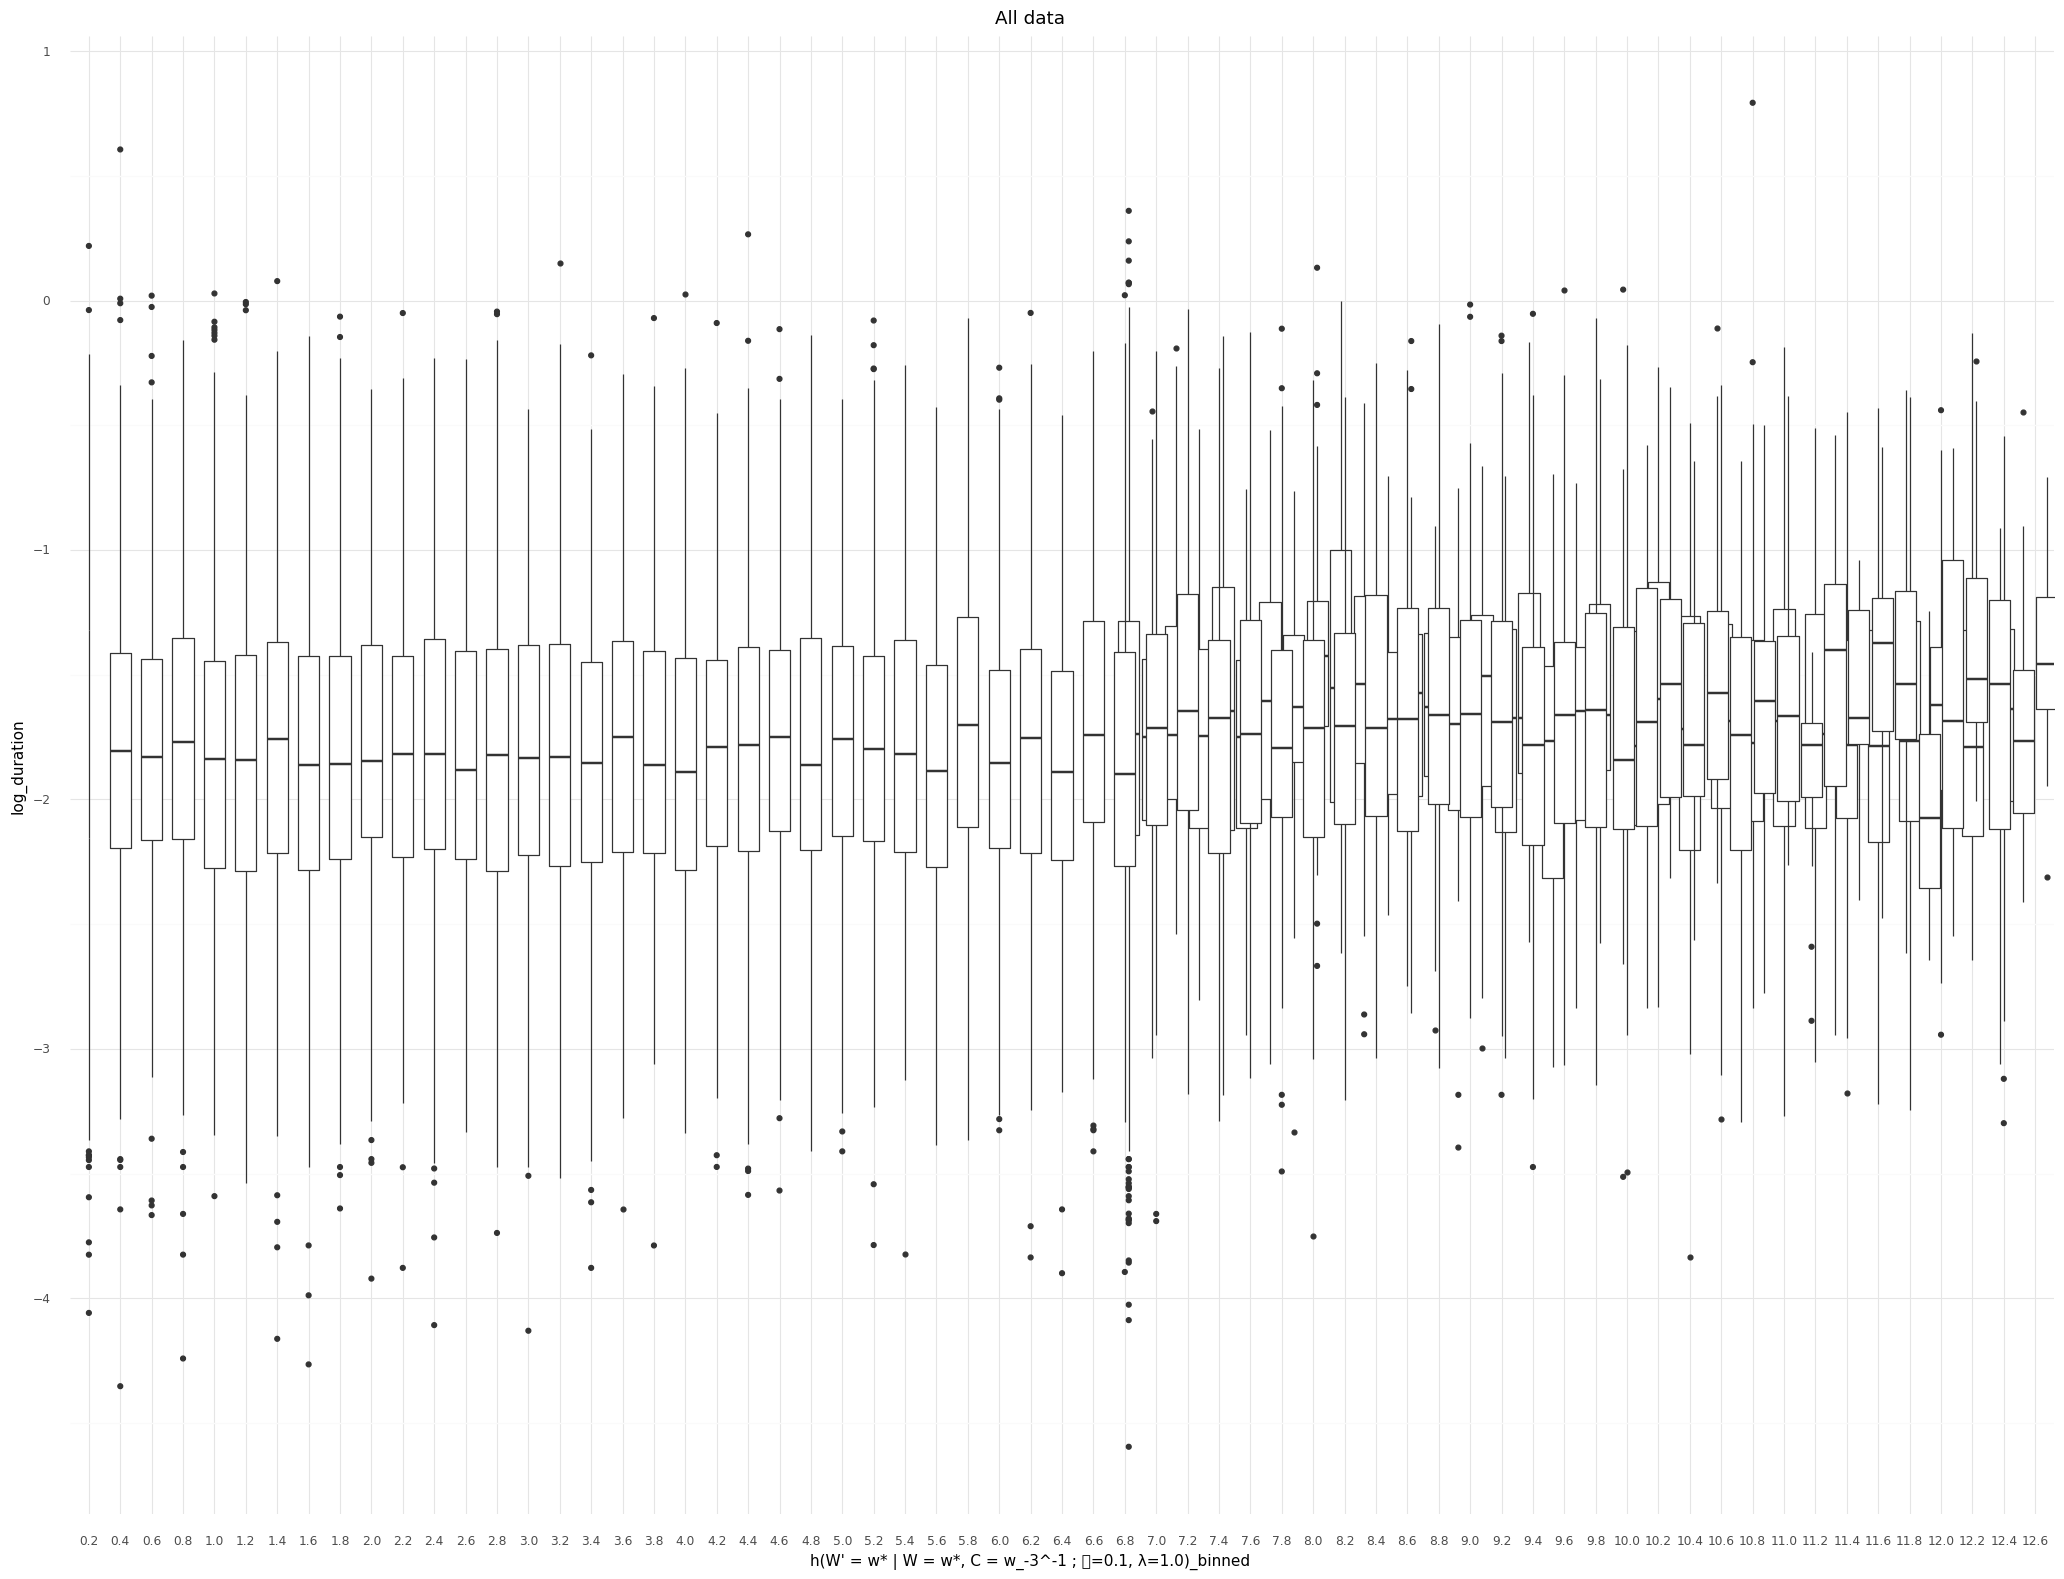

<ggplot: (8779368599861)>

................................................................................
--------------------------------------------------------------------------------
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


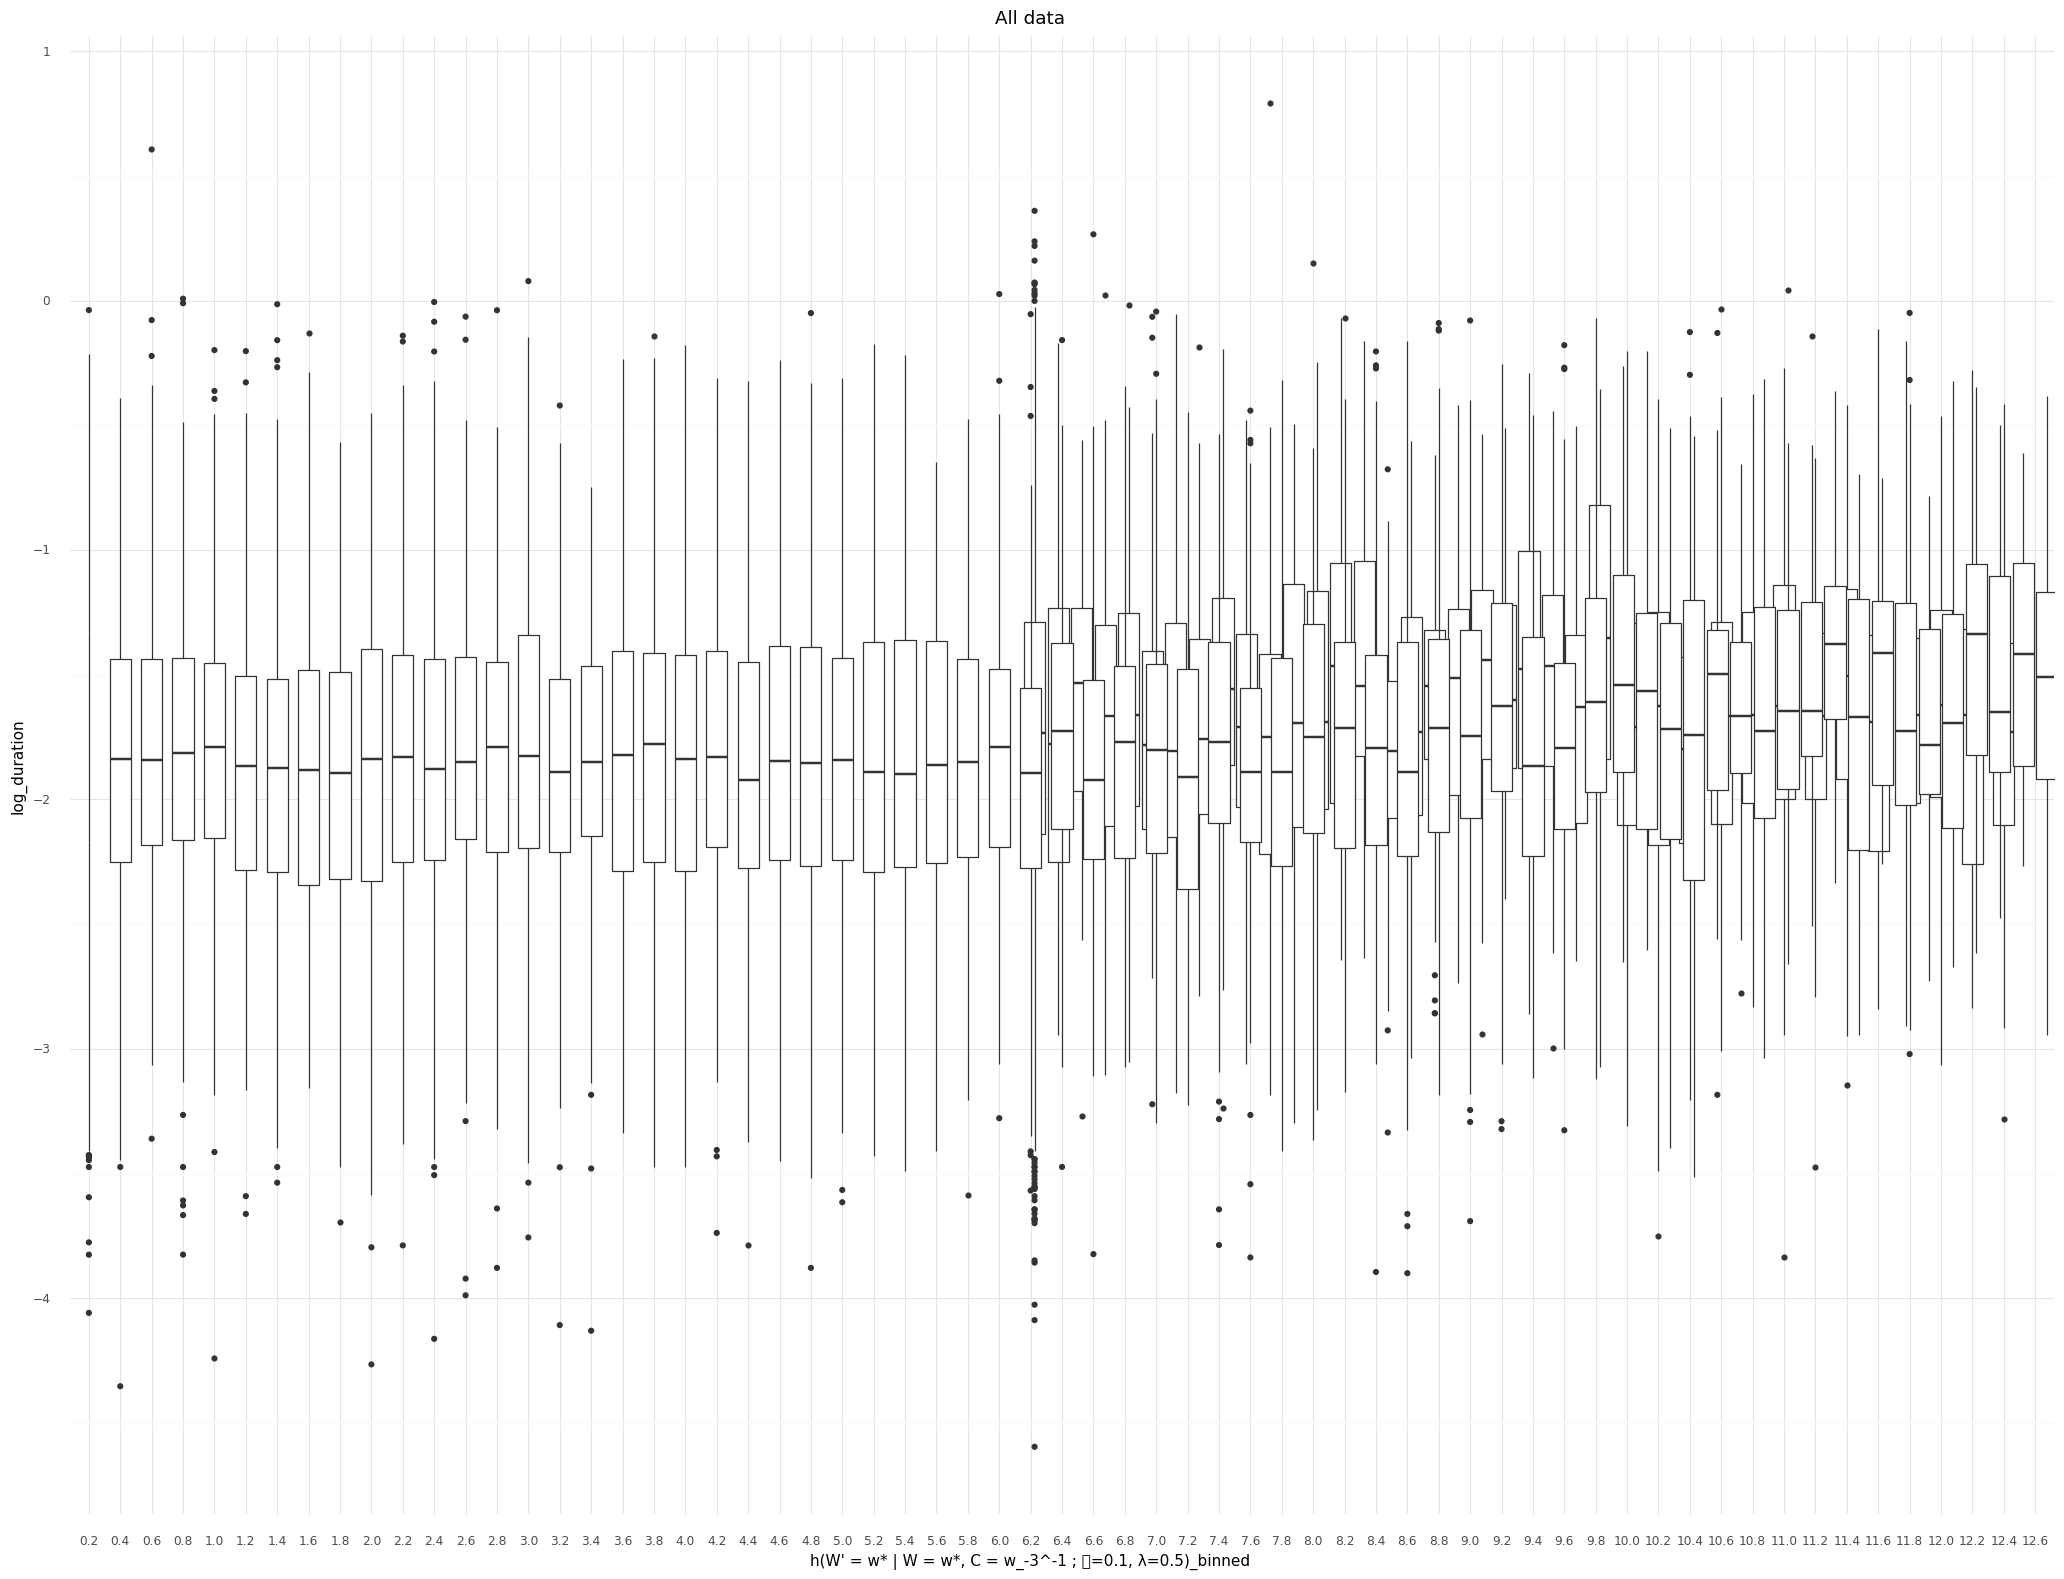

<ggplot: (8779356466729)>

................................................................................
--------------------------------------------------------------------------------
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


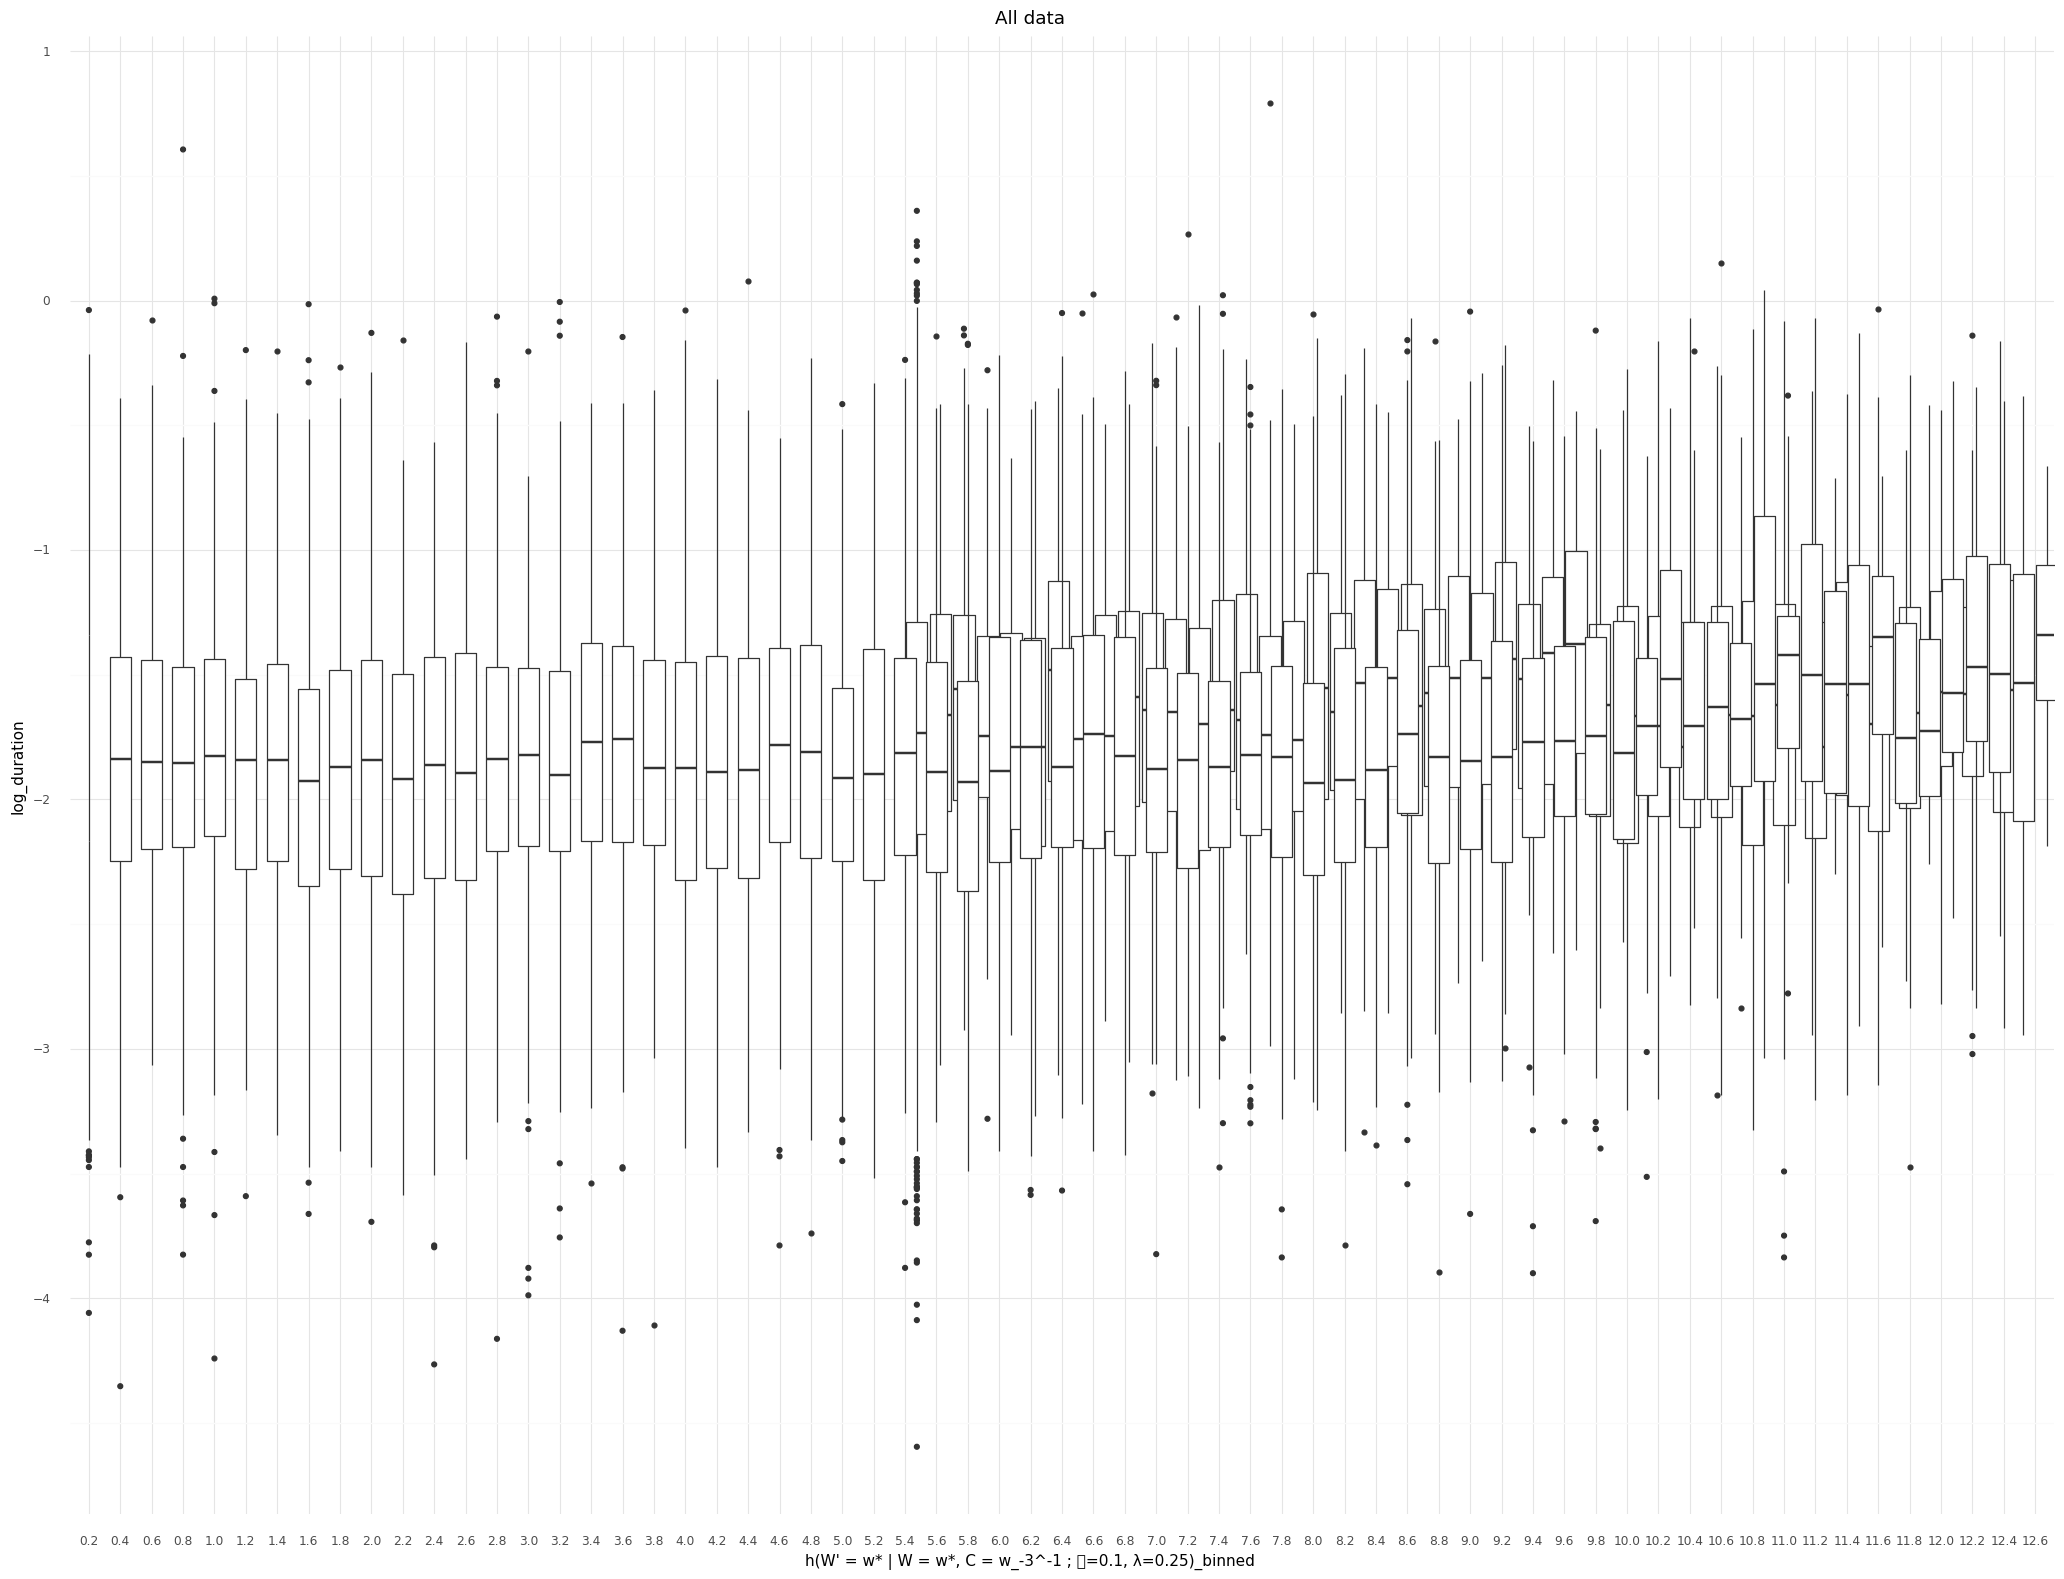

<ggplot: (8779358335533)>

................................................................................
--------------------------------------------------------------------------------
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


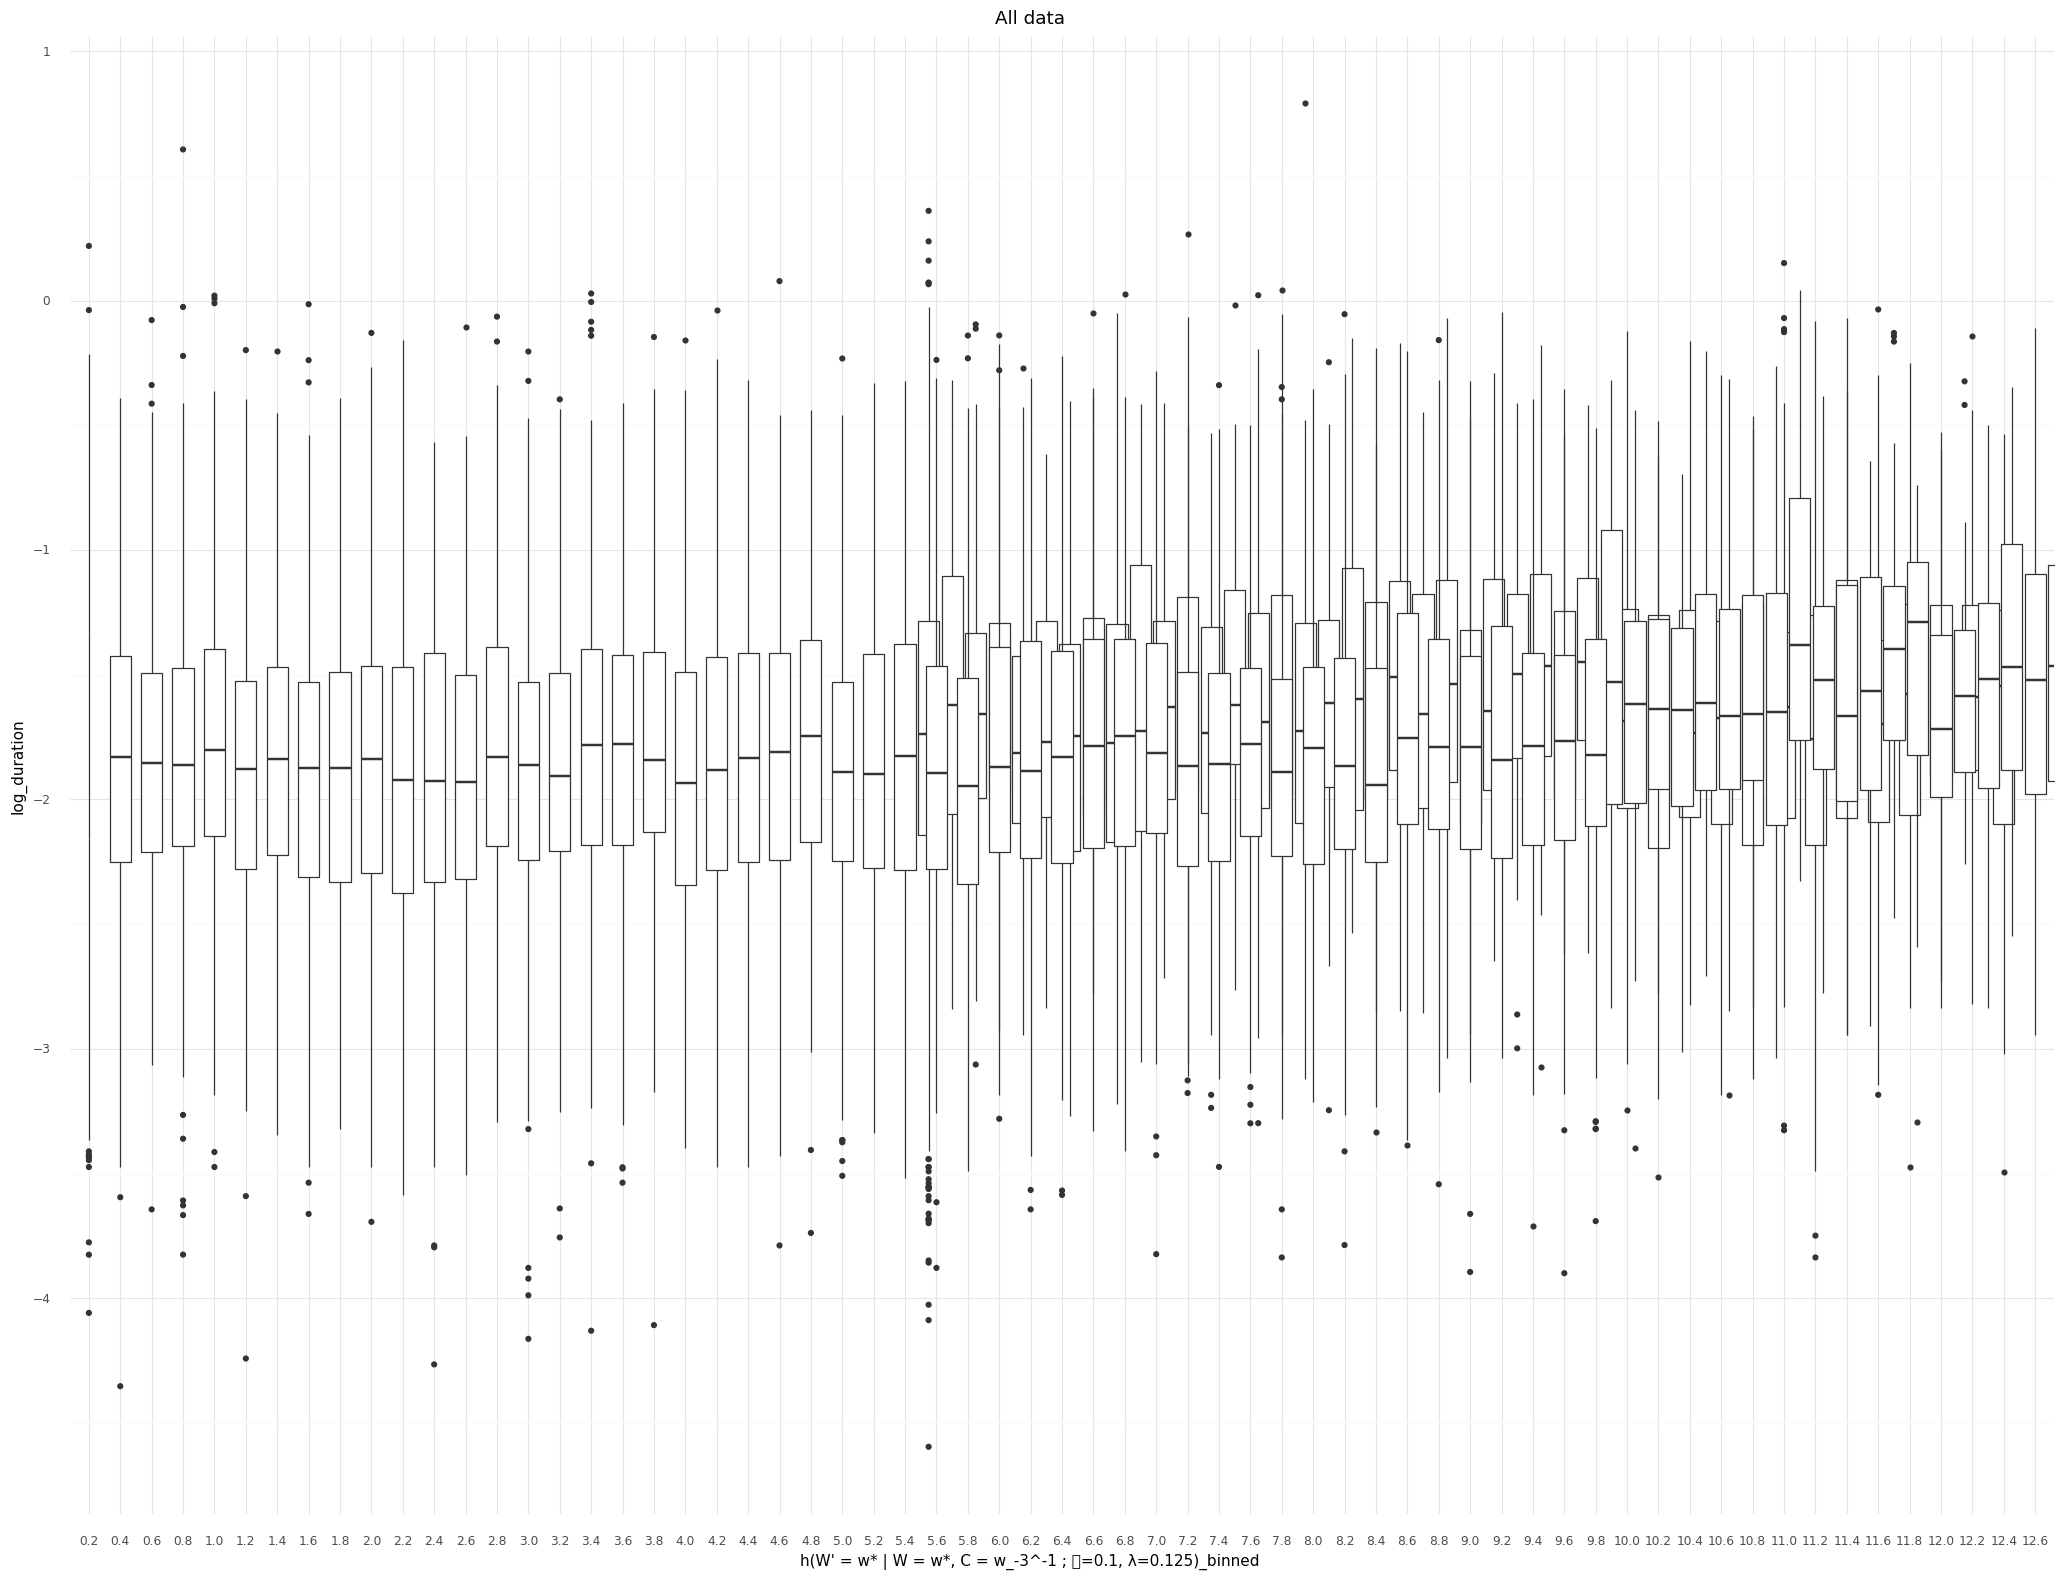

<ggplot: (8779398854413)>

................................................................................
--------------------------------------------------------------------------------




In [168]:
for surp_field in lmap(lambda field_name: field_name + '_binned',
                       four_gram_bwds_post_fields_pc01):
# for surp_field in lmap(lambda field_name: field_name + '_binned', 
#                        set(surprisal_fields) - set(avg_fields)):
#     for surp_field in lmap(lambda field_name: field_name + '_binned', (lm_field_backward_h, post_field_backward_h,
#                                                                        lm_field_forward_h, post_field_forward_h)):

#         print(f"\ts={each_s}, l={each_l}")
    print(f"\tSurprisal Field = {surp_field}")
    for dur_field in ('log_duration',):
#         for dur_field in ('duration', 'log_duration'):
#             print(f"\t\ts={each_s}, l={each_l}")
        print(f"\t\tSurprisal Field = {surp_field}")
        print(f"\t\tDuration Field = {dur_field}")
        x_scale_limits = surprisal_bins_generic_edges_cat_trimmed
#         x_scale_limits = surprisal_bins_generic_edges_cat
#             x_scale_limits = surprisal_bins_edges_cat if "W'" in surp_field else surprisal_bins_lm_edges_cat
        make_plot(dev_words_df, surp_field, dur_field, x_scale_limits=x_scale_limits, title="All data")
#             make_plot(dev_words_df[(dev_words_df['phones_length'] == each_l) & (dev_words_df['syllables'] == each_s)], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"l={each_l}, s={each_s}")
#             make_plot(dev_words_df[dev_words_df['syllables'] == each_s], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"s={each_s}")
        print('.' * 80)
    print('-' * 80)
print('=' * 80)
print('\n')

In [ ]:
title = "All data"
boxwhisker = hv.BoxWhisker(dev_words_df, four_gram_bwds_post_fields_pc01[0]+'_binned', 'log_duration', label=title)

In [ ]:
boxwhisker.opts(show_legend=False, width=2400, height=800, cmap='Set3')

In [ ]:
def four_gram_bwd_post_allWords_plot(pseudocount, scaling_factor):
    surp_field = mk_field('post', 
                          order=4, direction='bwd',
                          pc=pseudocount,
                          scale_factor = scaling_factor)
    my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label='All words').sort()
    my_boxwhisker.opts(show_legend=False, width=2400, height=800, cmap='Set3', legend_position='top_left')
    return my_boxwhisker

In [ ]:
four_gram_bwd_post_allWords_plot(0.01, 1.0)

In [ ]:
dmap = hv.DynamicMap(four_gram_bwd_post_allWords_plot, kdims=['pseudocount', 'scaling_factor'])
dmap

In [ ]:
dmap[0.001,1.0]

In [ ]:
dmap.select(pseudocount=0.001, scaling_factor=1.0)

In [ ]:
# dmap.redim.range(pseudocount=(0.0, 0.1), scaling_factor=(0.125, 1.0))
alphas
lambdas
dmap.redim.values(pseudocount=alphas, scaling_factor=lambdas)
# dmap.redim.values(alpha=[1, 2, 3], beta=[0.1, 1.0, 2.5])

In [ ]:
# dmap.redim?

In [ ]:
# holomap = hv.HoloMap({(N,r):shapes(N, r) for N in [3,4,5] for r in [0.5,0.75]},  kdims=['N', 'radius'])
# holomap = hv.HoloMap({(pc,l):four_gram_bwd_post_allWords_plot(pc,l) 
#                       for pc in alphas for l in lambdas},  kdims=['alpha', 'lambda'])

In [ ]:
# boxwhisker2 = hv.BoxWhisker(dev_words_df, [four_gram_bwds_post_fields_pc01[0]+'_binned', four_gram_bwds_post_fields_pc001[0]+'_binned'], 'log_duration', label=title)

### ...for particular lengths

In [ ]:
syll_seg_combos

s=1, l=2
	s=1, l=2
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=1, l=2
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=1, l=2, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


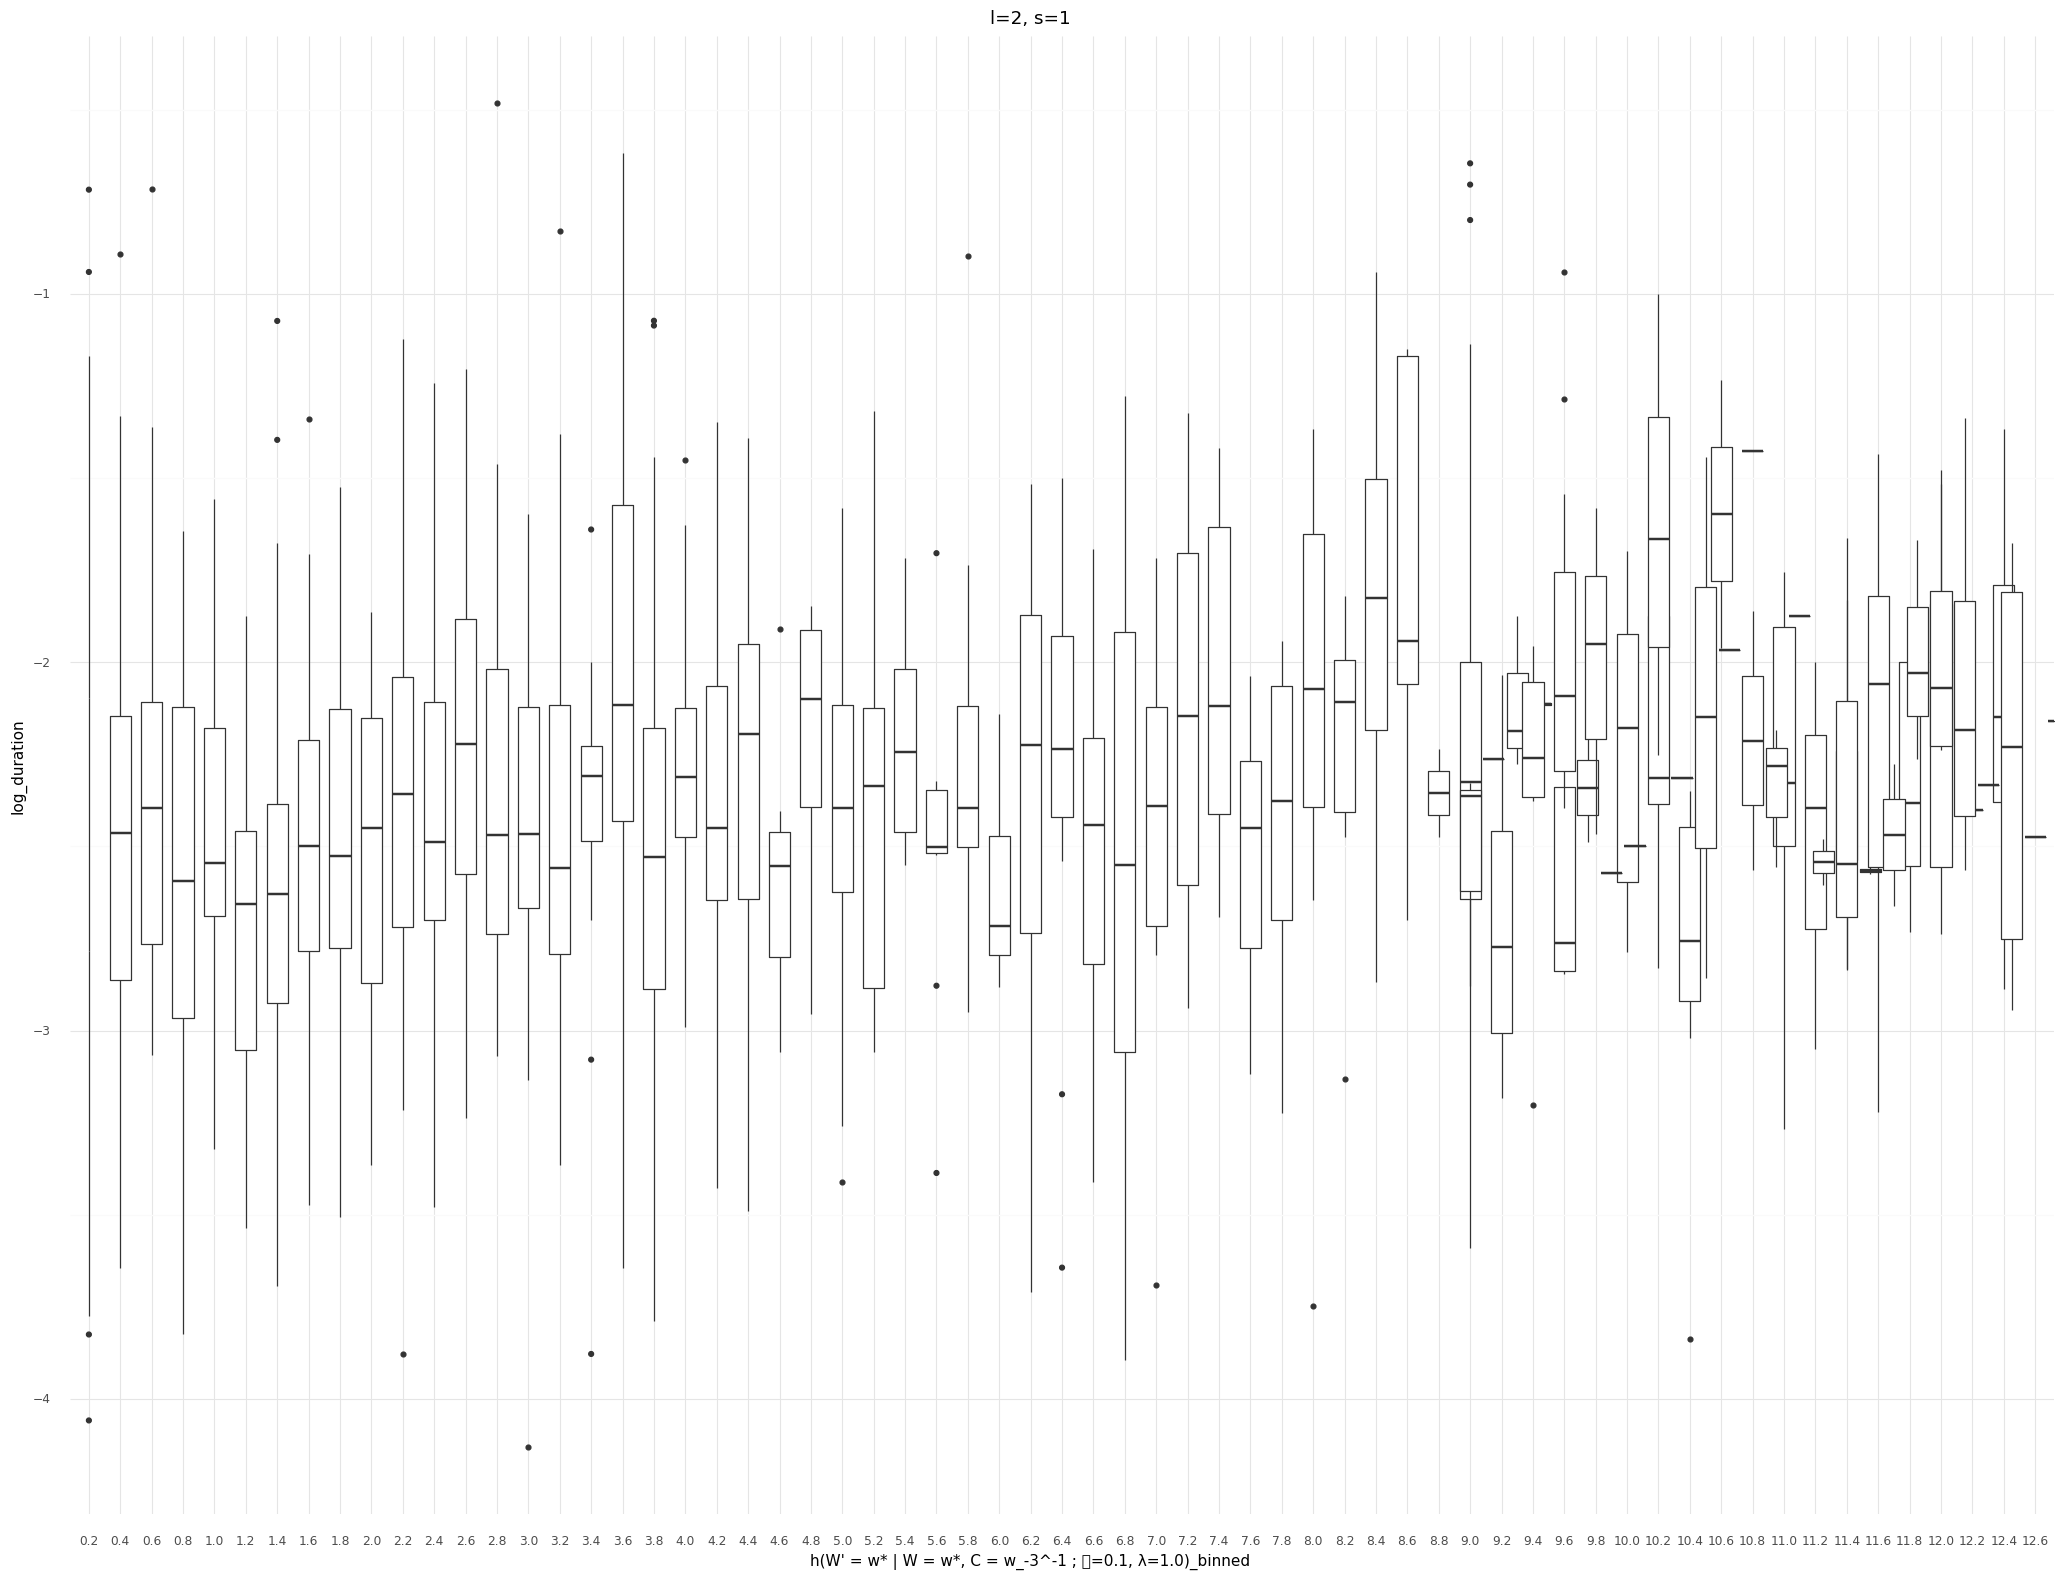

<ggplot: (8779370959229)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=2
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=1, l=2
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=1, l=2, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


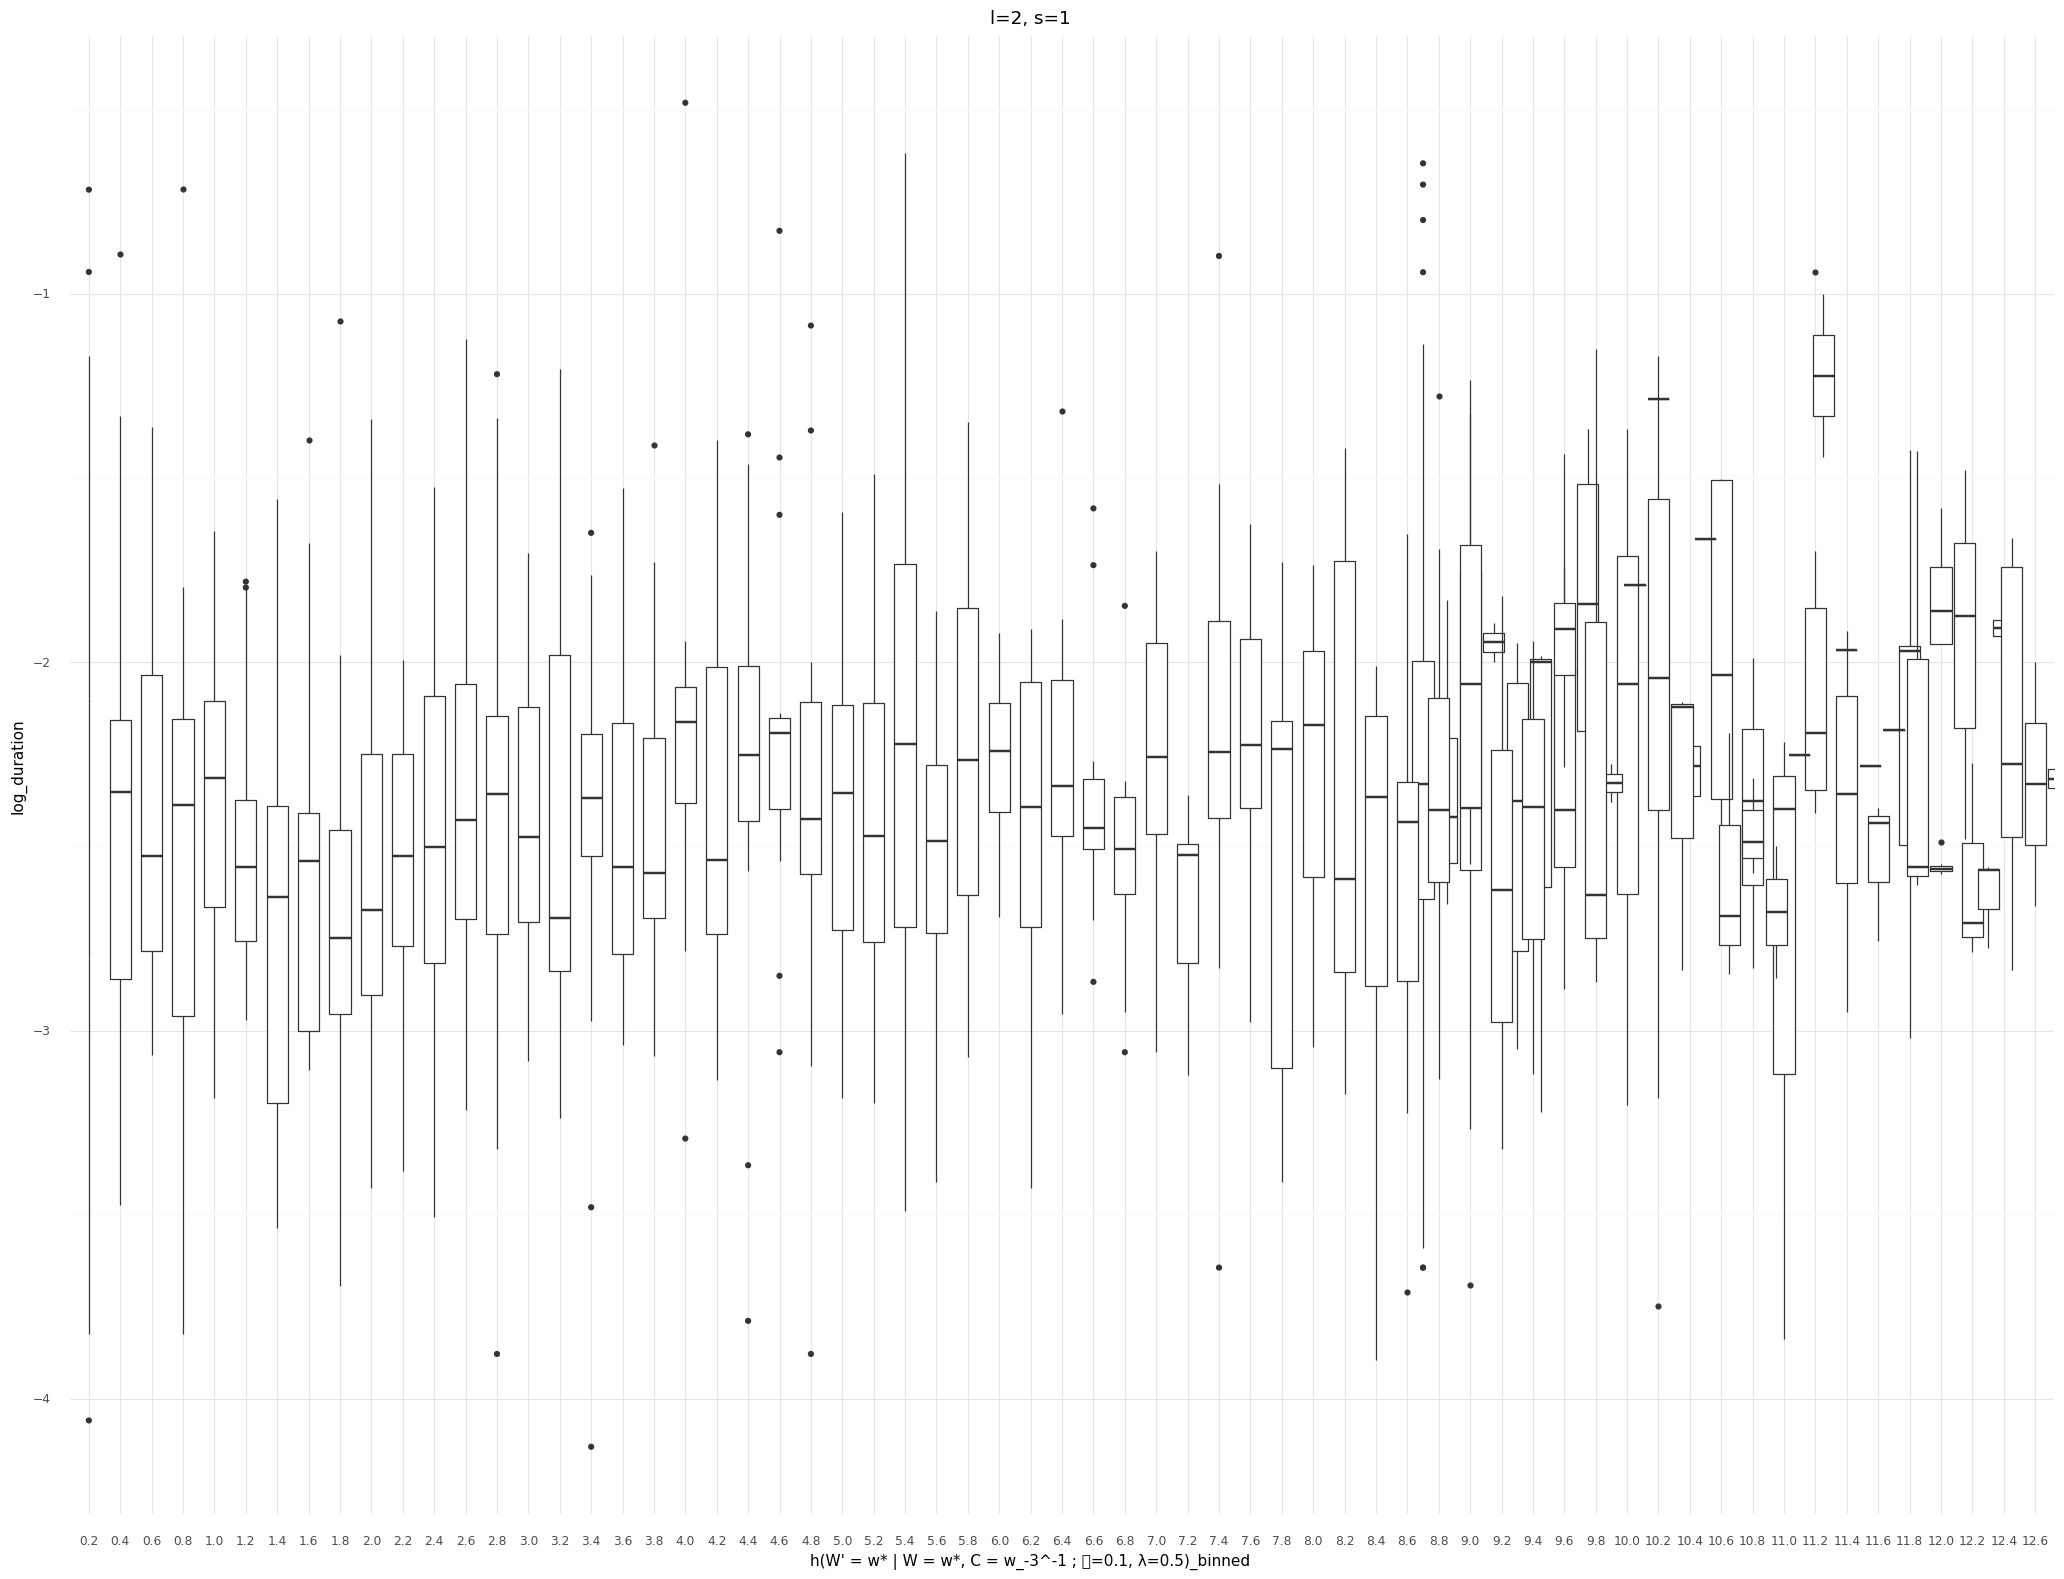

<ggplot: (8779395670297)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=2
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=1, l=2
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=1, l=2, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


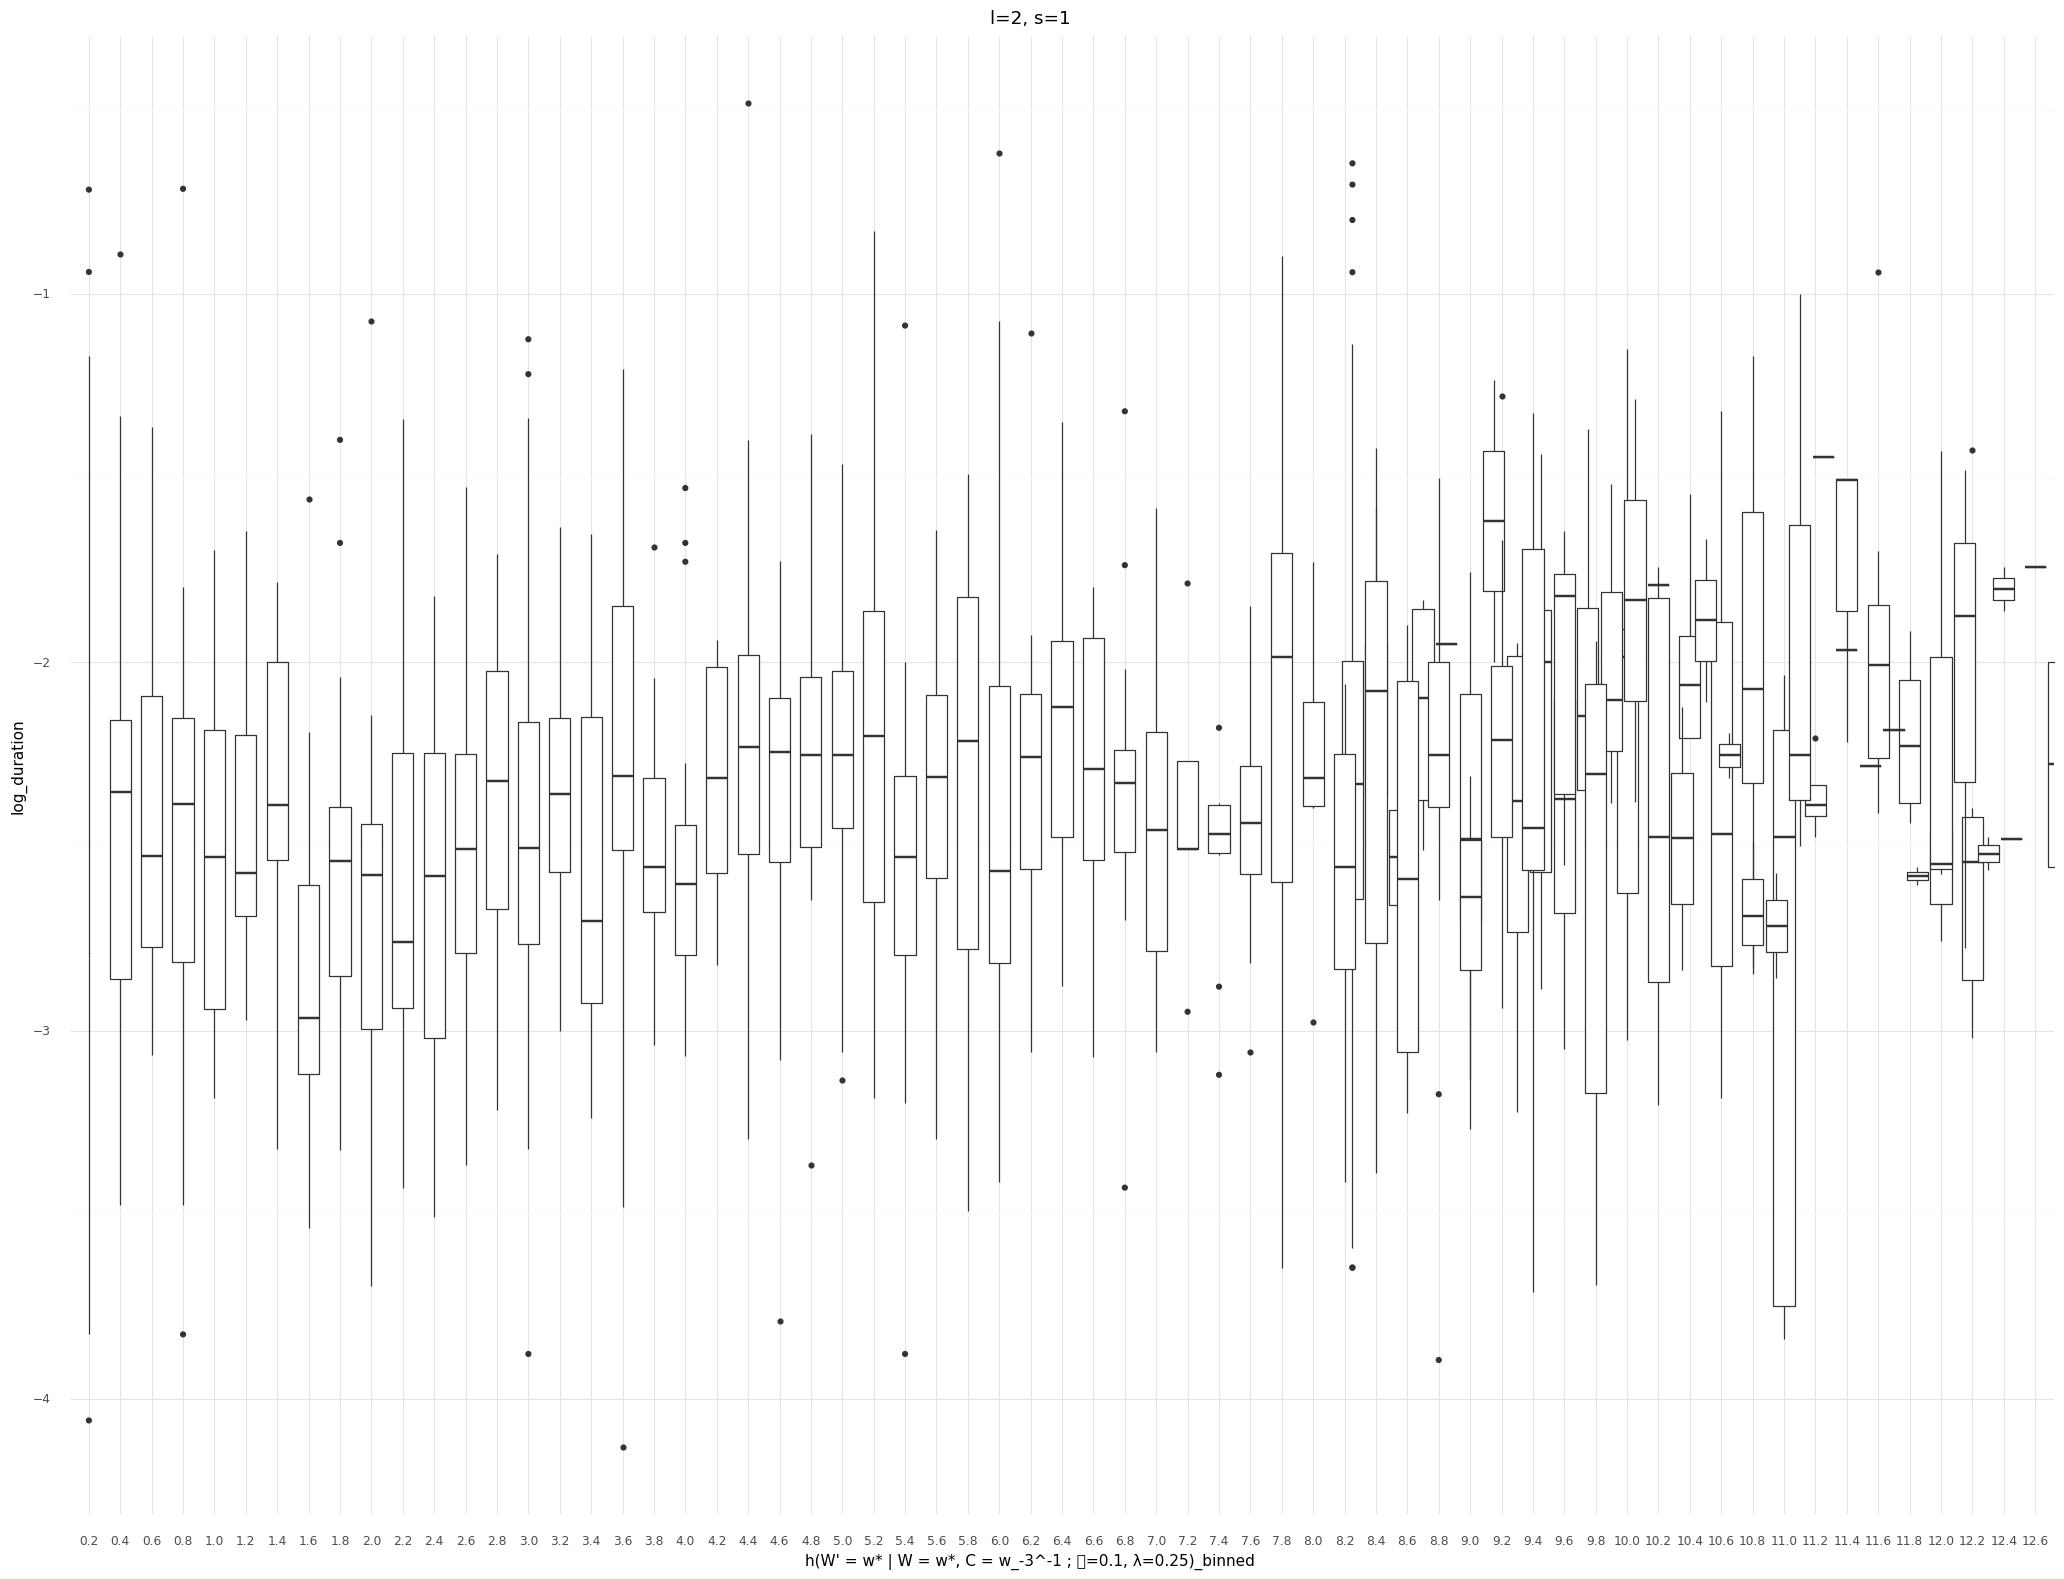

<ggplot: (8779356242613)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=2
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=1, l=2
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=1, l=2, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


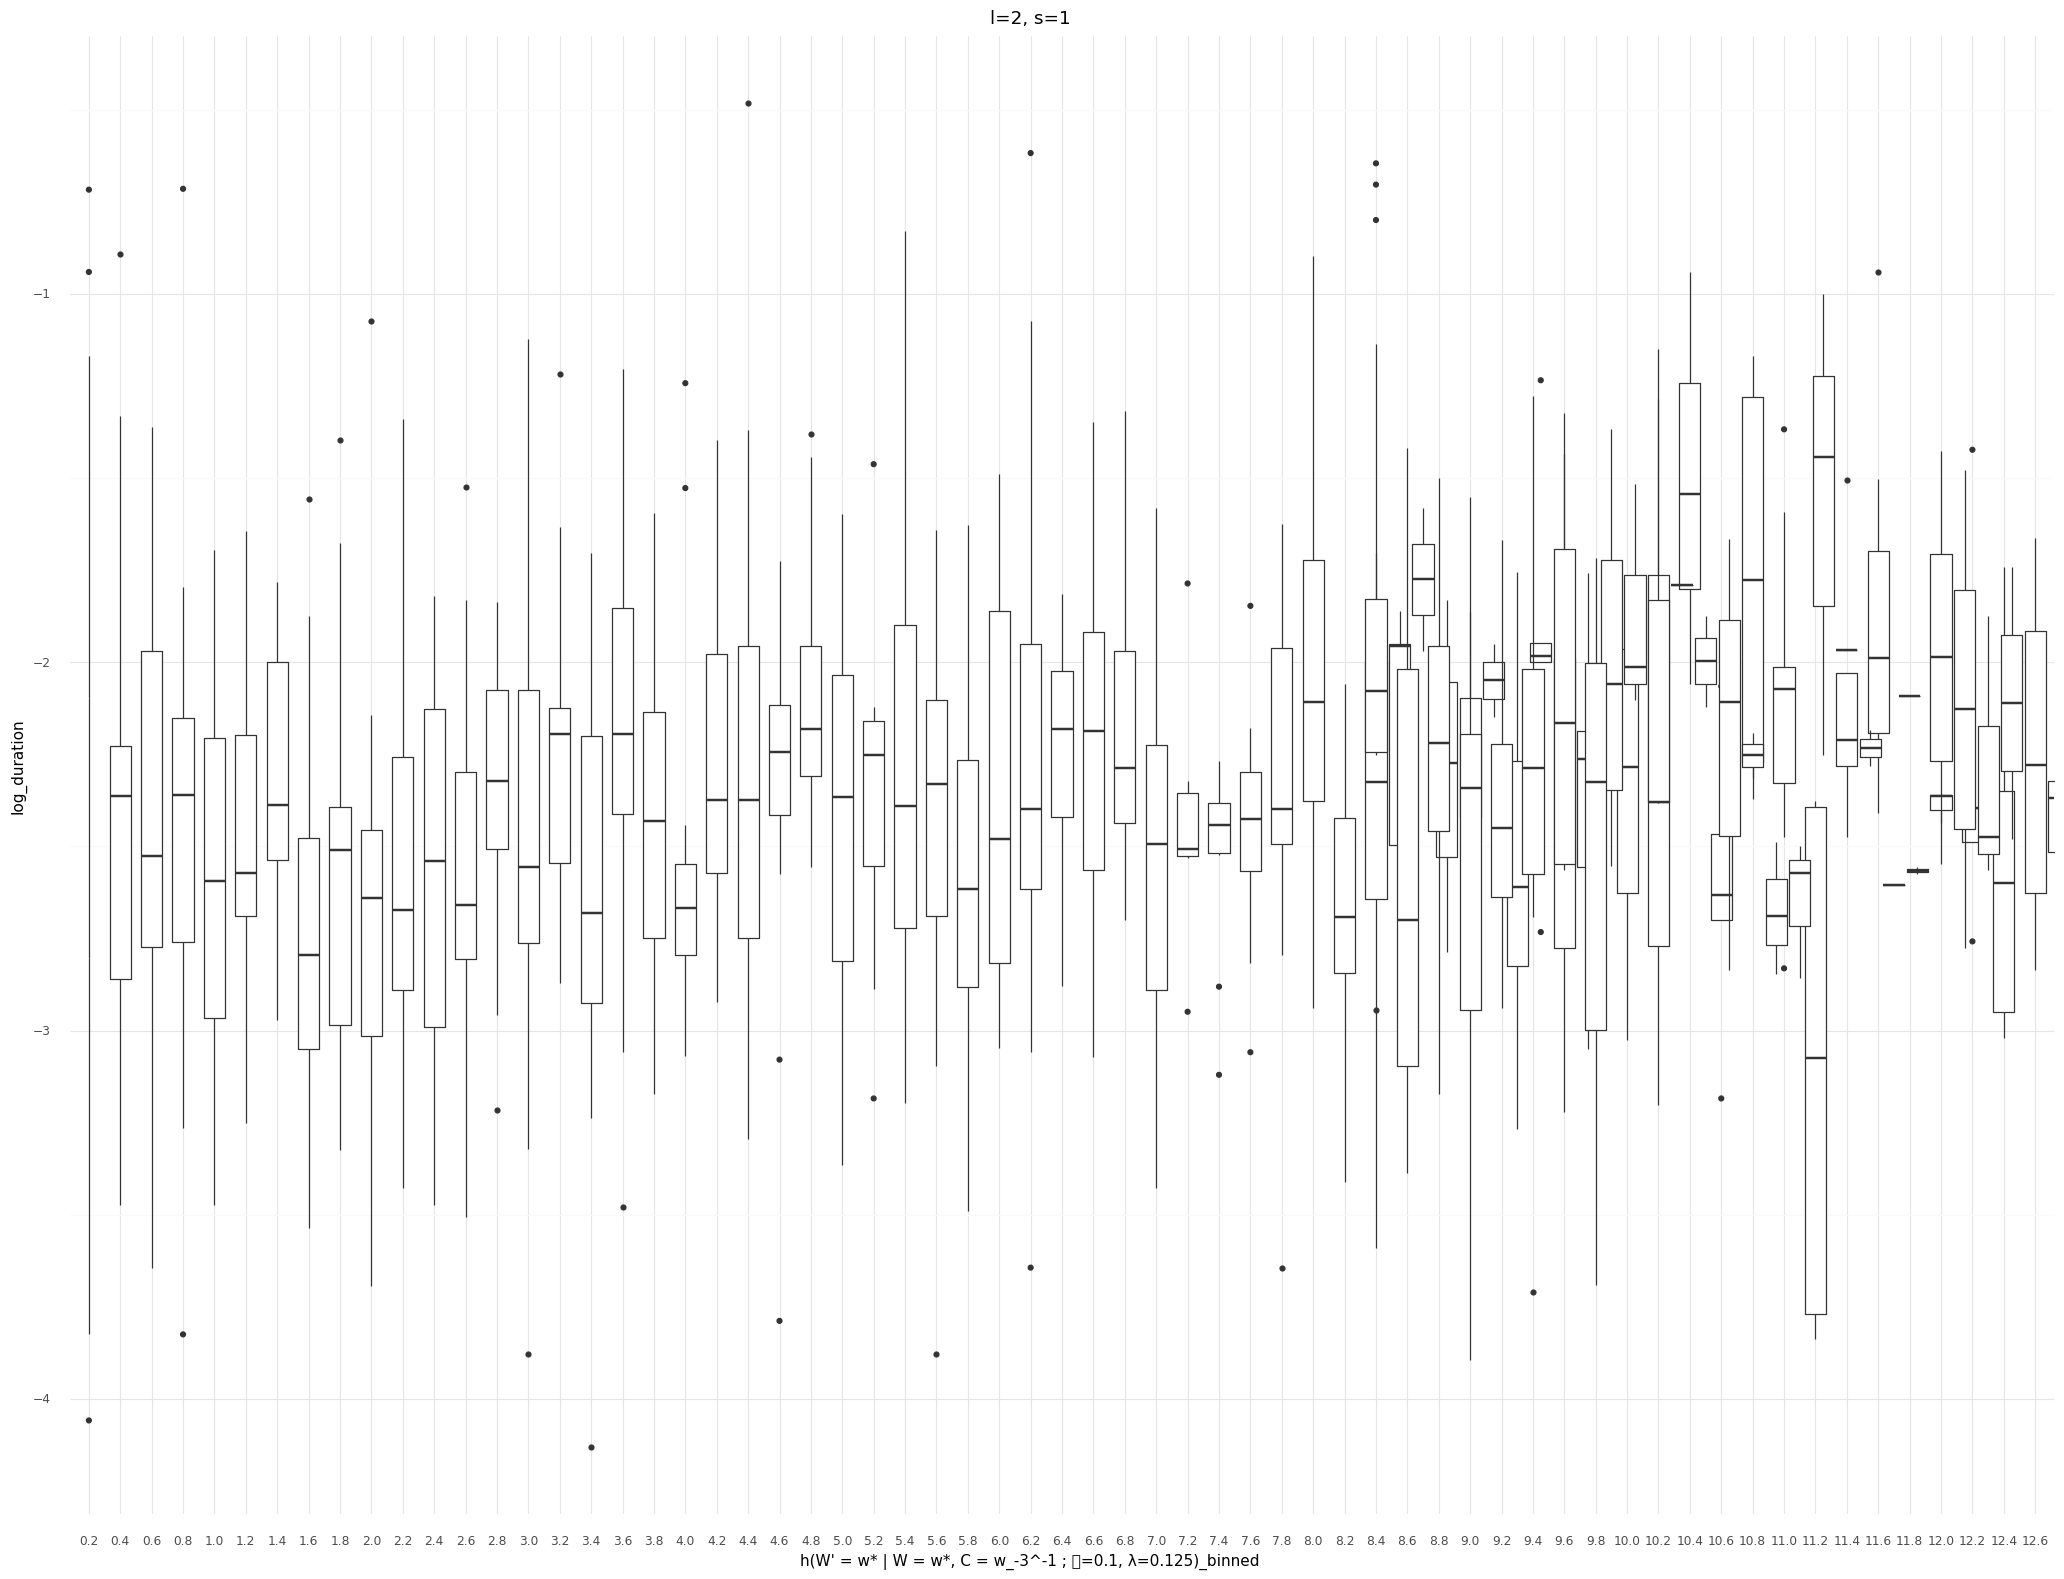

<ggplot: (8779274931129)>

................................................................................
--------------------------------------------------------------------------------


s=1, l=3
	s=1, l=3
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=1, l=3
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=1, l=3, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


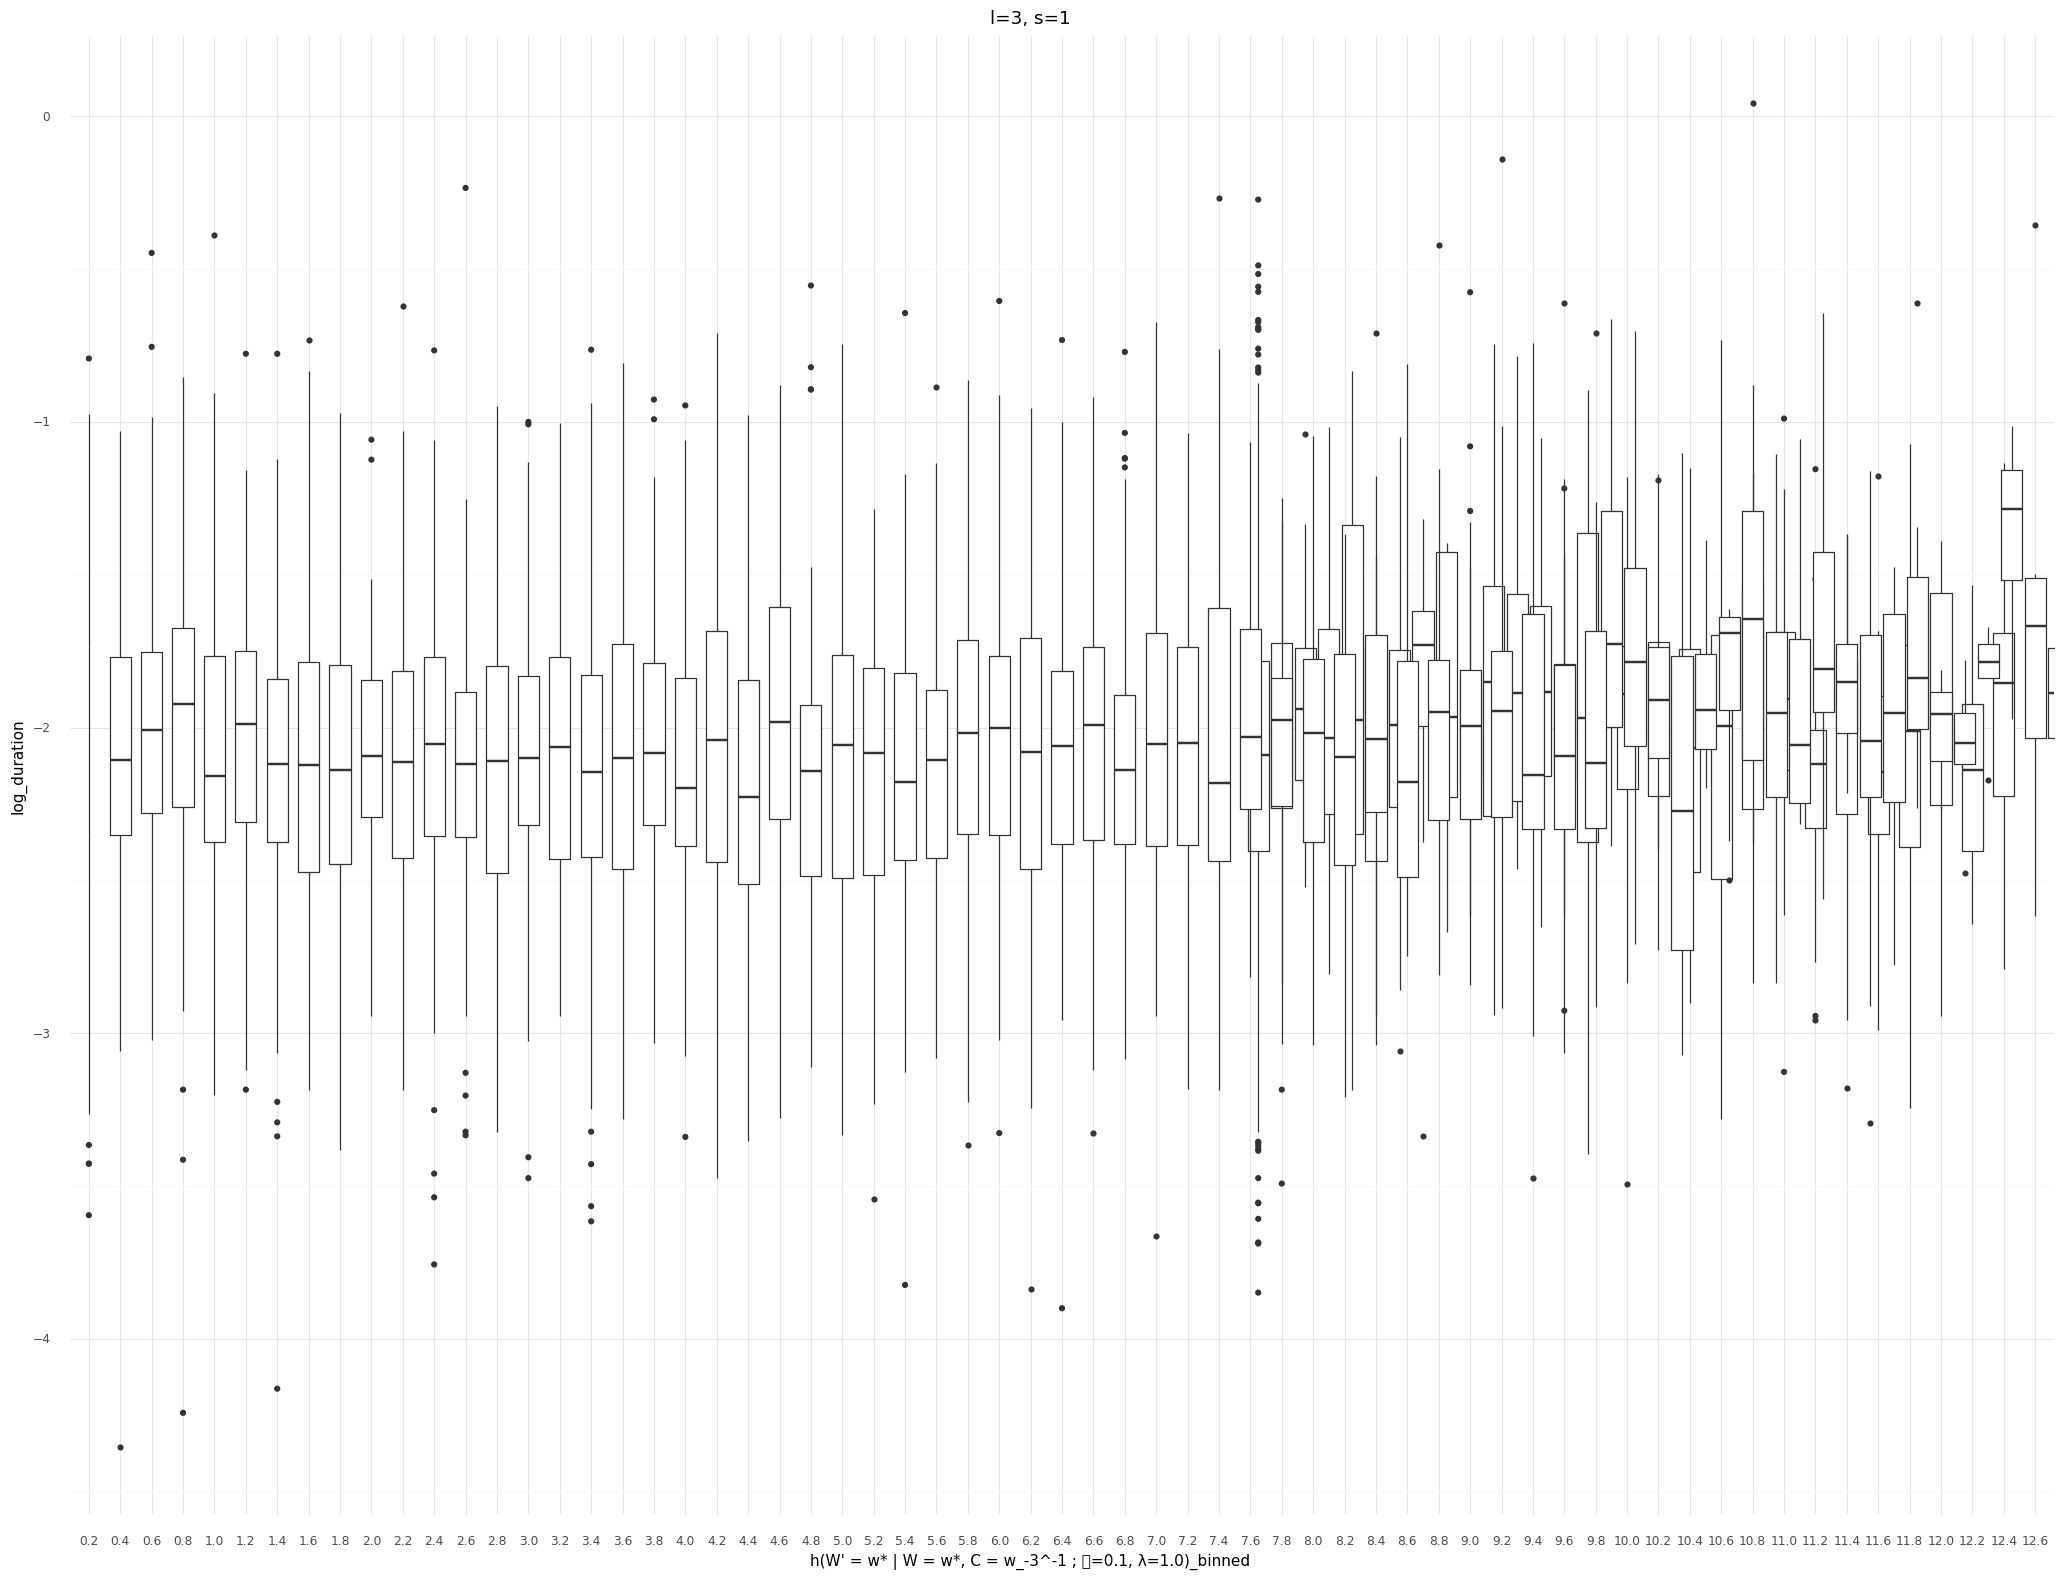

<ggplot: (8779374693257)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=3
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=1, l=3
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=1, l=3, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


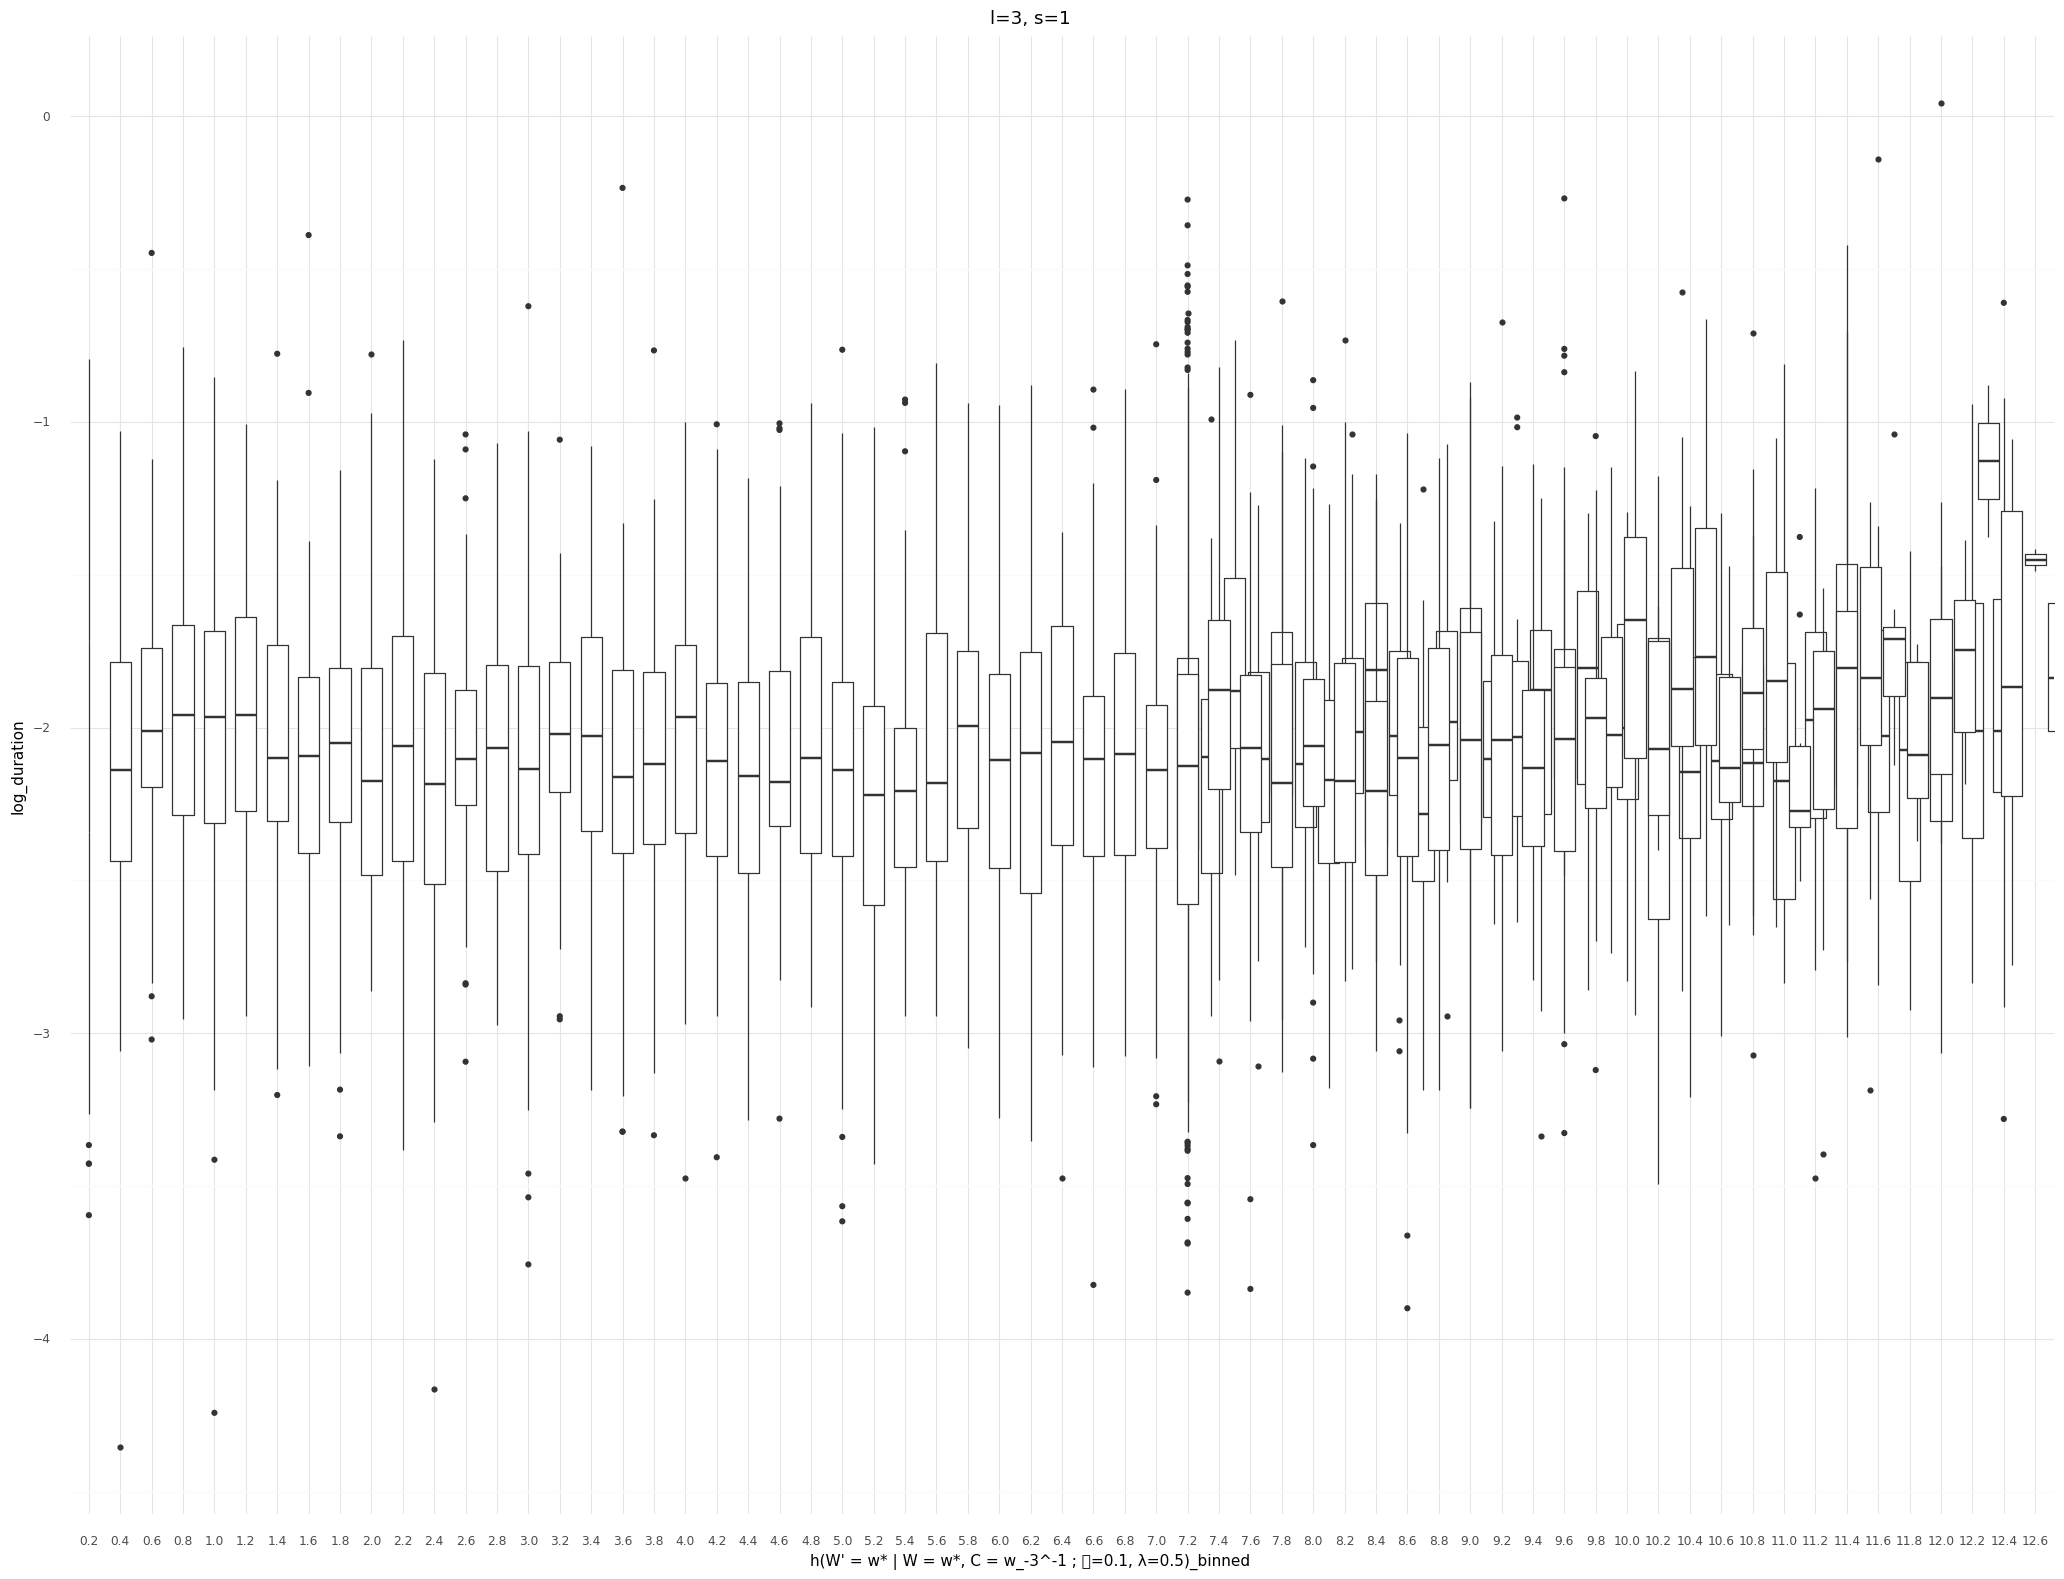

<ggplot: (8779447917541)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=3
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=1, l=3
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=1, l=3, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


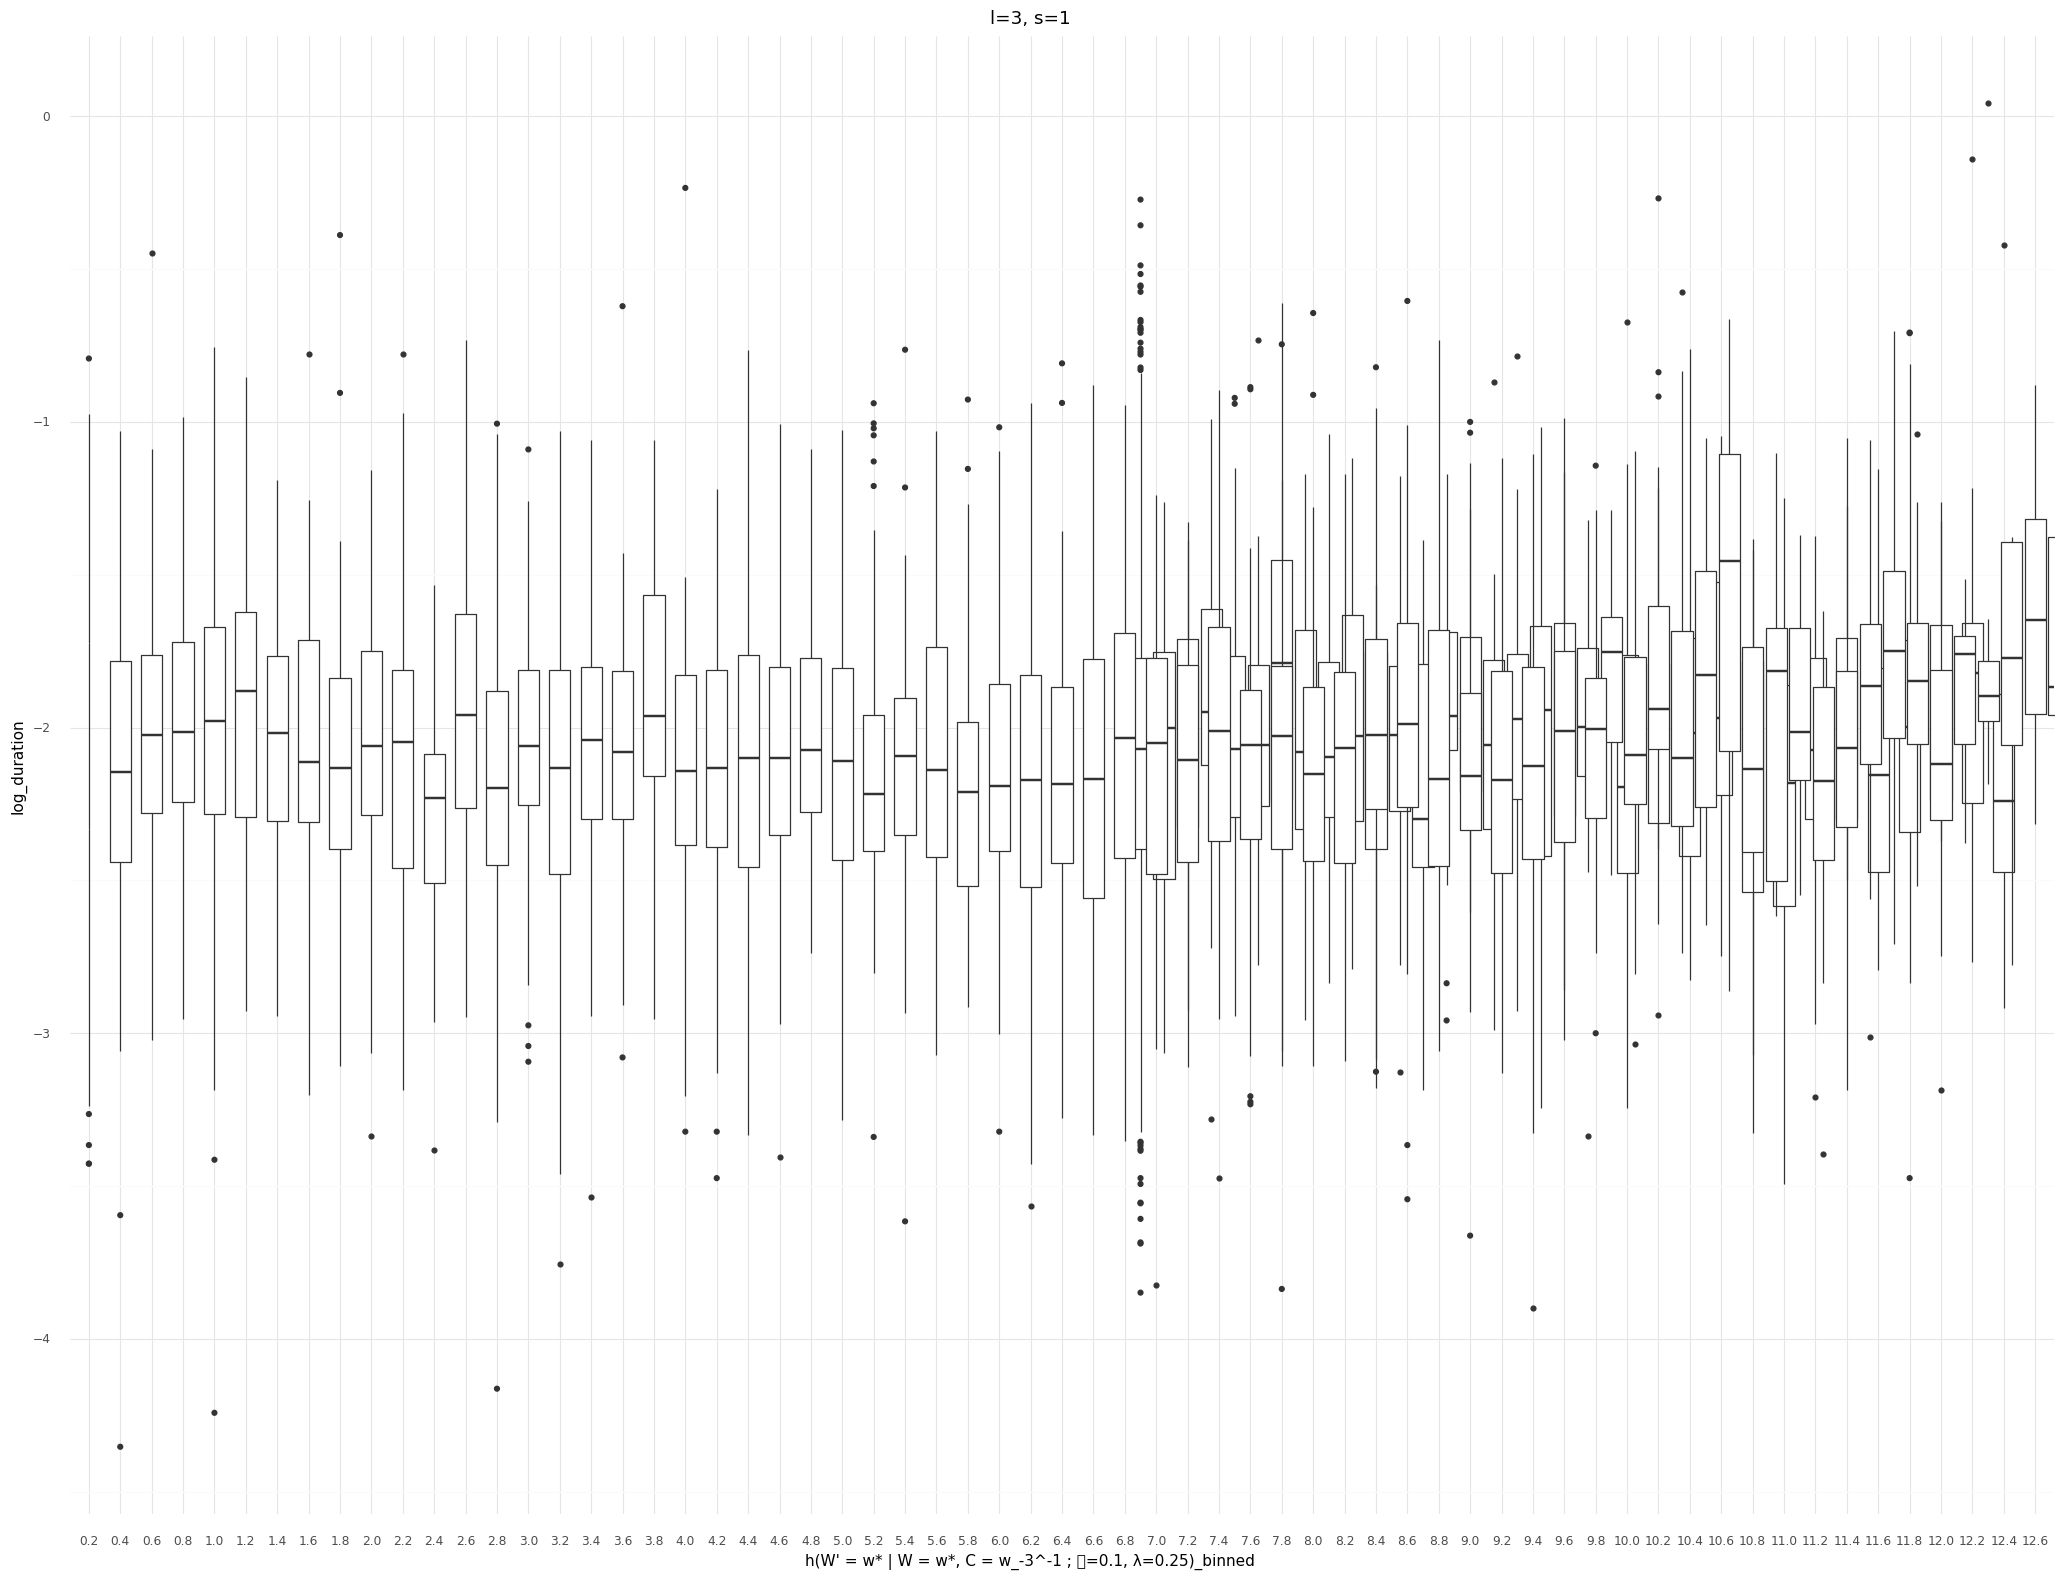

<ggplot: (8779361727225)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=3
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=1, l=3
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=1, l=3, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


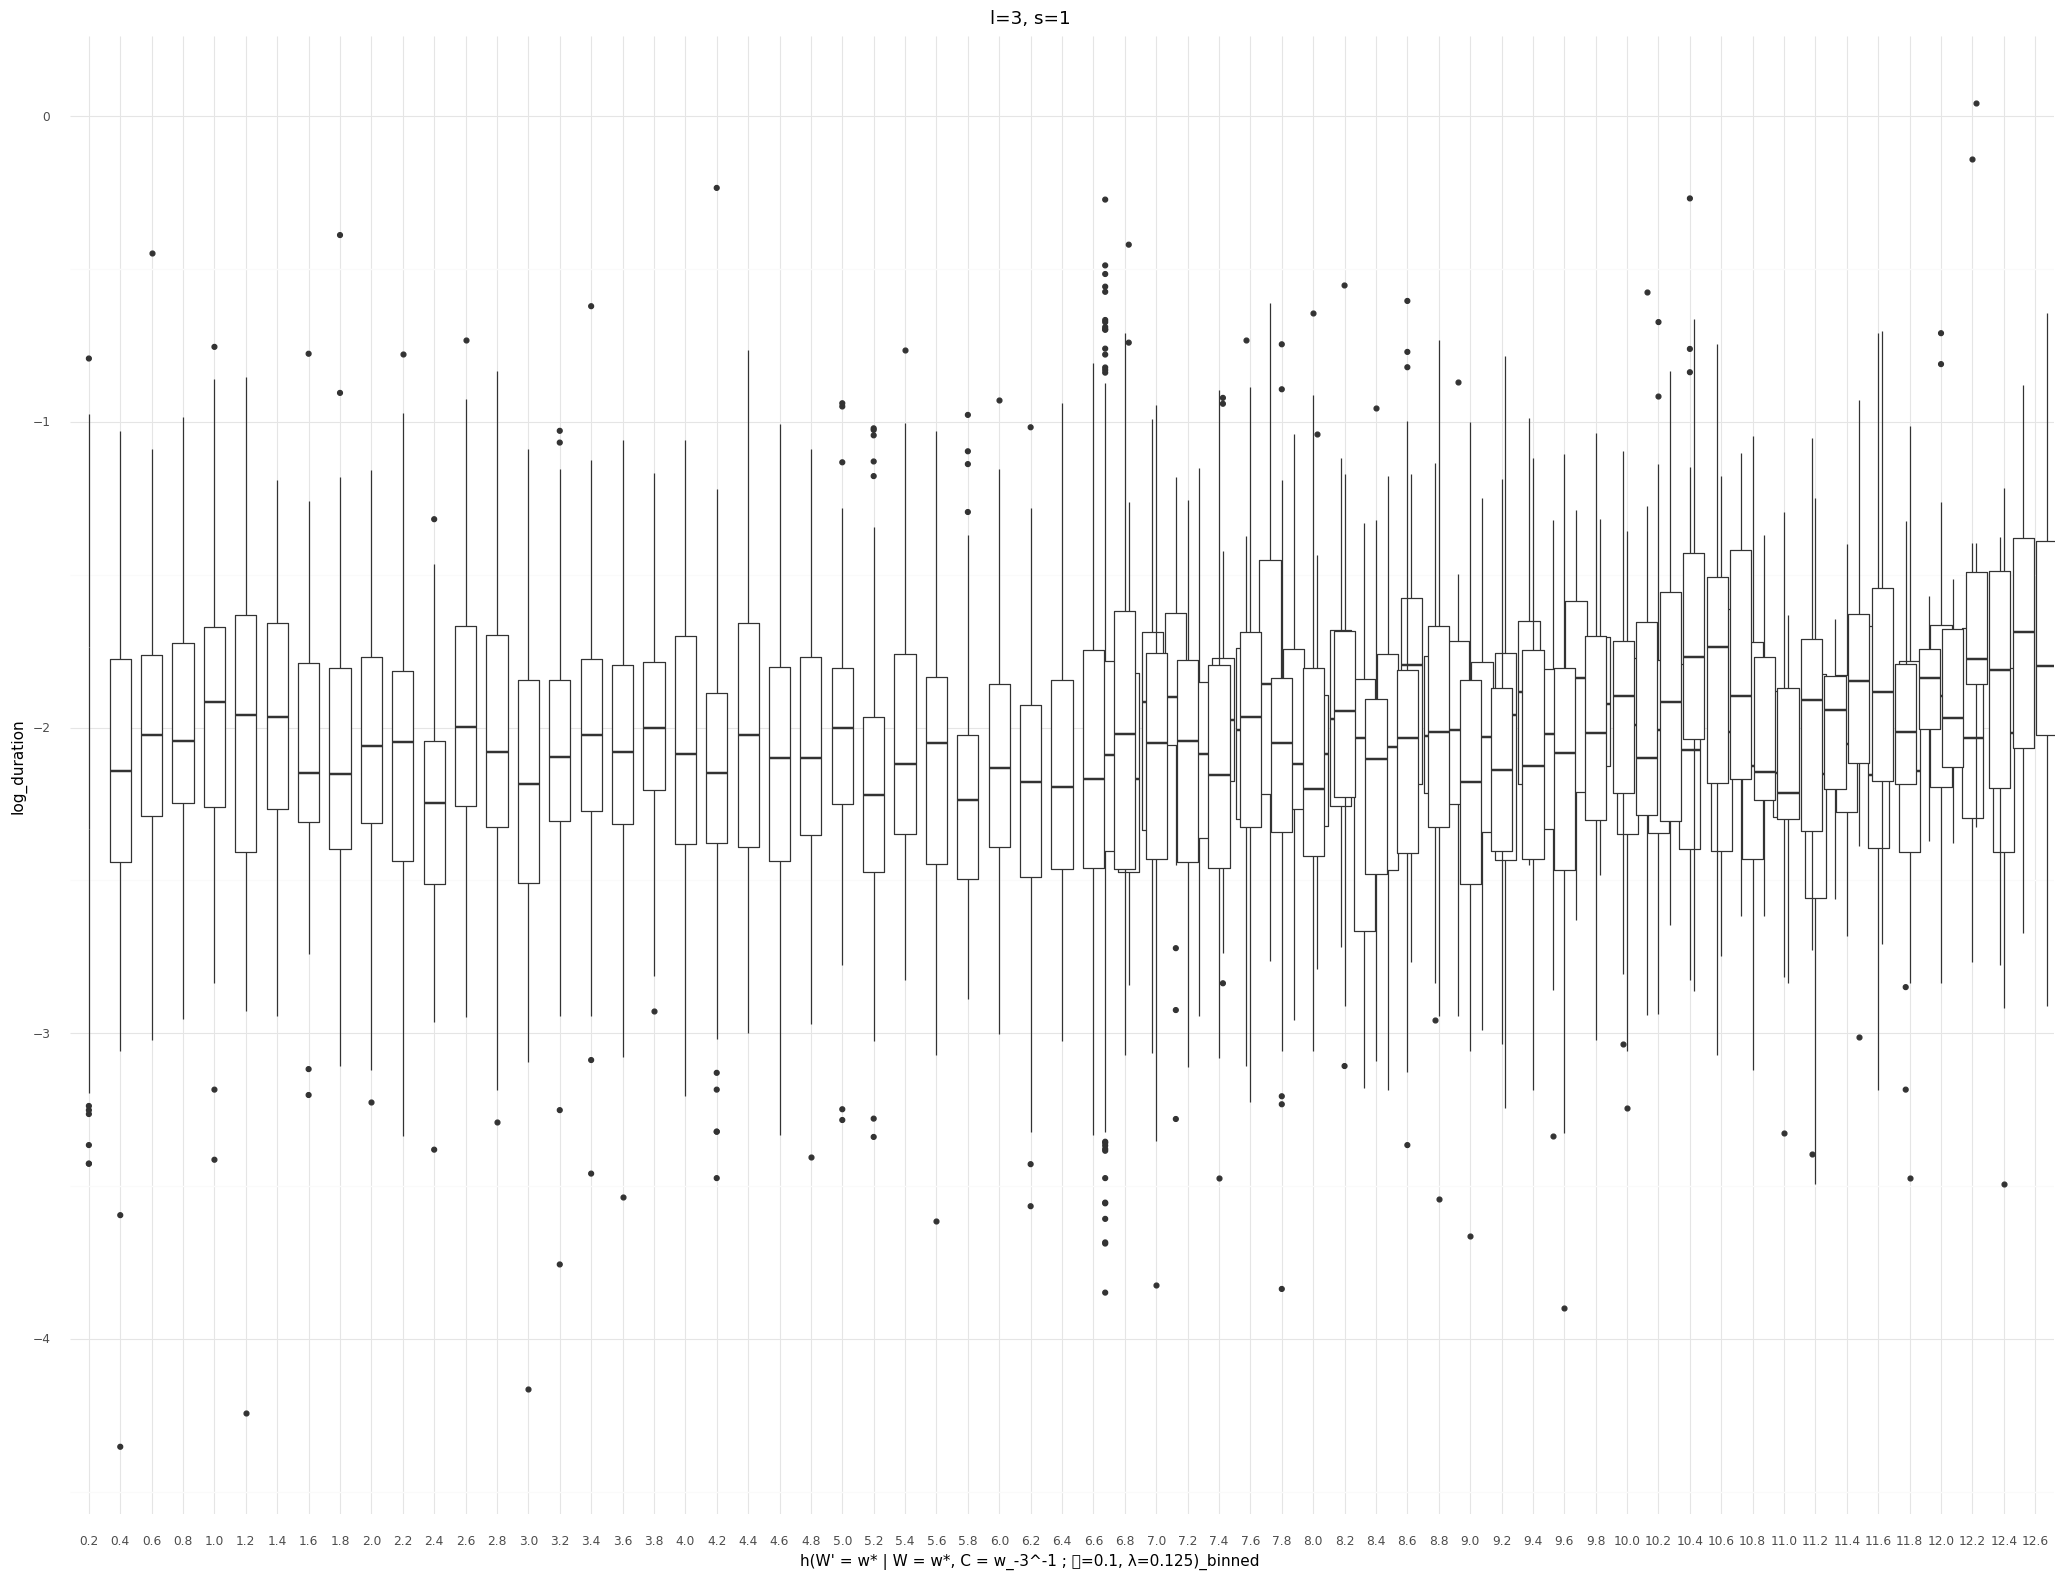

<ggplot: (8779402196685)>

................................................................................
--------------------------------------------------------------------------------


s=1, l=4
	s=1, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=1, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=1, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


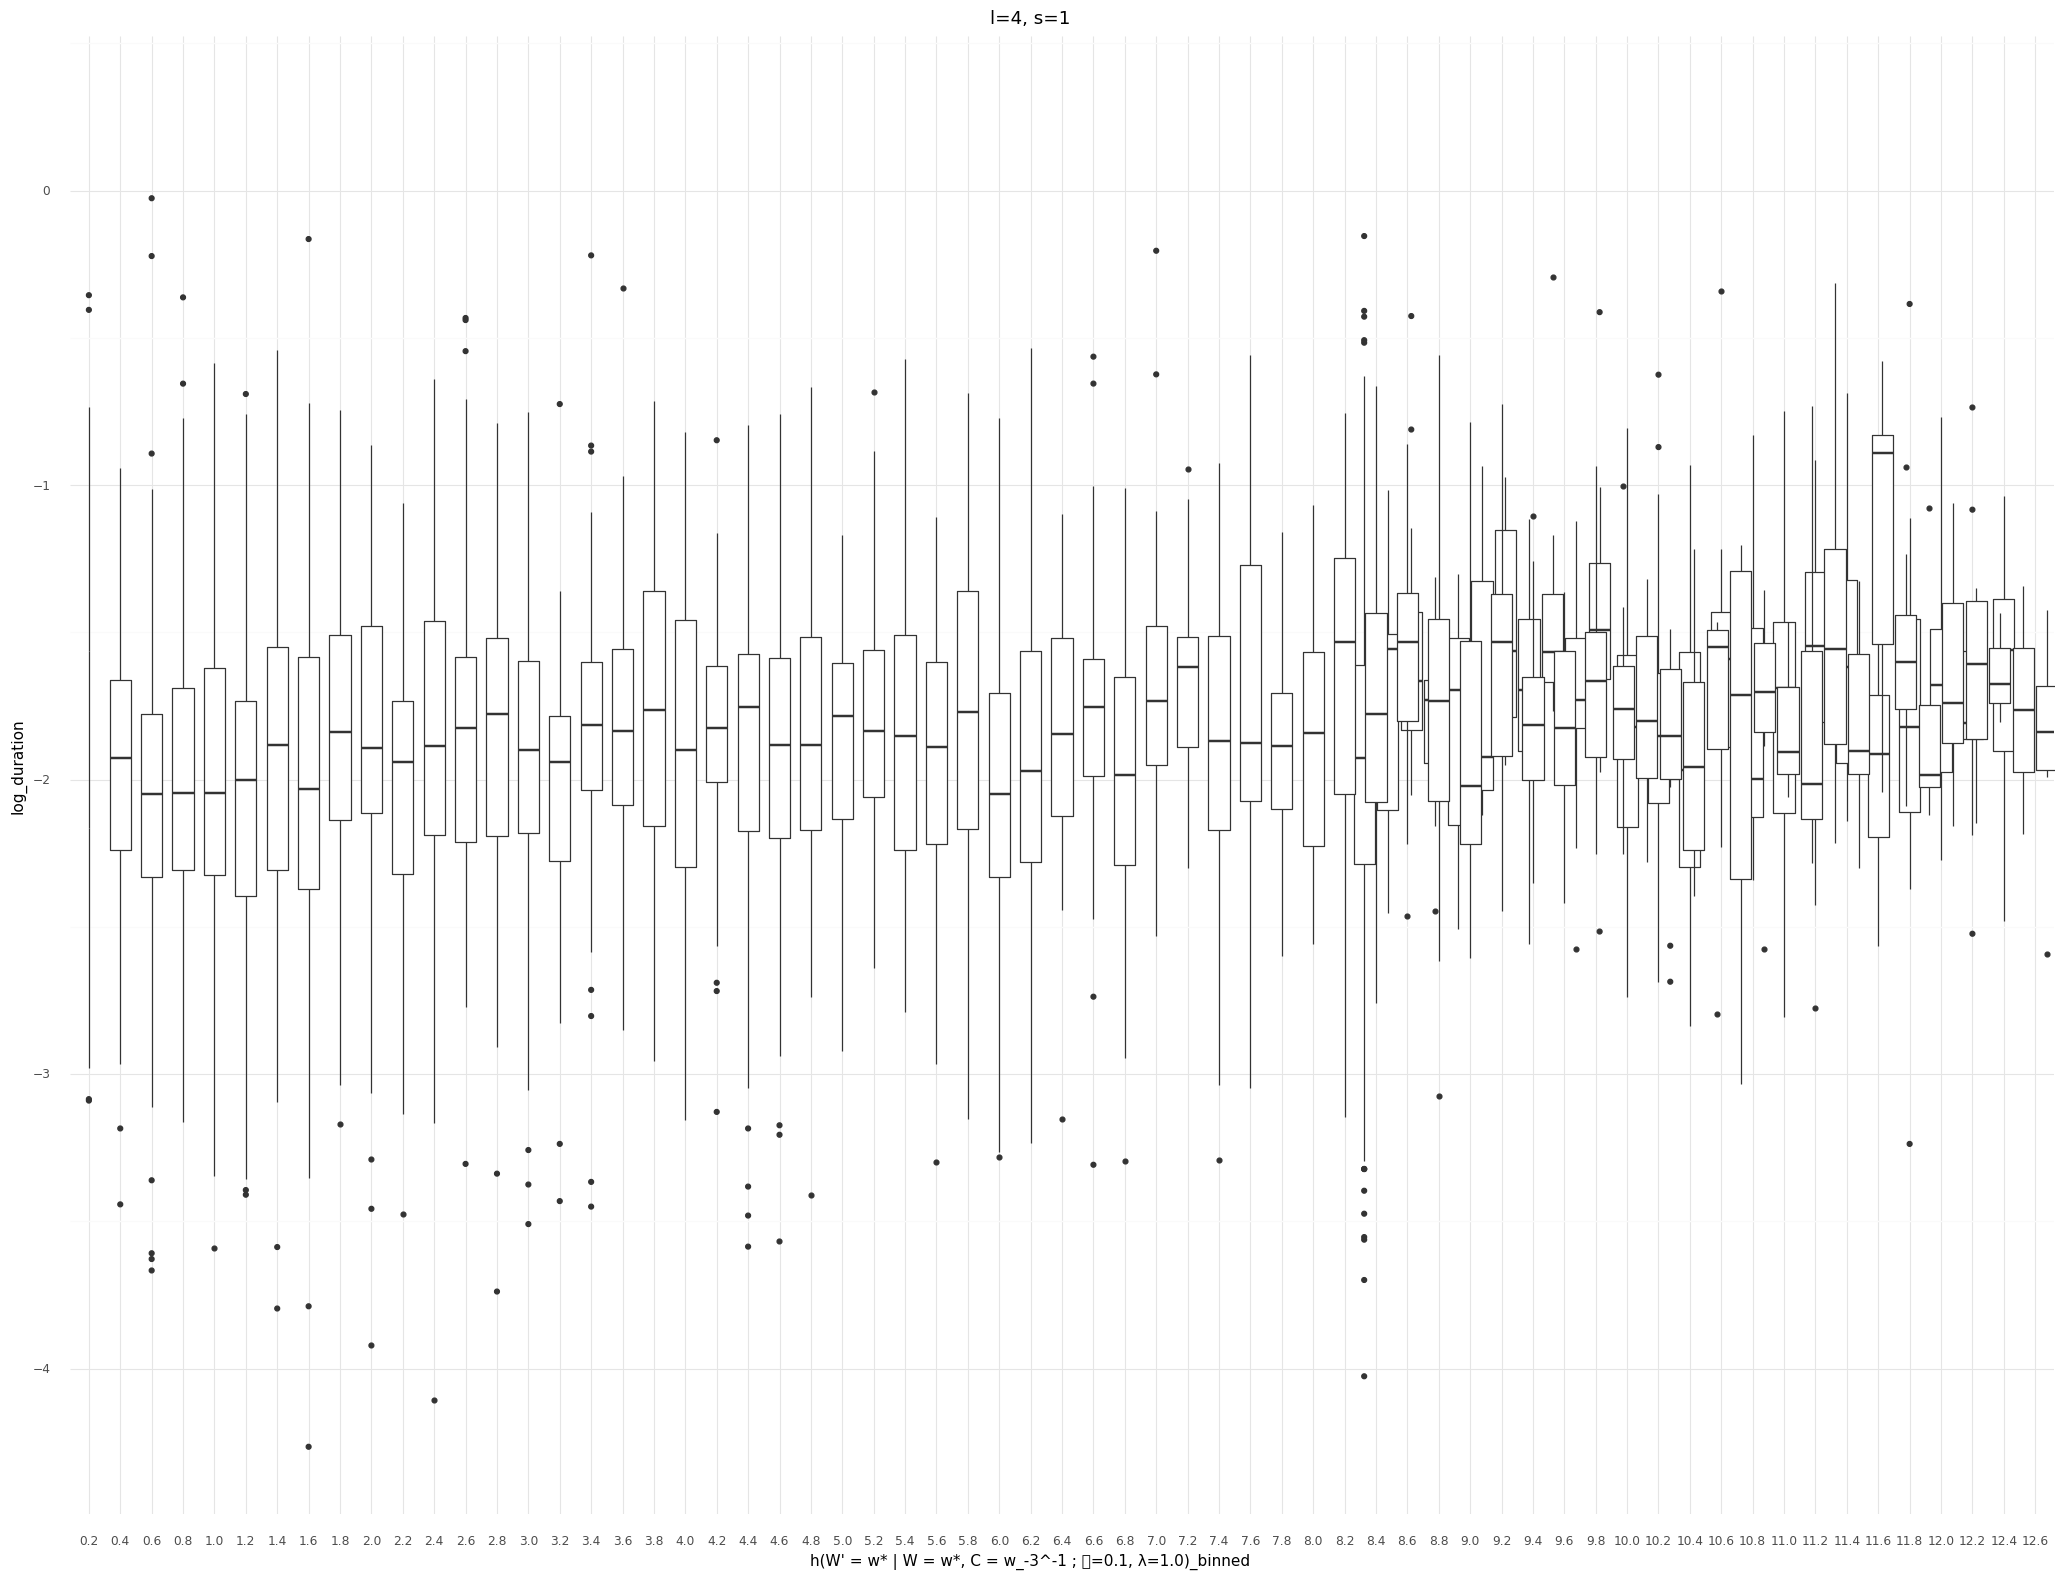

<ggplot: (8779367354357)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=1, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=1, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


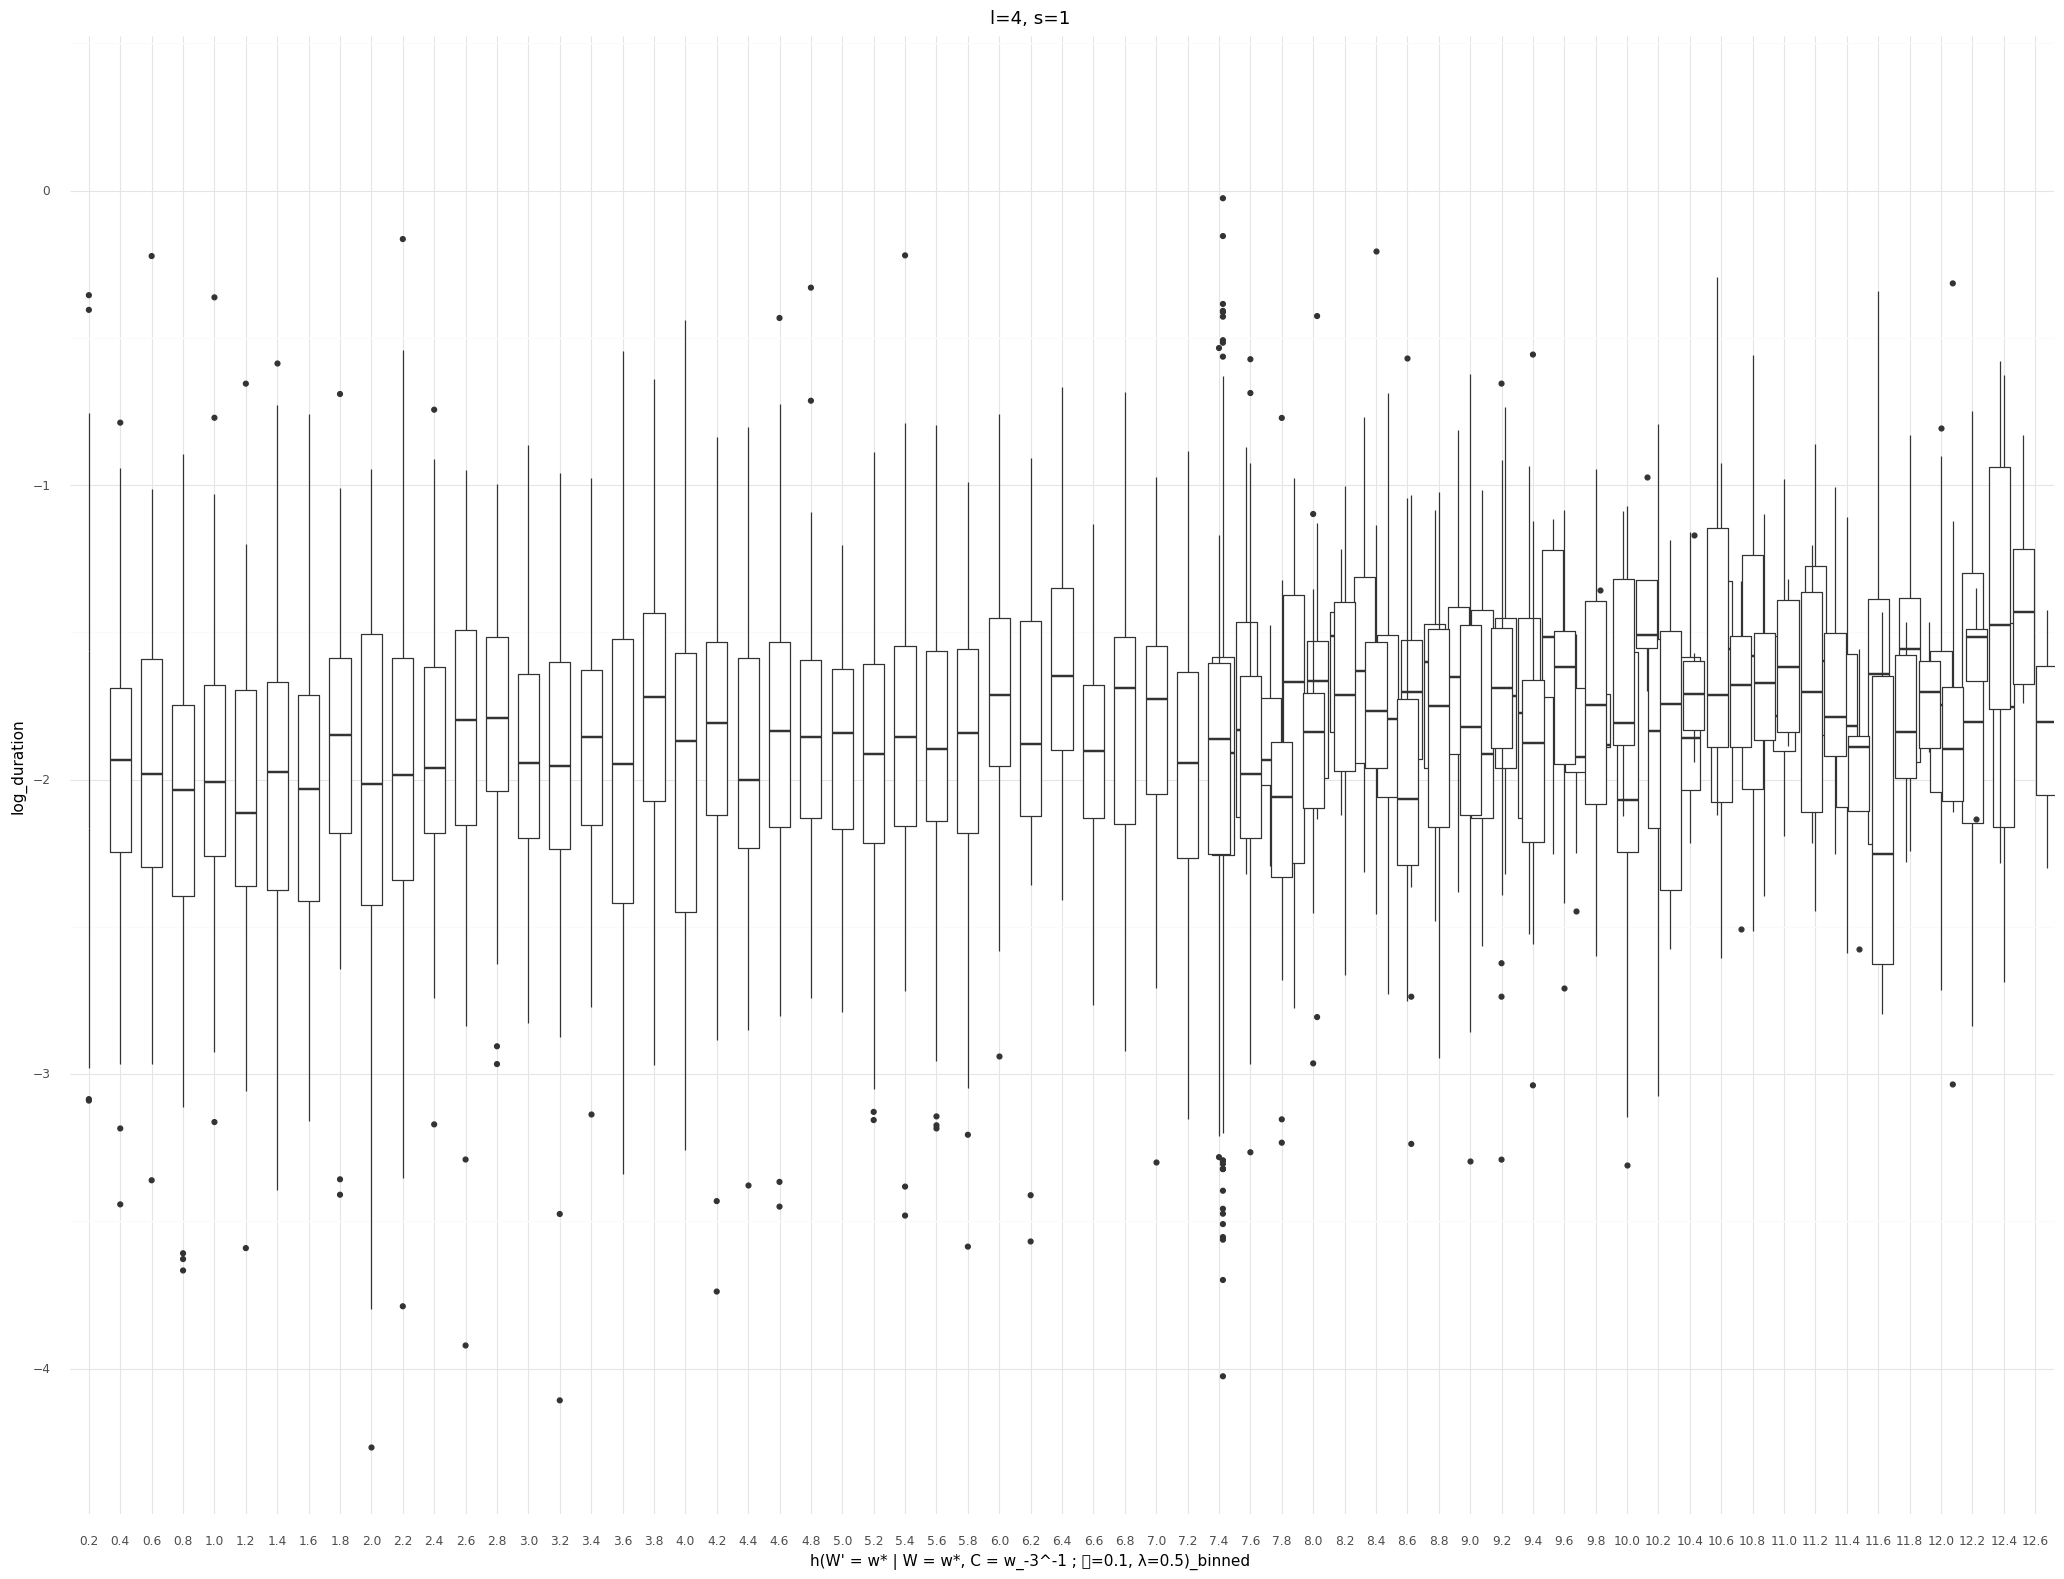

<ggplot: (8779401980933)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=1, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=1, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


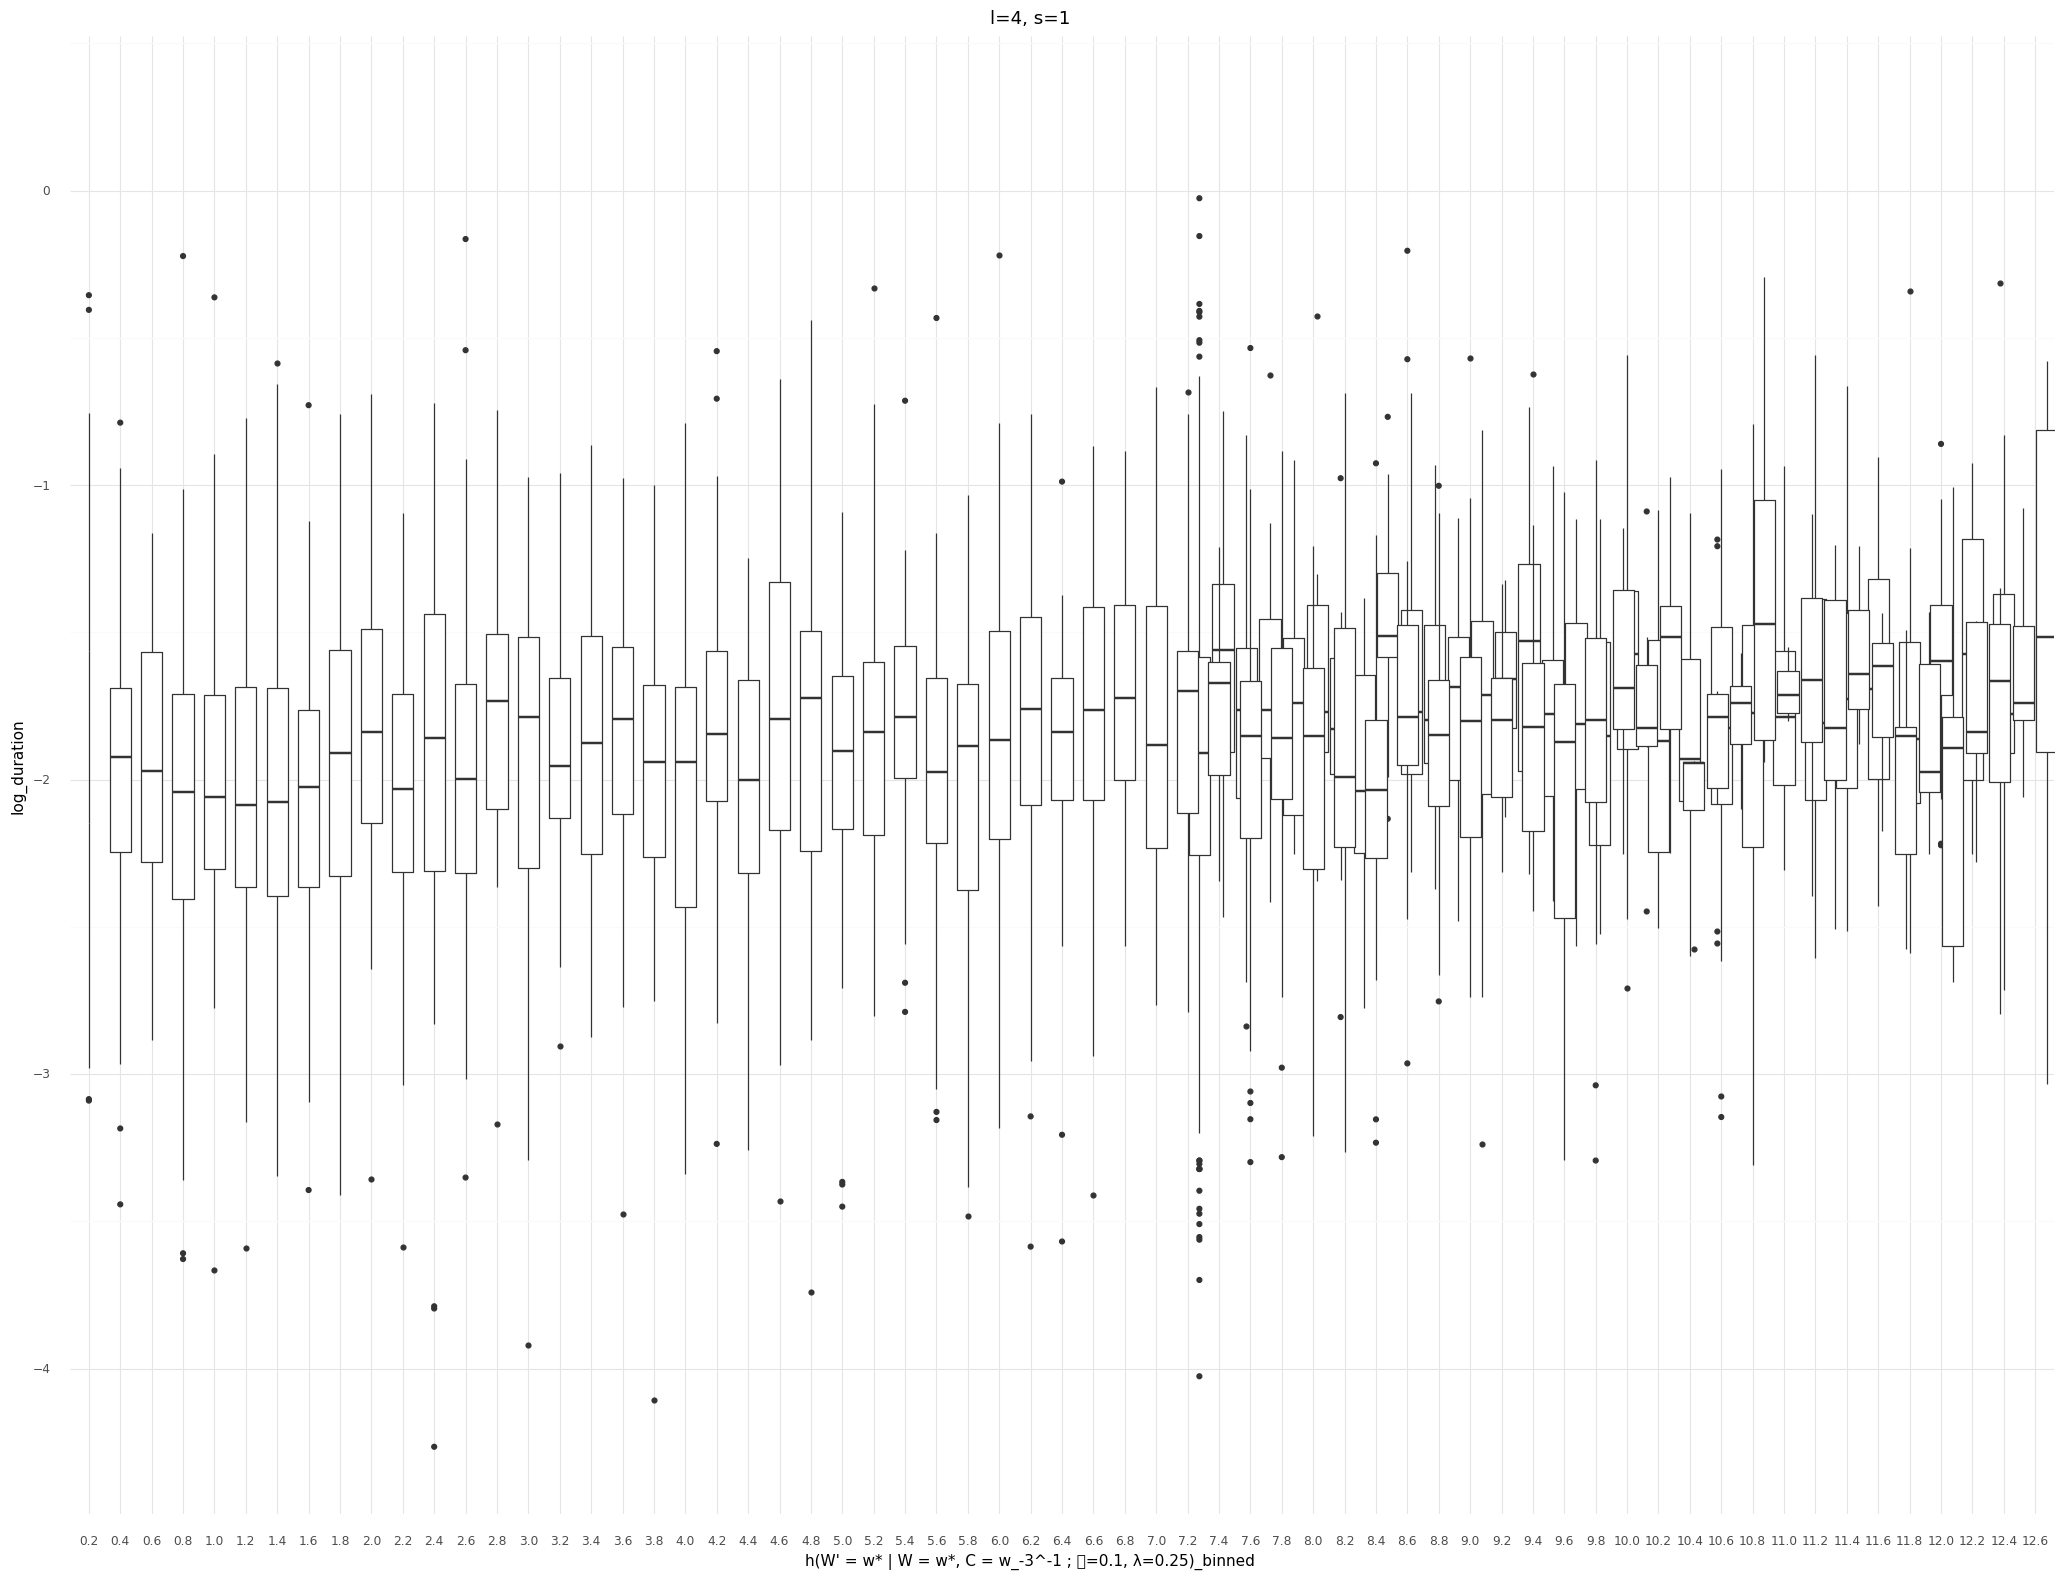

<ggplot: (8779402339285)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=1, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=1, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


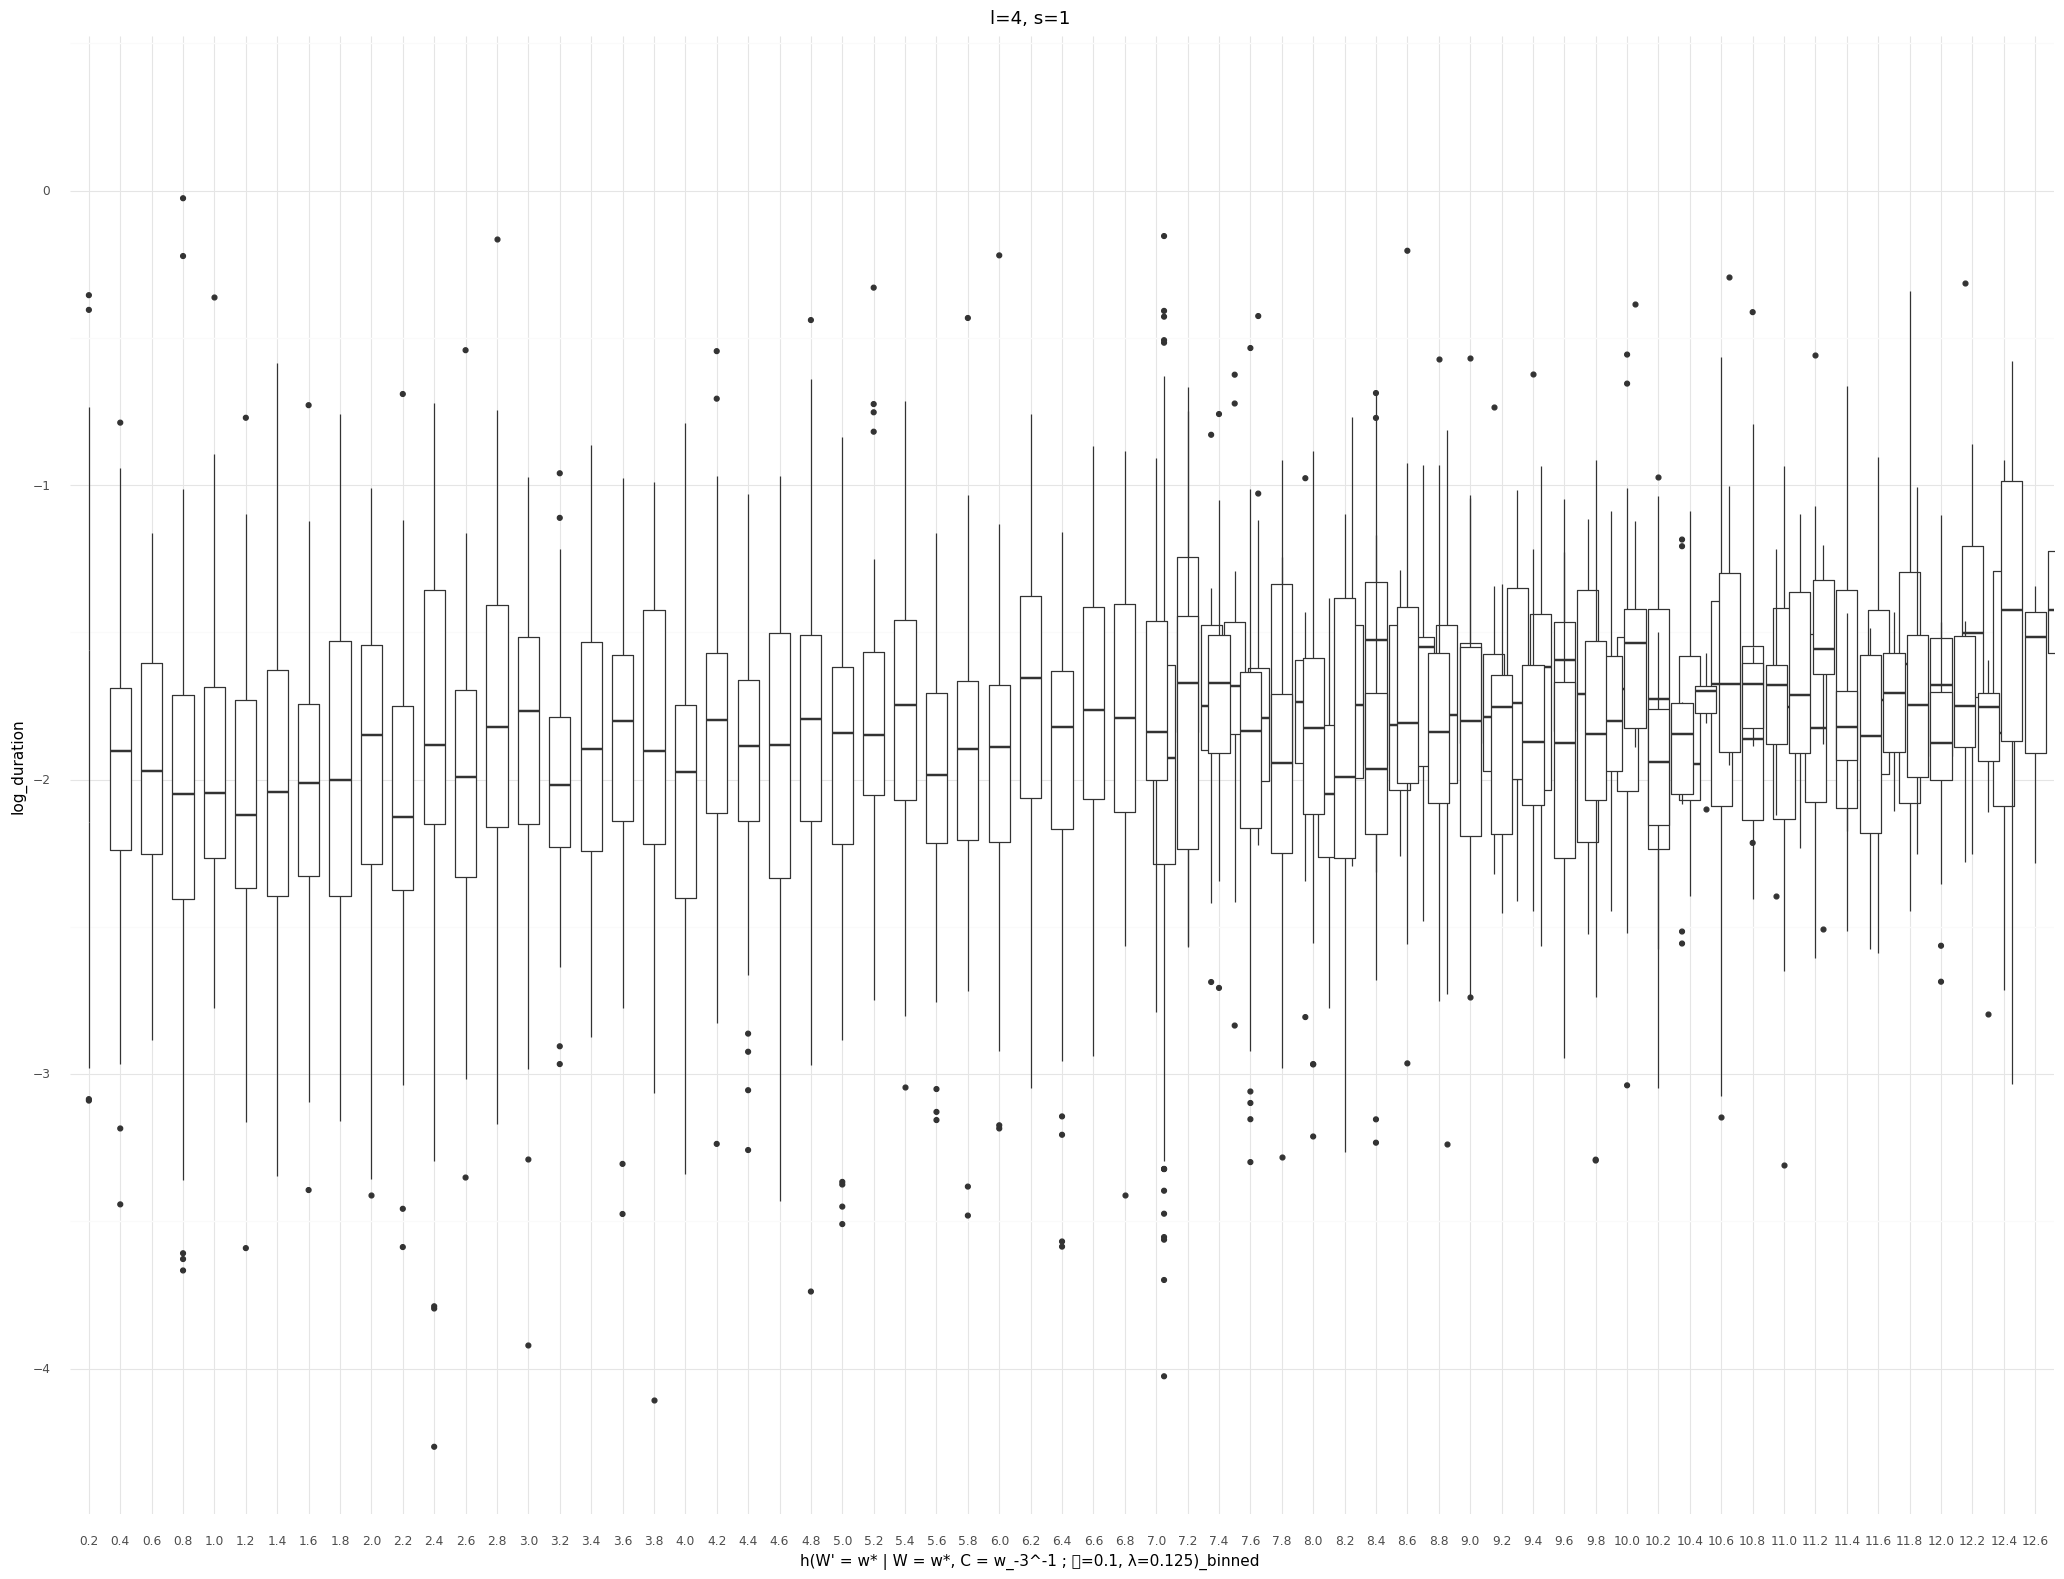

<ggplot: (8779371205585)>

................................................................................
--------------------------------------------------------------------------------


s=1, l=5
	s=1, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=1, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=1, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


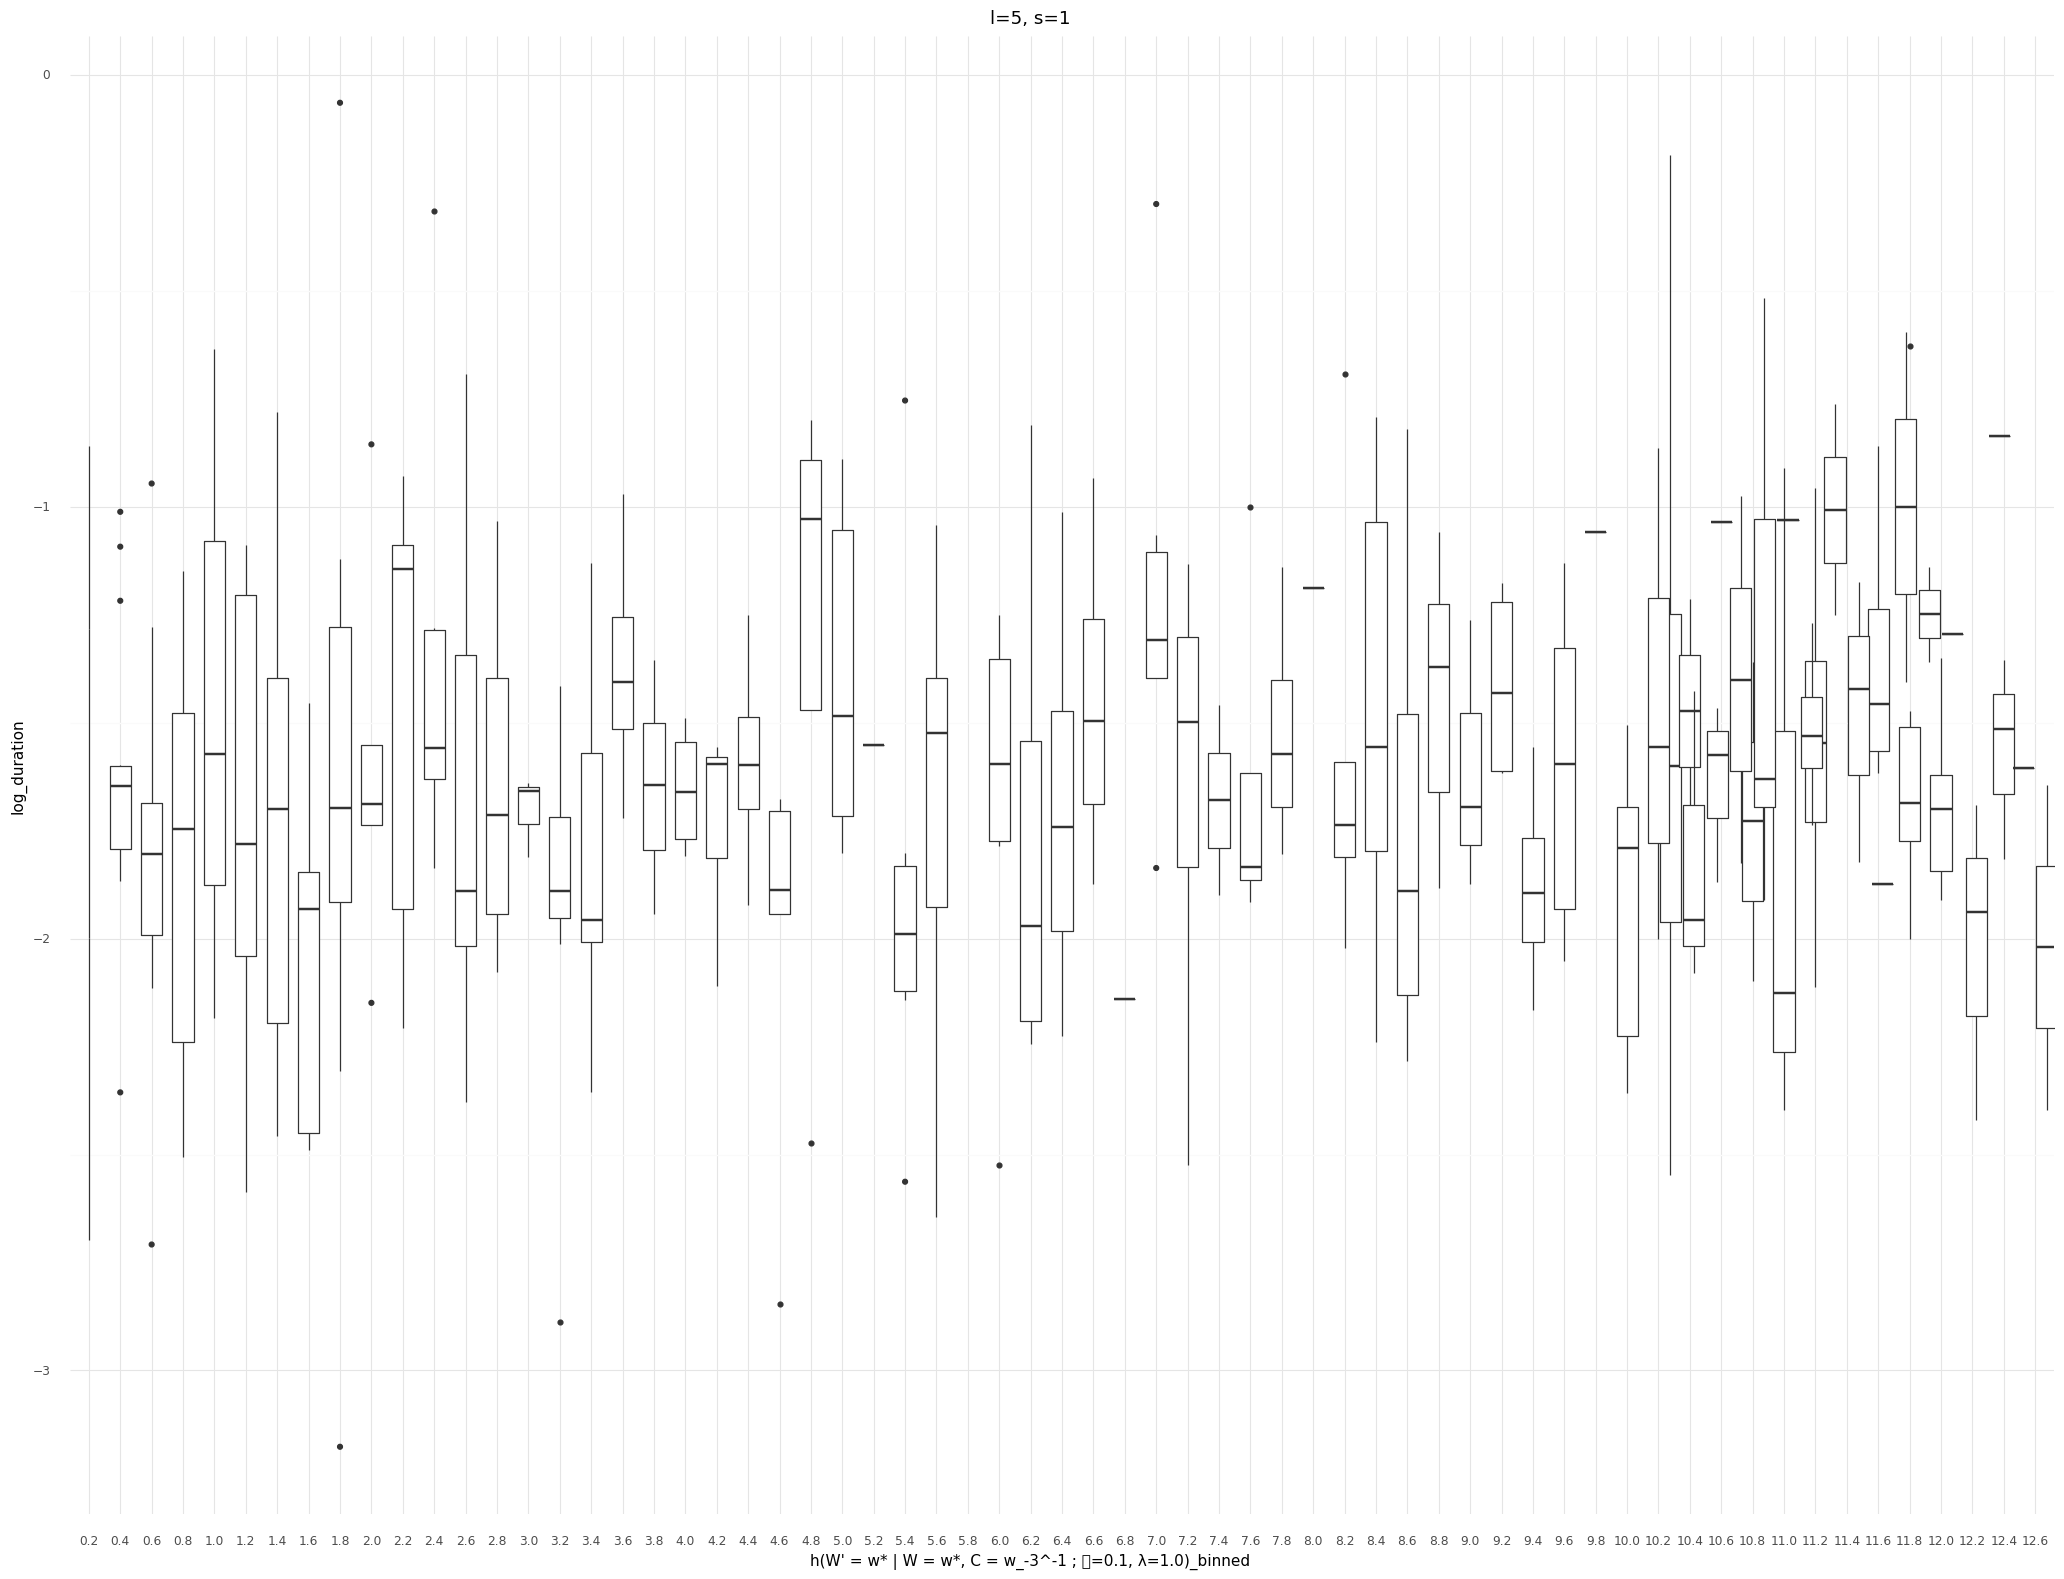

<ggplot: (8779401977321)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=1, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=1, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


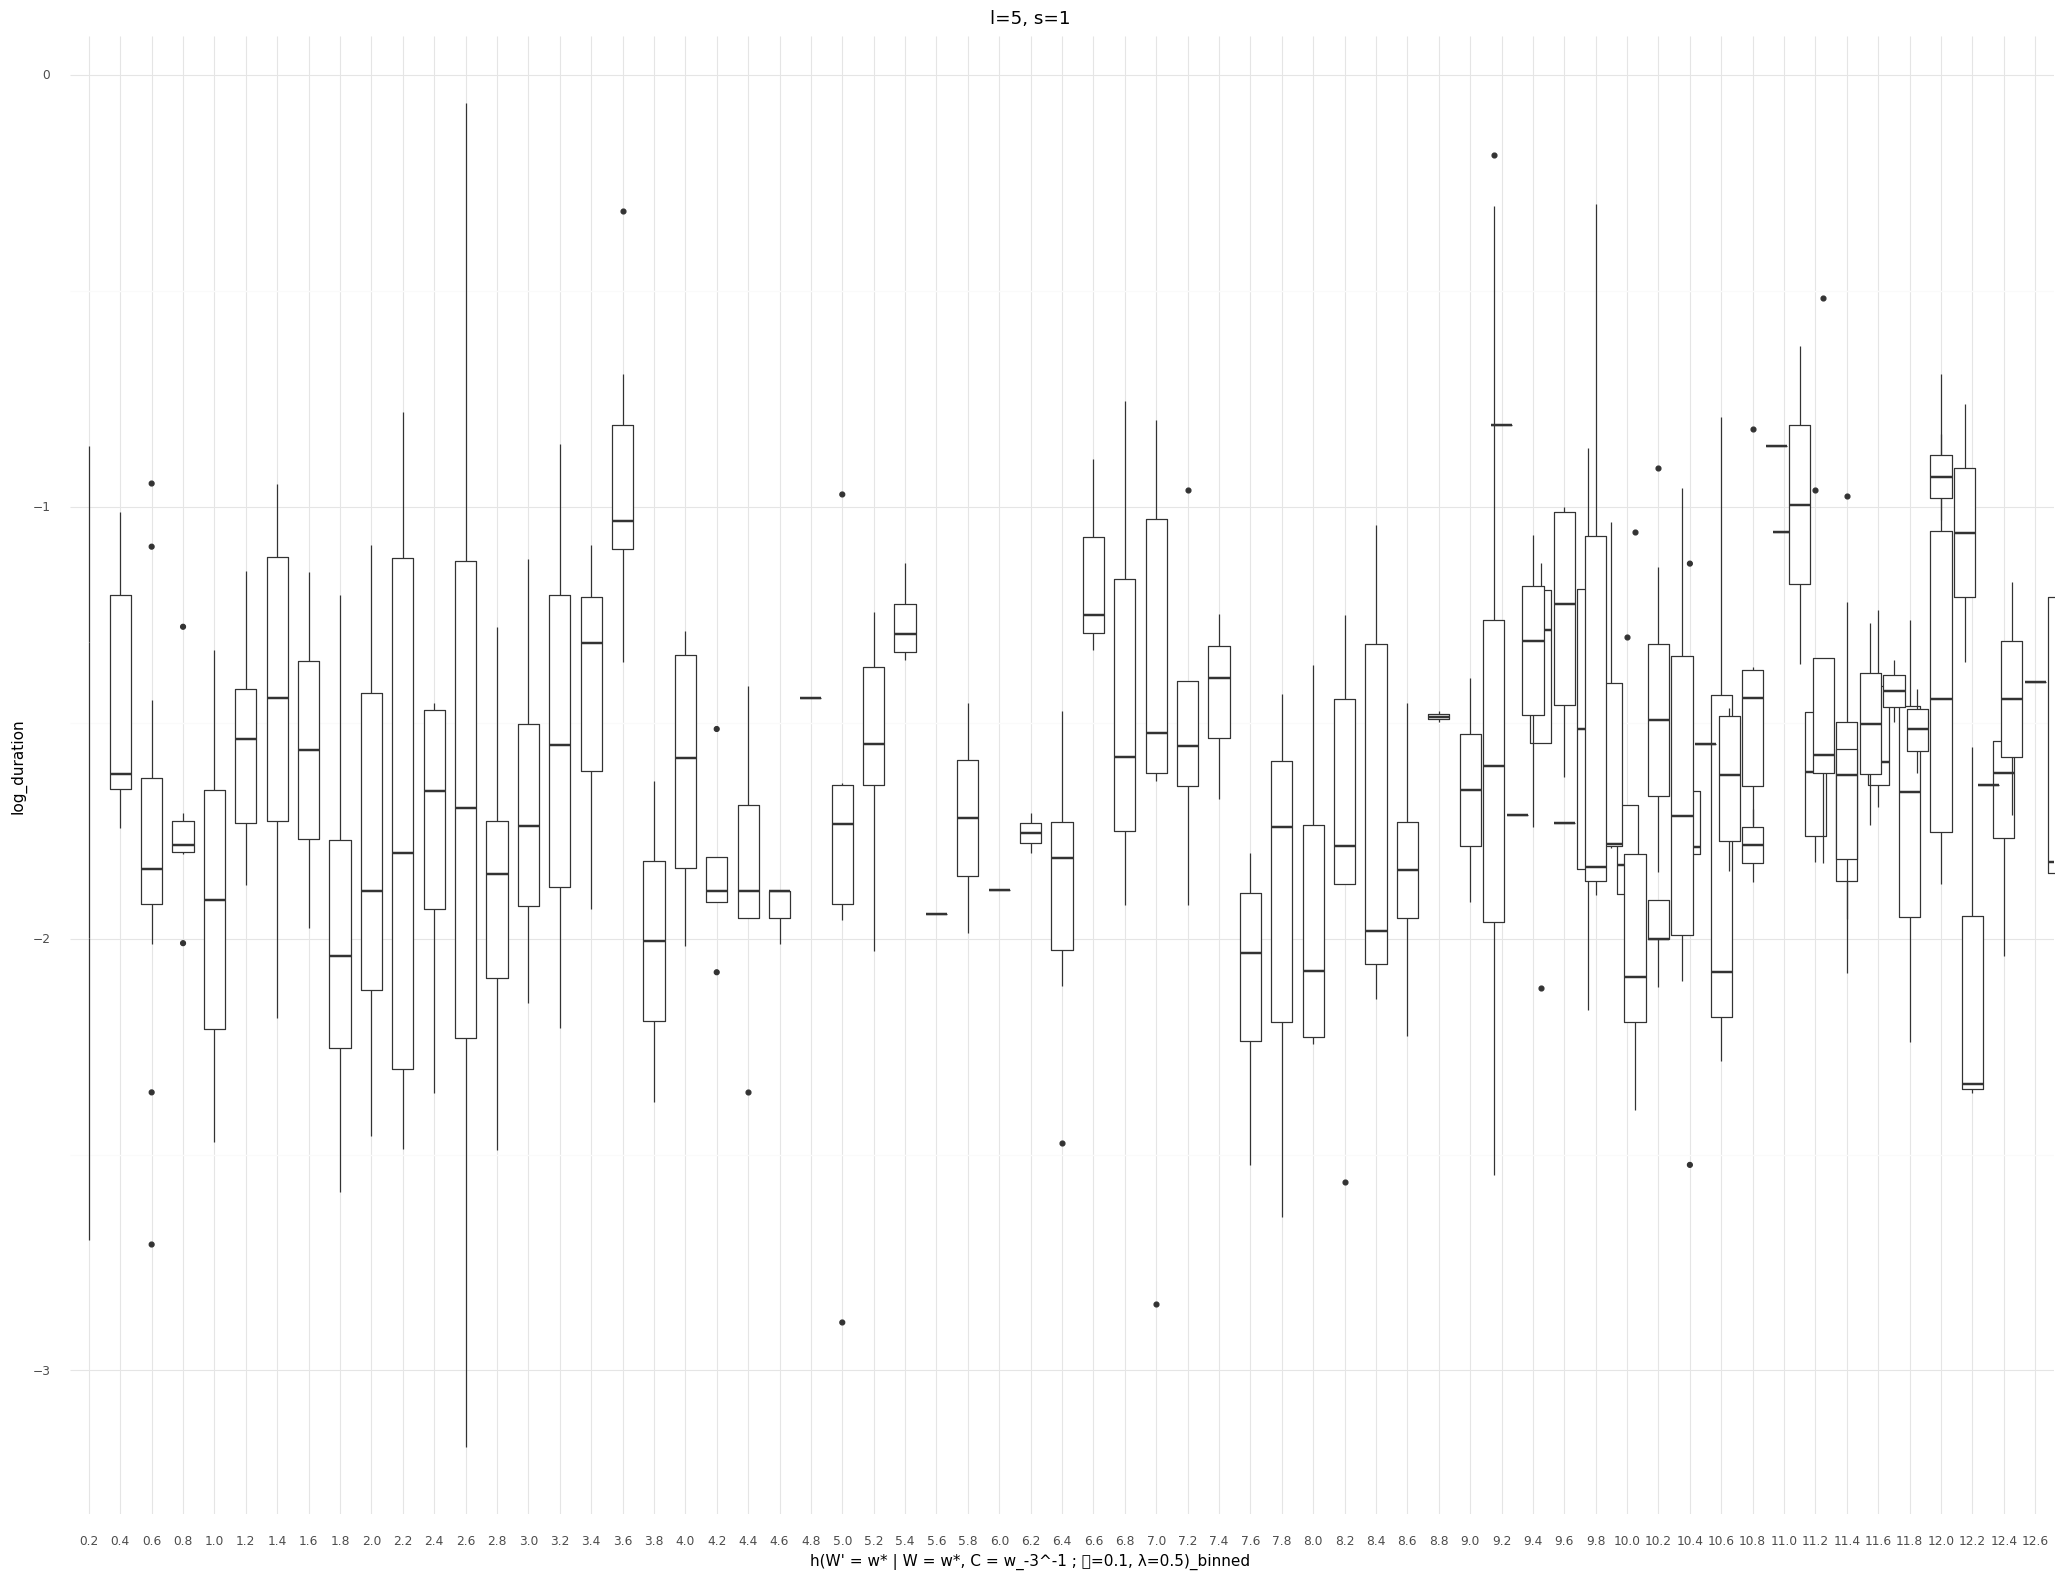

<ggplot: (8779452192177)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=1, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=1, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


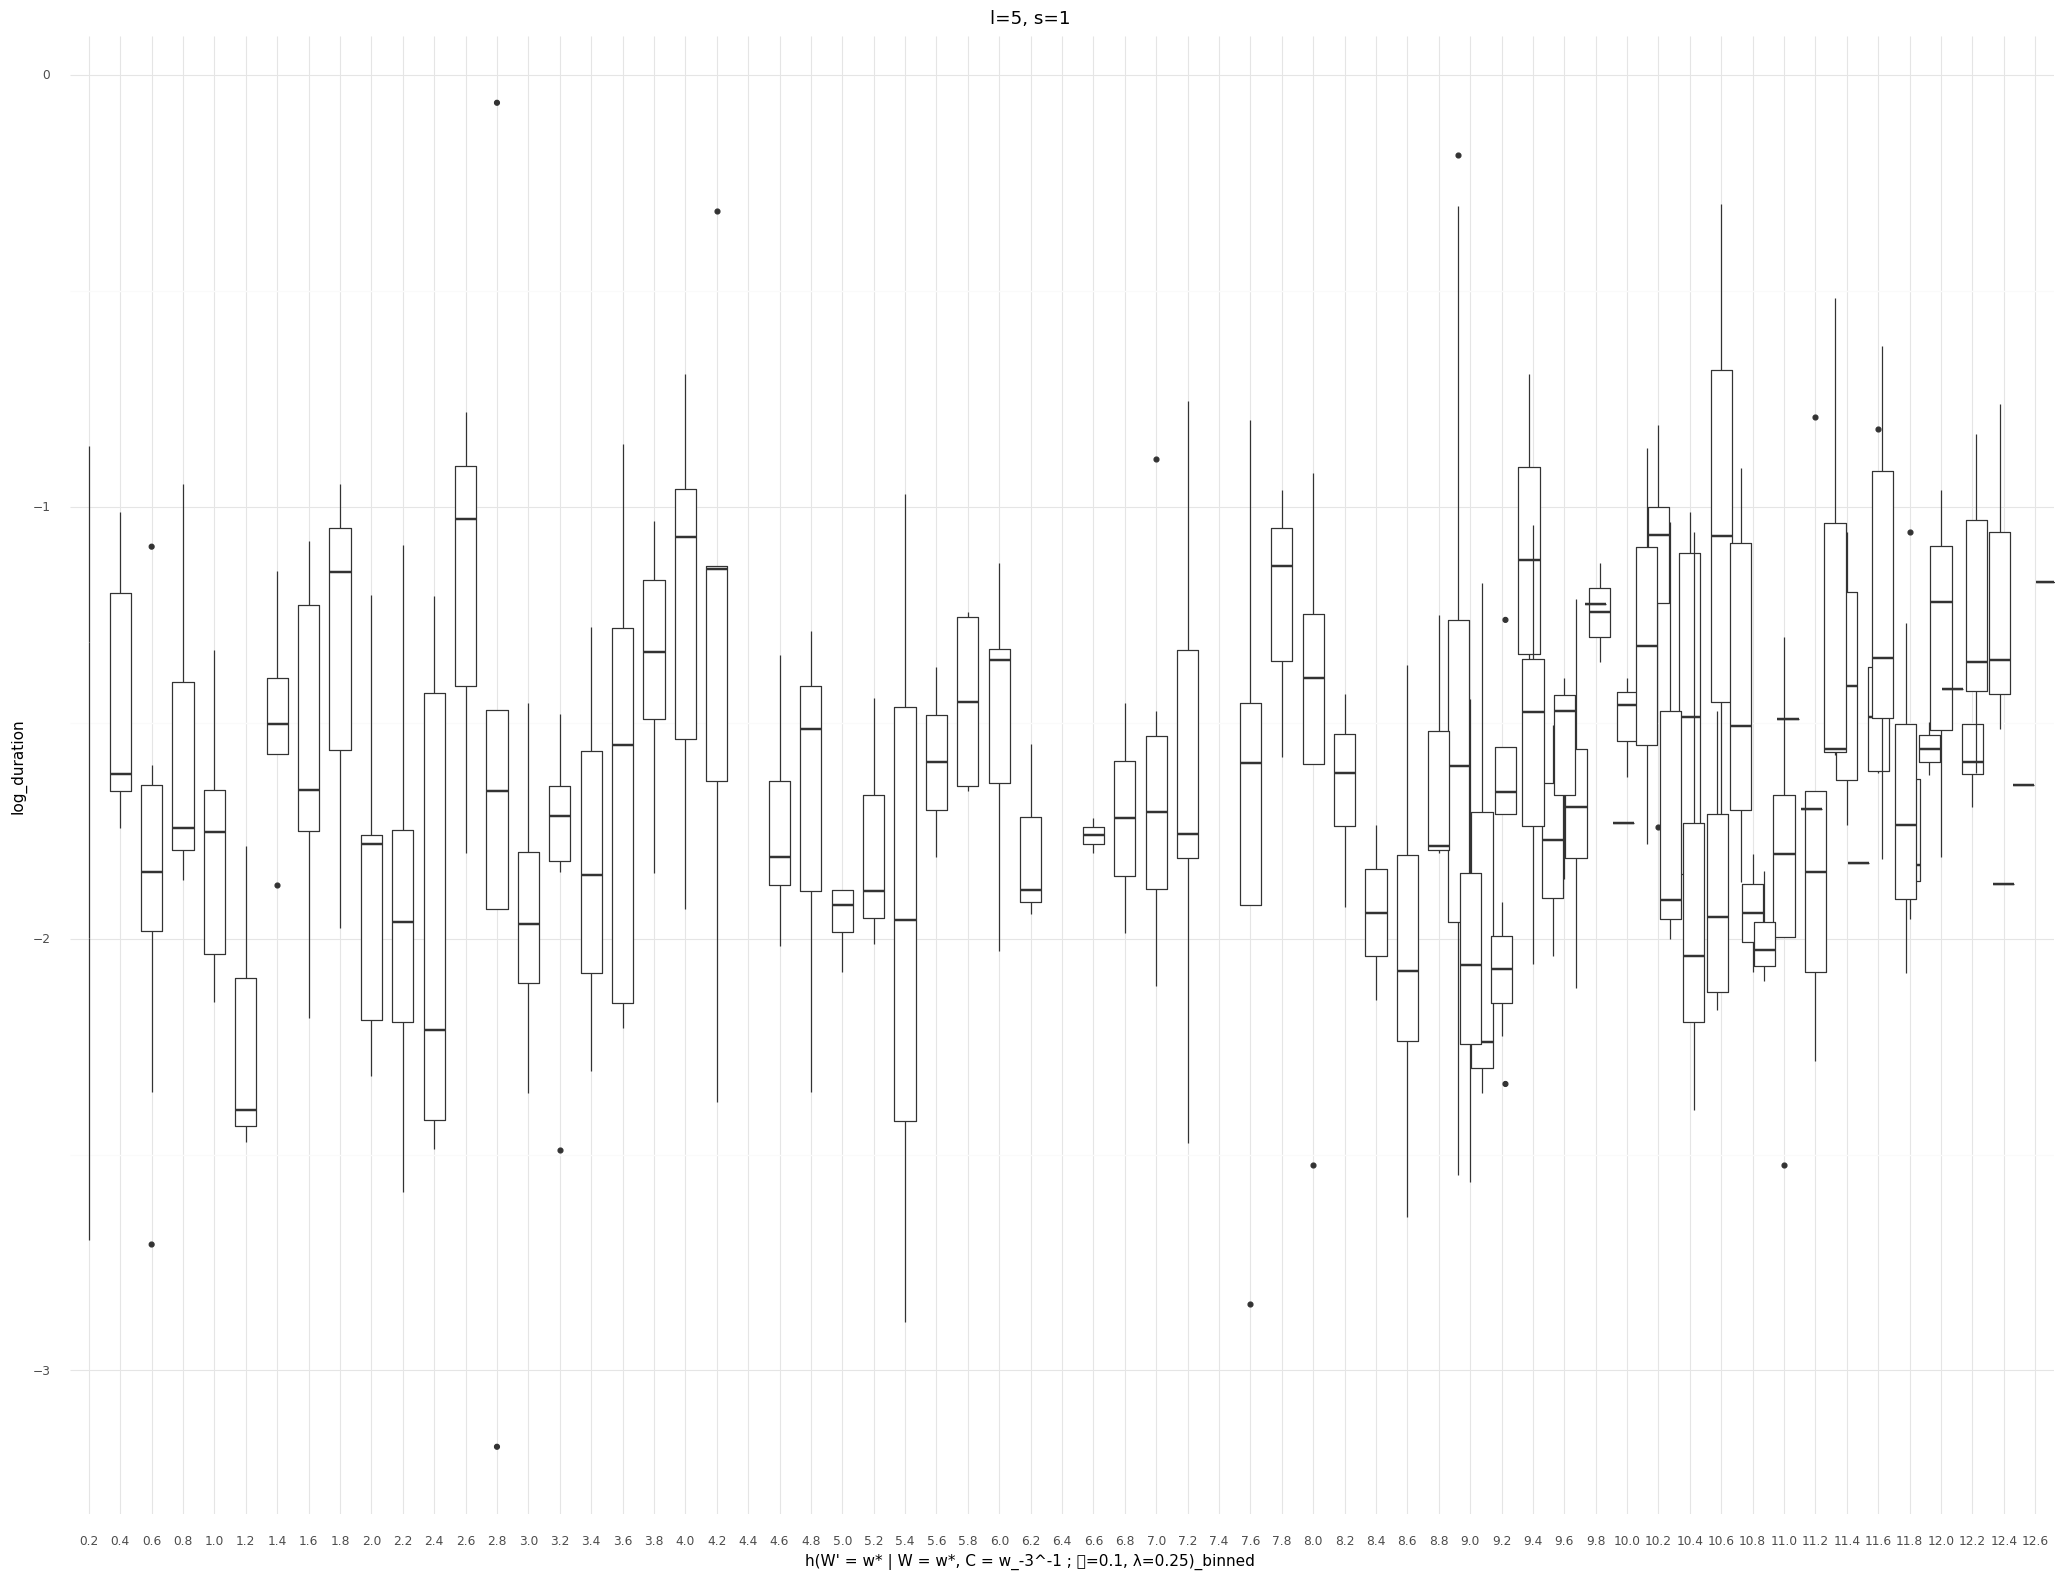

<ggplot: (8779395334933)>

................................................................................
--------------------------------------------------------------------------------
	s=1, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=1, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=1, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


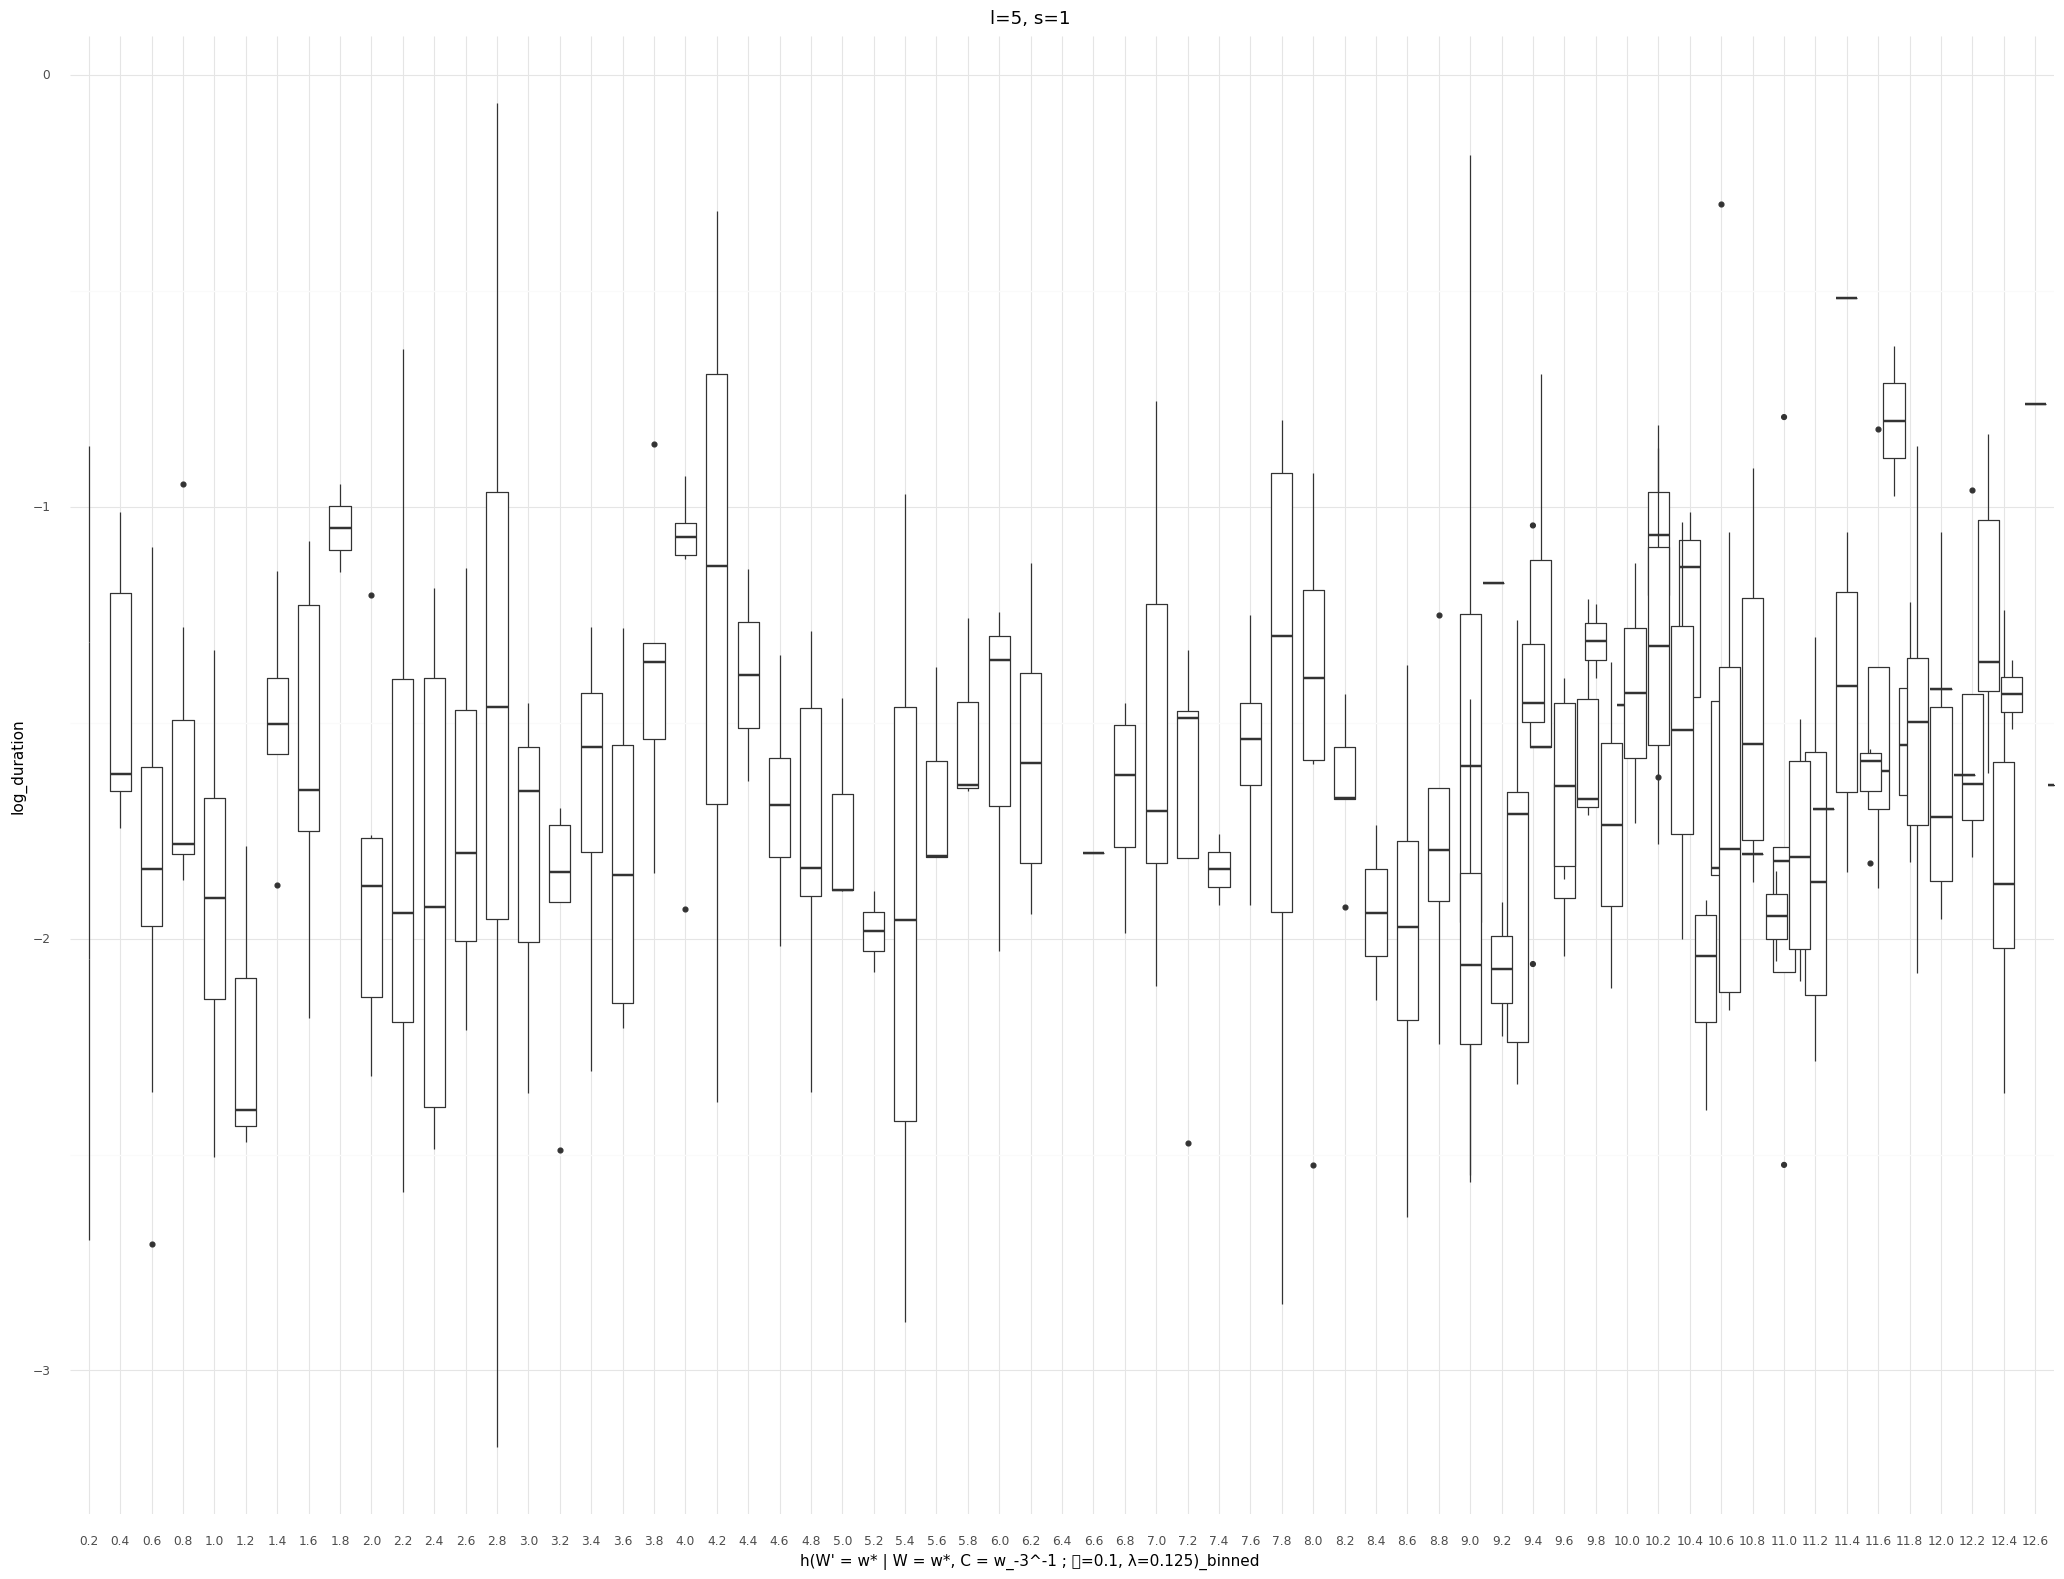

<ggplot: (8779359689549)>

................................................................................
--------------------------------------------------------------------------------


s=2, l=4
	s=2, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=2, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=2, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


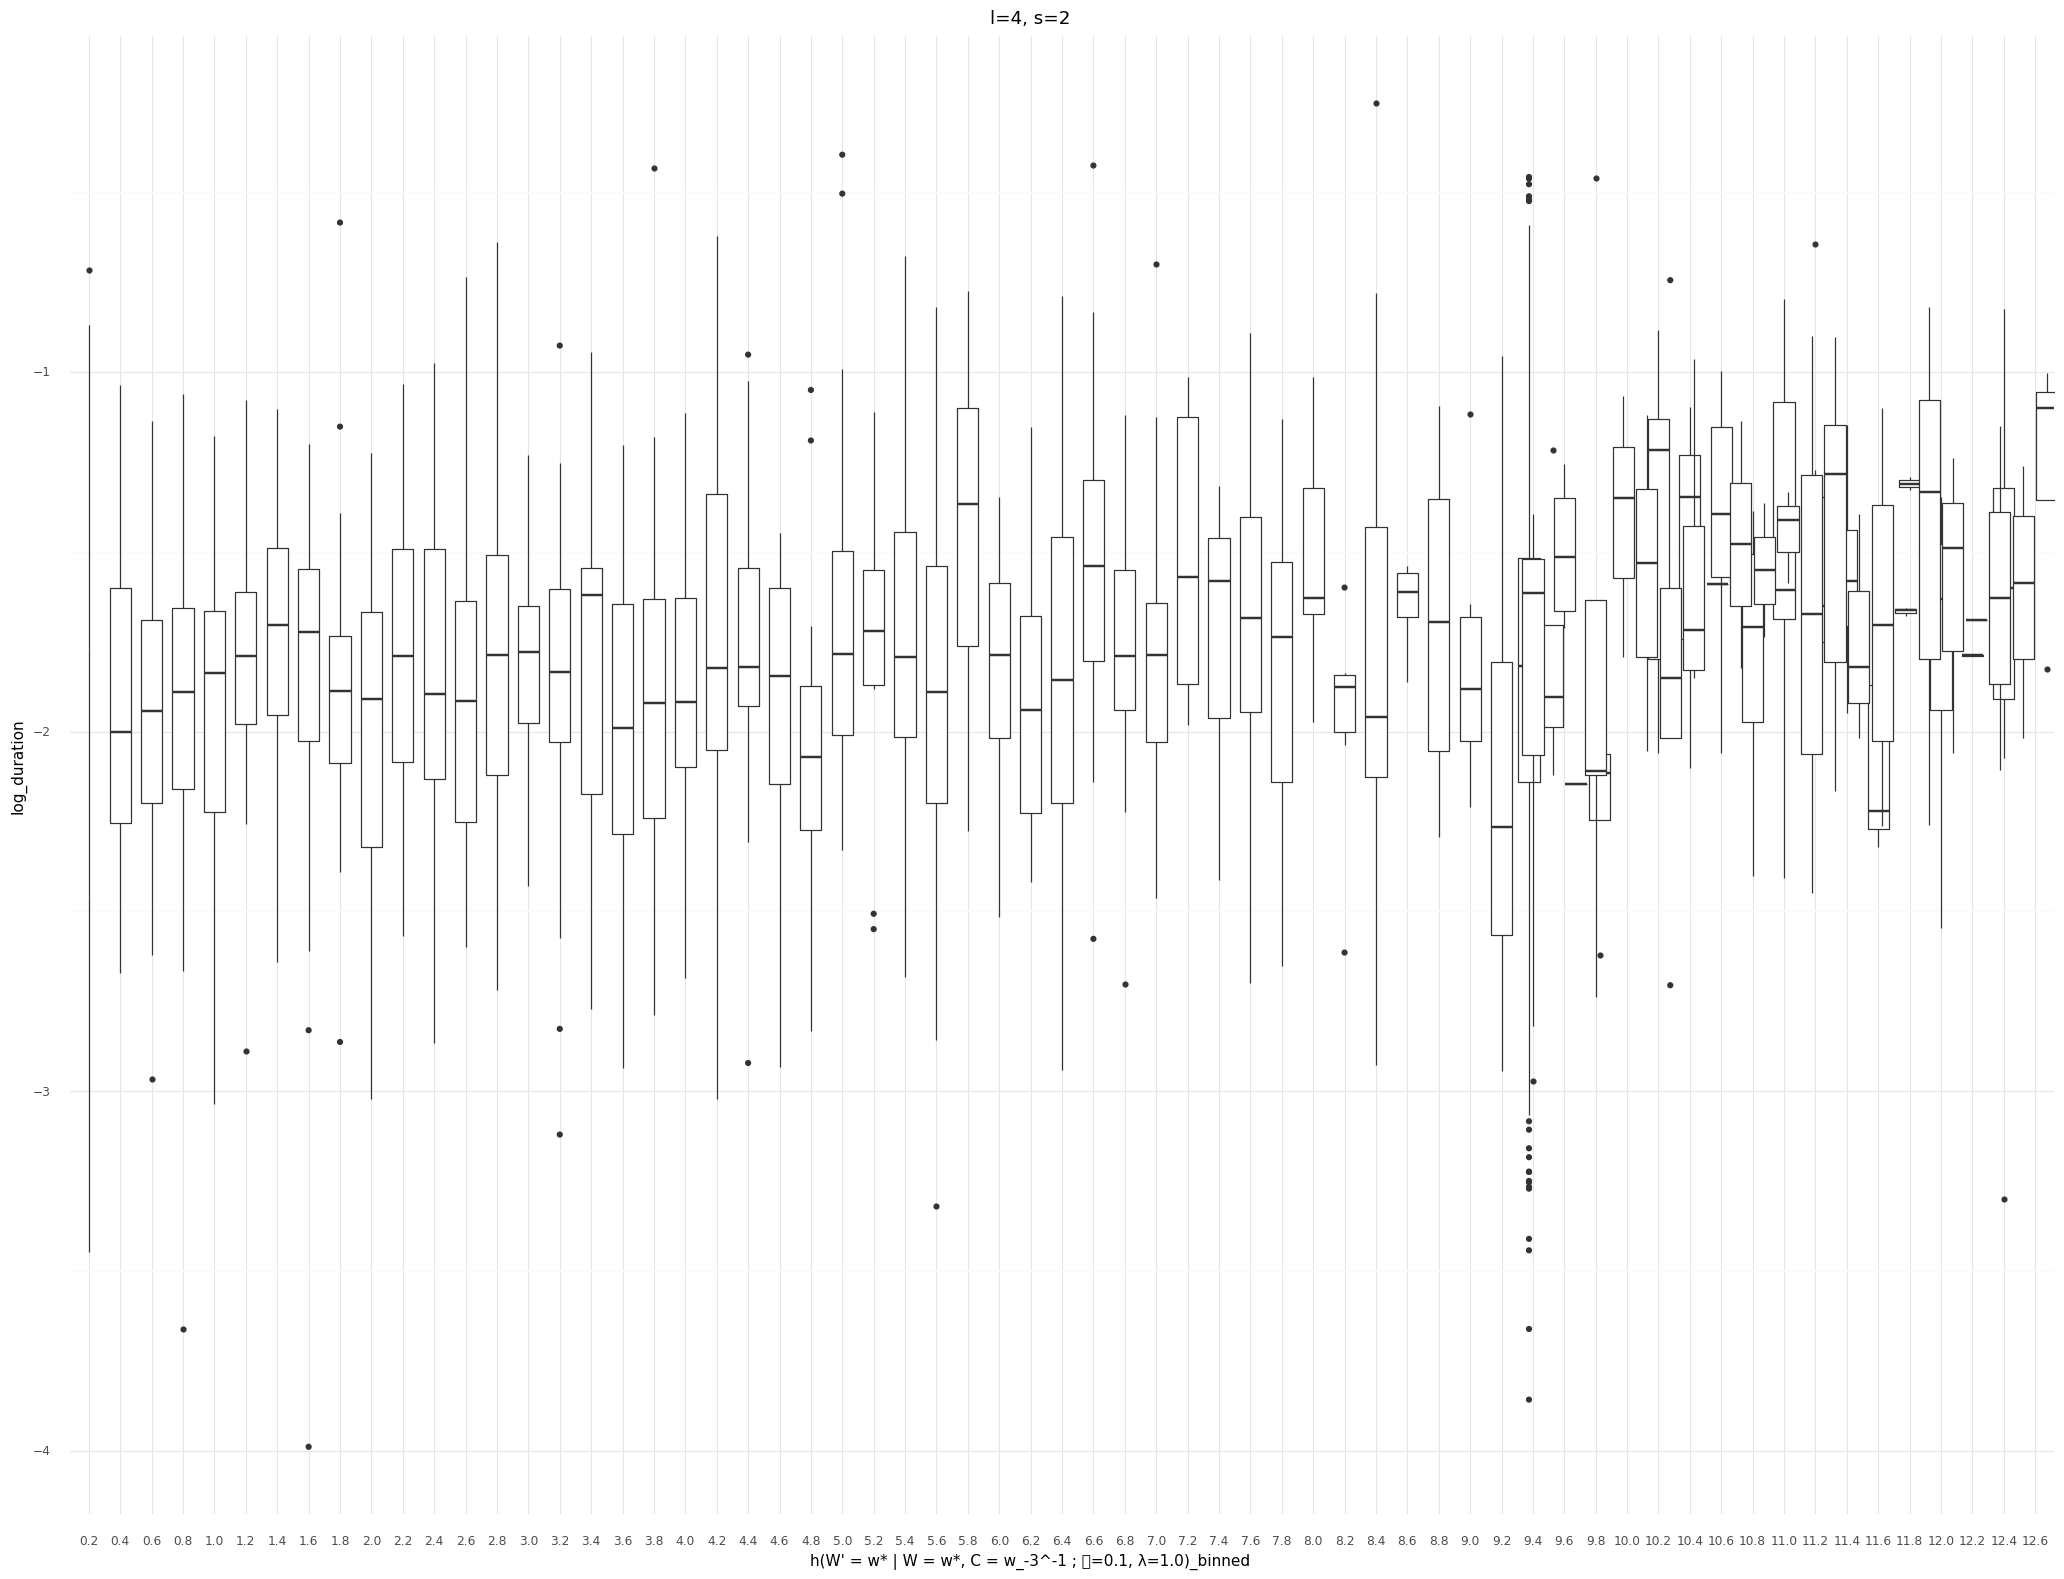

<ggplot: (8779277260365)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=2, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=2, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


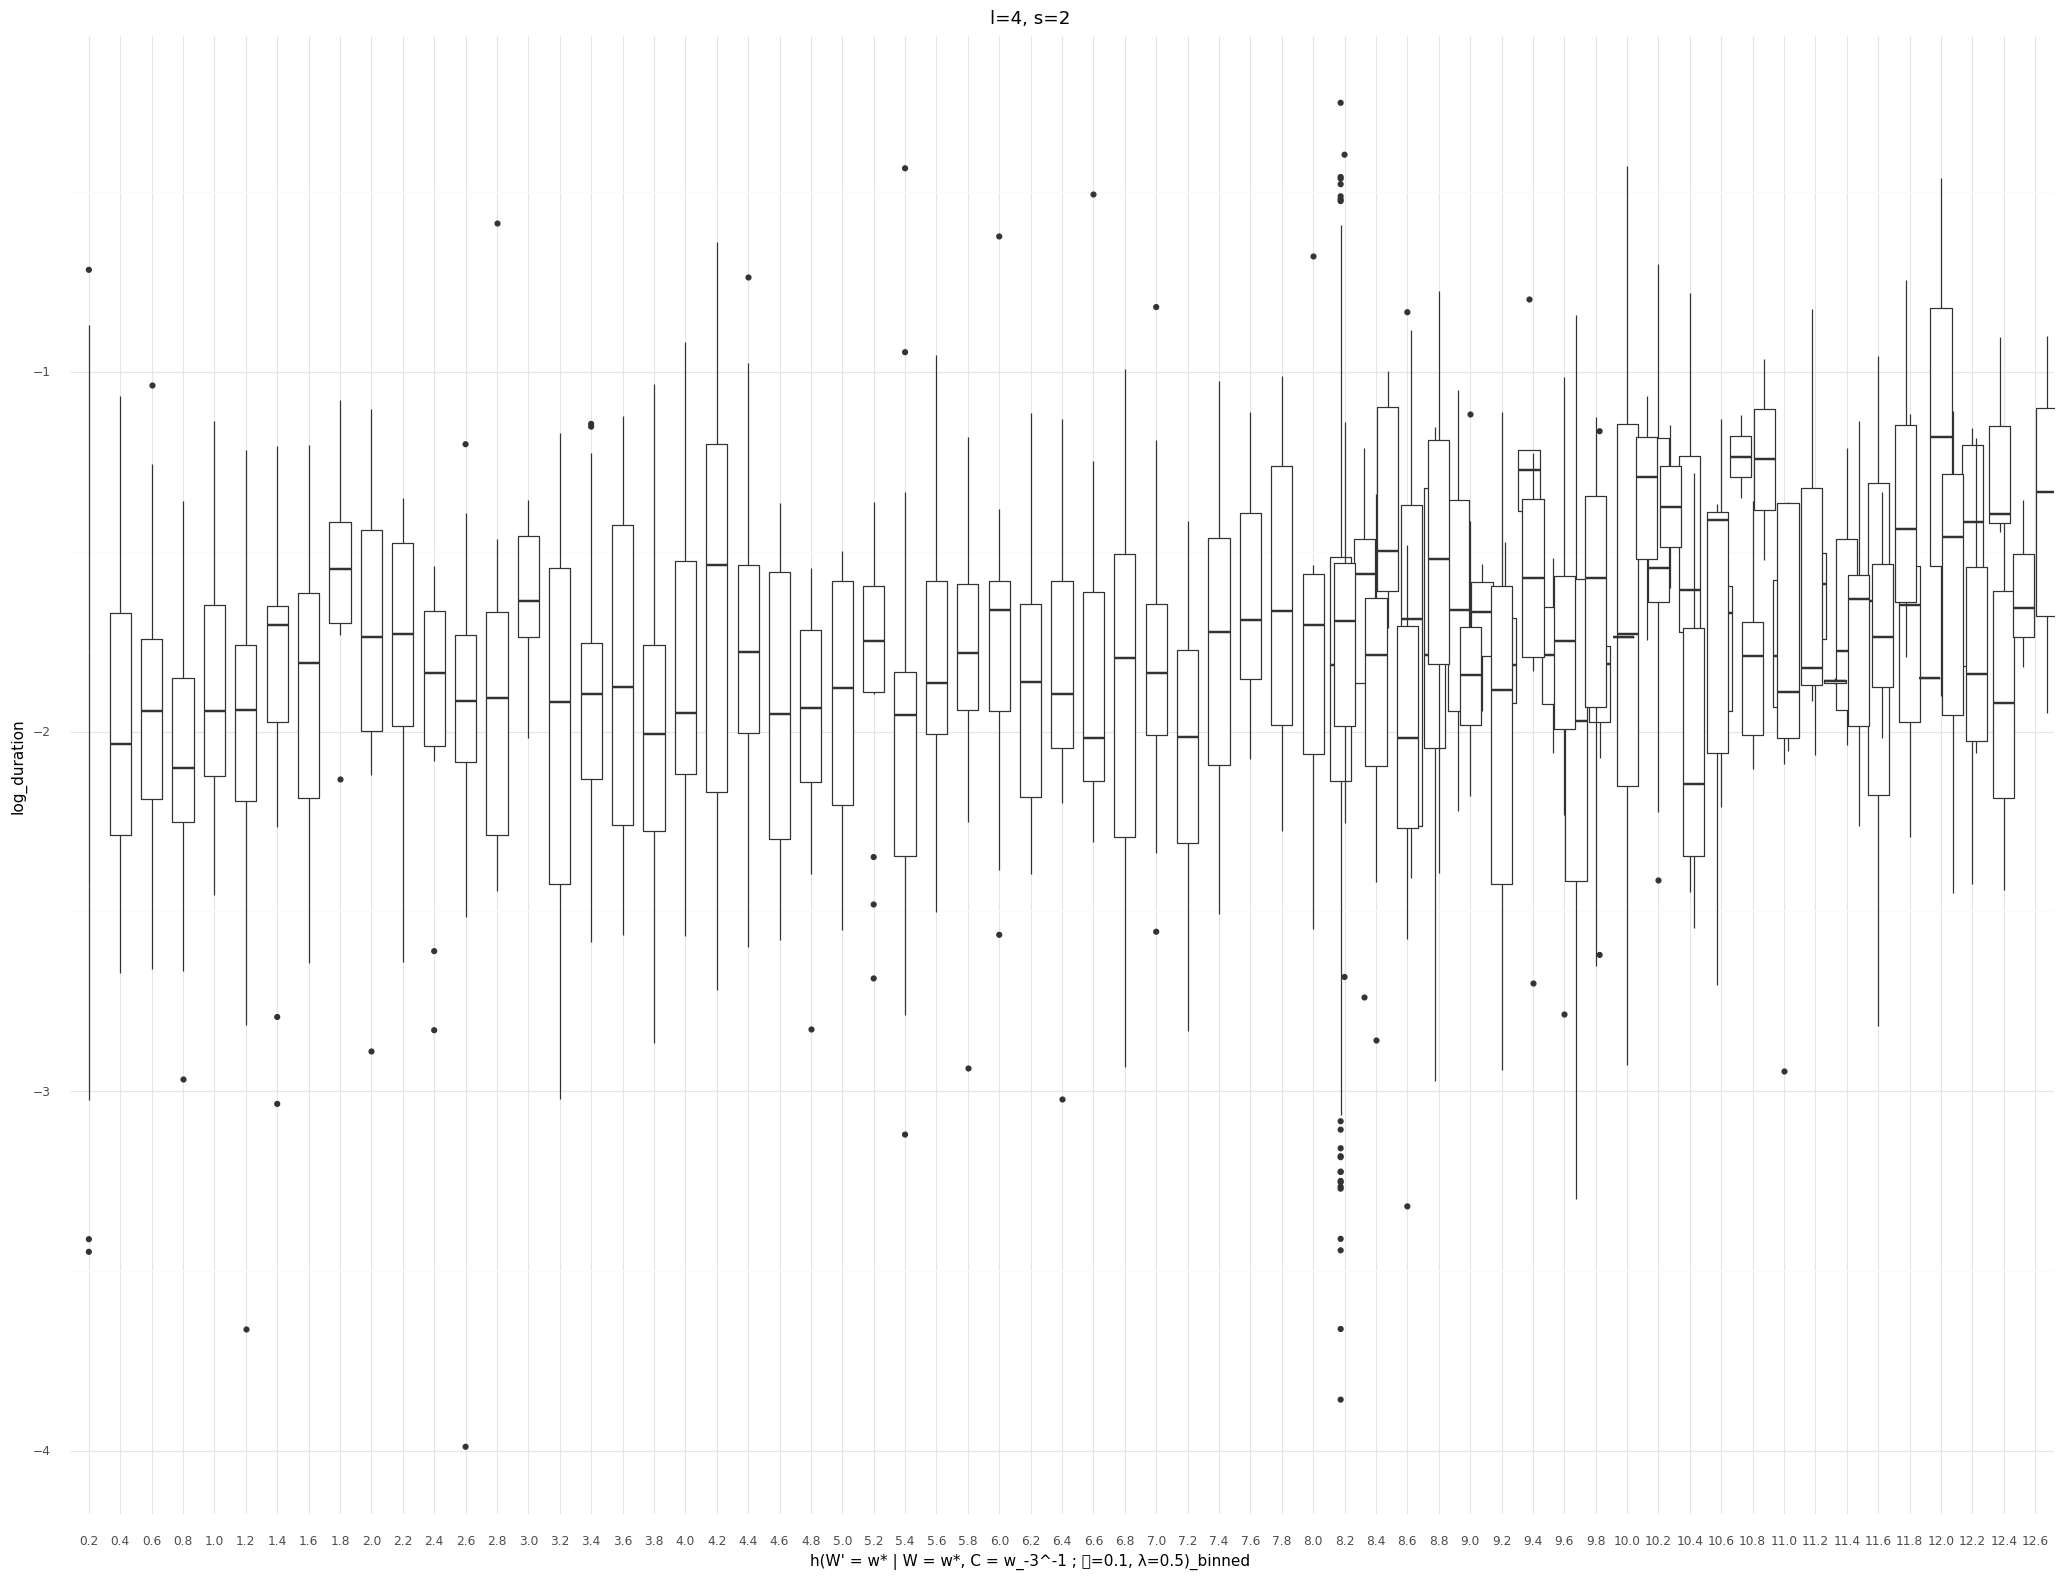

<ggplot: (8779411166709)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=2, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=2, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


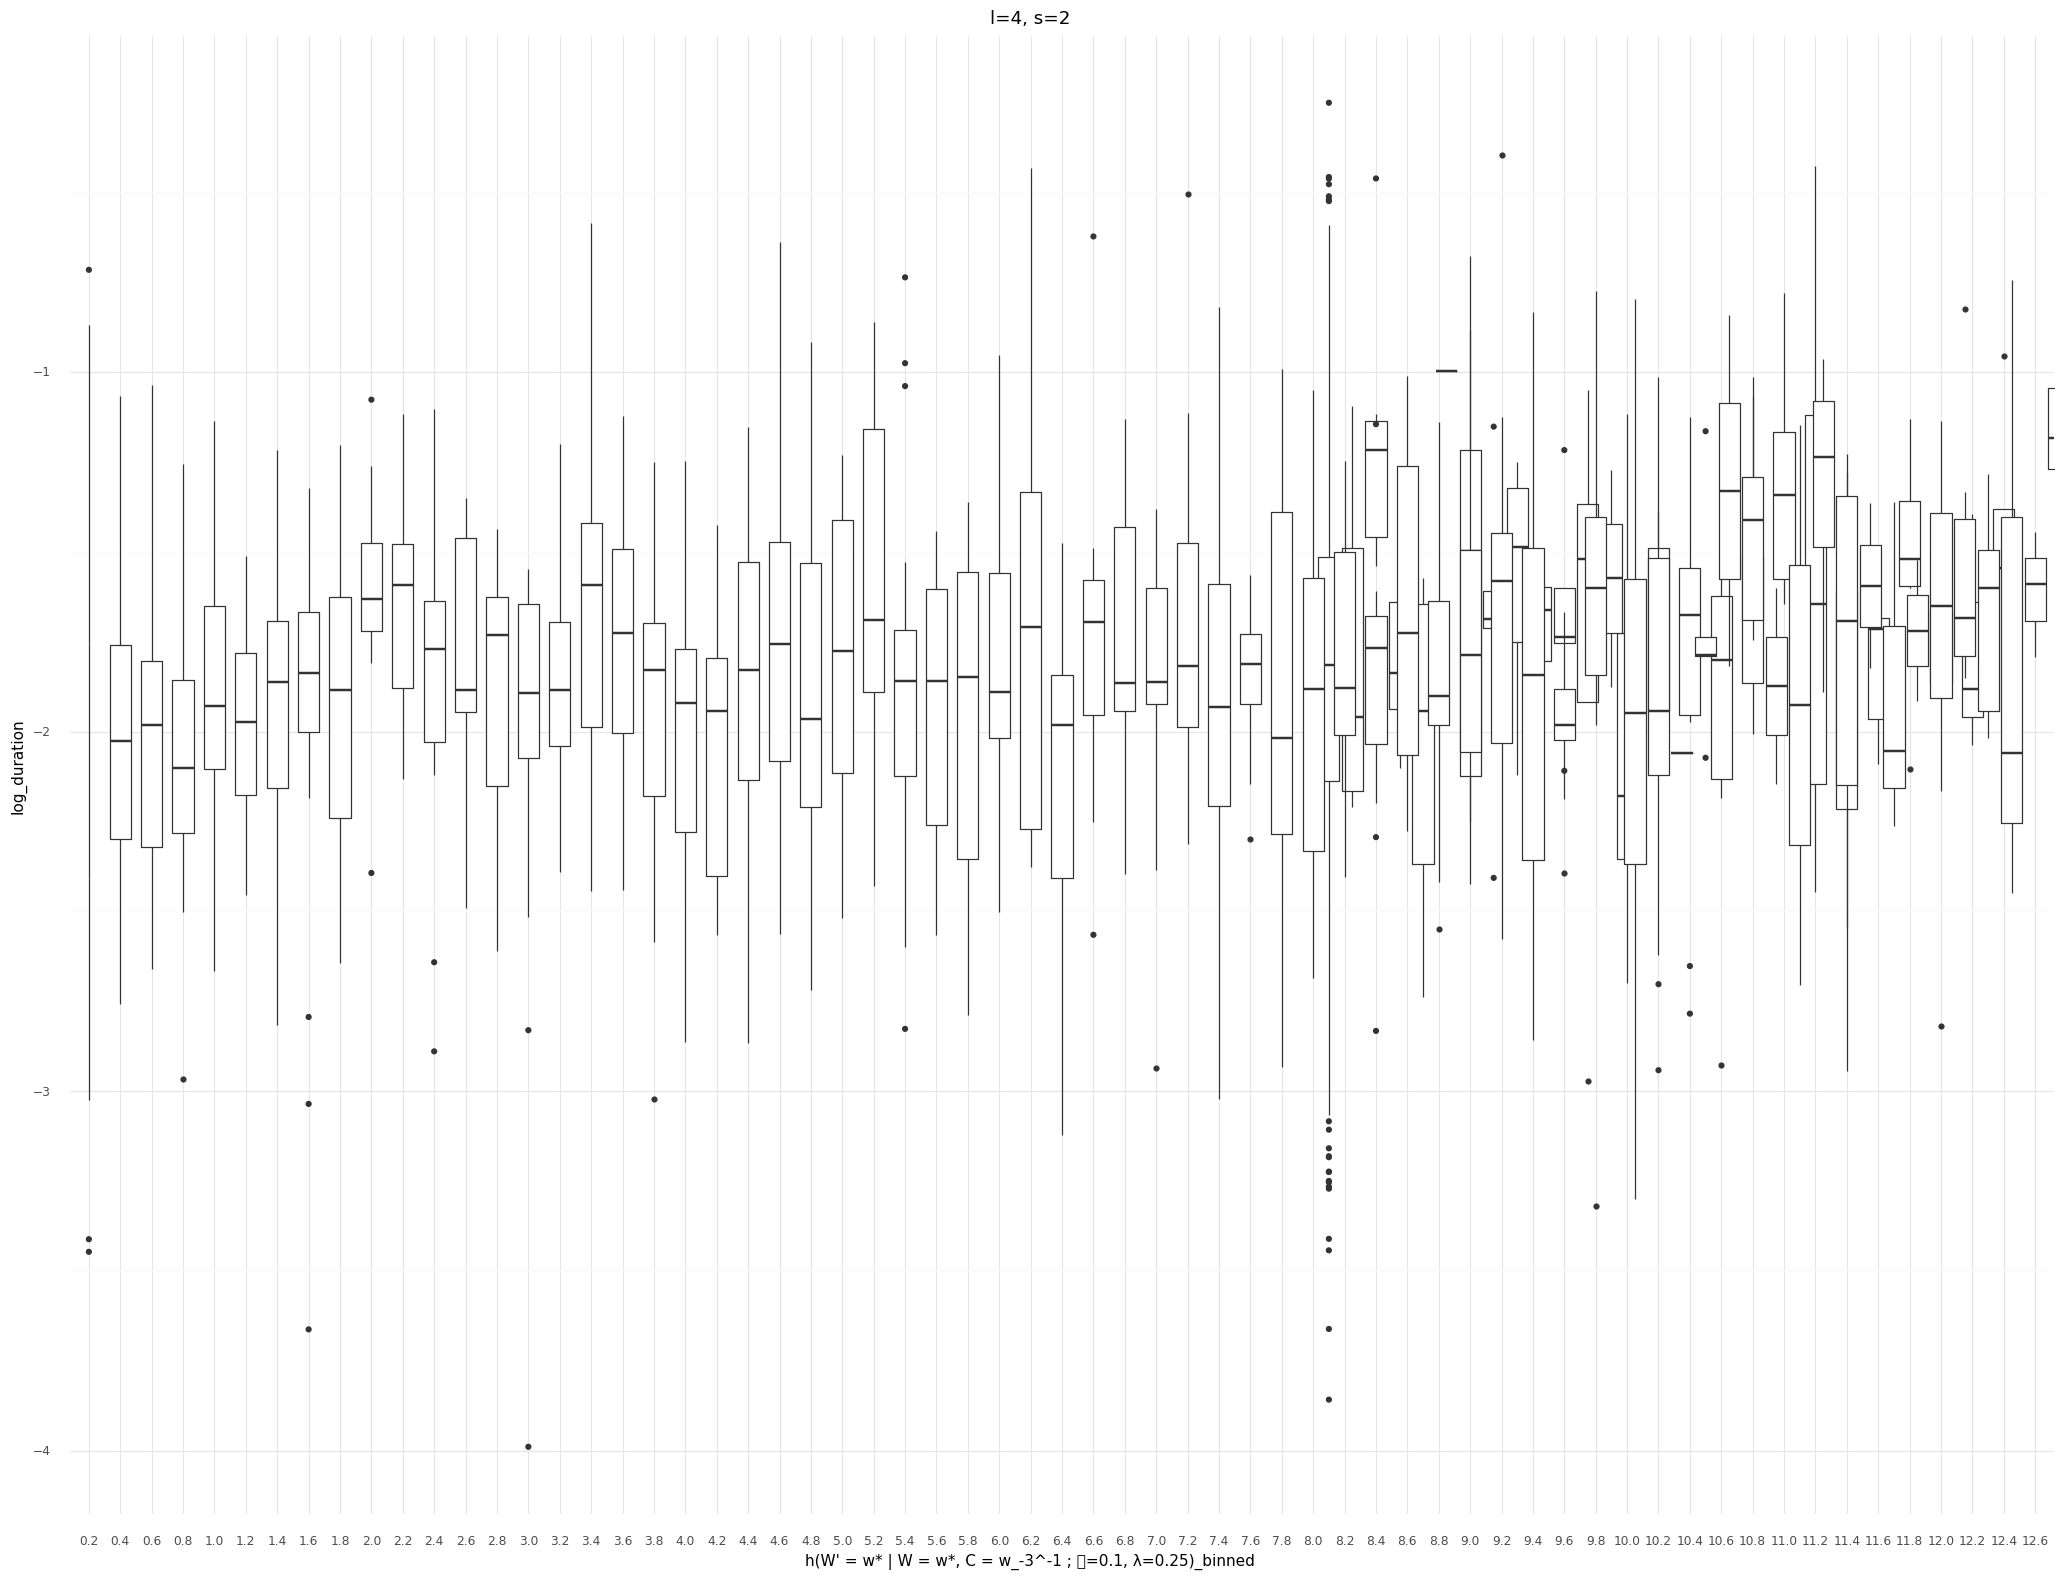

<ggplot: (8779450127321)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=4
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=2, l=4
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=2, l=4, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


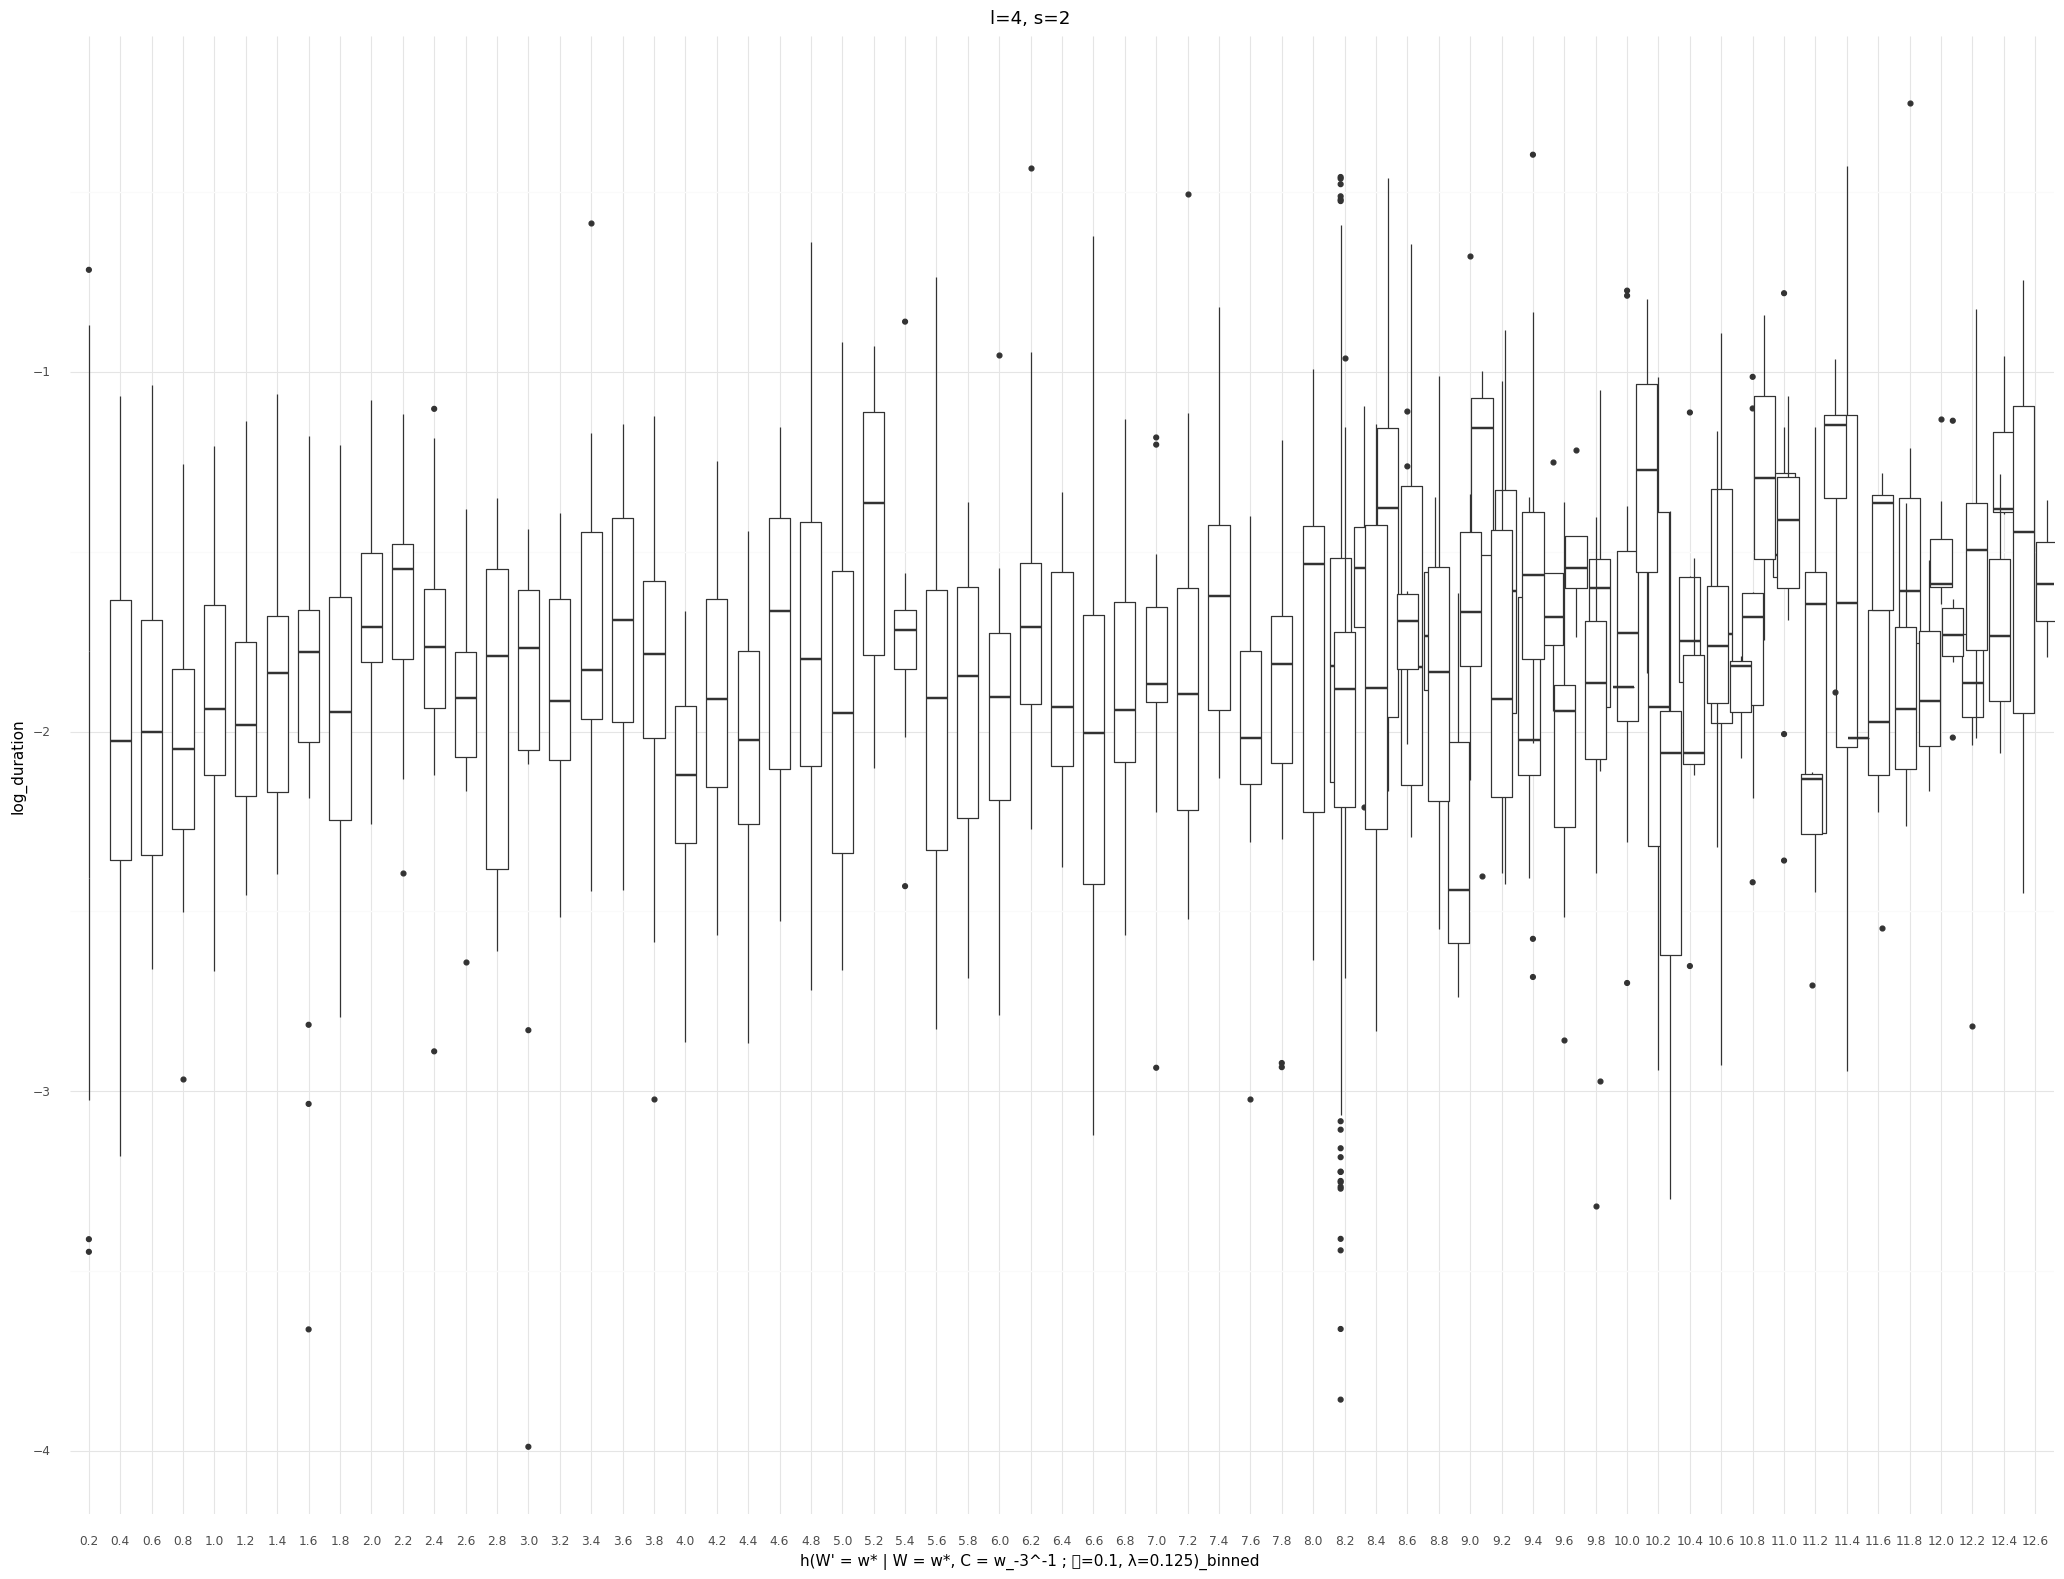

<ggplot: (8779359616021)>

................................................................................
--------------------------------------------------------------------------------


s=2, l=5
	s=2, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=2, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=2, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


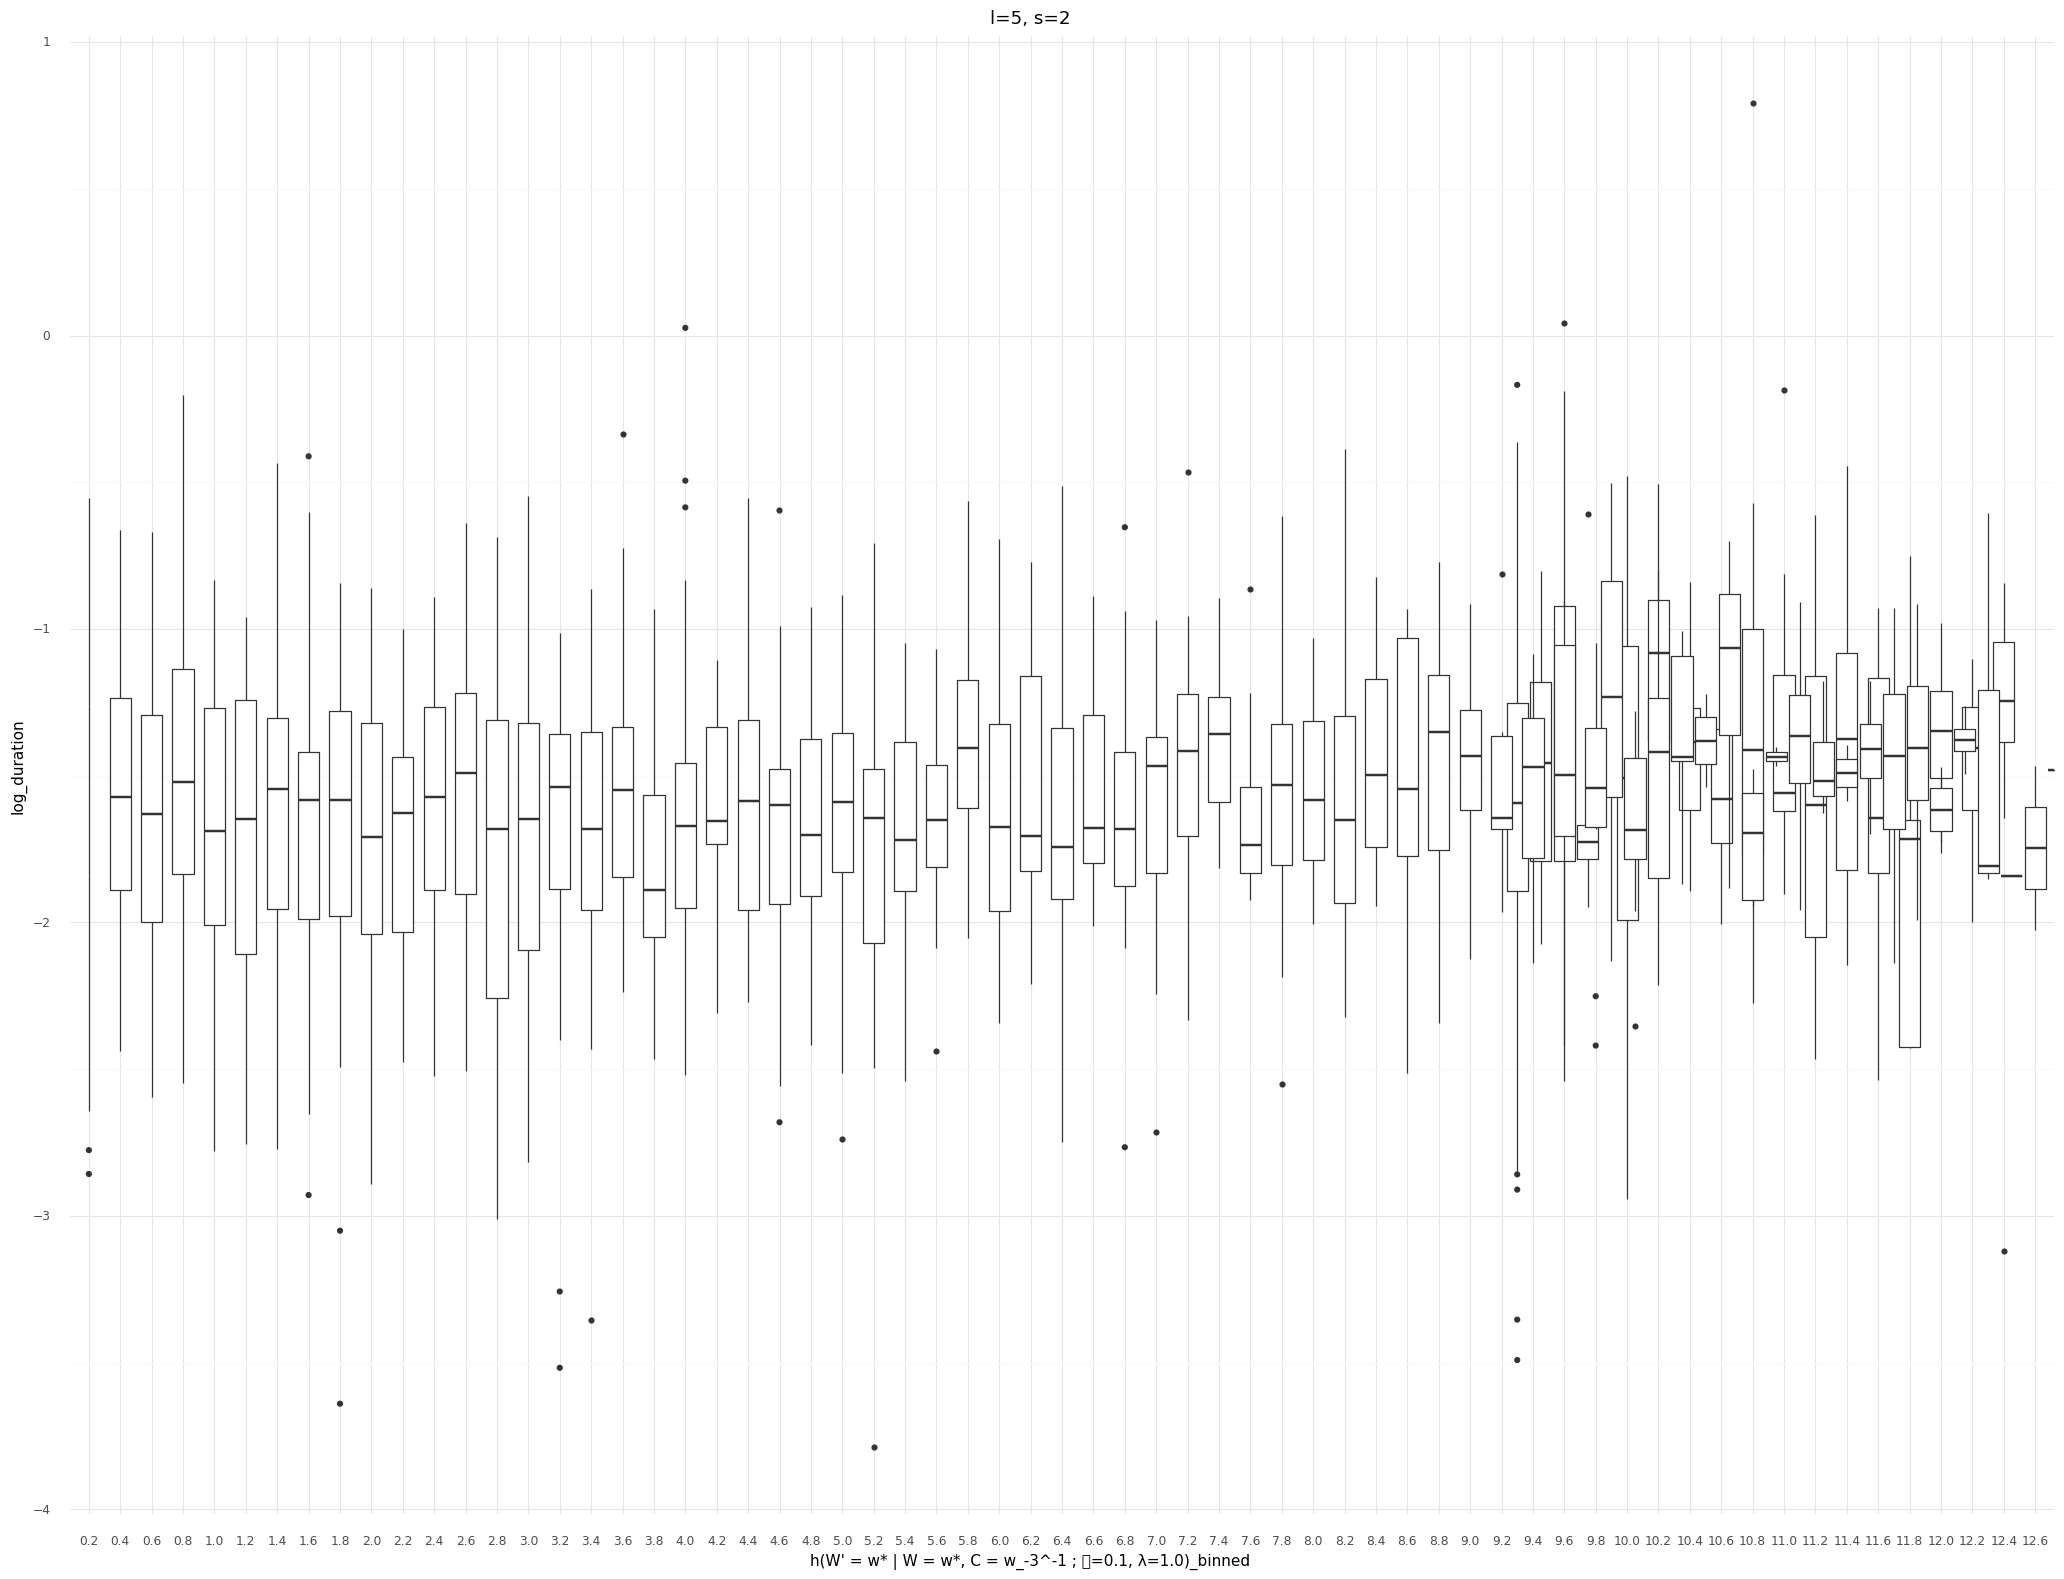

<ggplot: (8779360847937)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=2, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=2, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


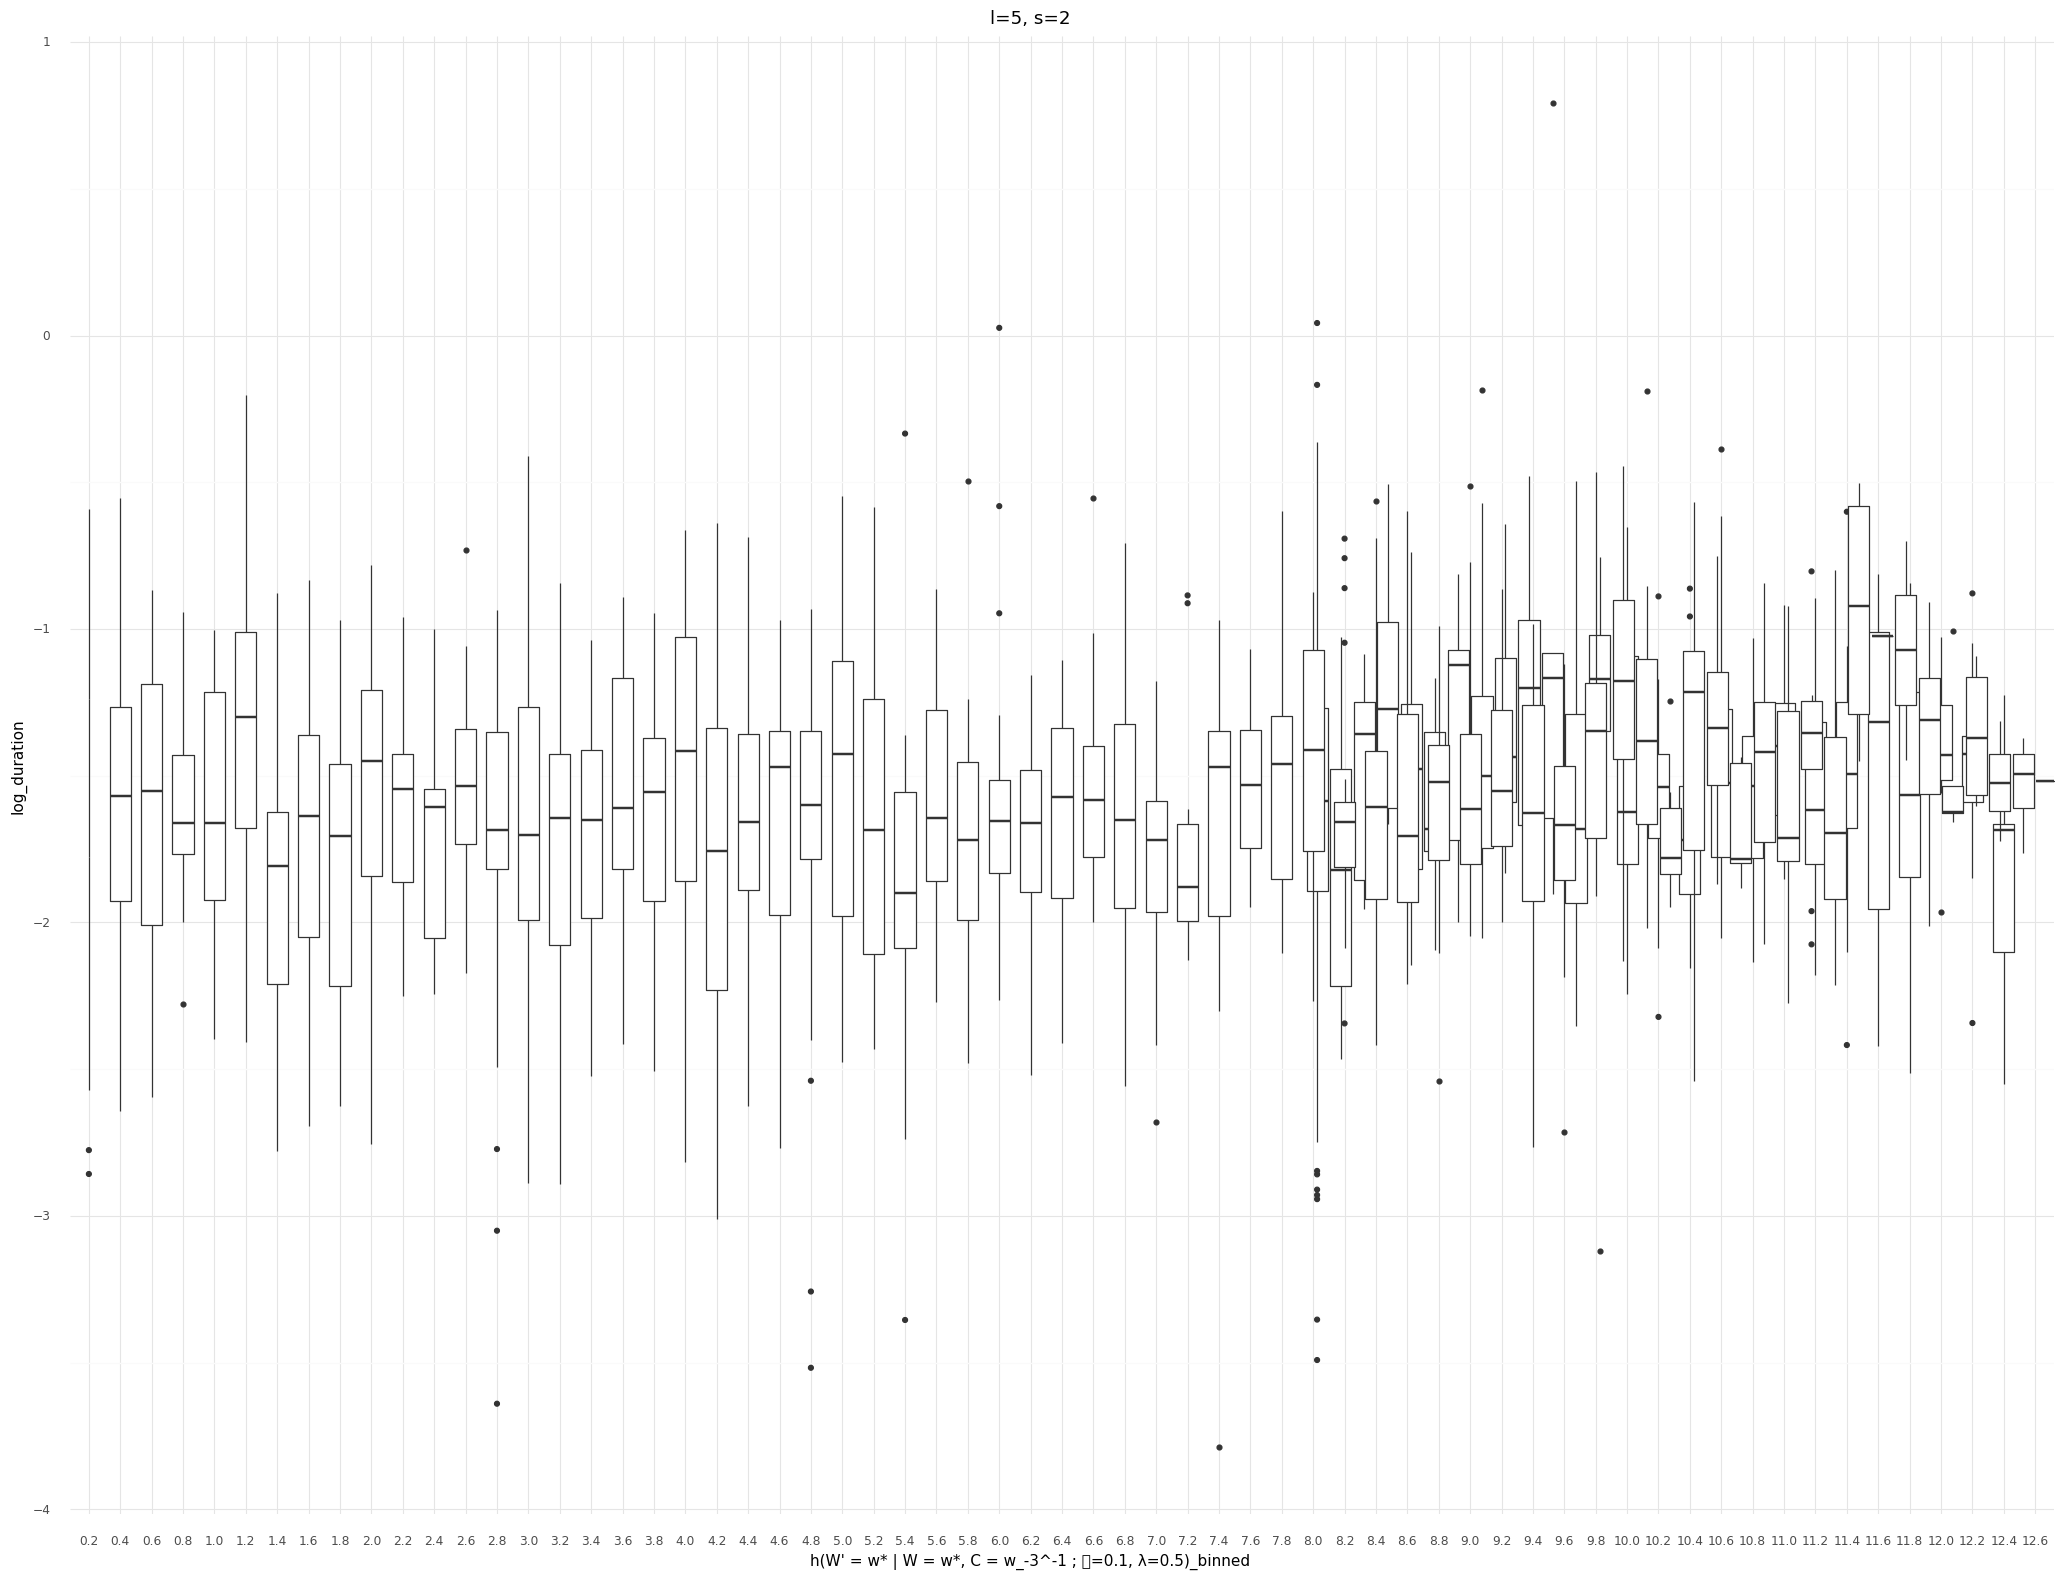

<ggplot: (8779382005185)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=2, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=2, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


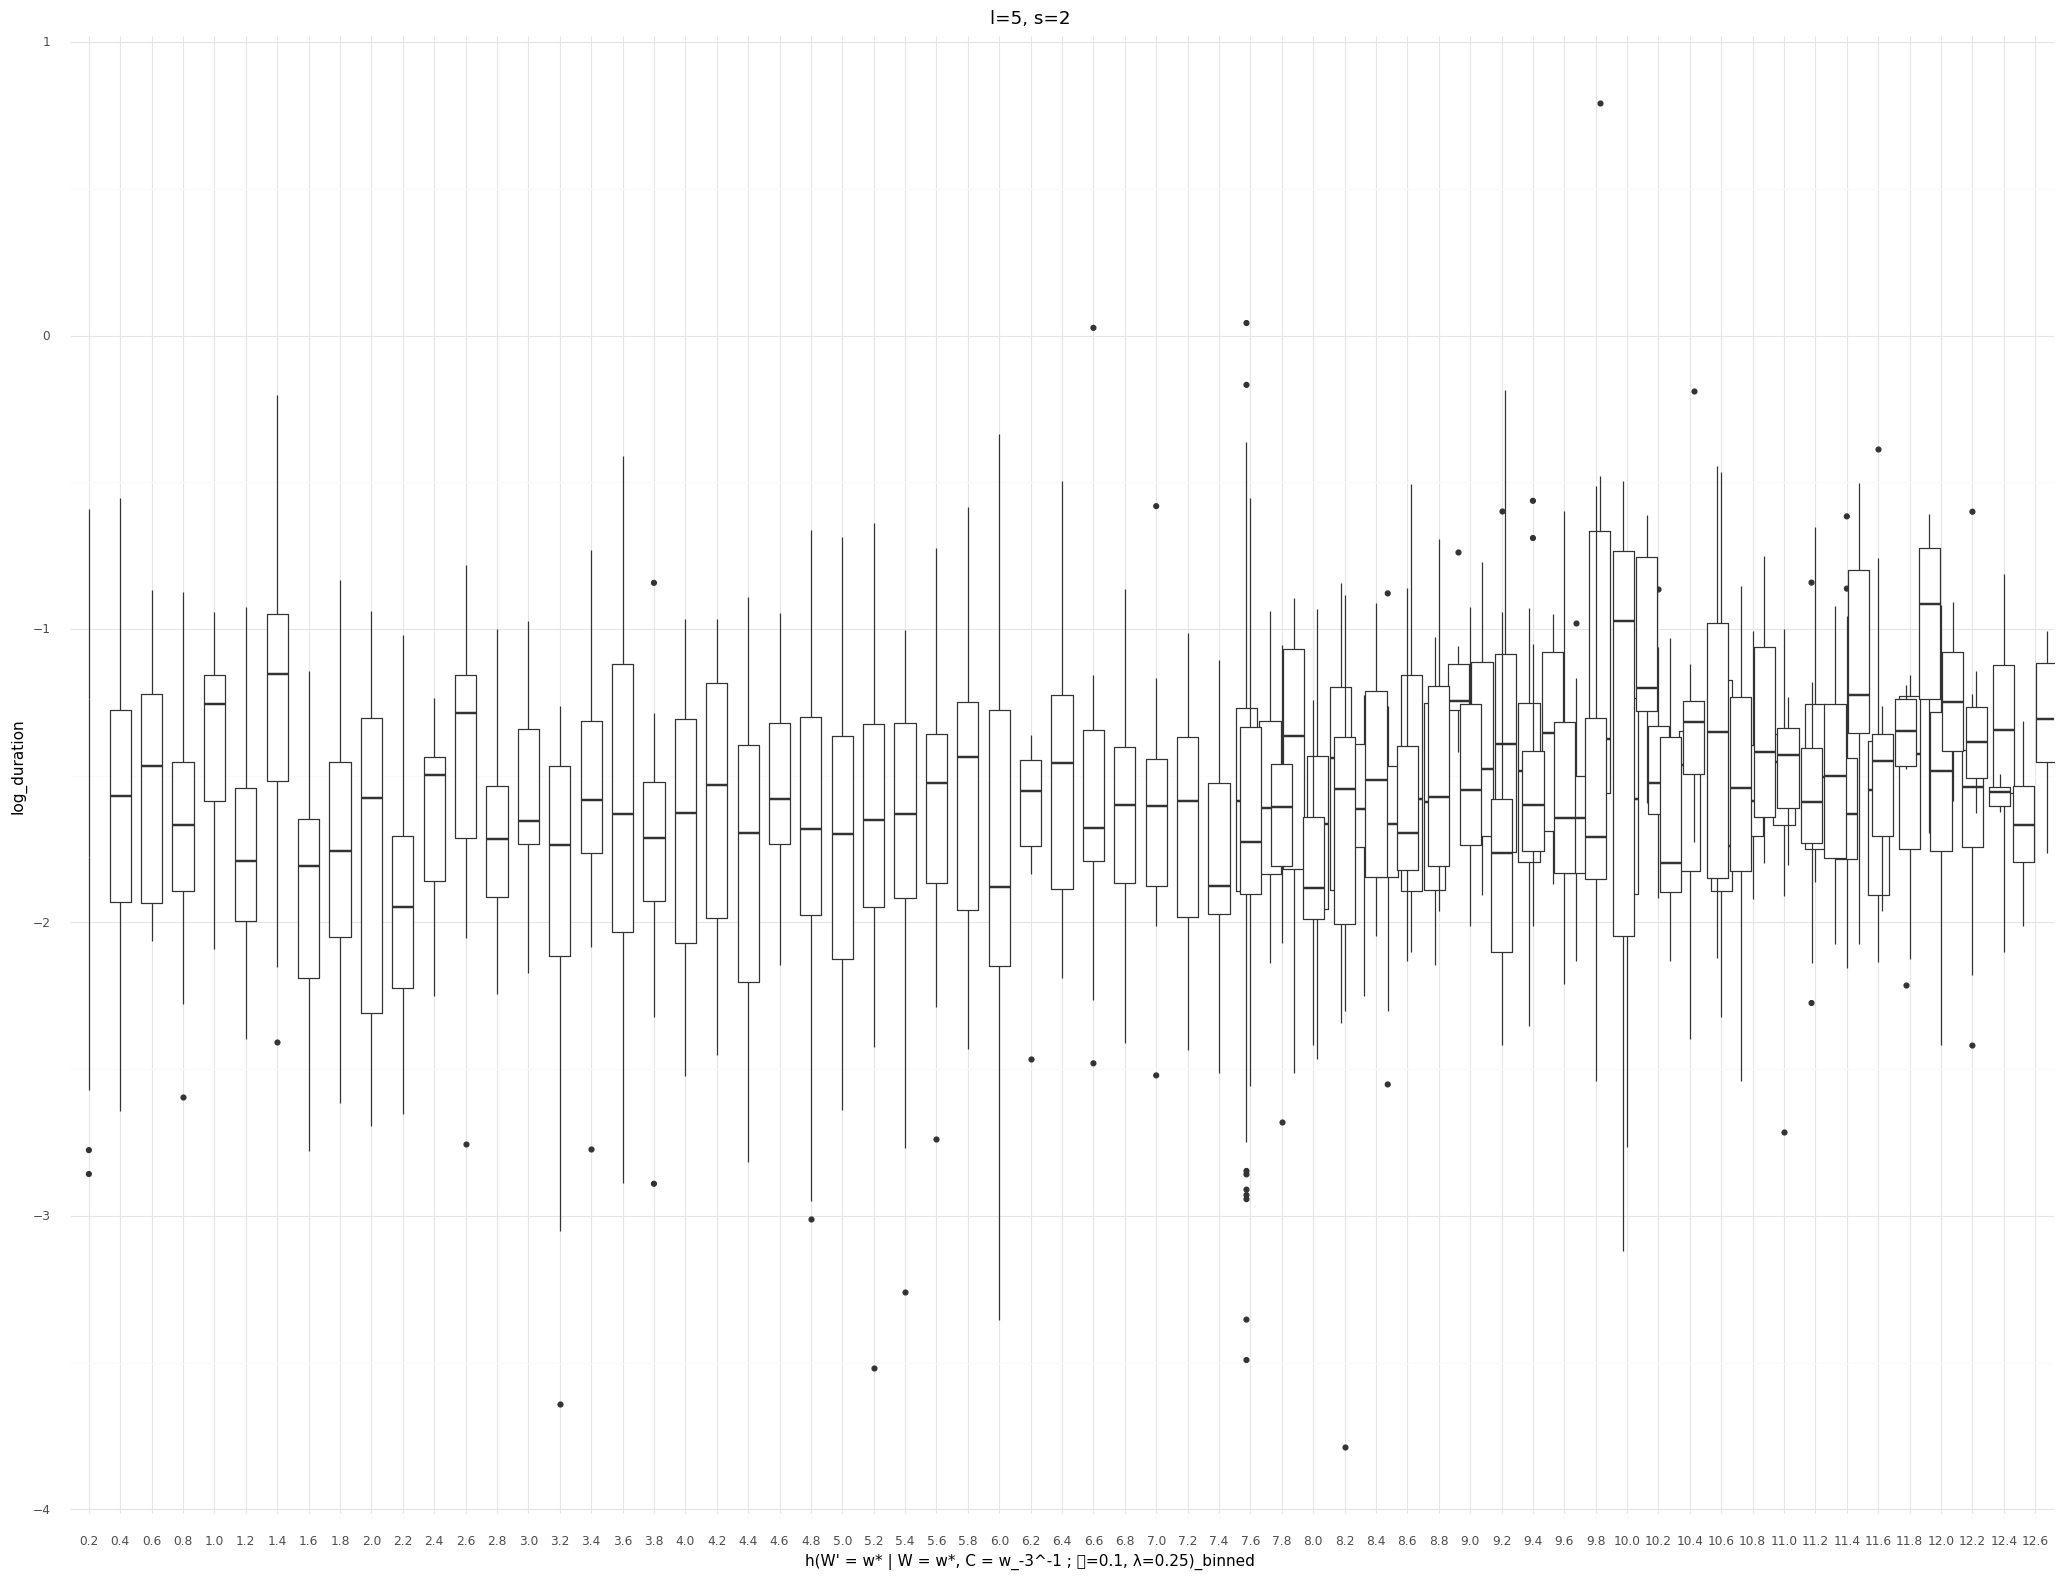

<ggplot: (8779356974165)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=5
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=2, l=5
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=2, l=5, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


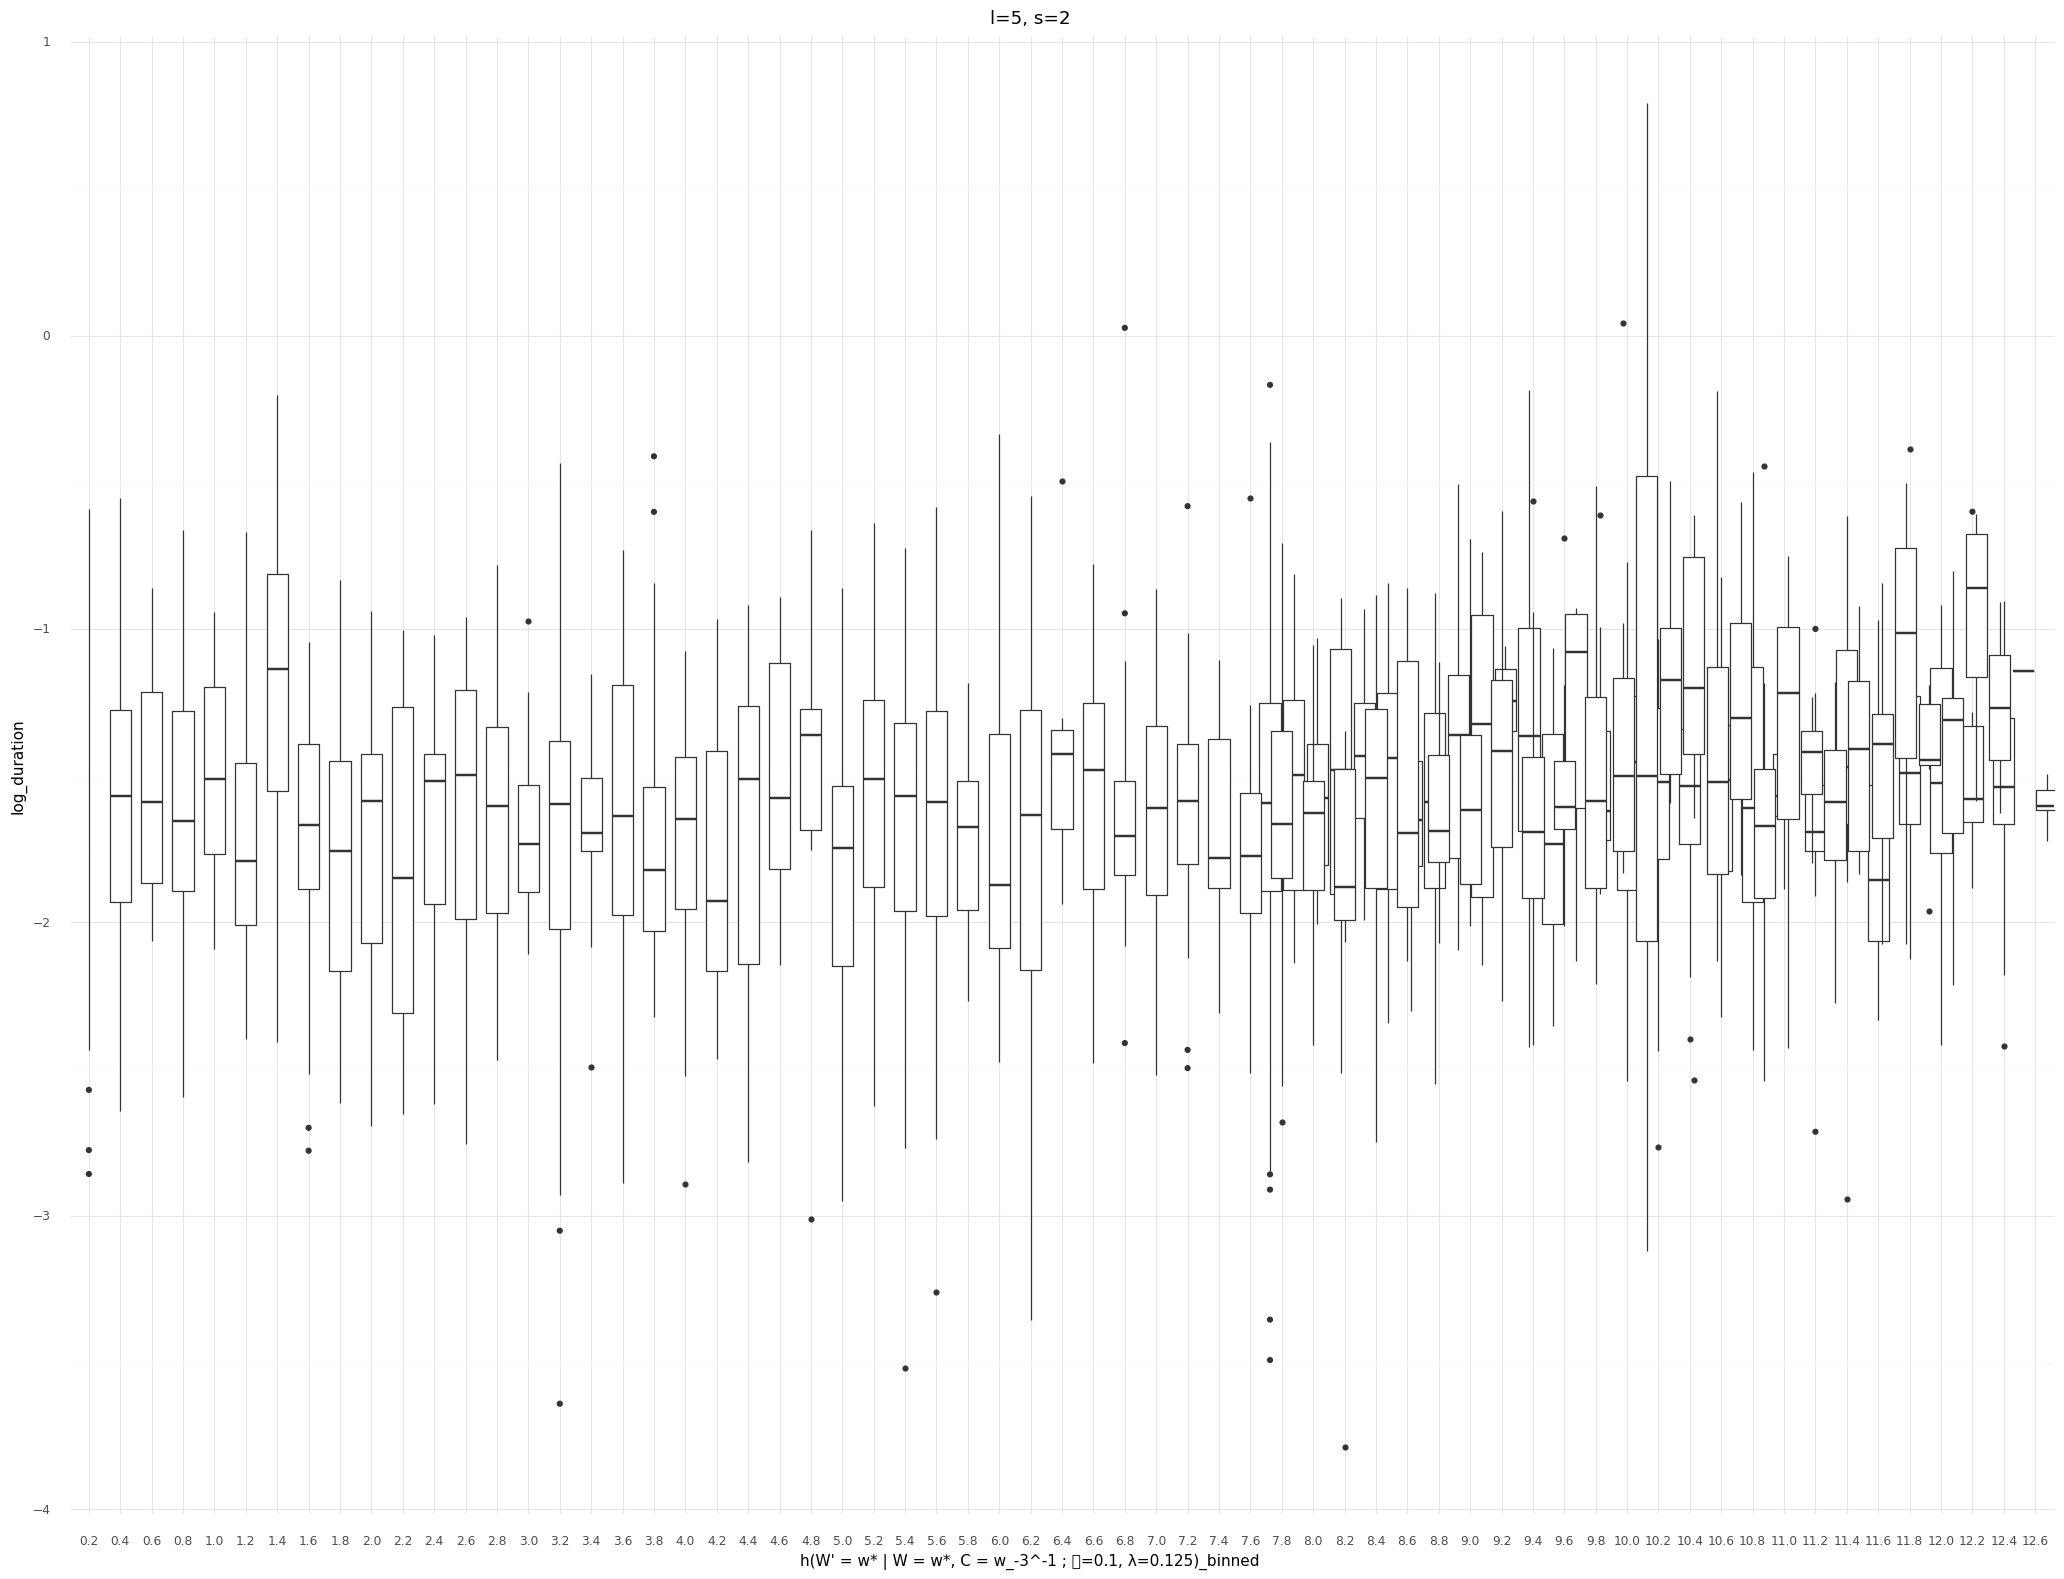

<ggplot: (8779447856093)>

................................................................................
--------------------------------------------------------------------------------


s=2, l=6
	s=2, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=2, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=2, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


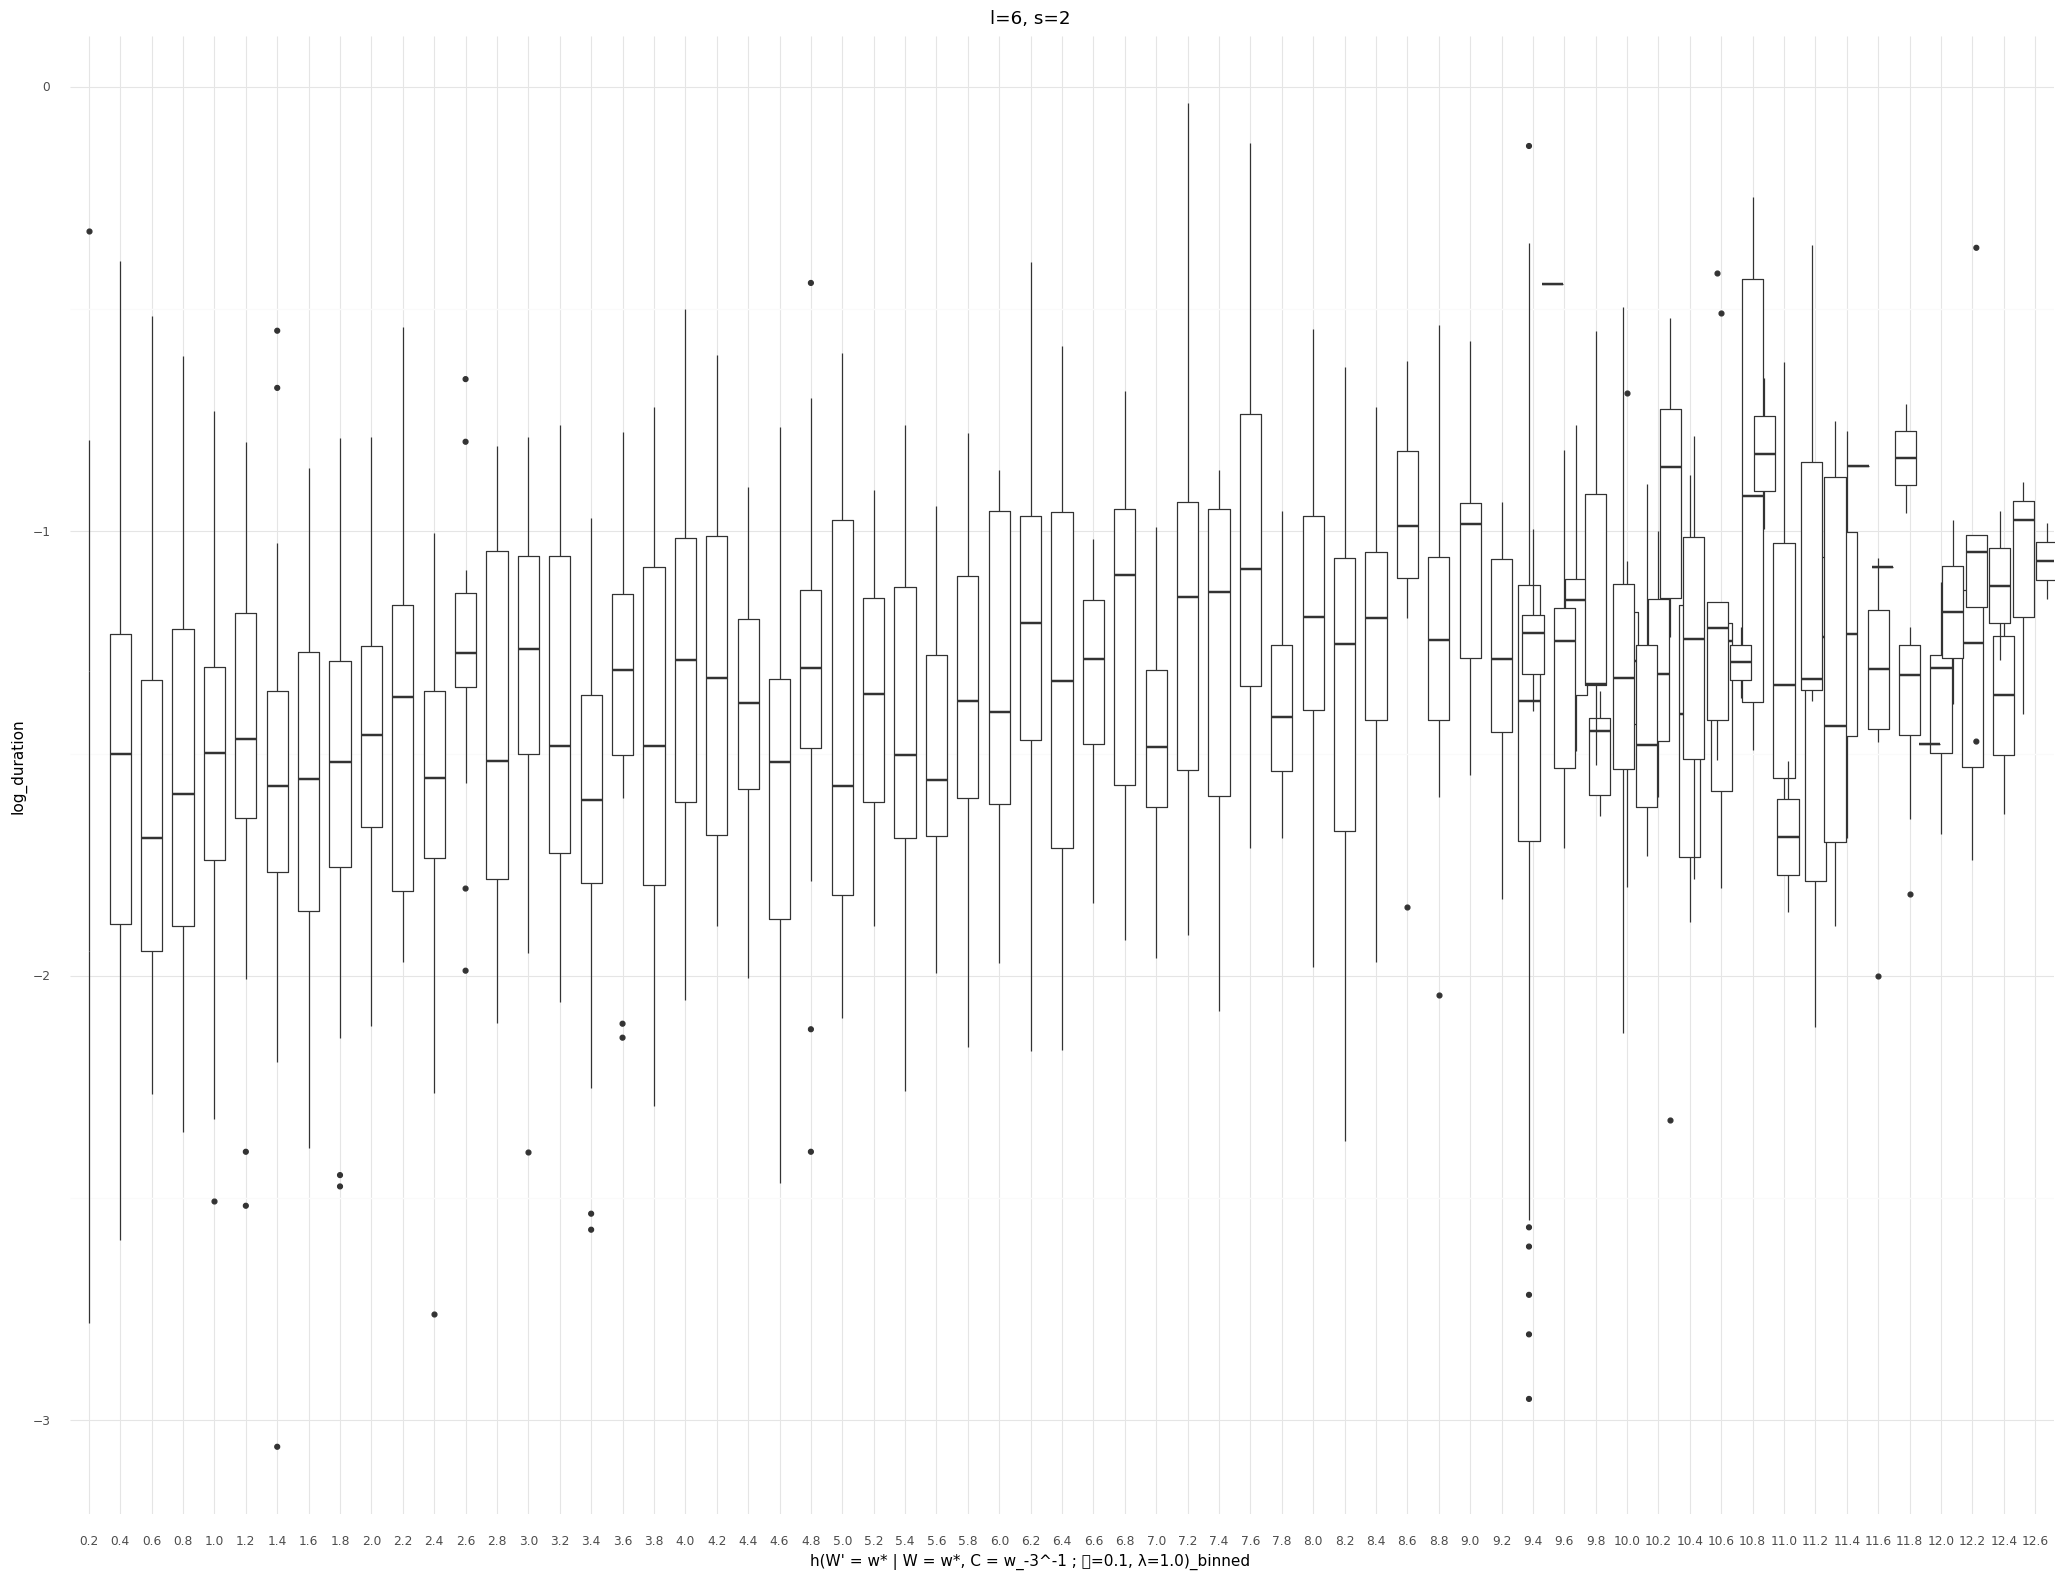

<ggplot: (8779411163689)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=2, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=2, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


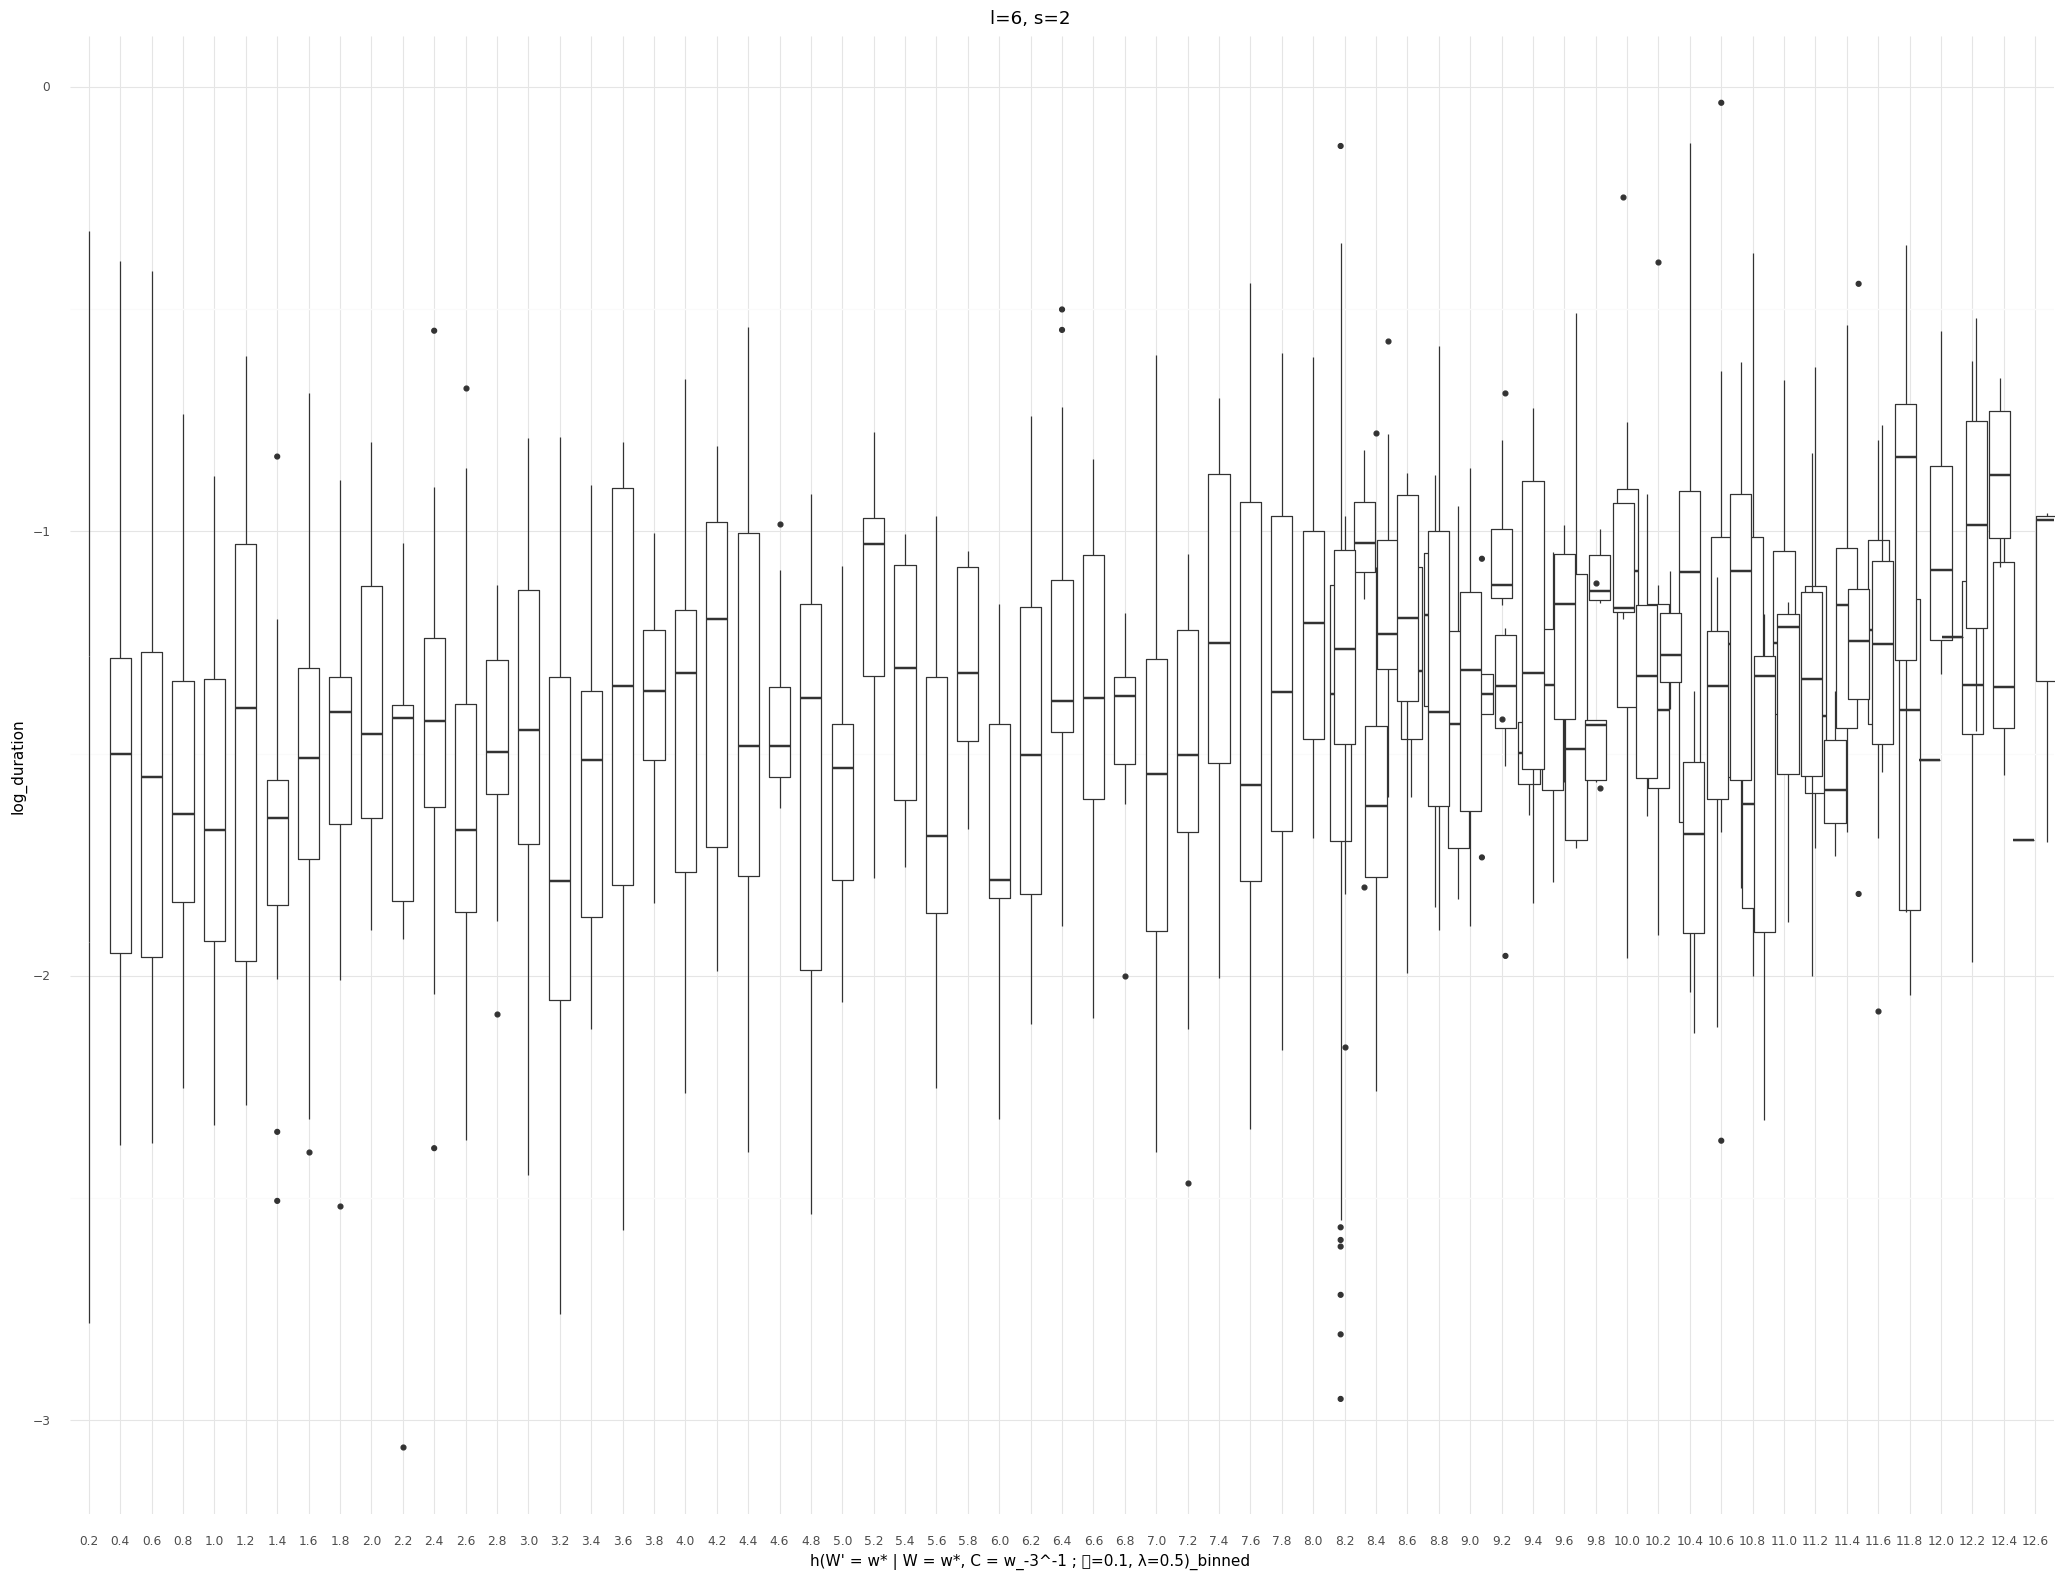

<ggplot: (8779297573097)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=2, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=2, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


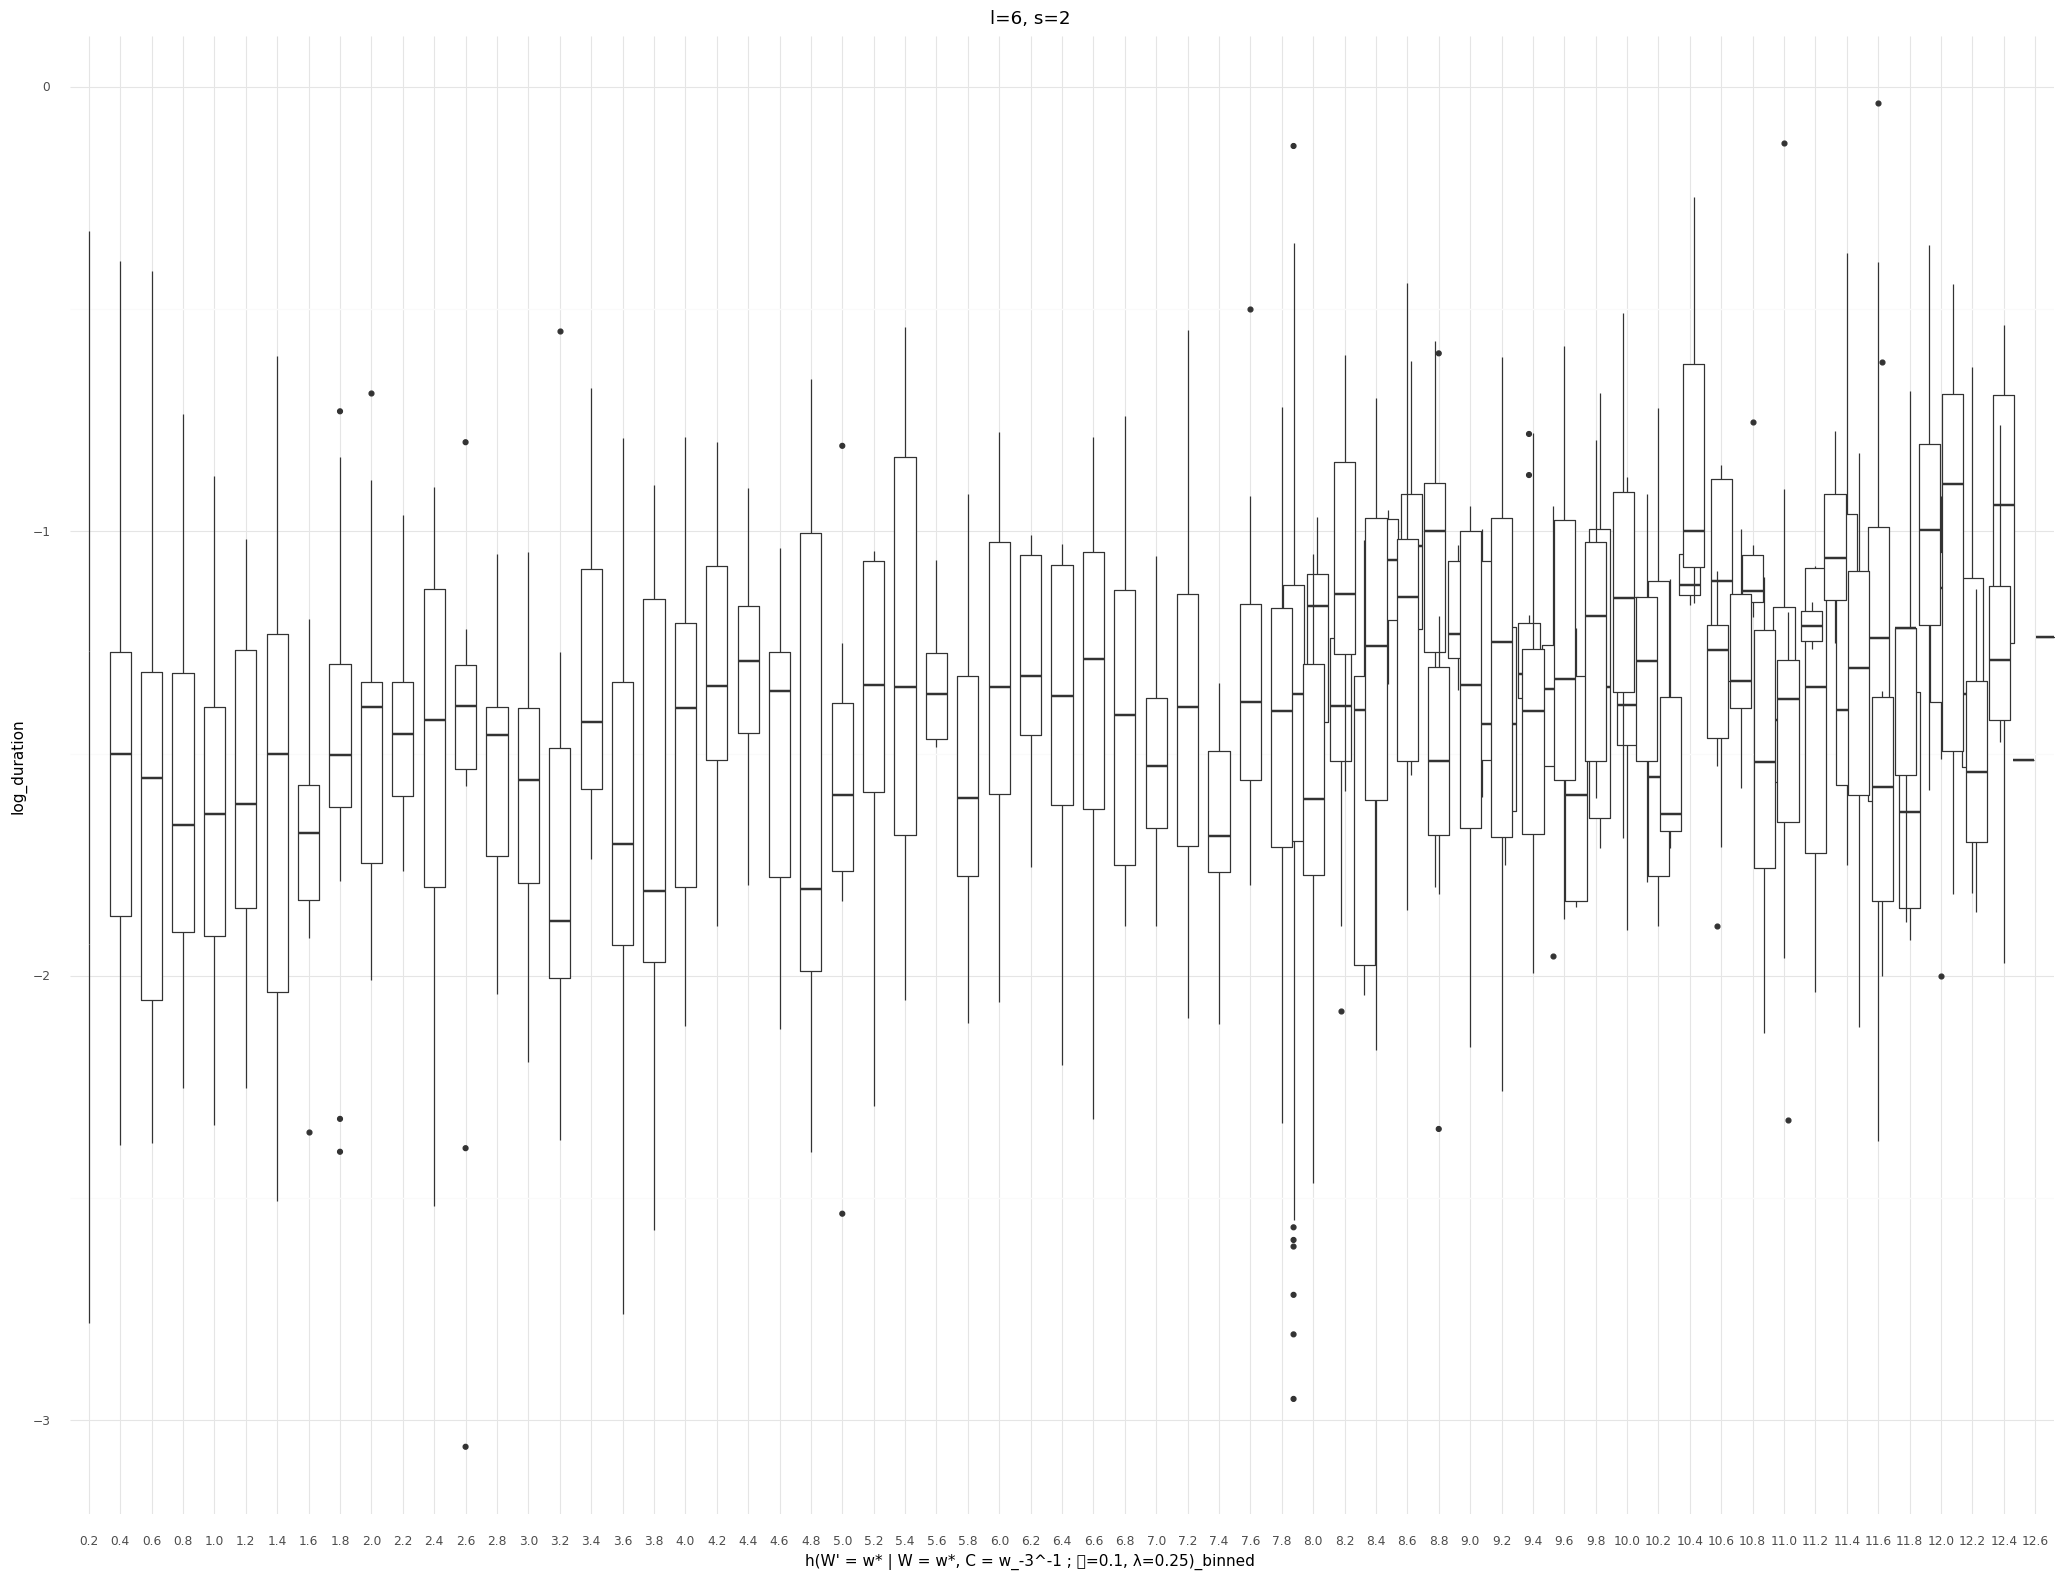

<ggplot: (8779447835605)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=2, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=2, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


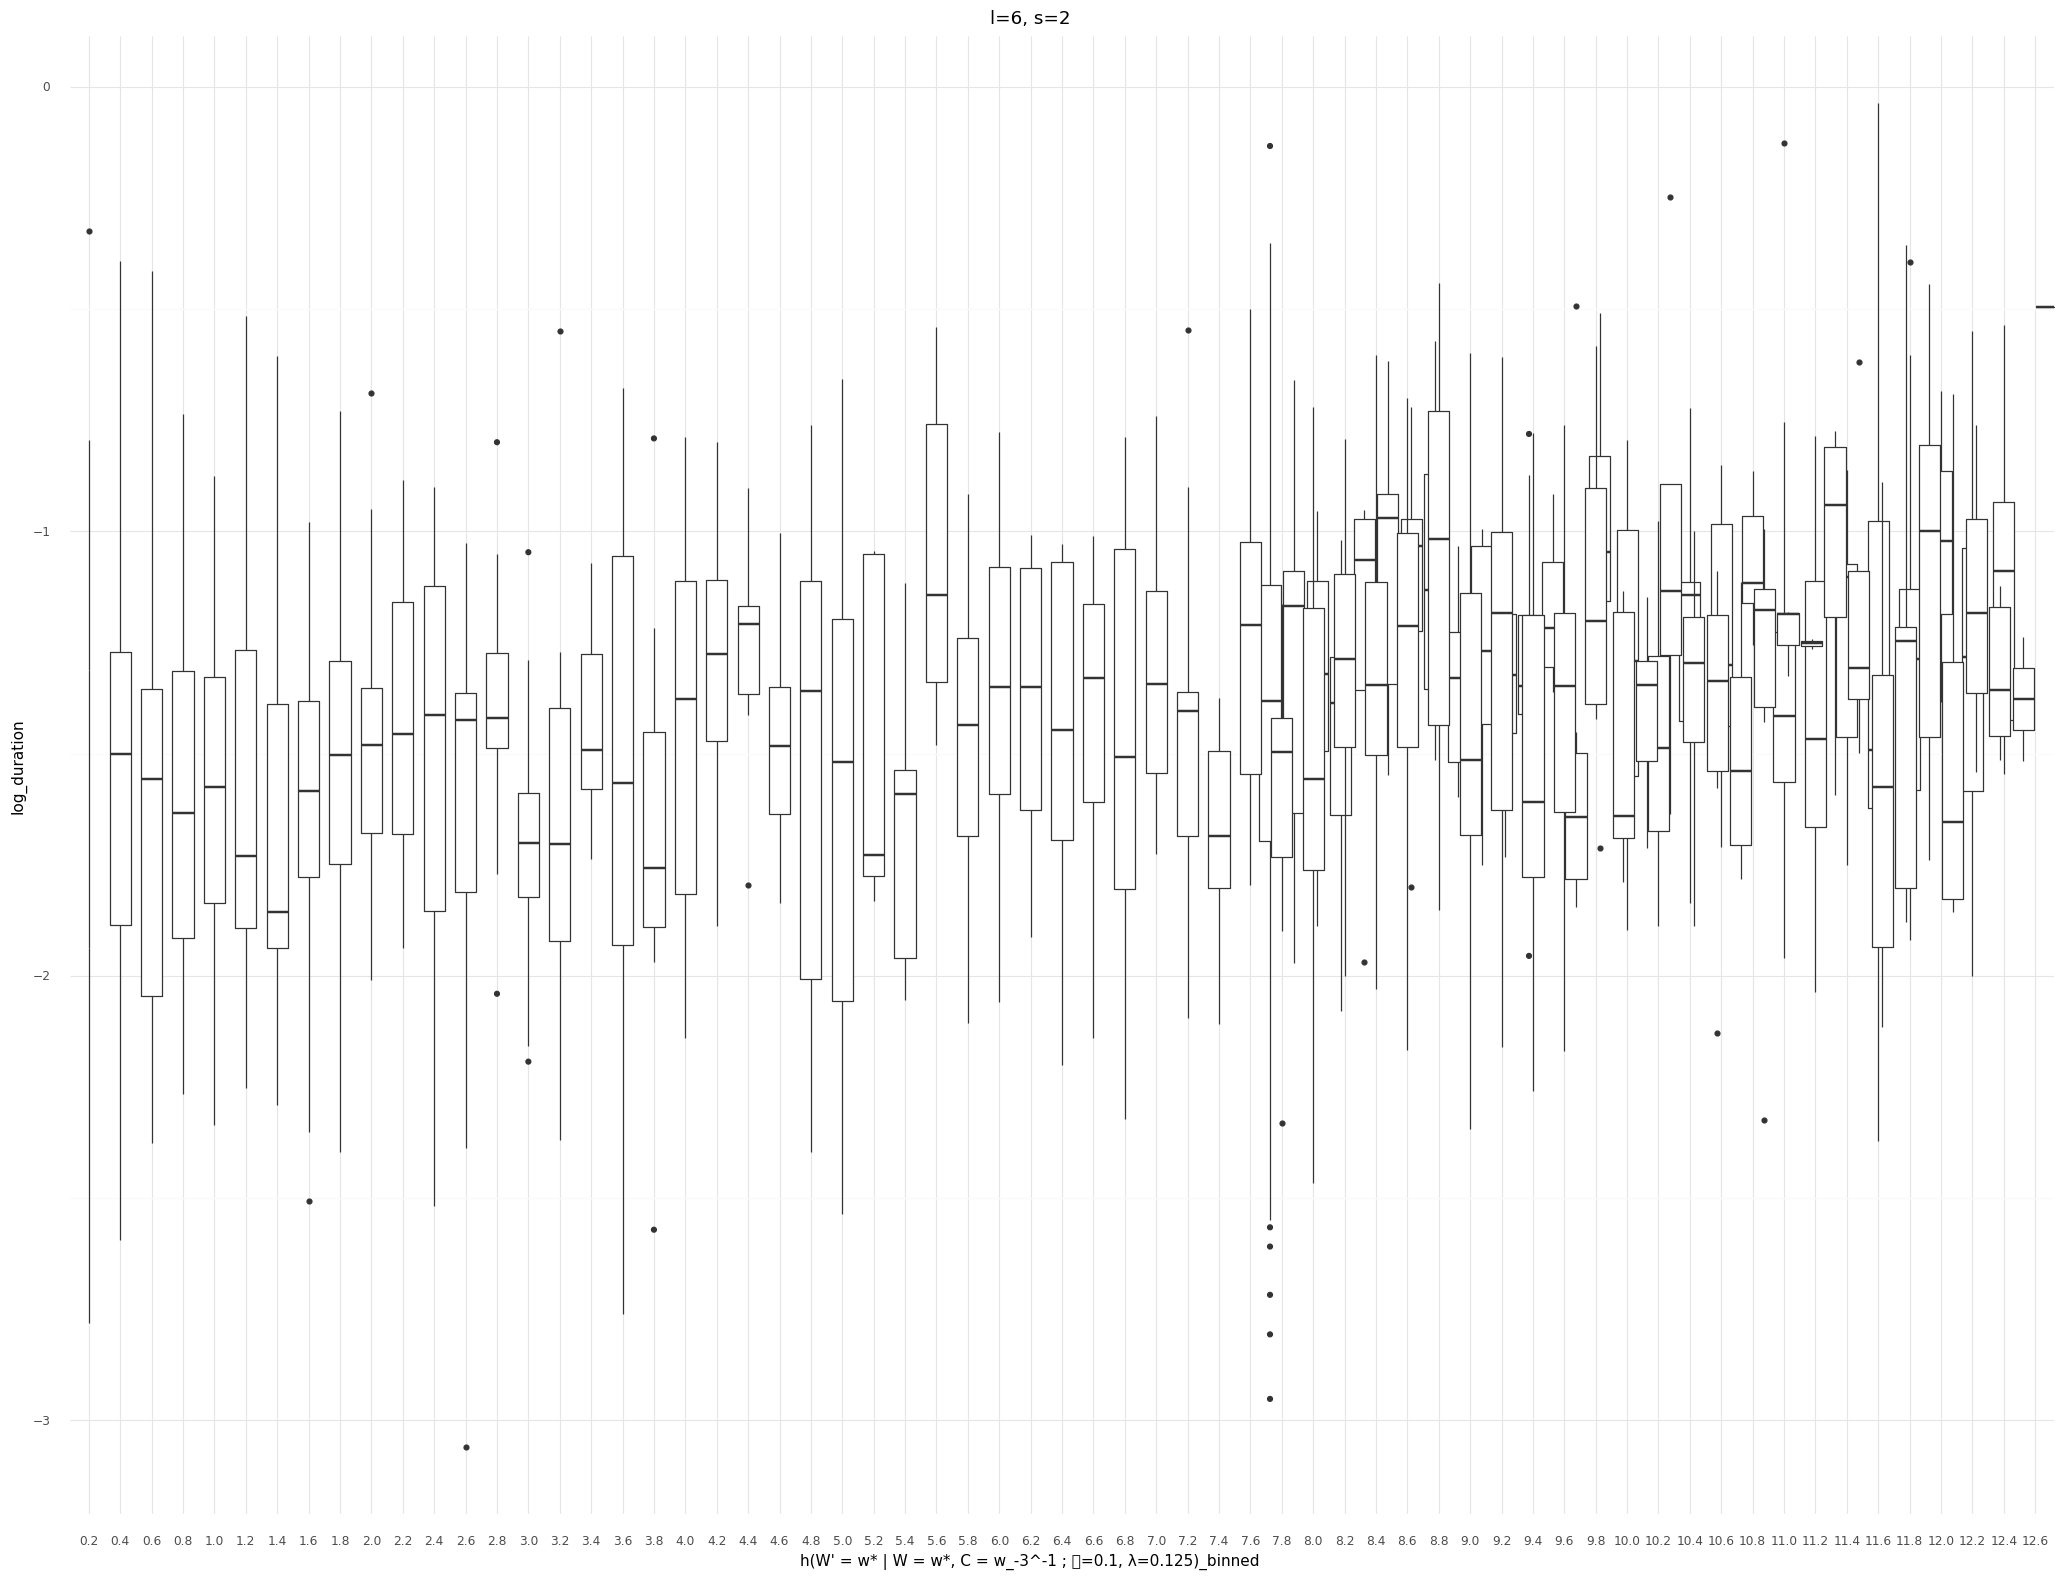

<ggplot: (8779367336577)>

................................................................................
--------------------------------------------------------------------------------


s=2, l=7
	s=2, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=2, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=2, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


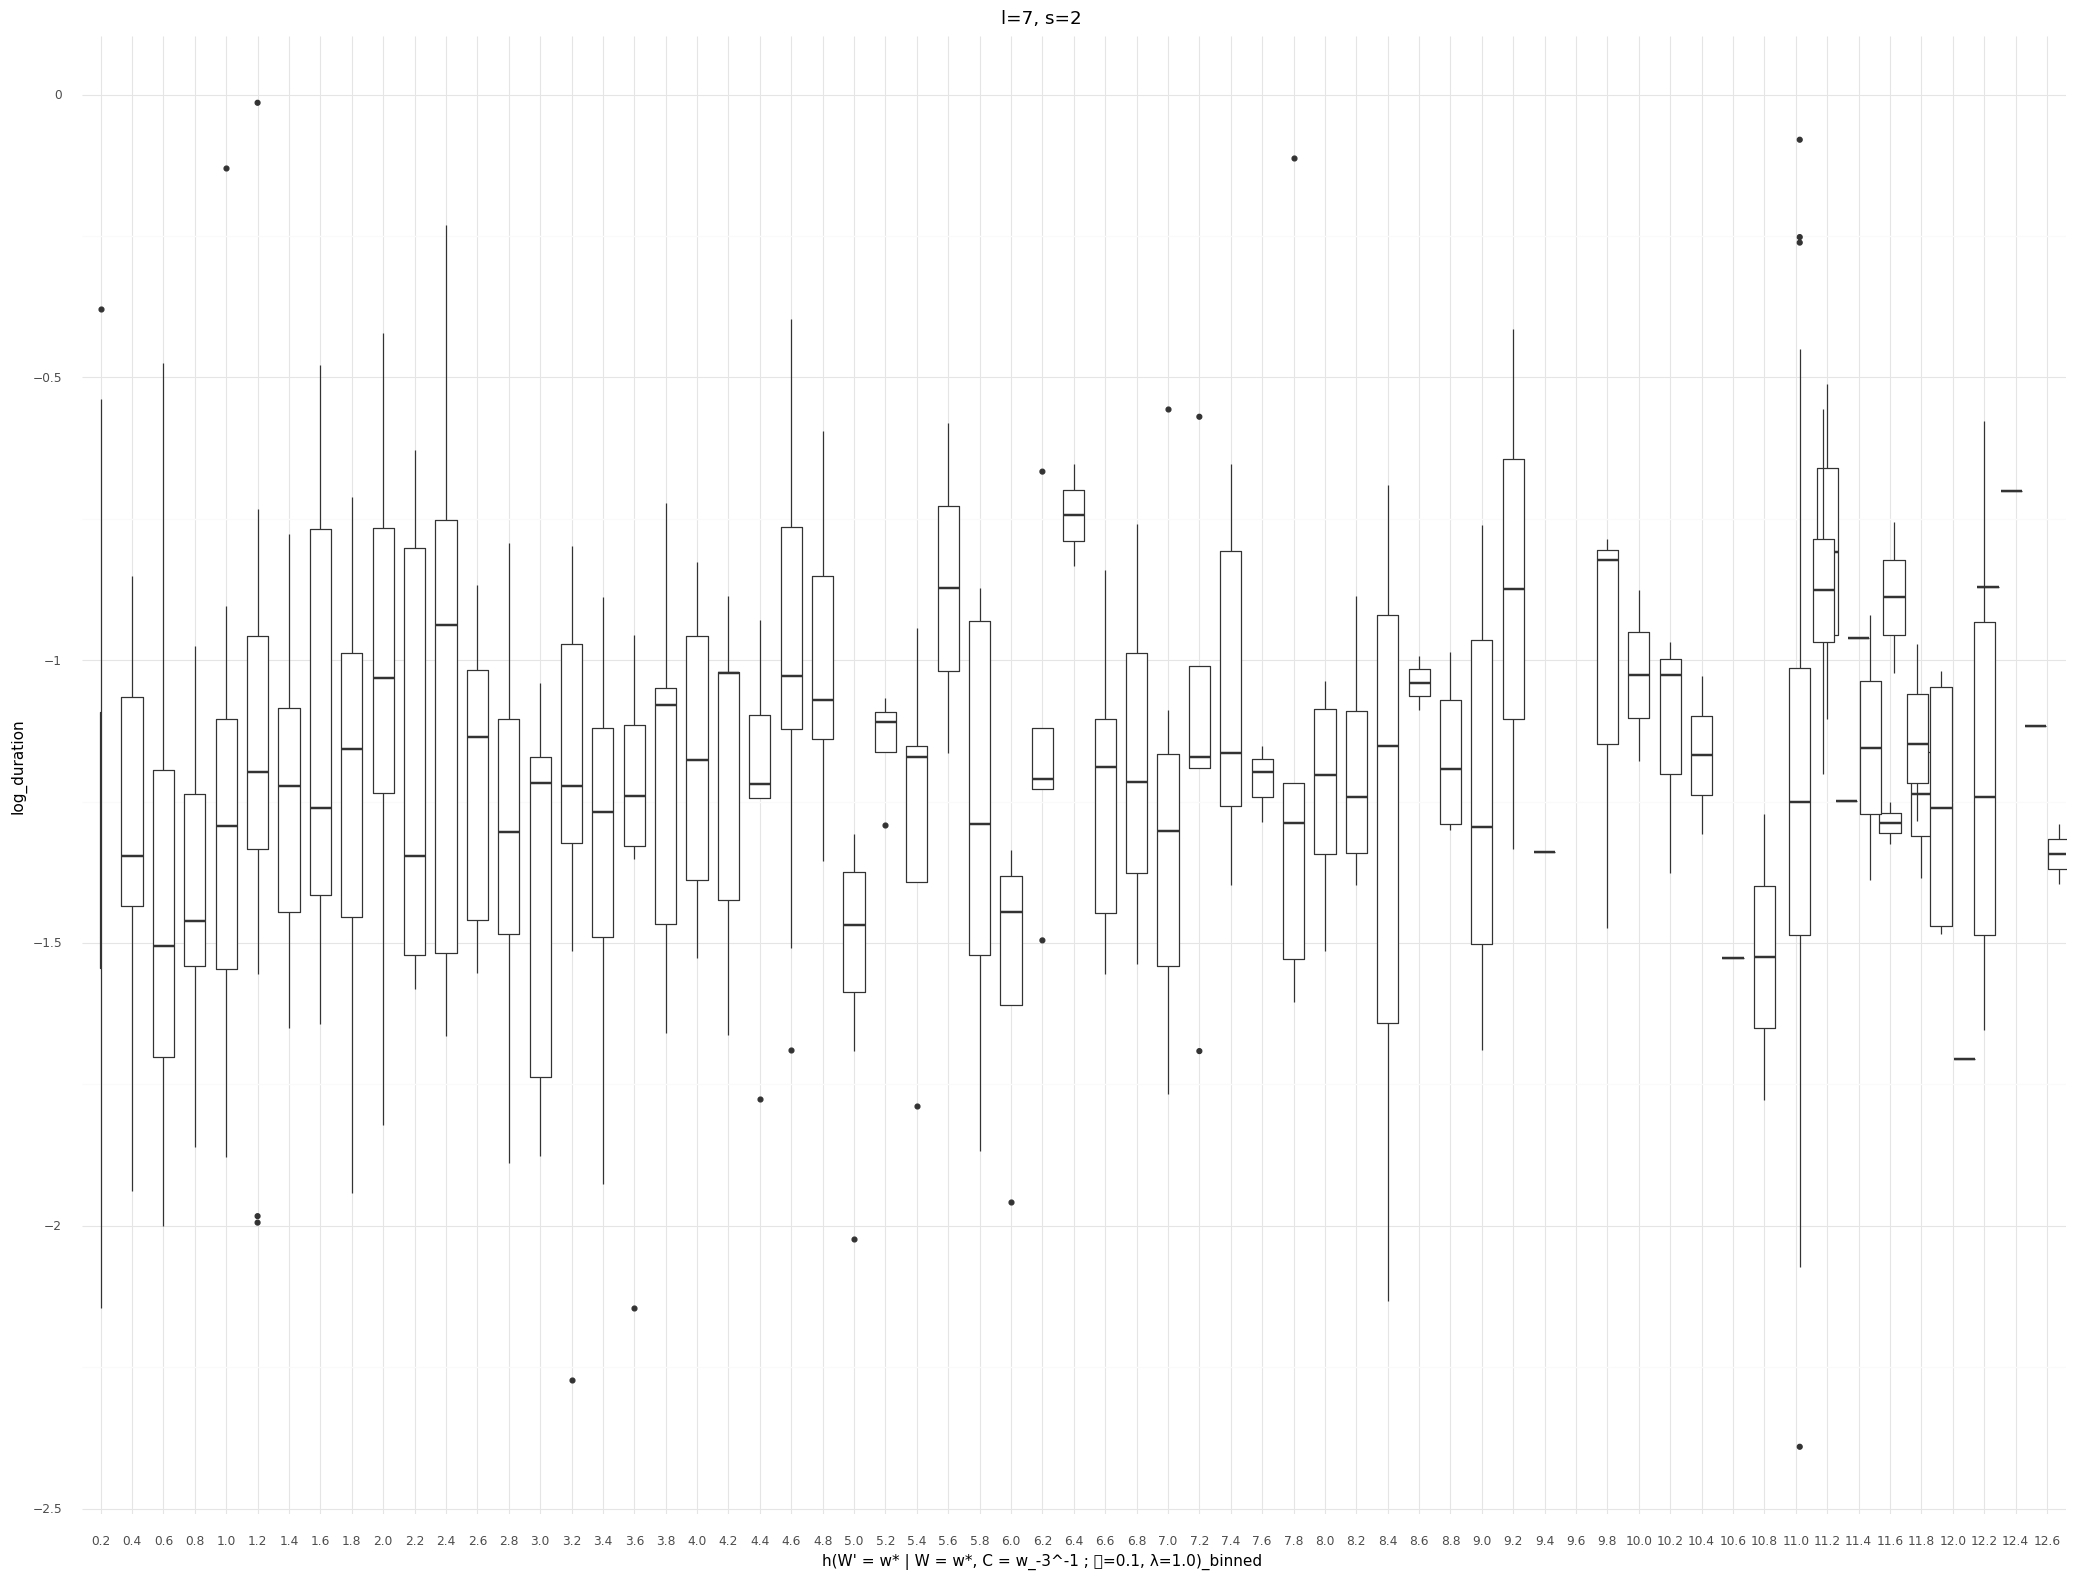

<ggplot: (8779277126929)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=2, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=2, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


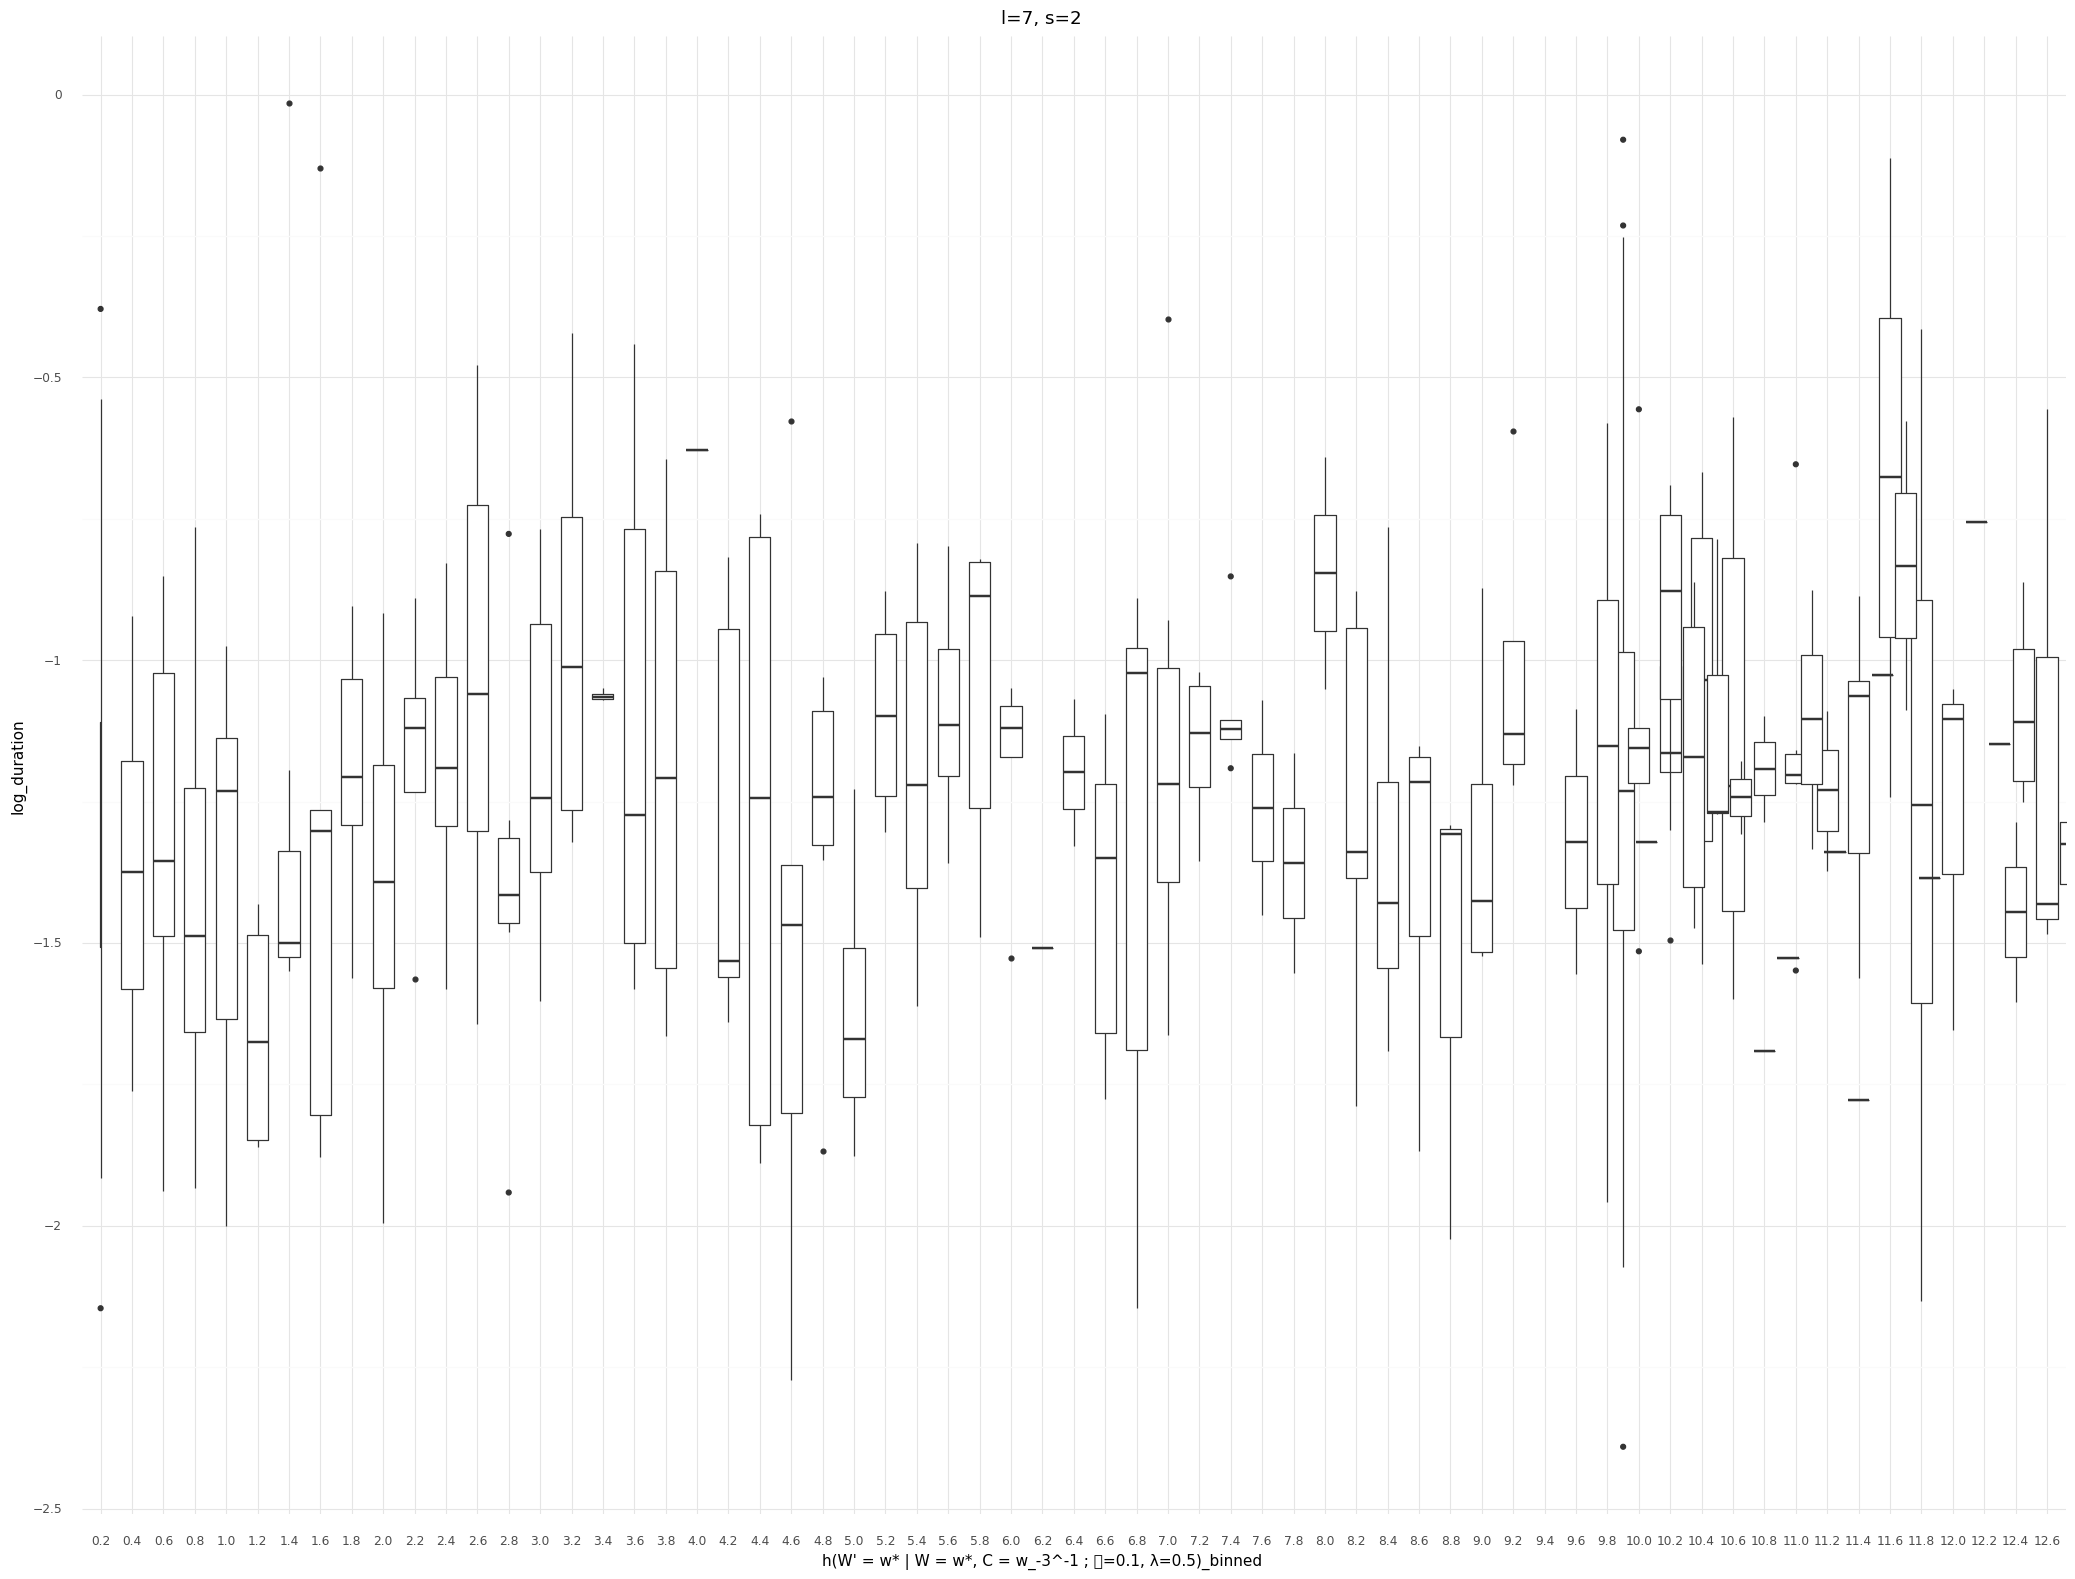

<ggplot: (8779359633293)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=2, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=2, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


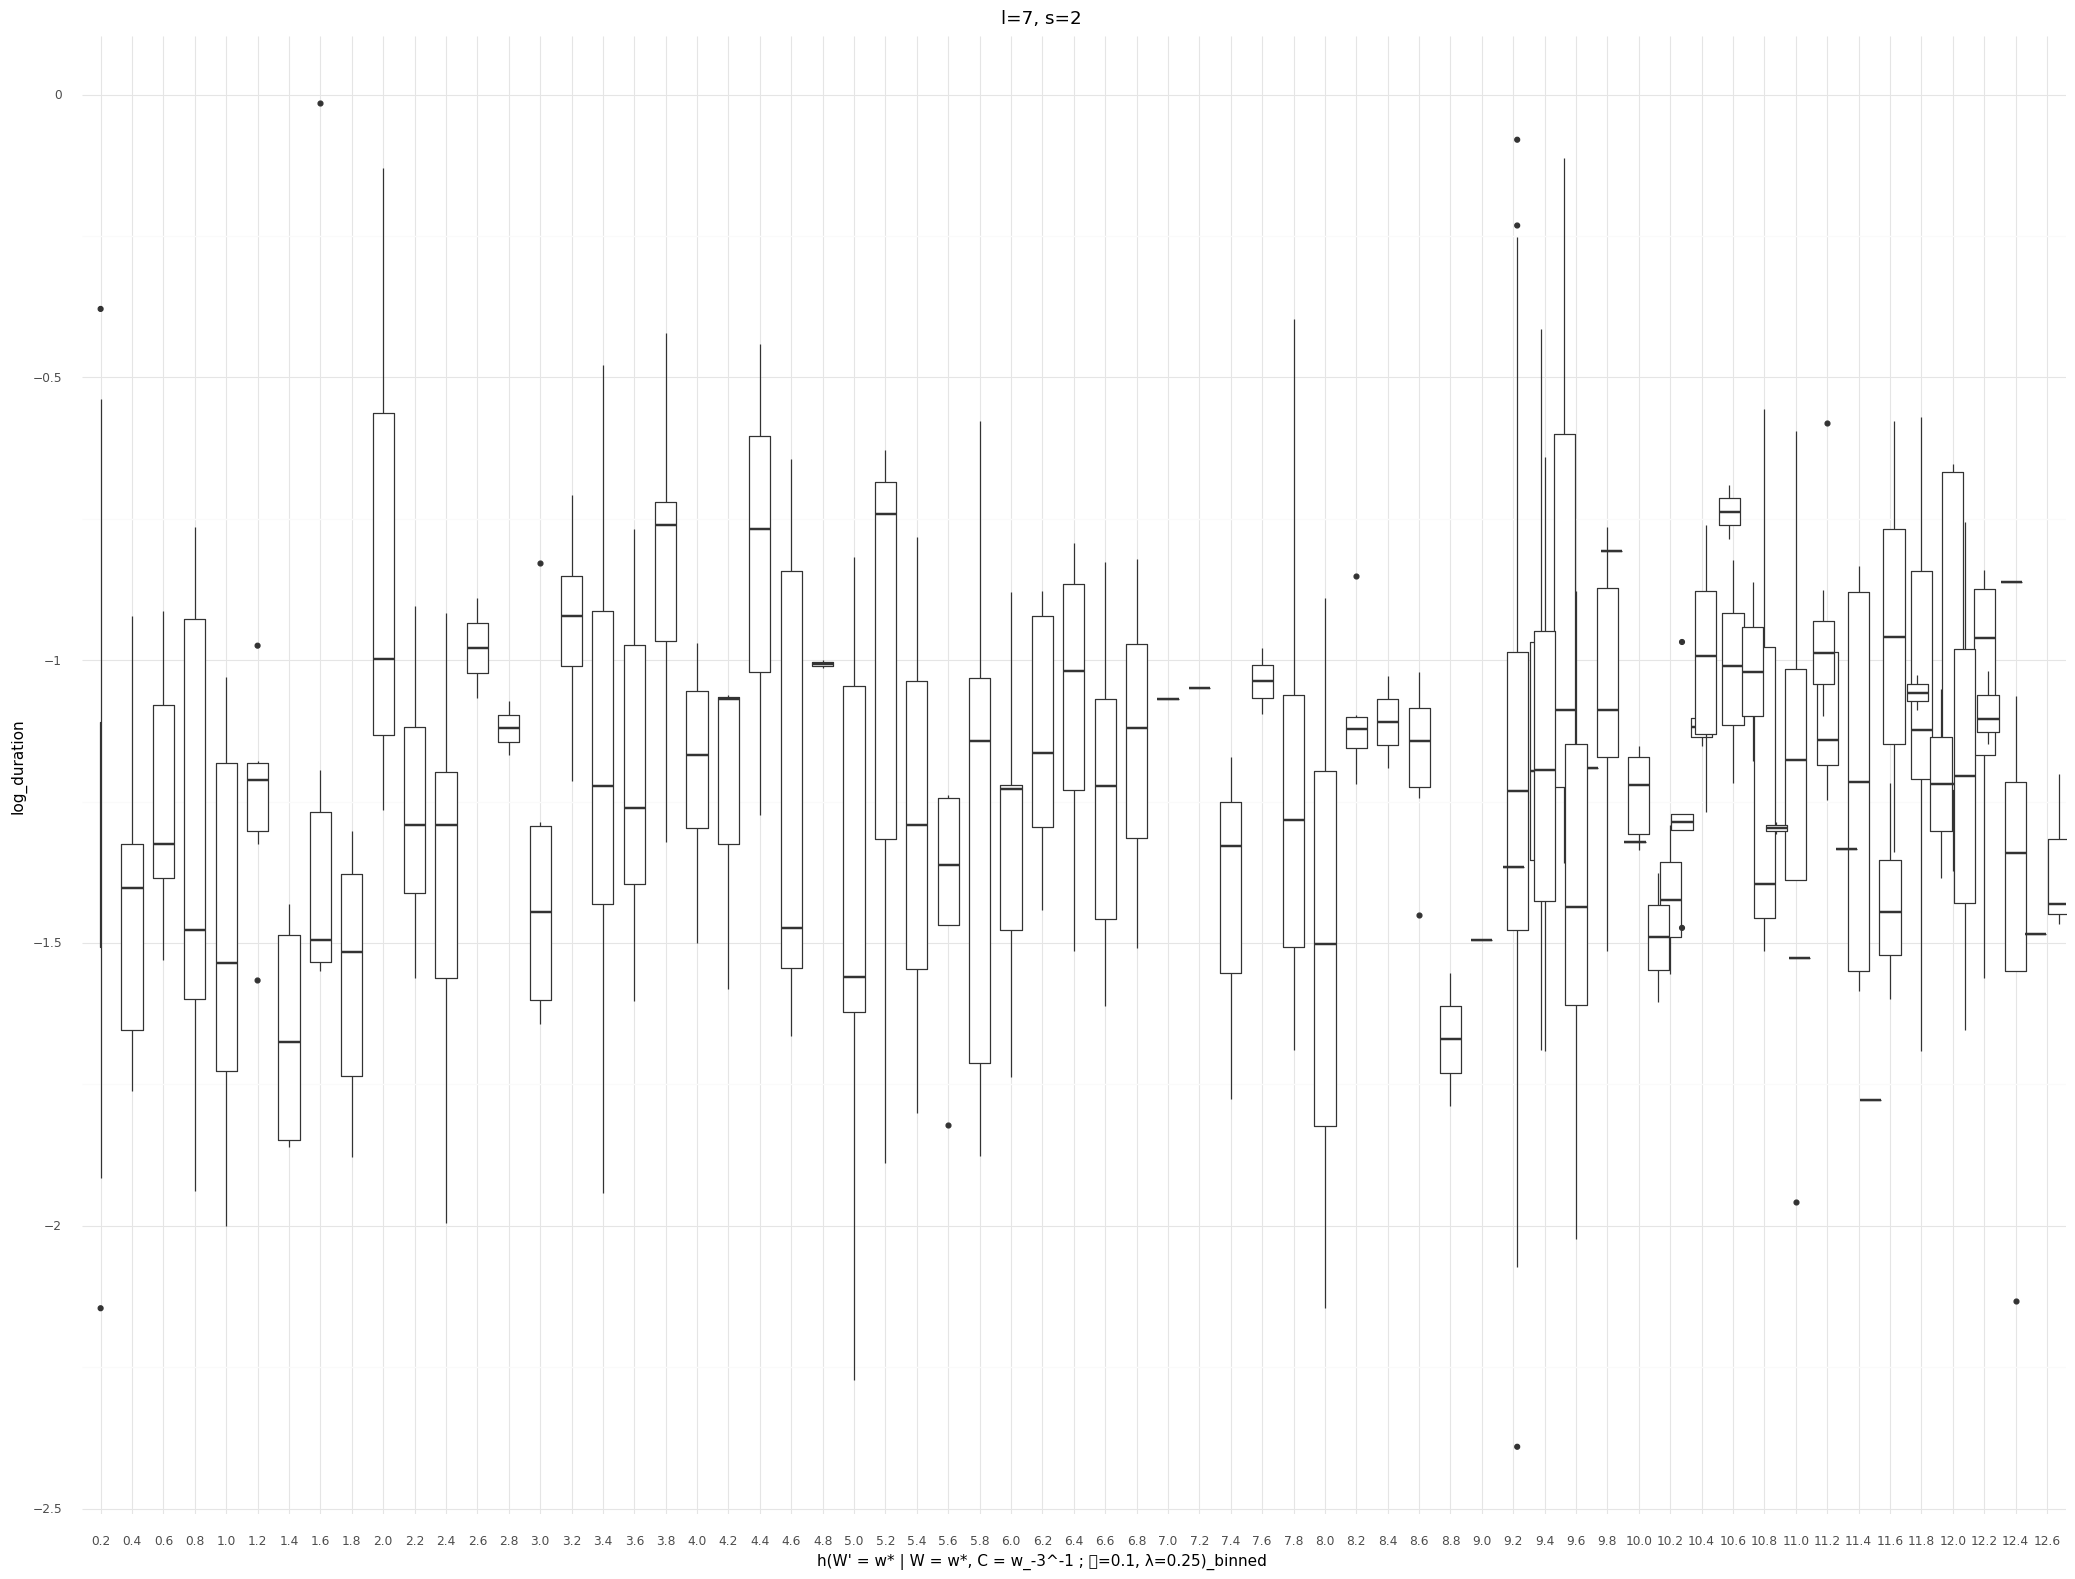

<ggplot: (8779361066213)>

................................................................................
--------------------------------------------------------------------------------
	s=2, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=2, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=2, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


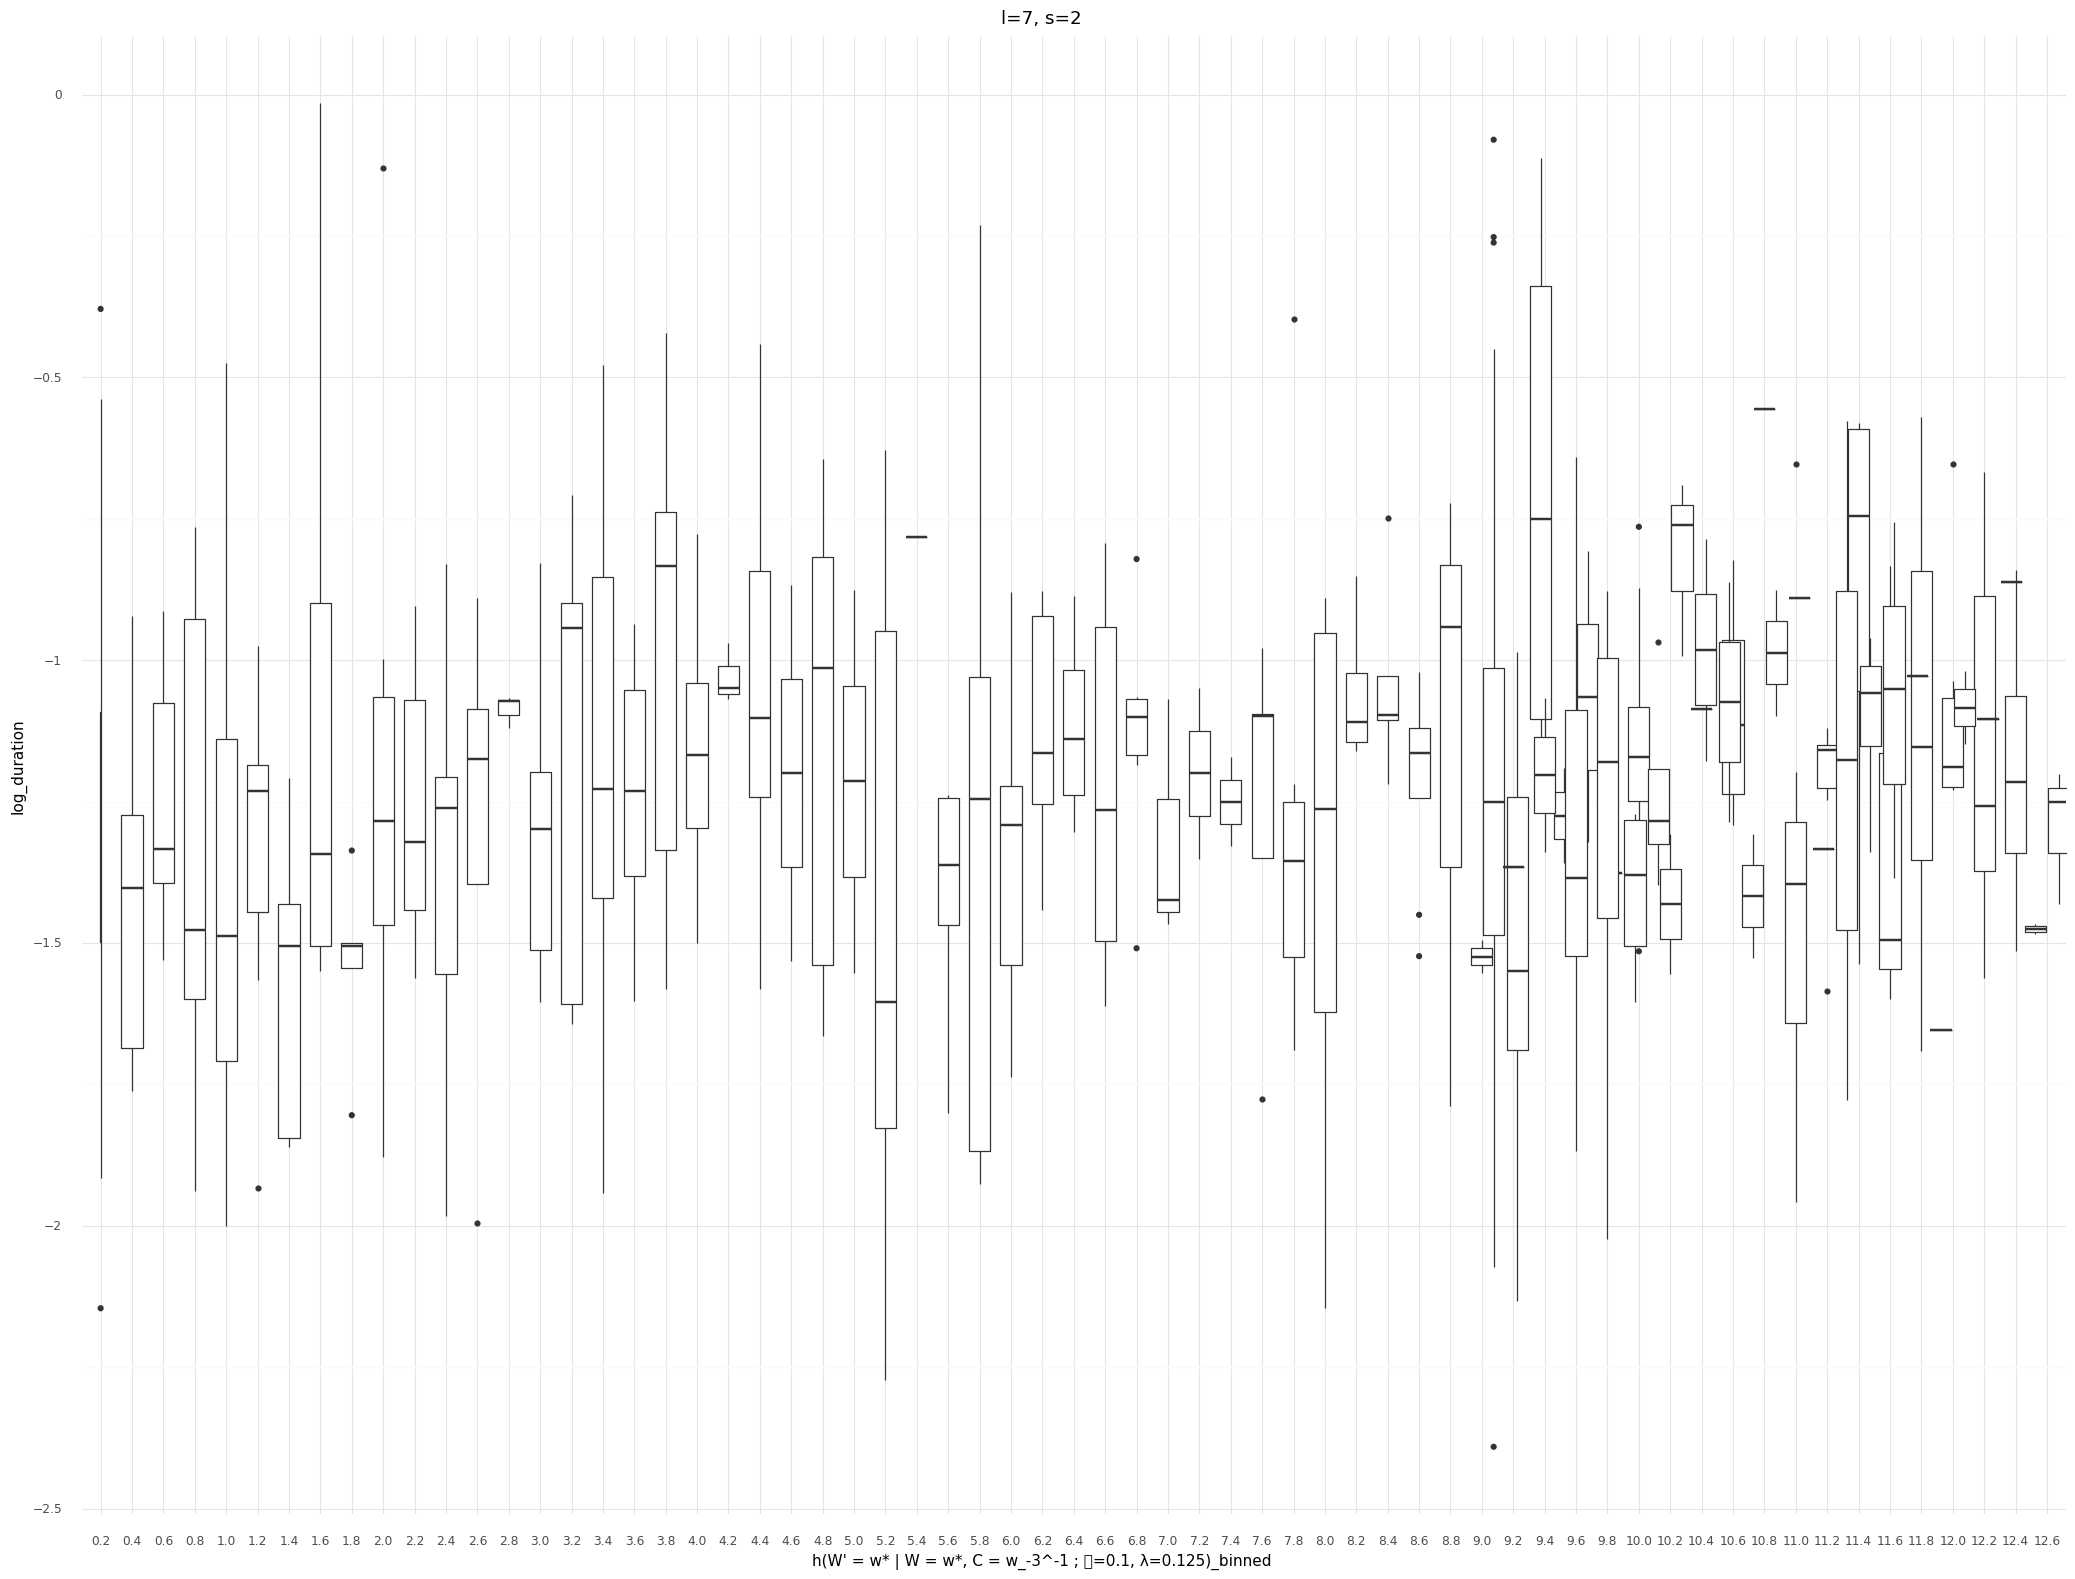

<ggplot: (8779360248773)>

................................................................................
--------------------------------------------------------------------------------


s=3, l=6
	s=3, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=3, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=3, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


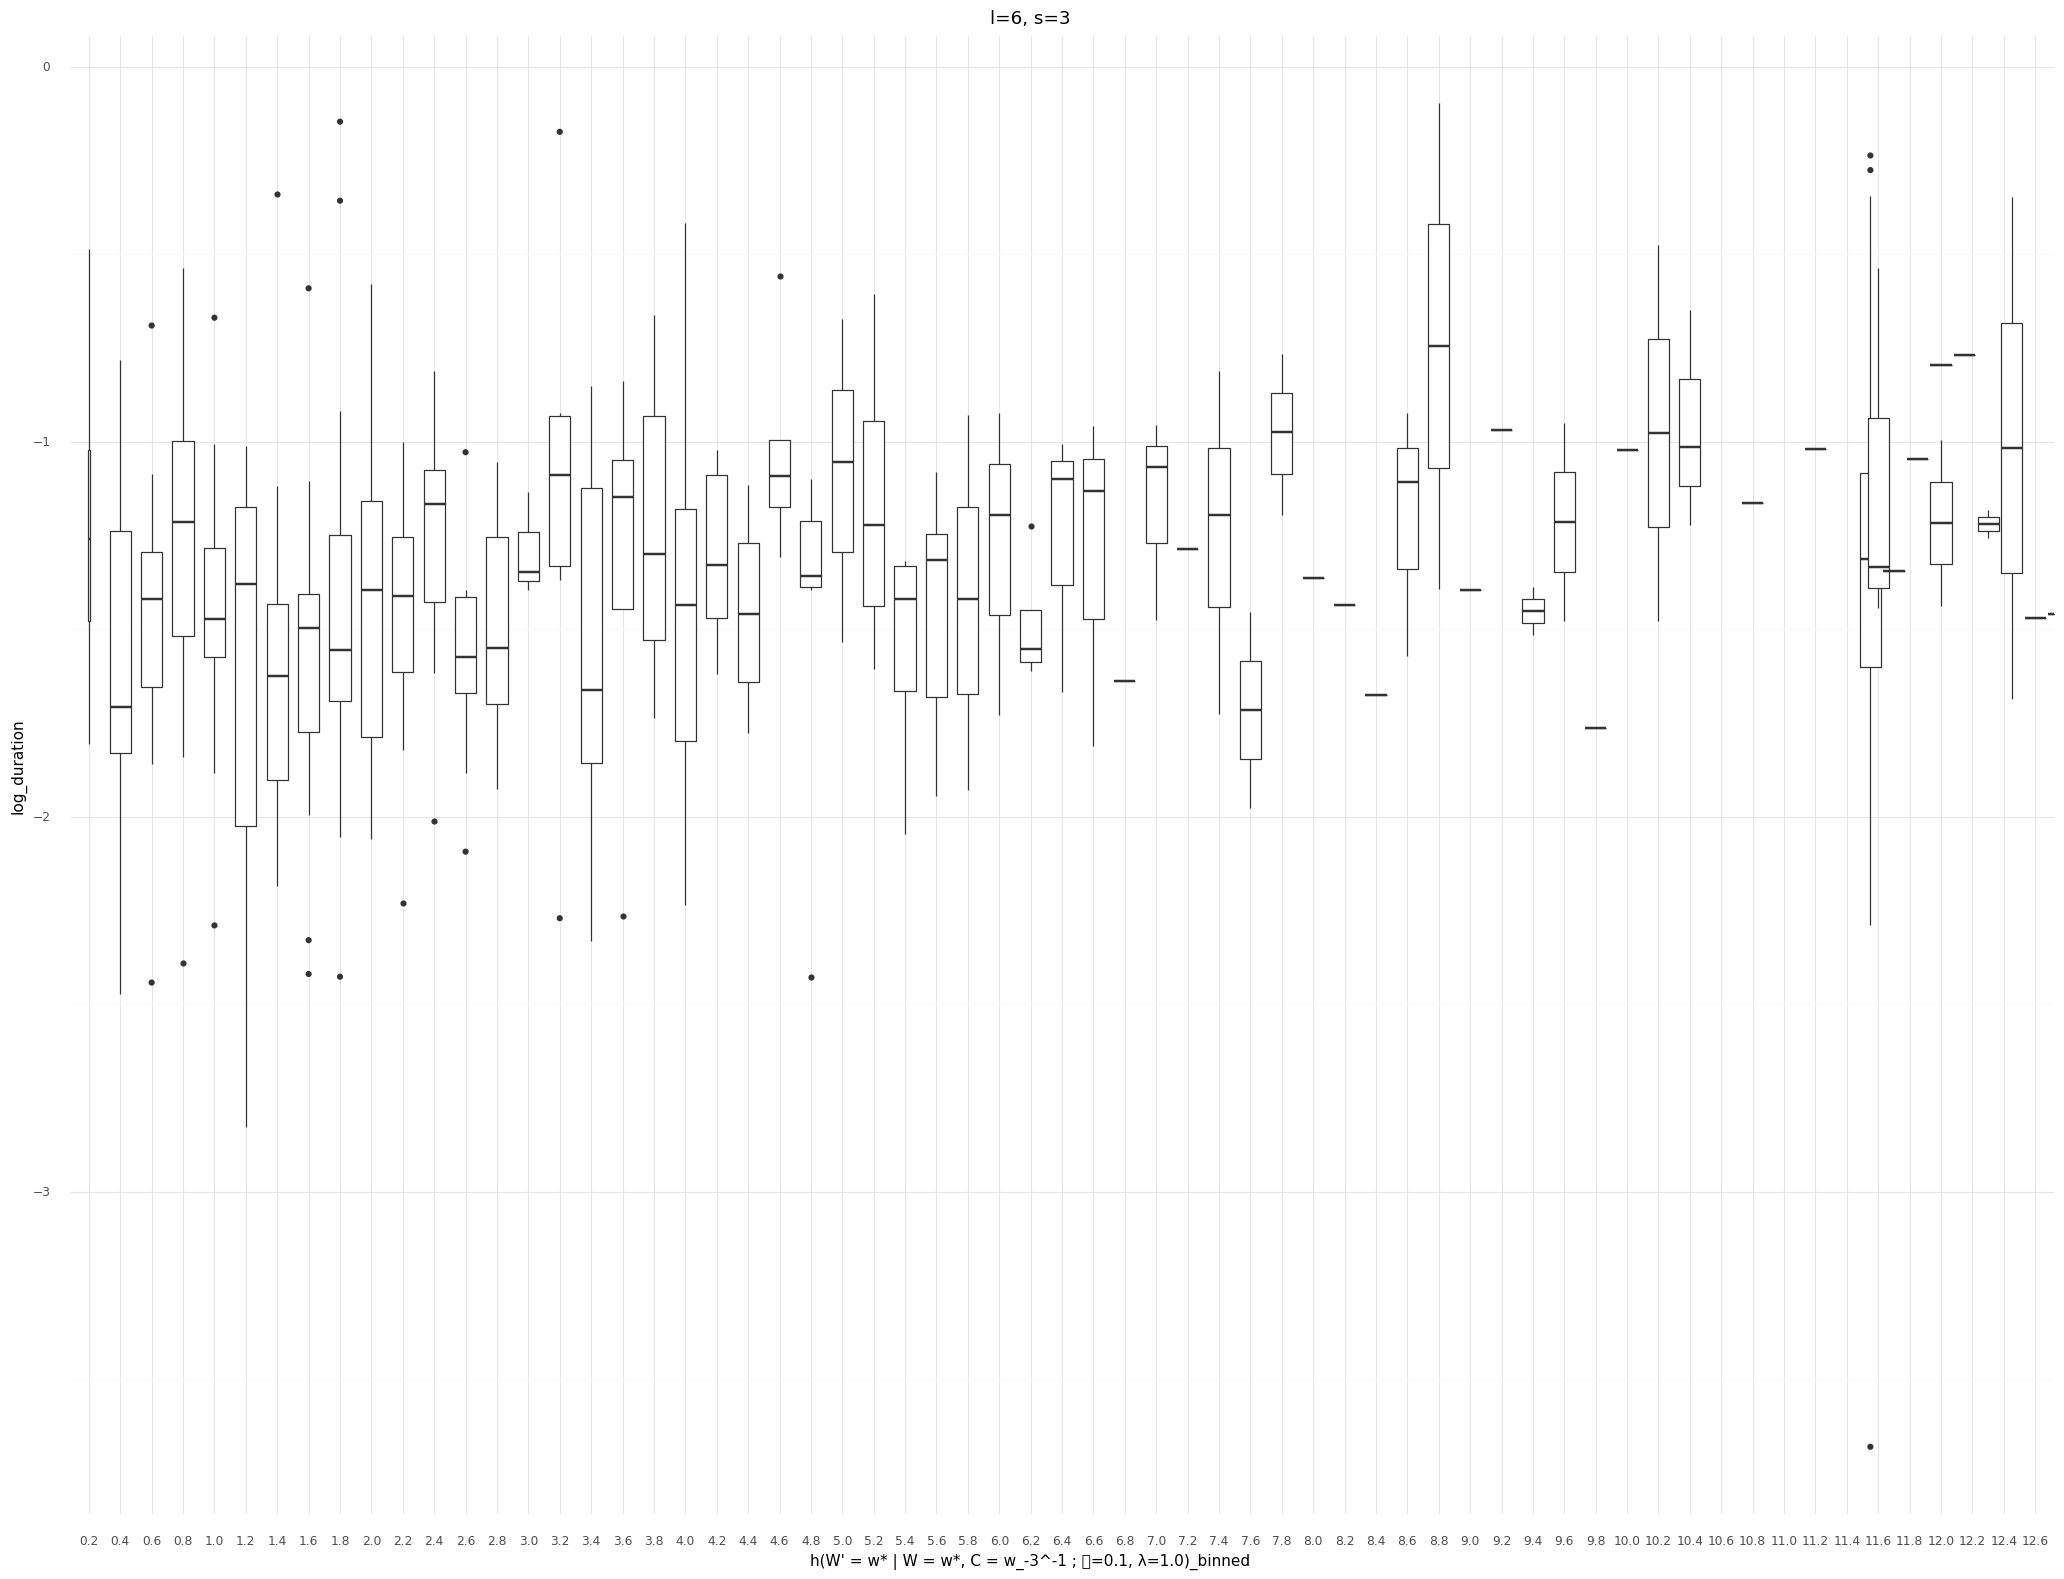

<ggplot: (8779360856697)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=3, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=3, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


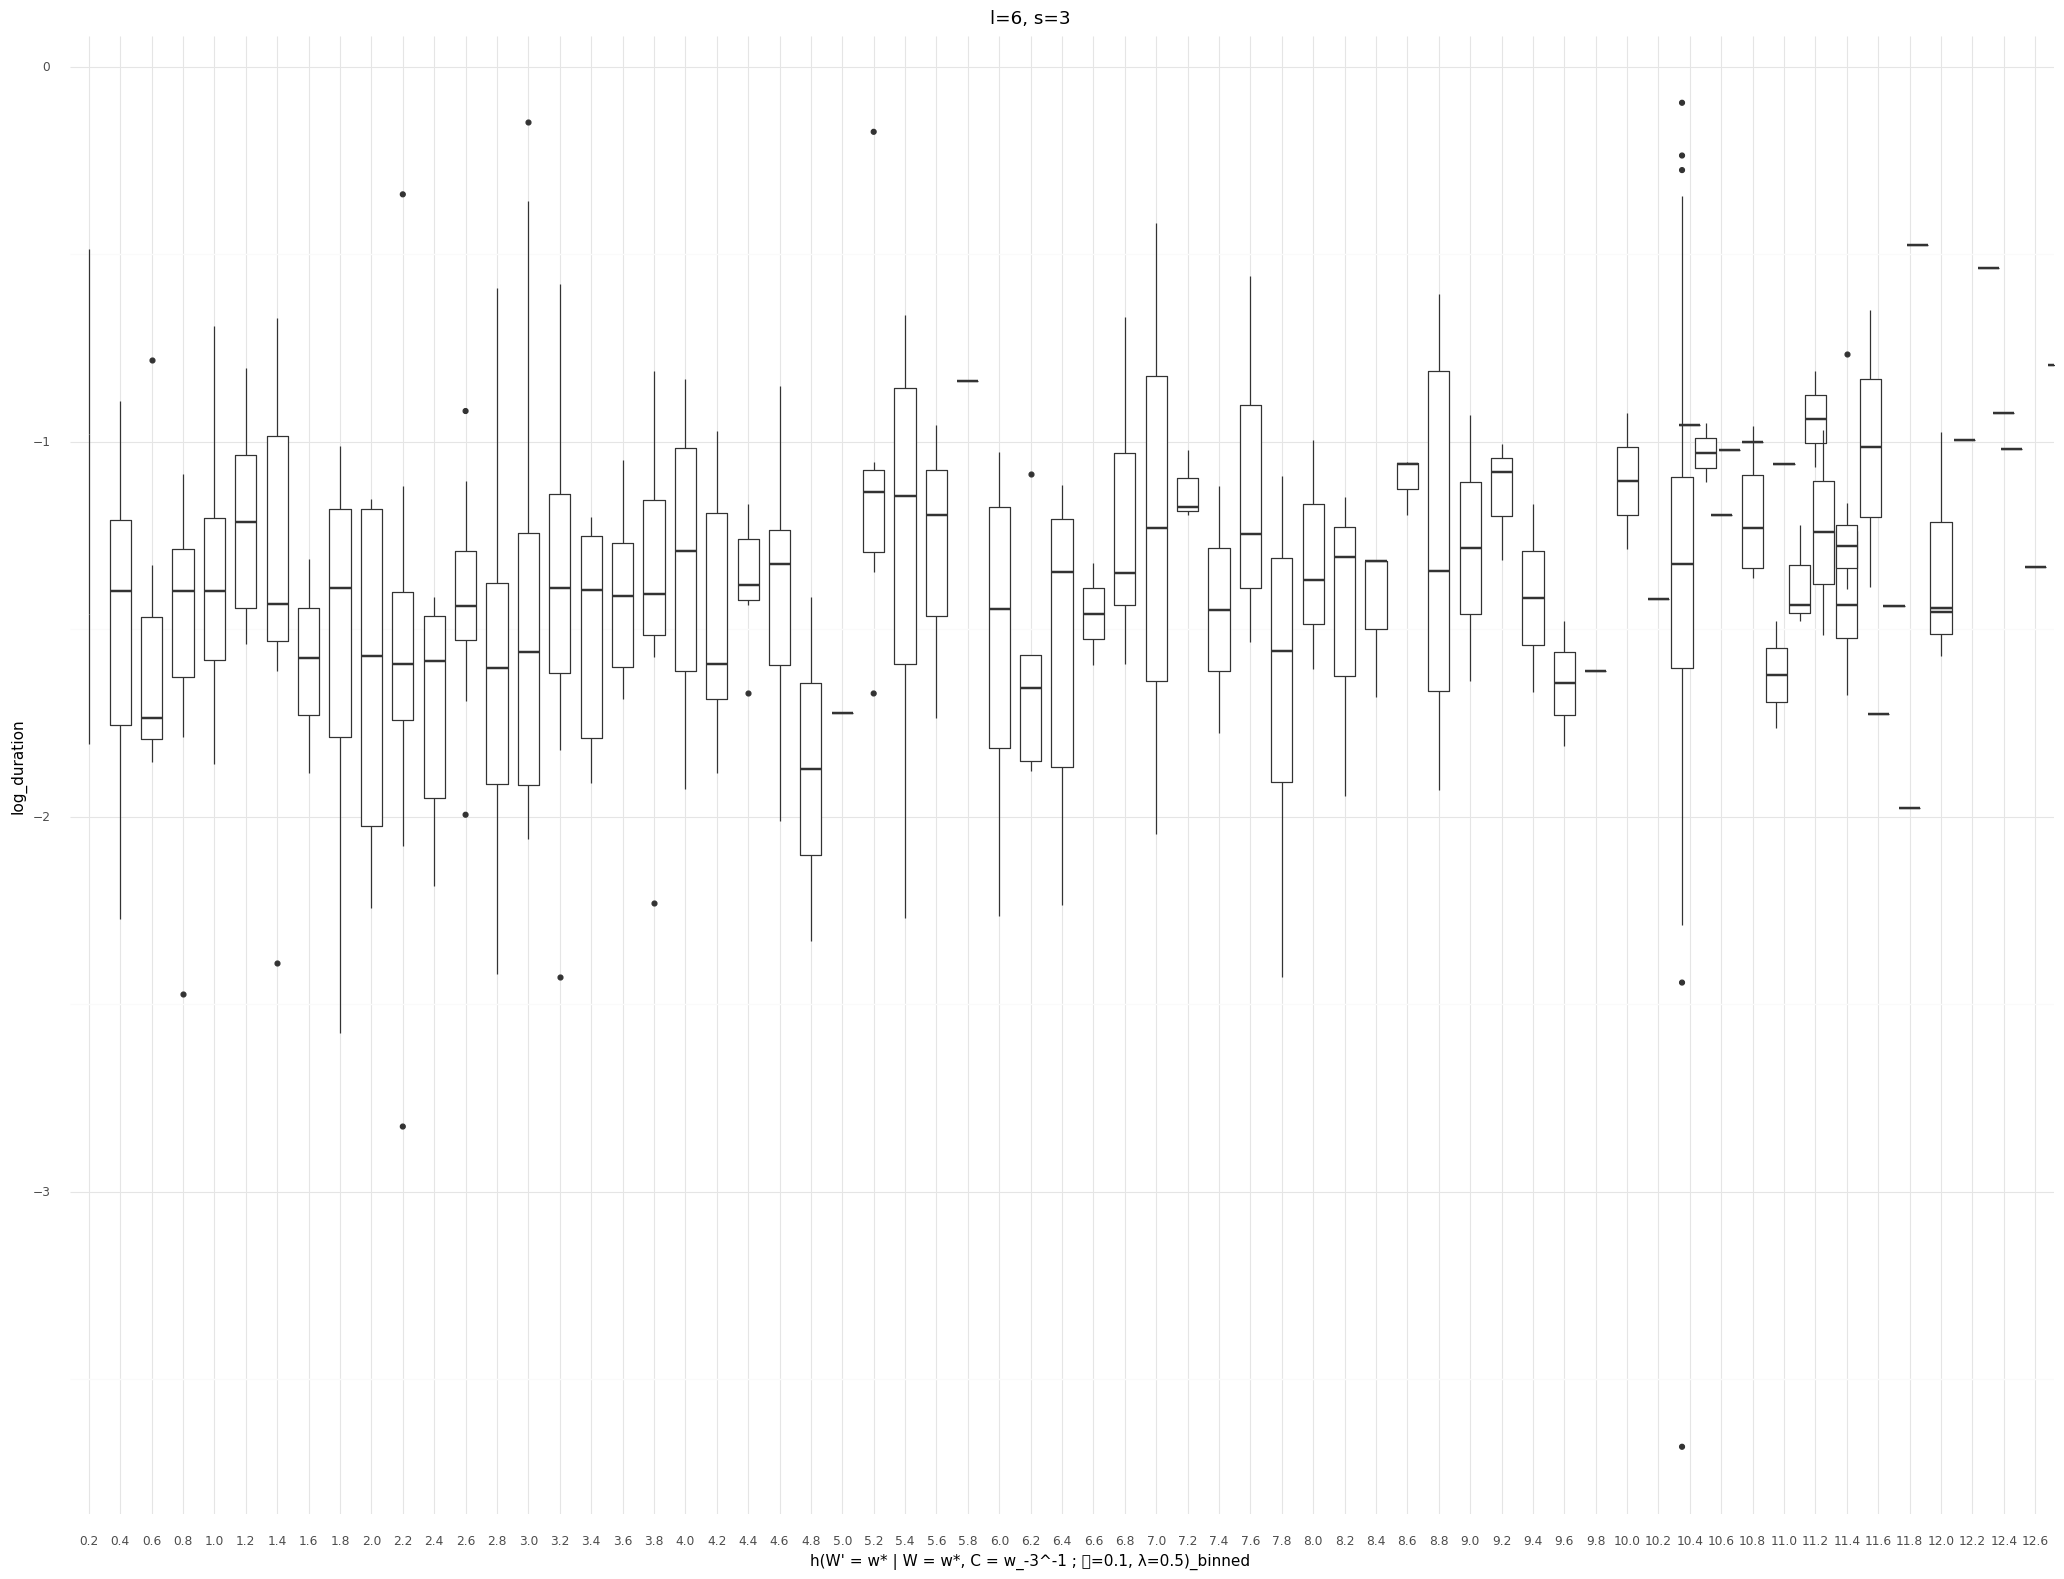

<ggplot: (8779372634341)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=3, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=3, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


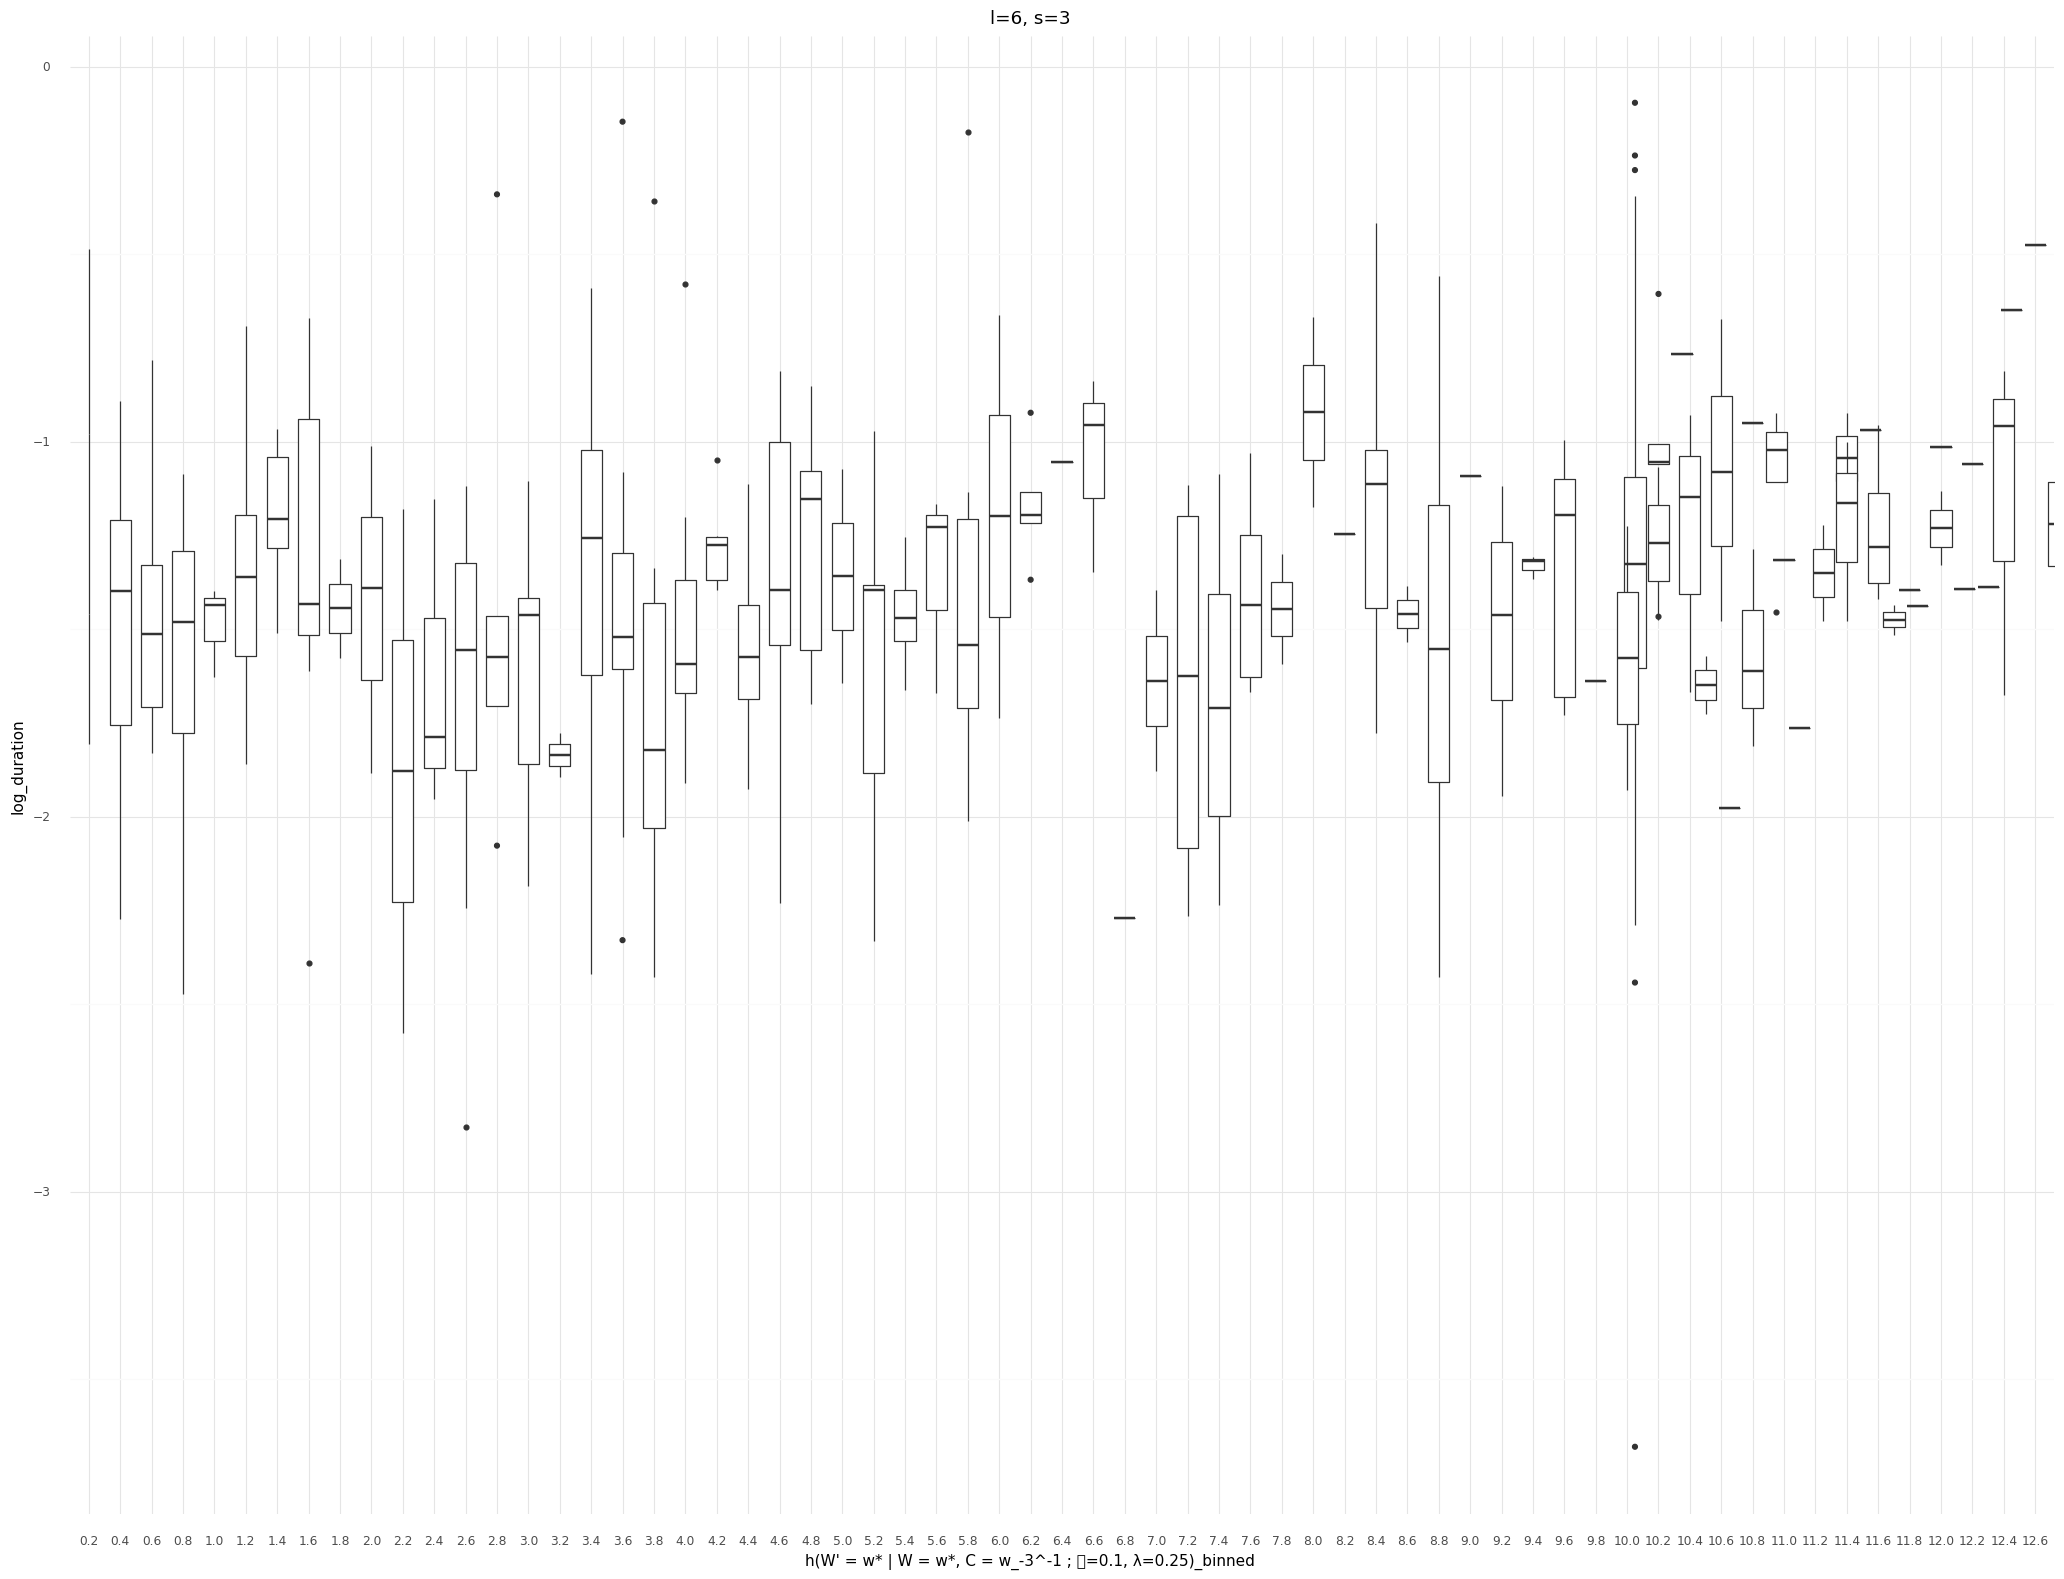

<ggplot: (8779369217289)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=6
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=3, l=6
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=3, l=6, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


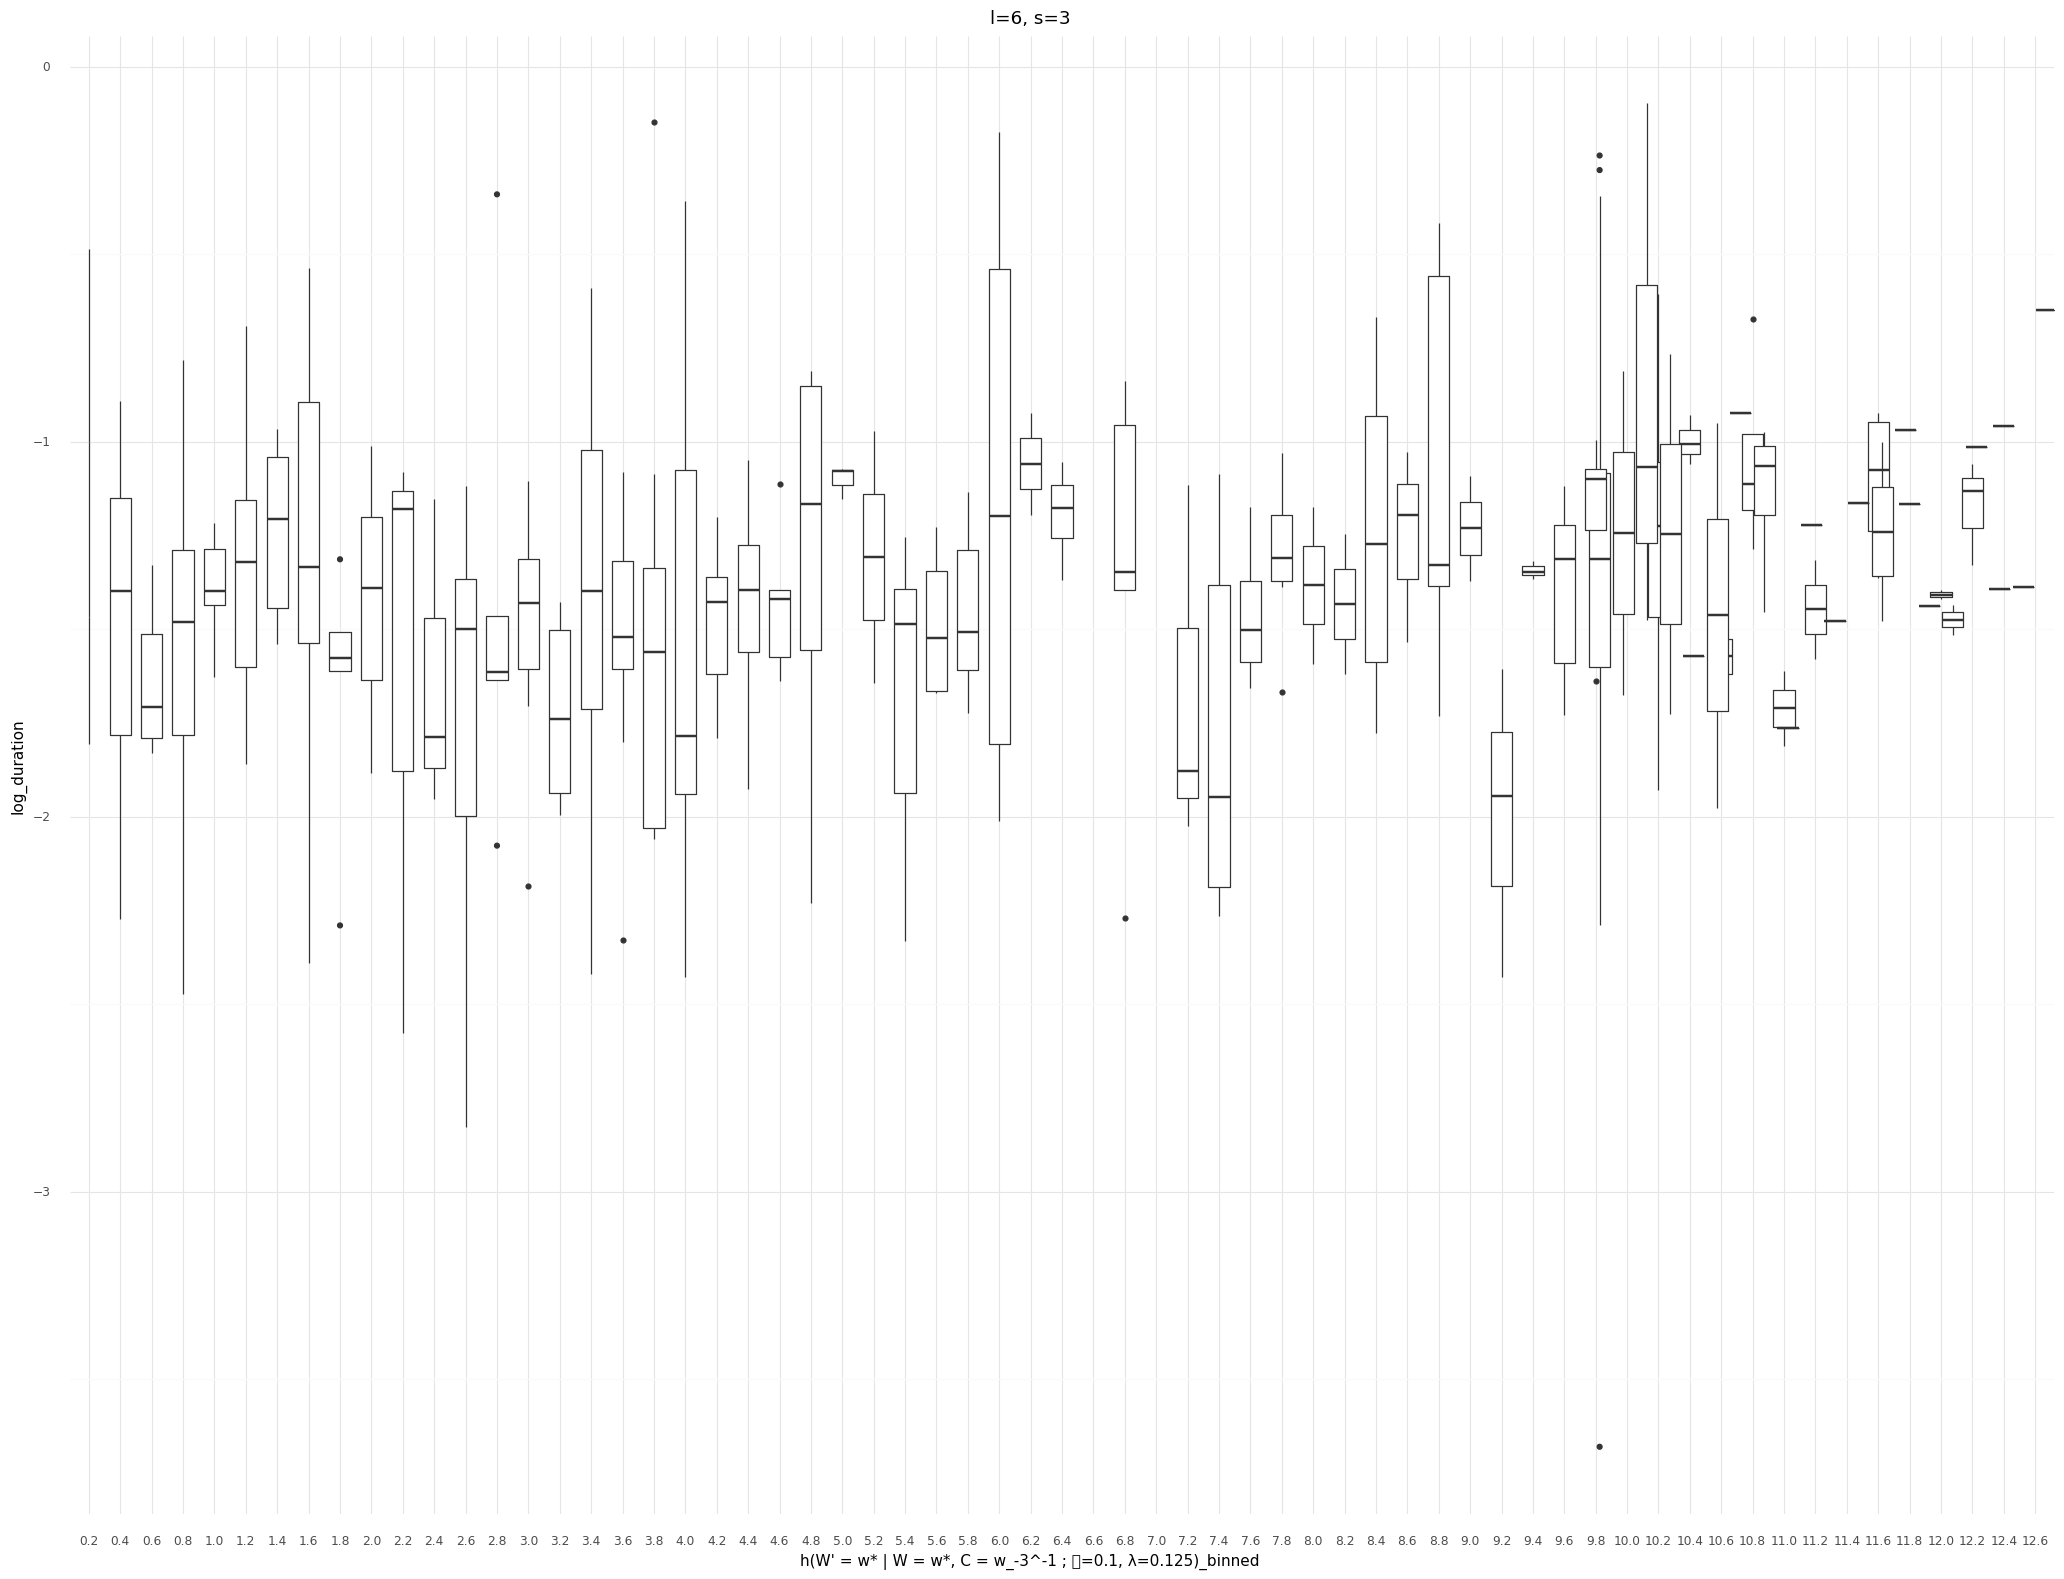

<ggplot: (8779402952189)>

................................................................................
--------------------------------------------------------------------------------


s=3, l=7
	s=3, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=3, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=3, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


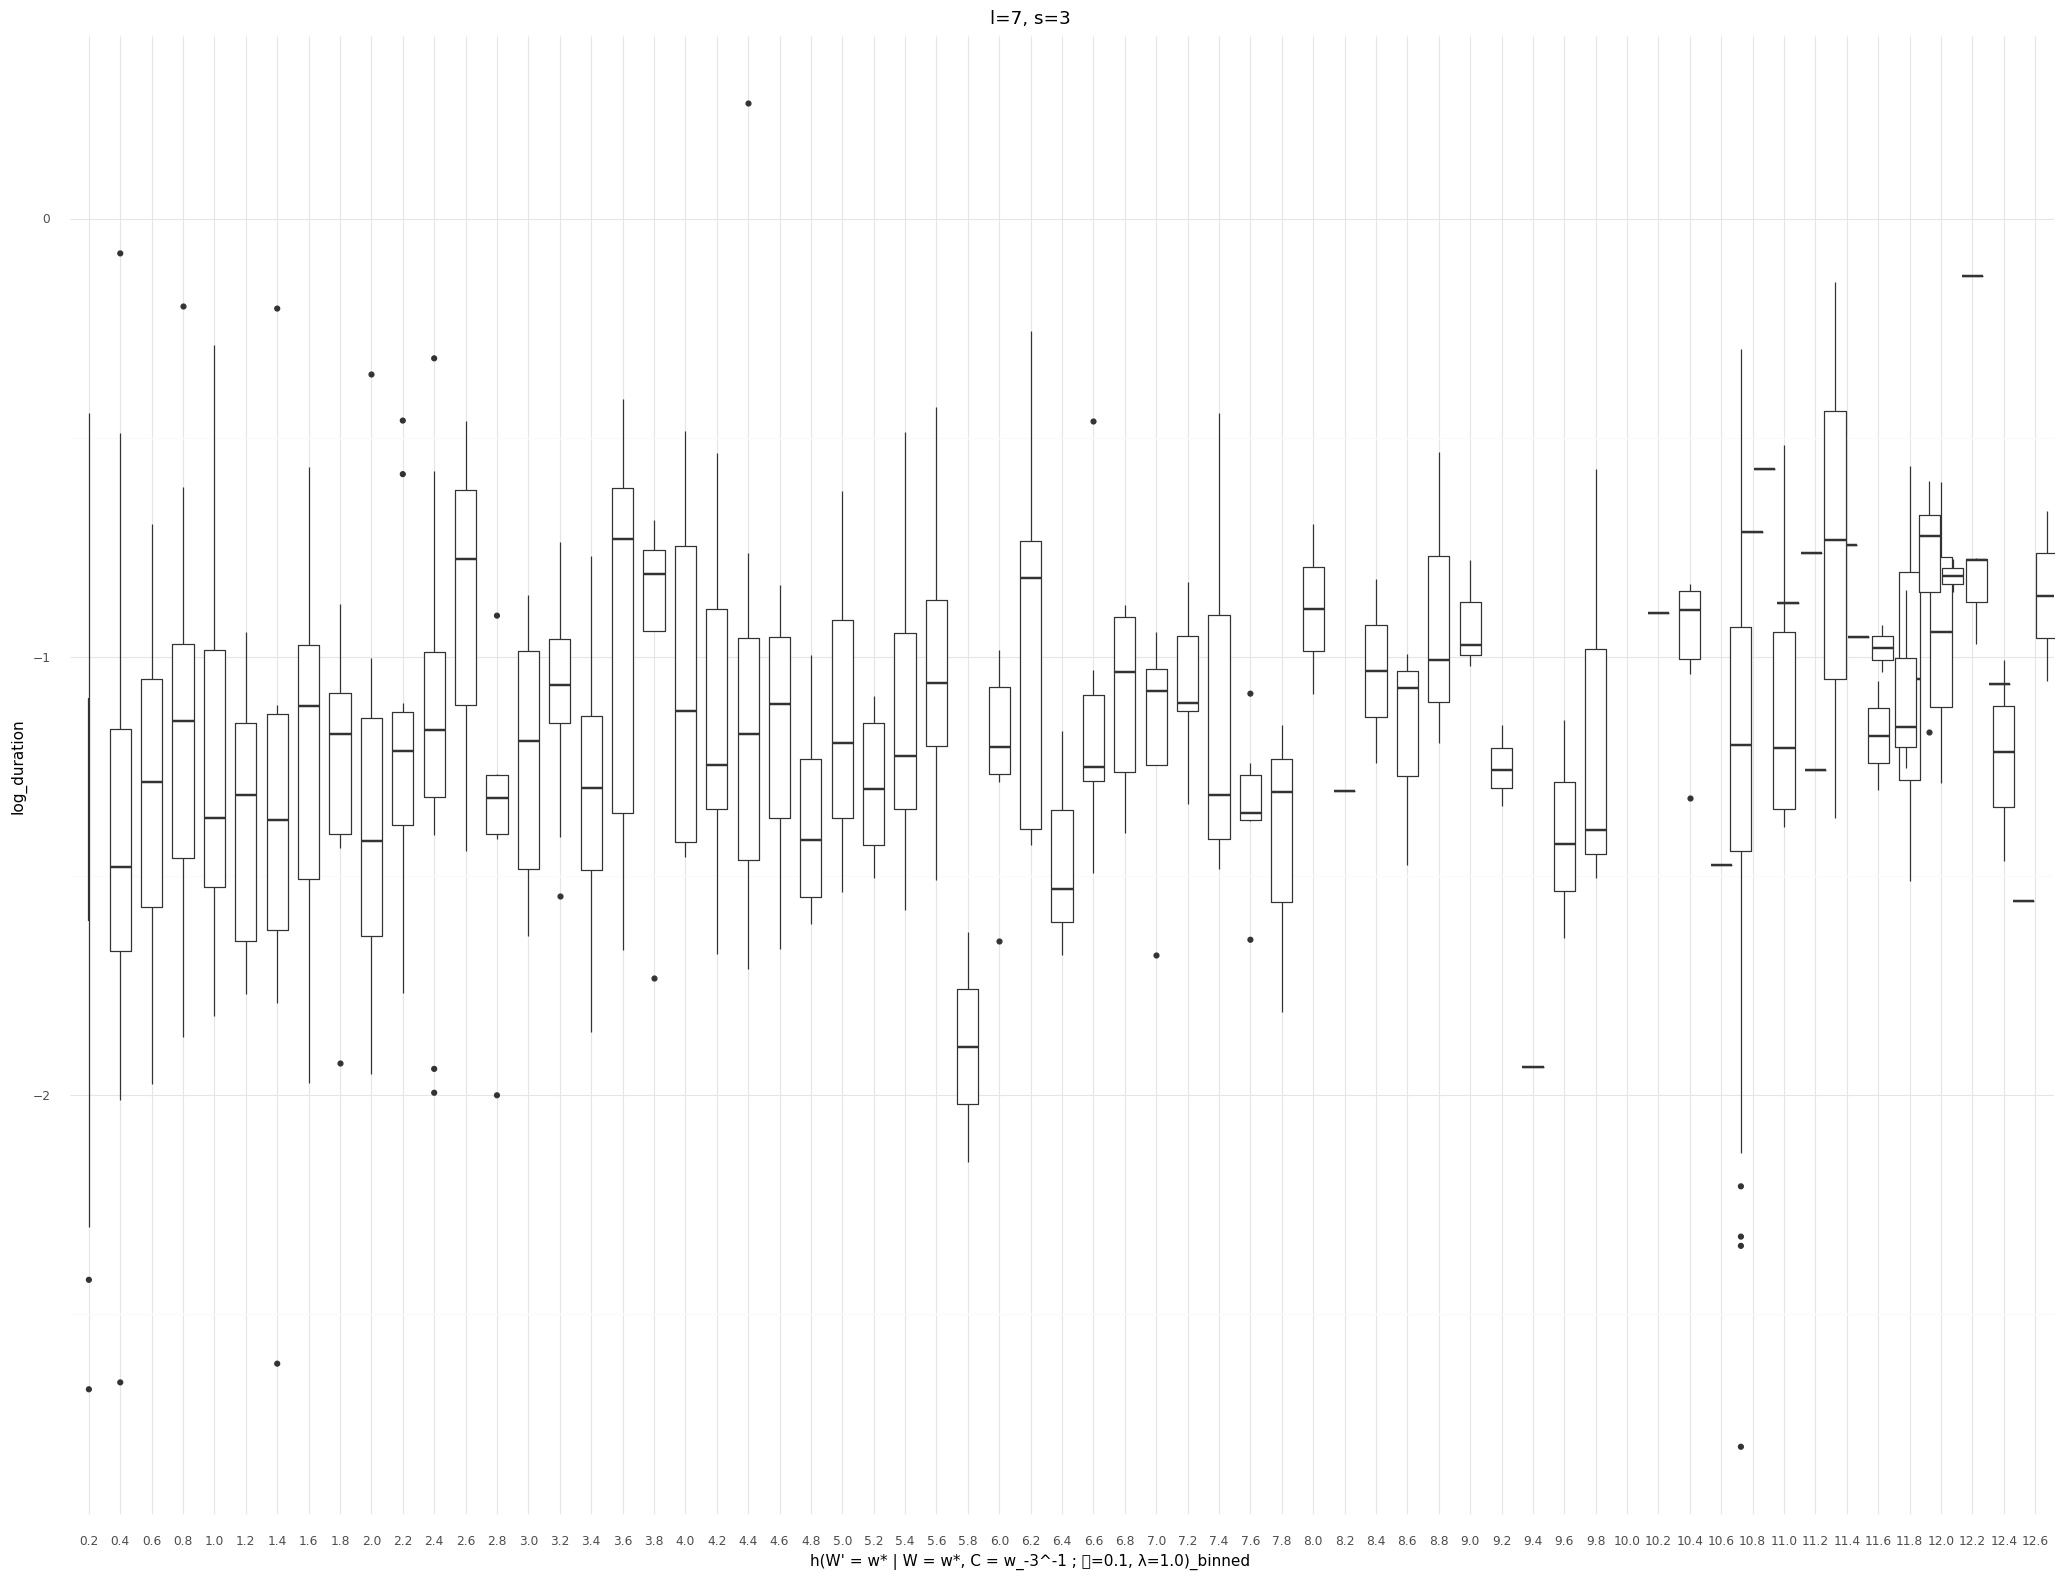

<ggplot: (8779360608429)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=3, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=3, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


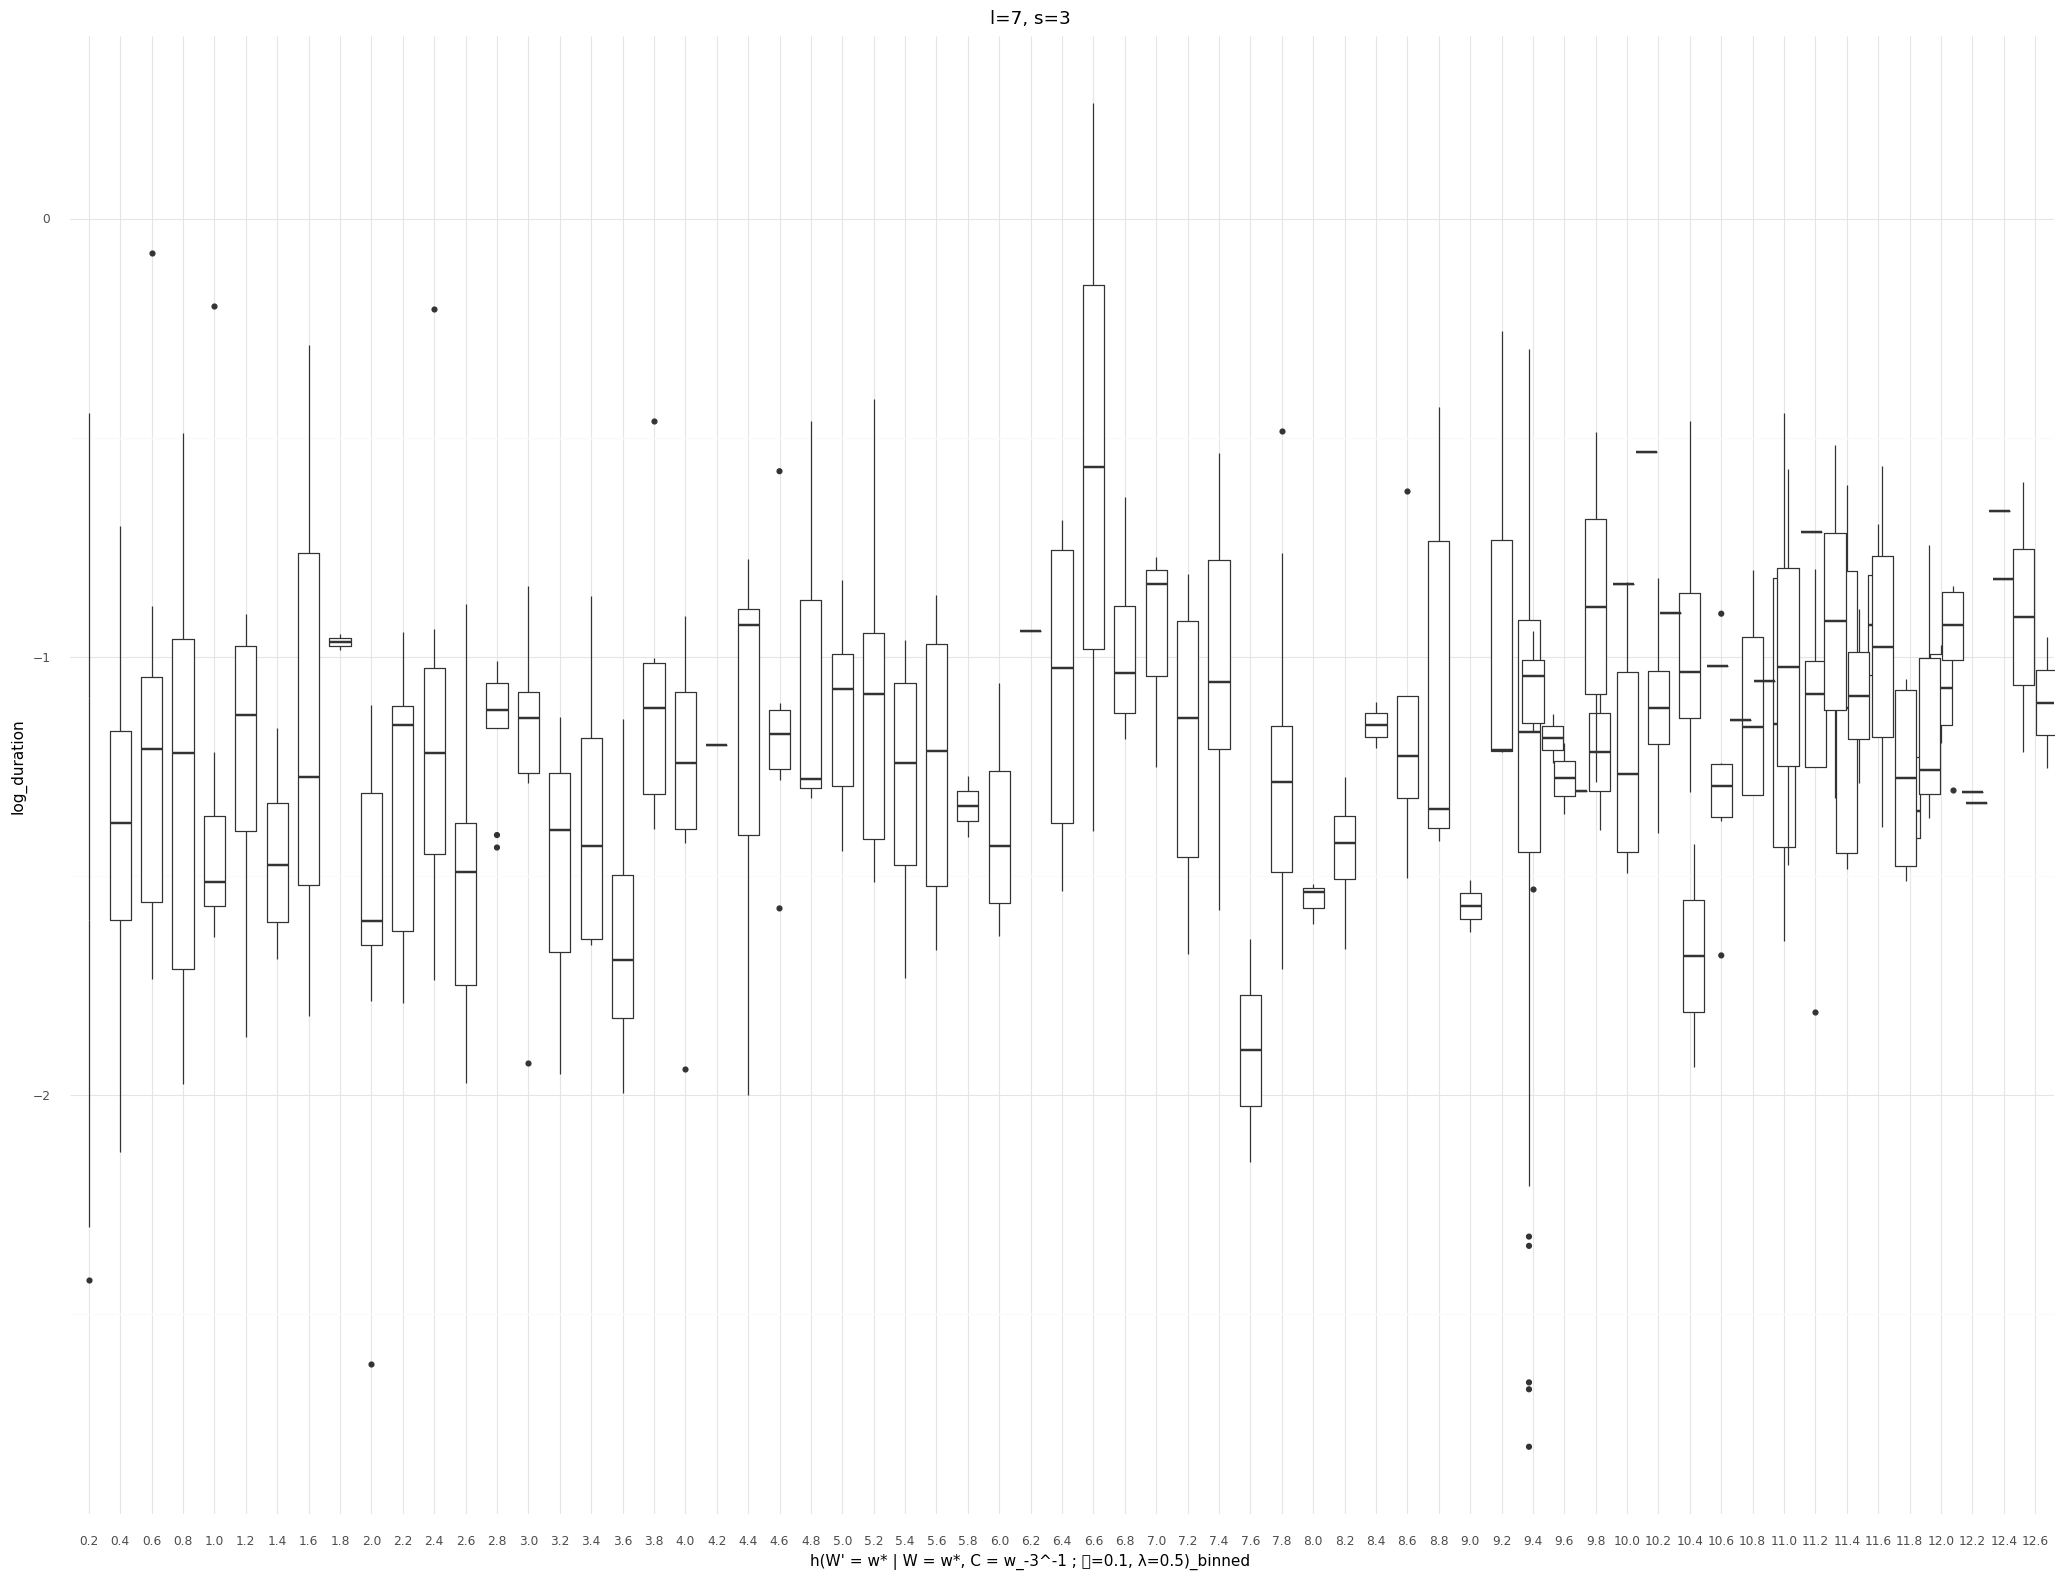

<ggplot: (8779392240193)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=3, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=3, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


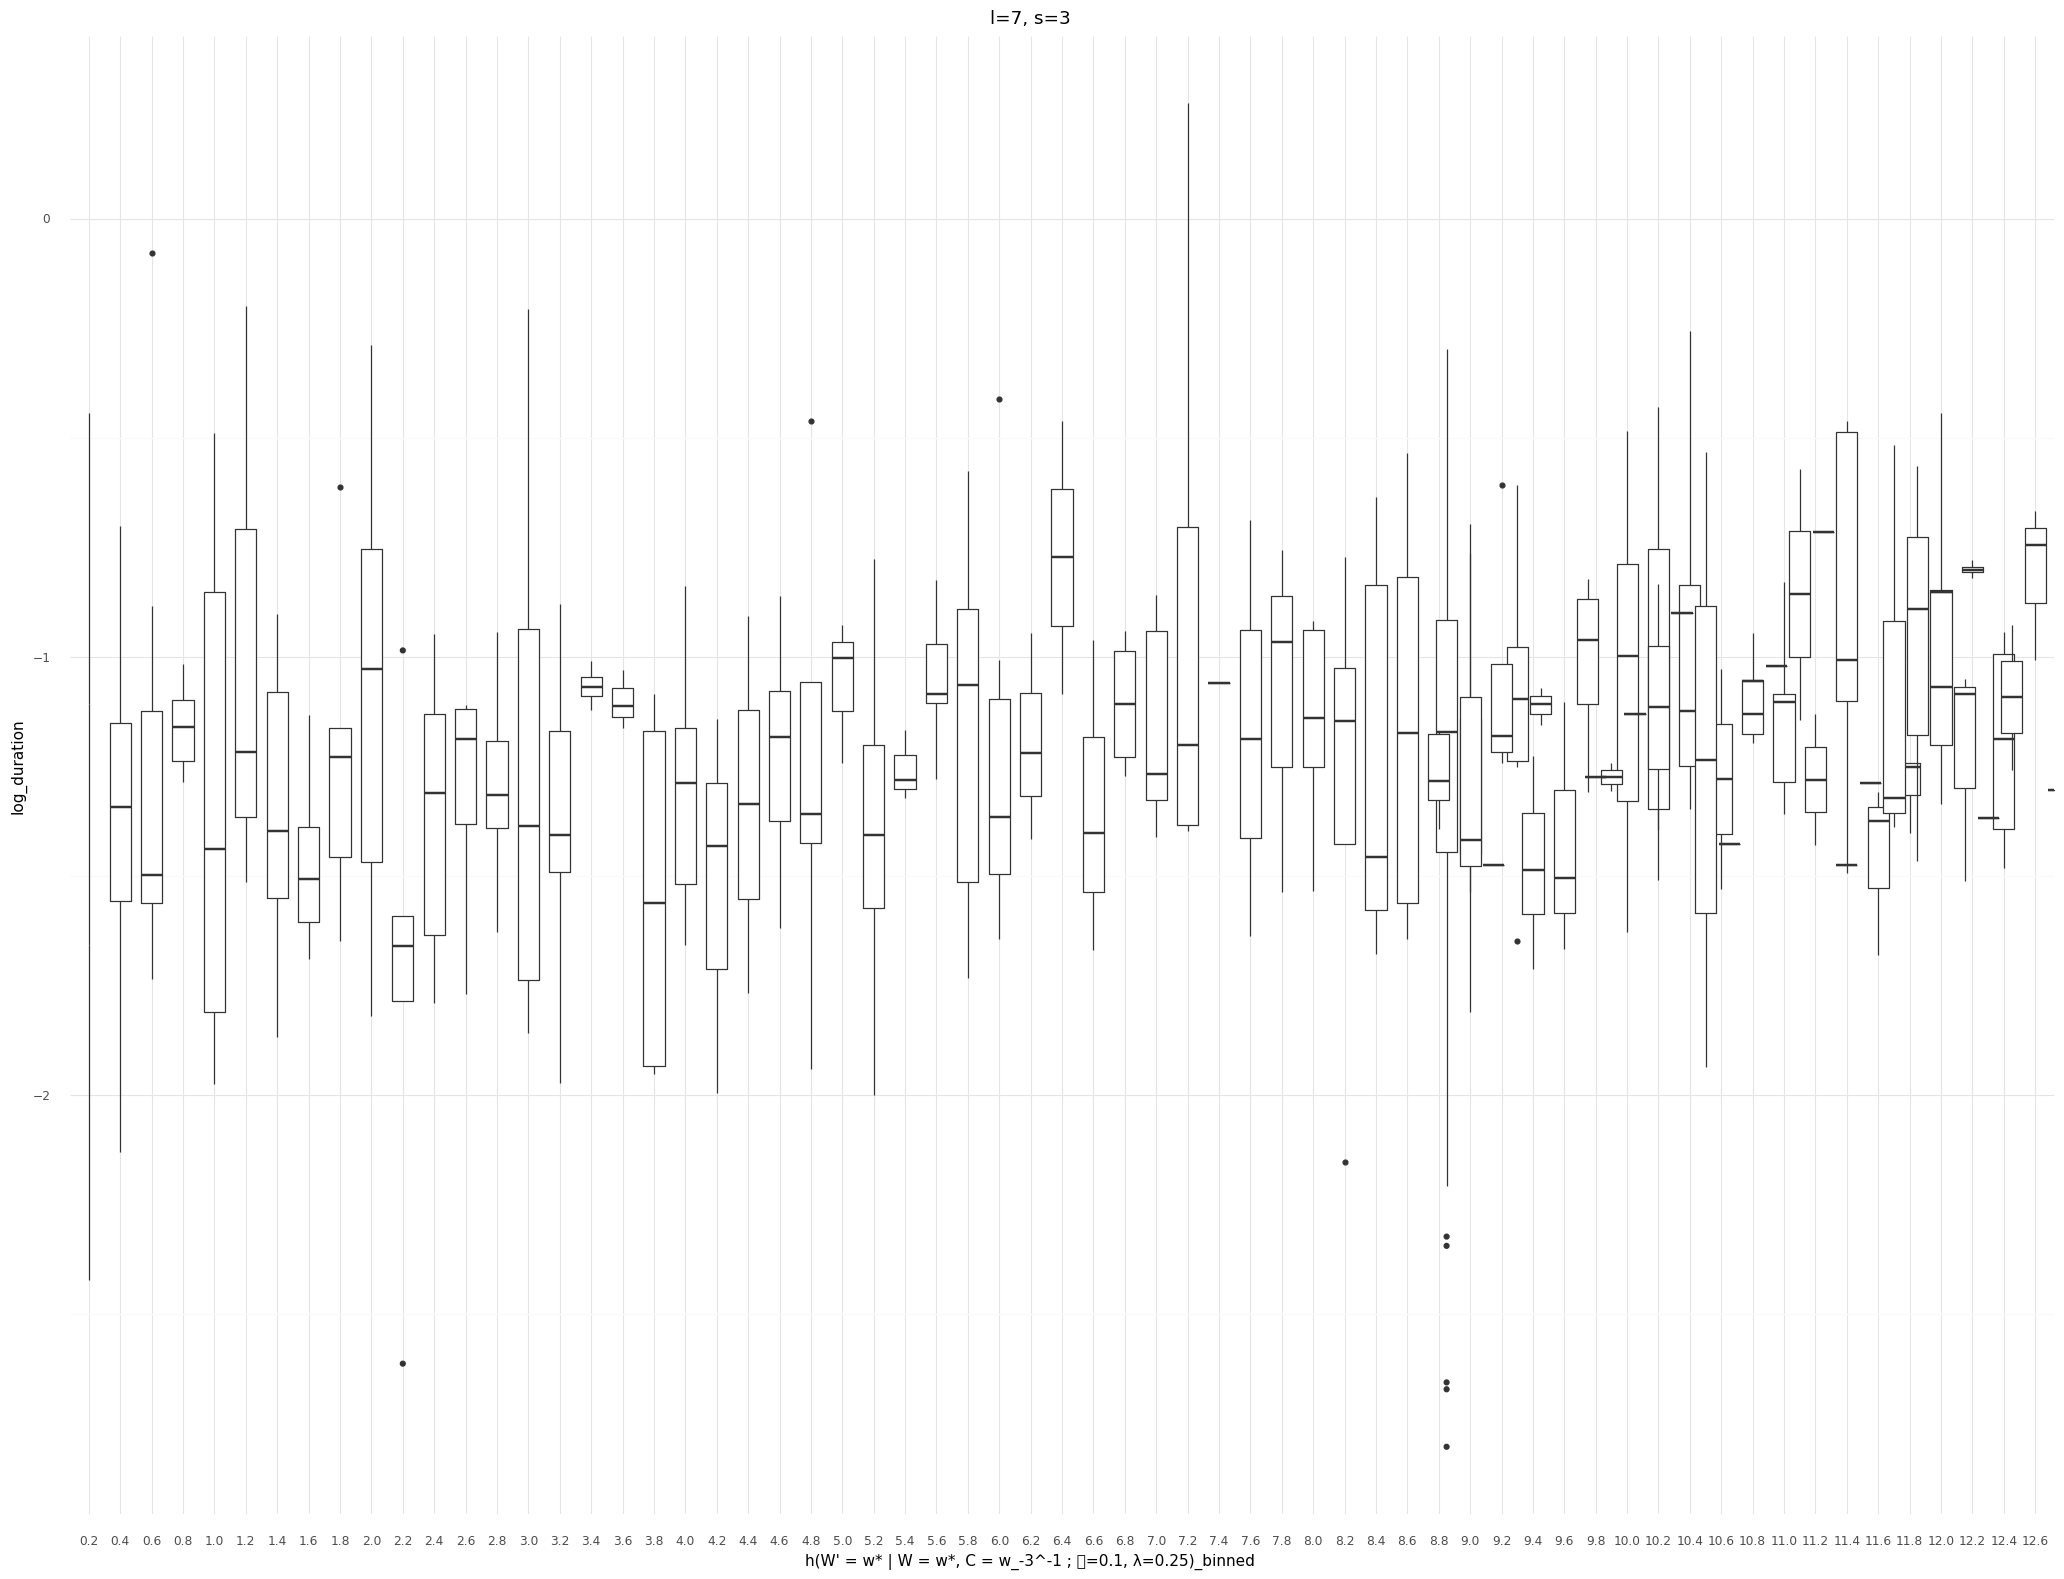

<ggplot: (8779277201009)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=7
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=3, l=7
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=3, l=7, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


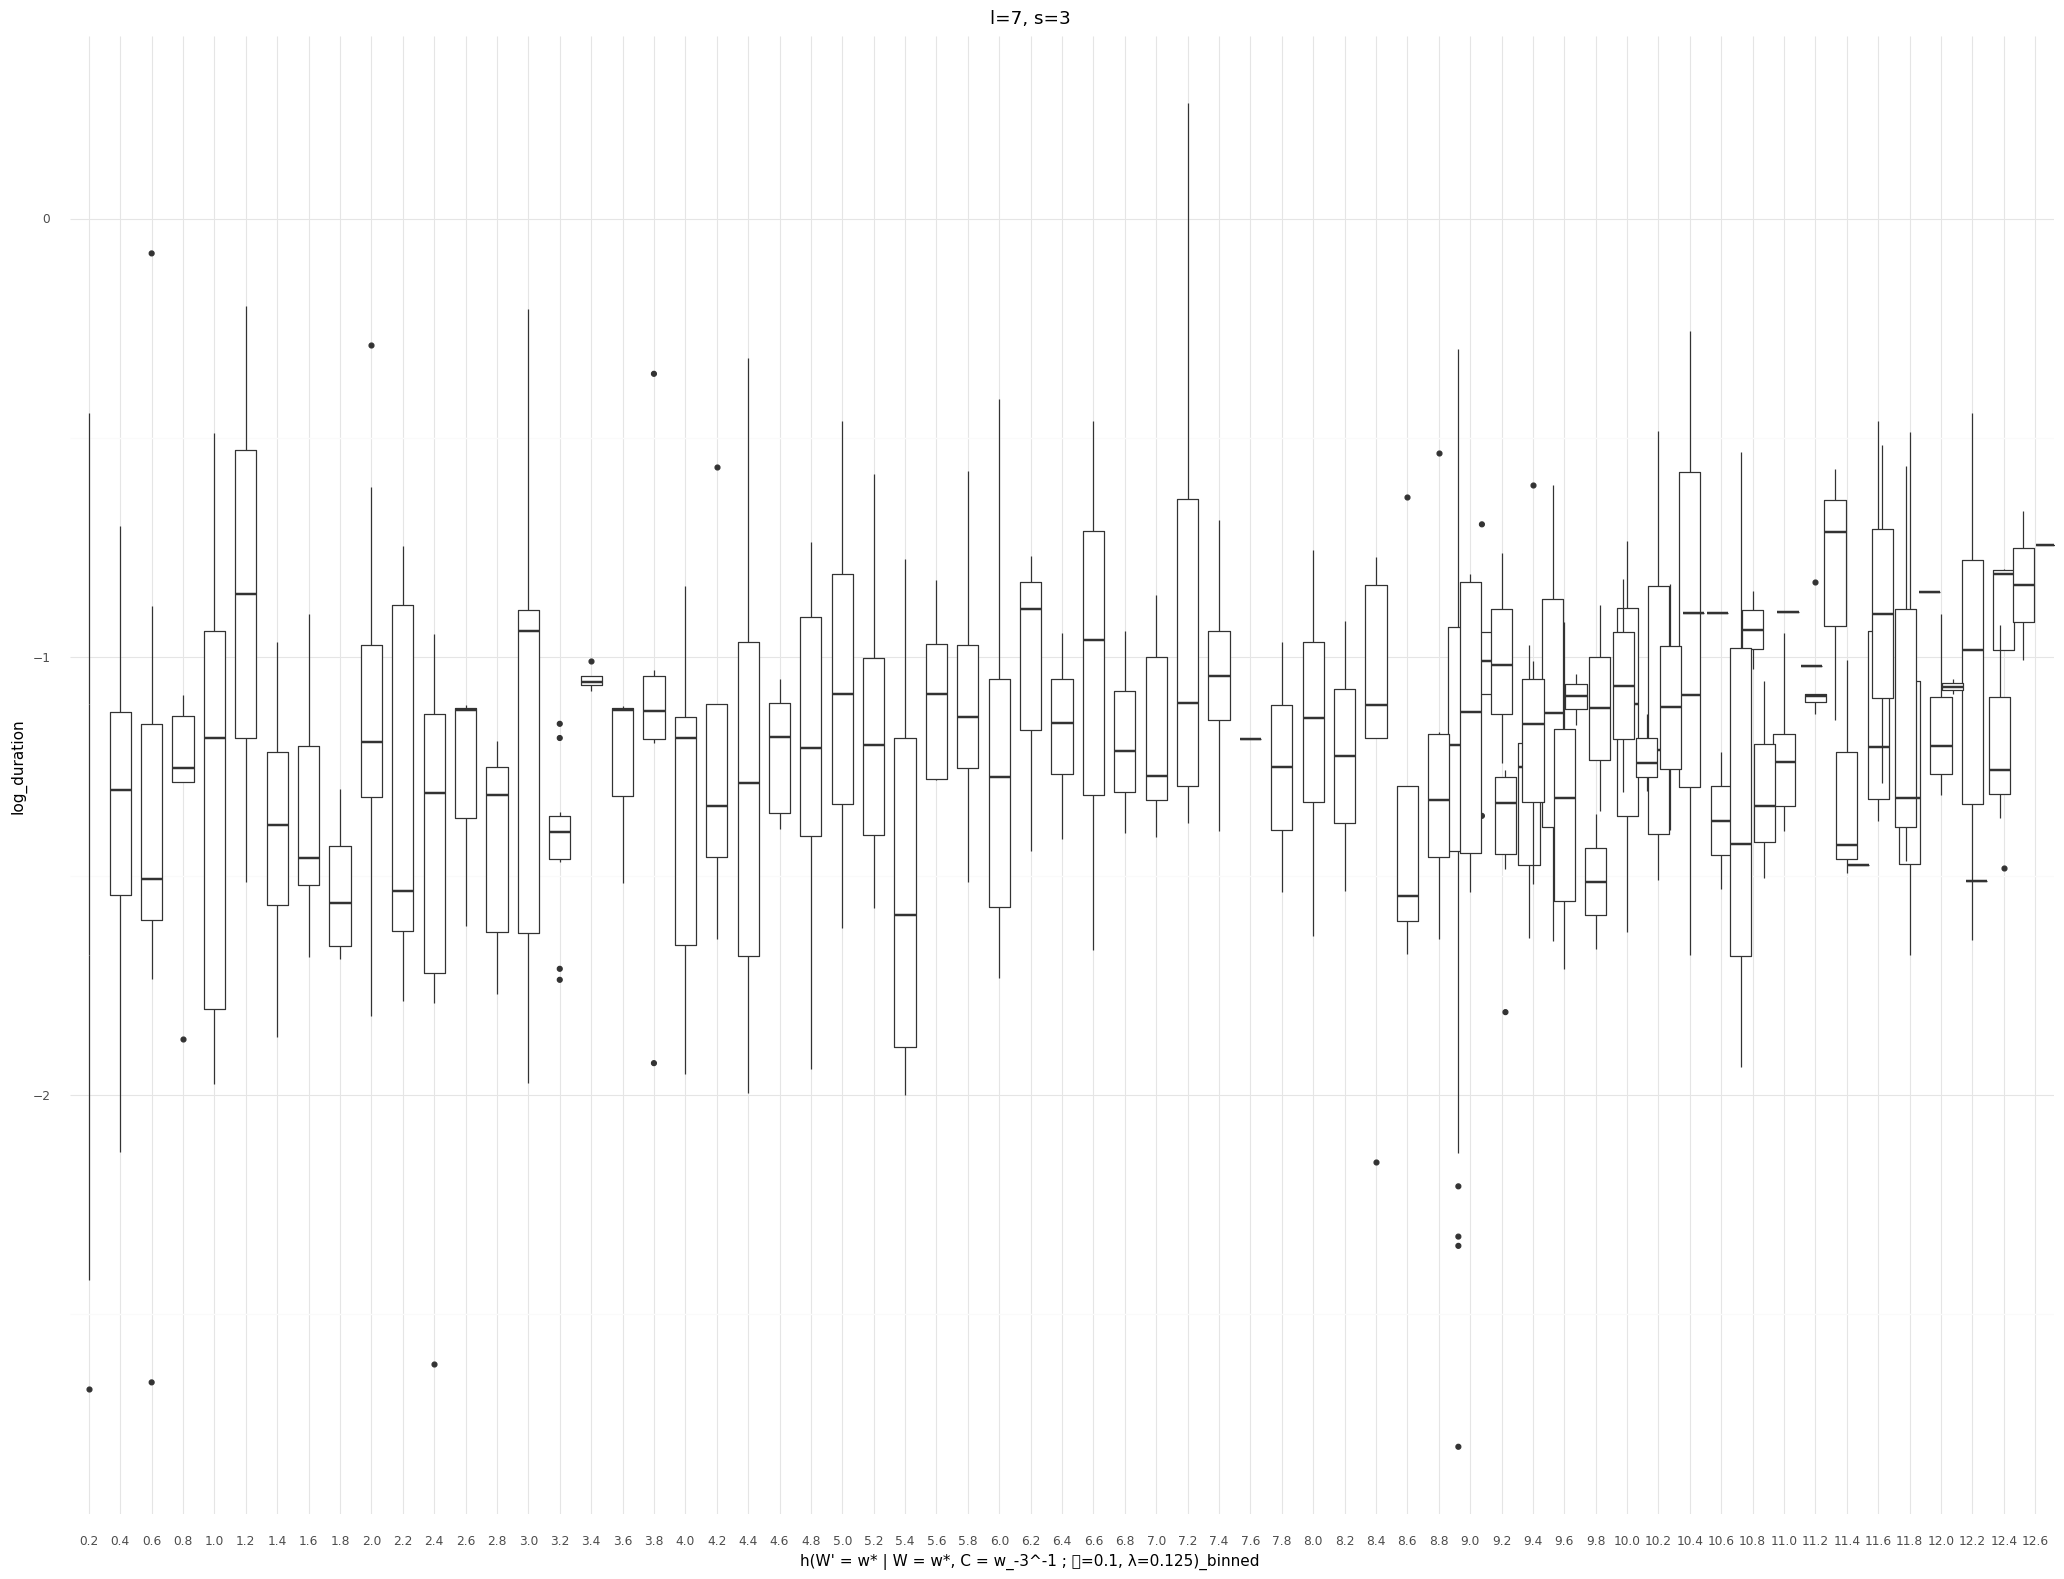

<ggplot: (8779395084625)>

................................................................................
--------------------------------------------------------------------------------


s=3, l=8
	s=3, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=3, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=3, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


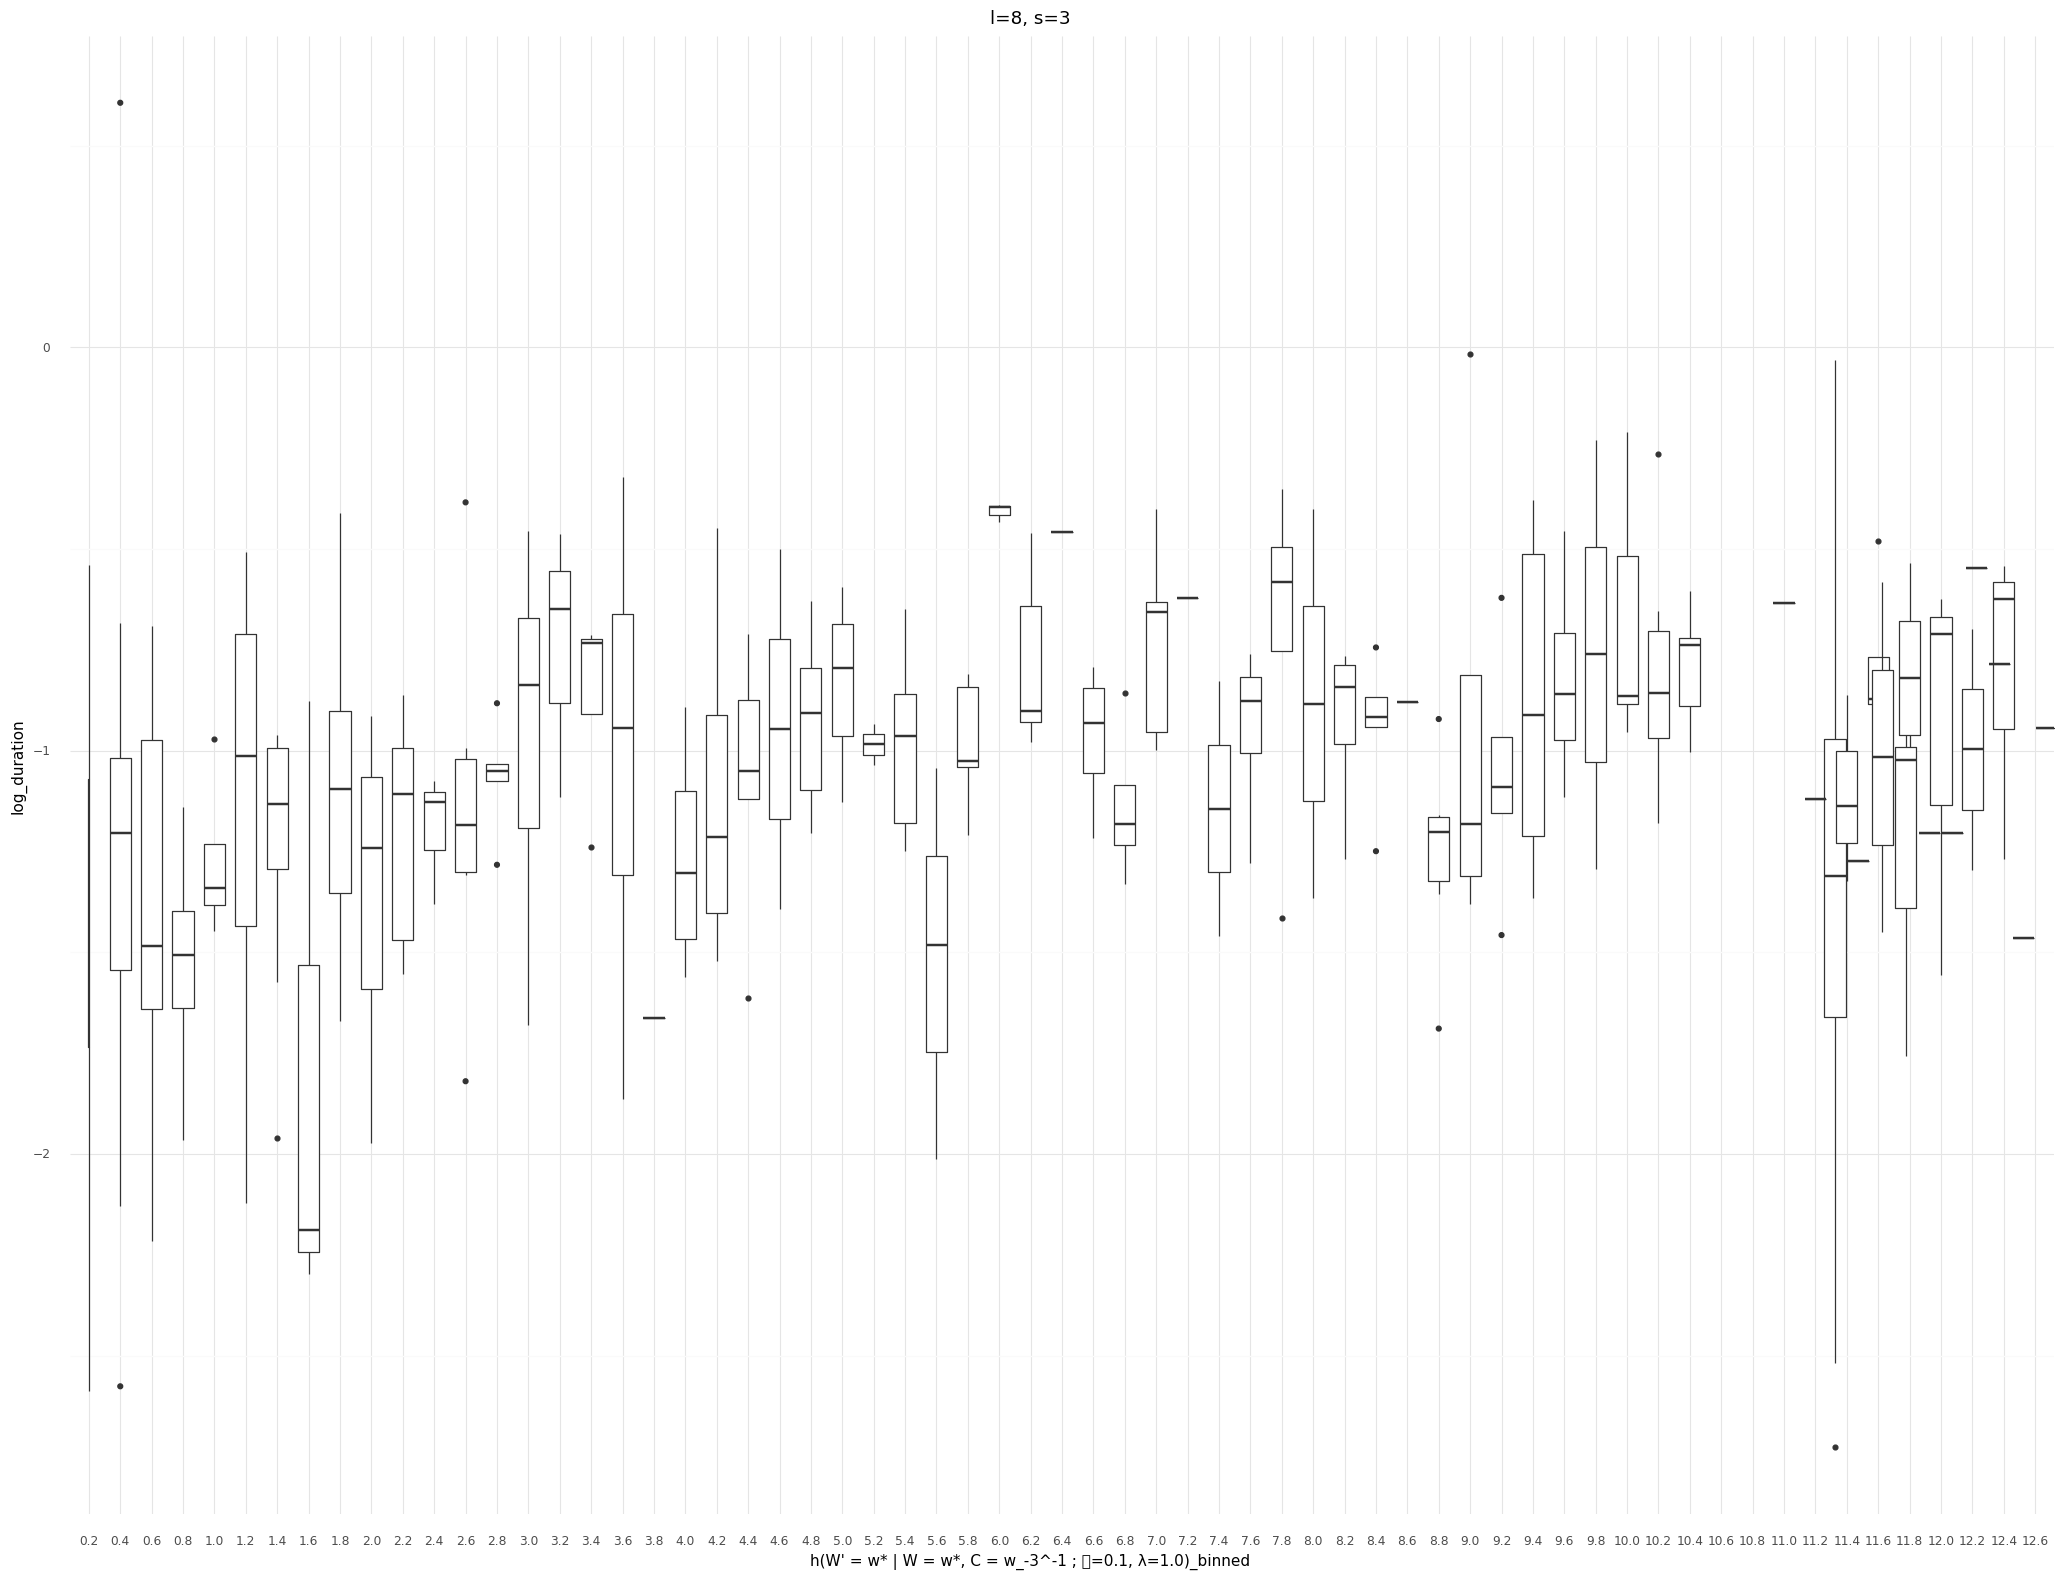

<ggplot: (8779402948393)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=3, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=3, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


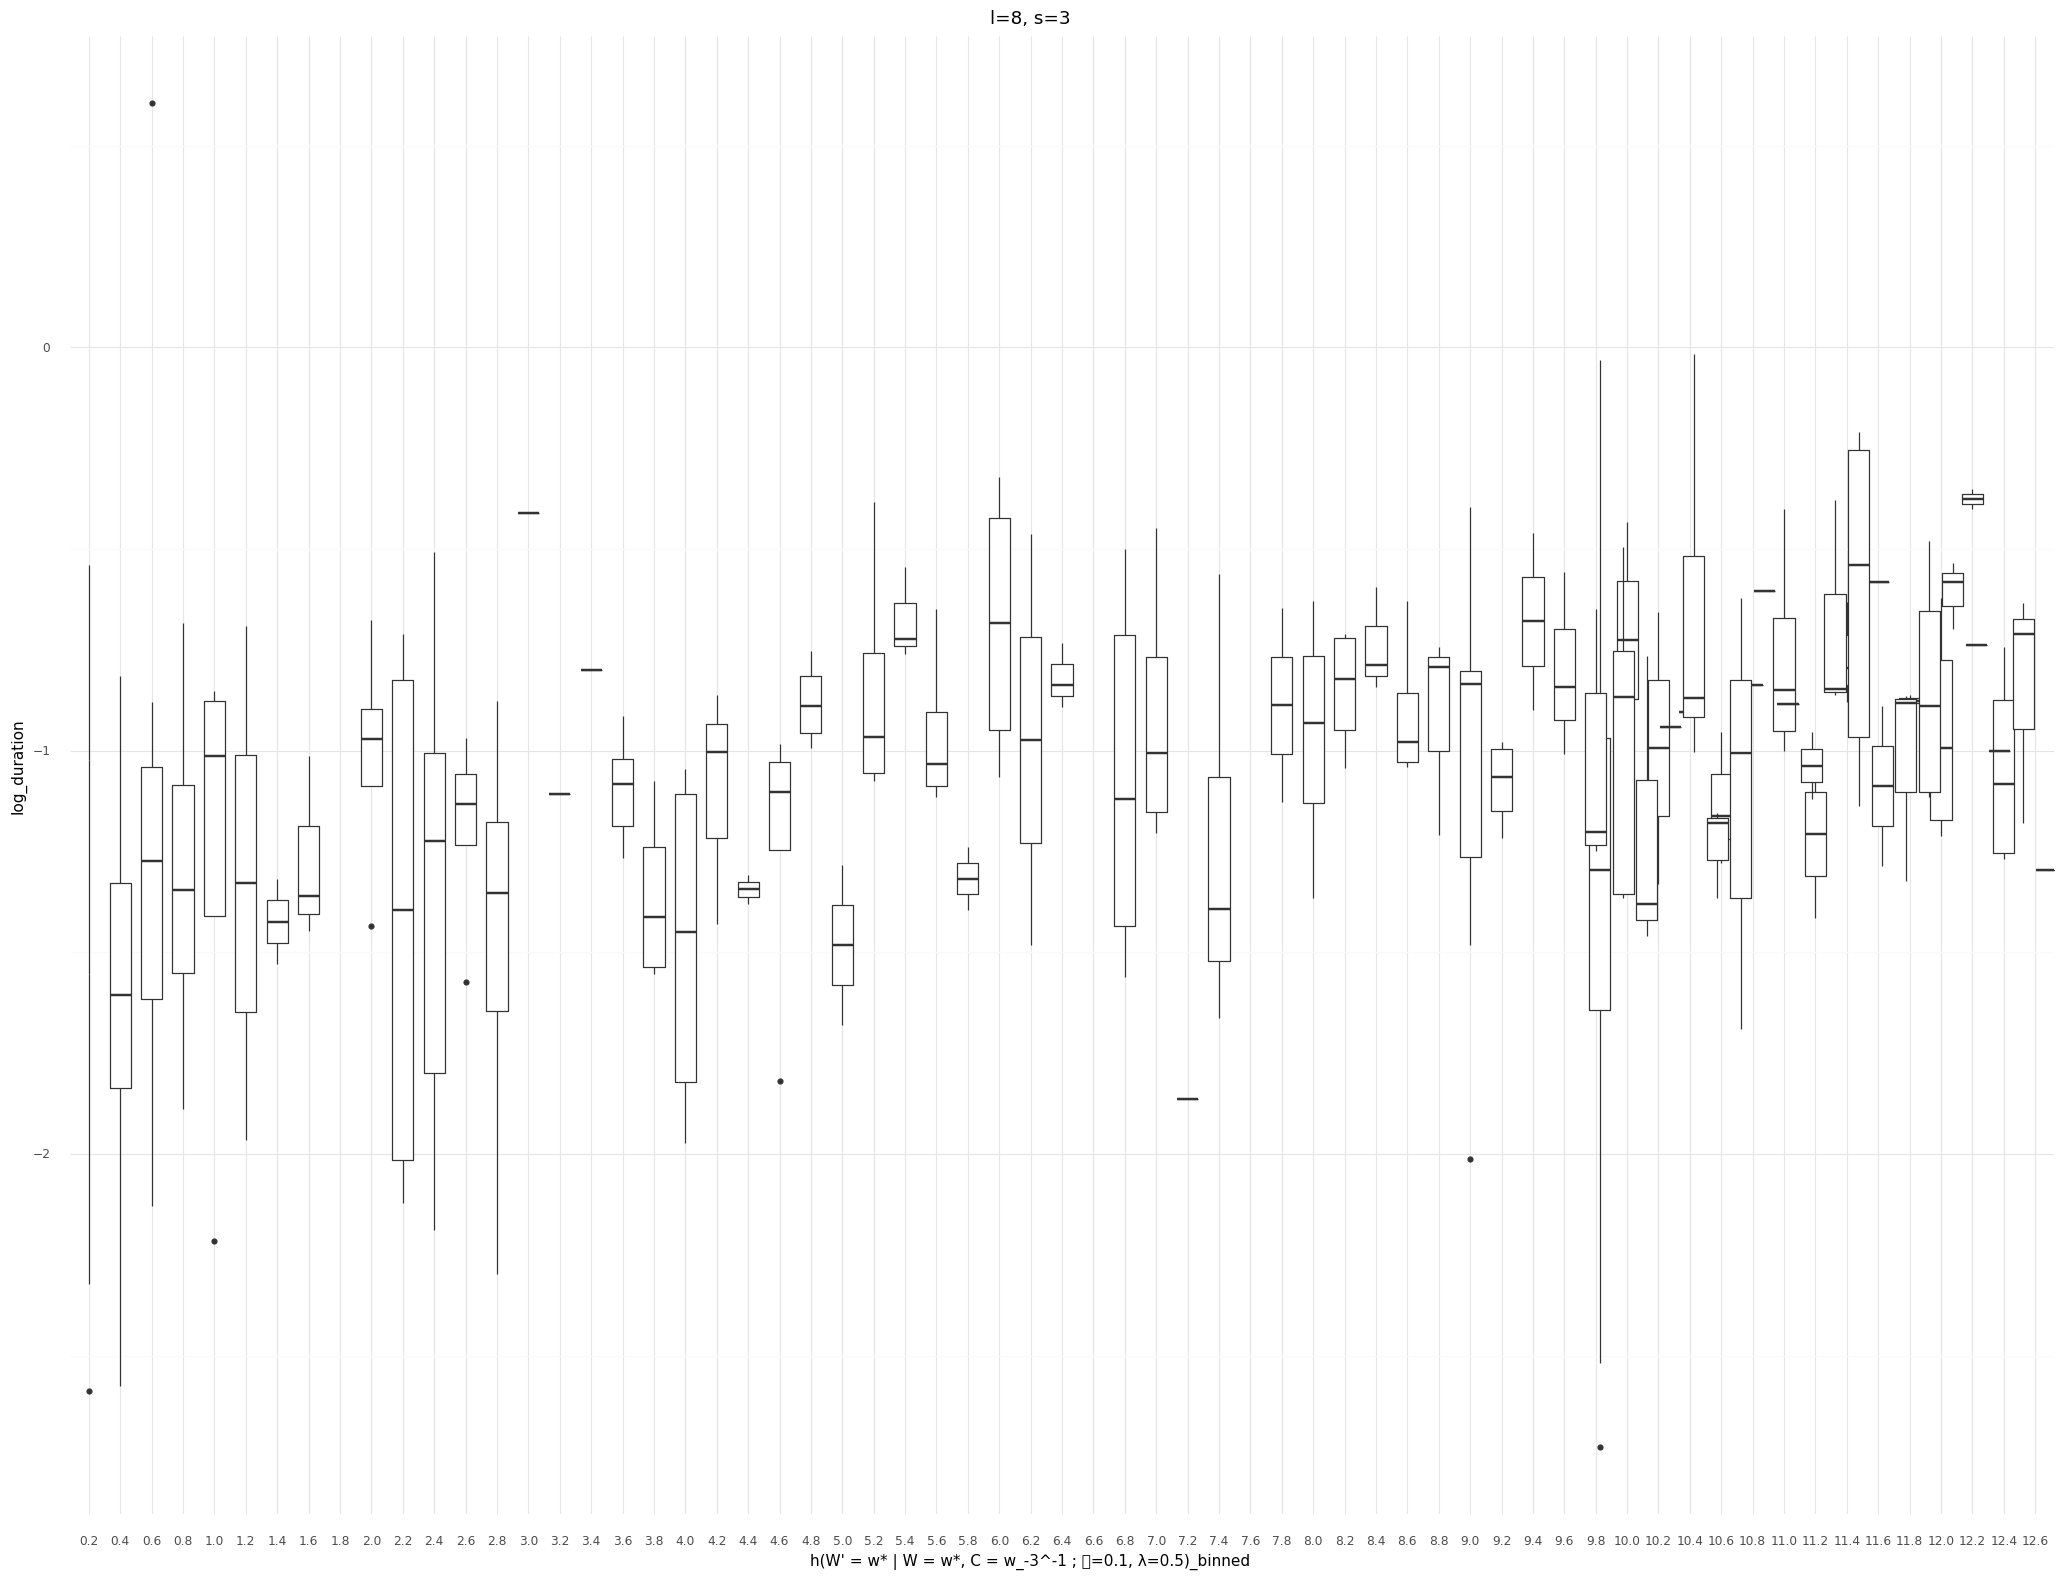

<ggplot: (8779277200945)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=3, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=3, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


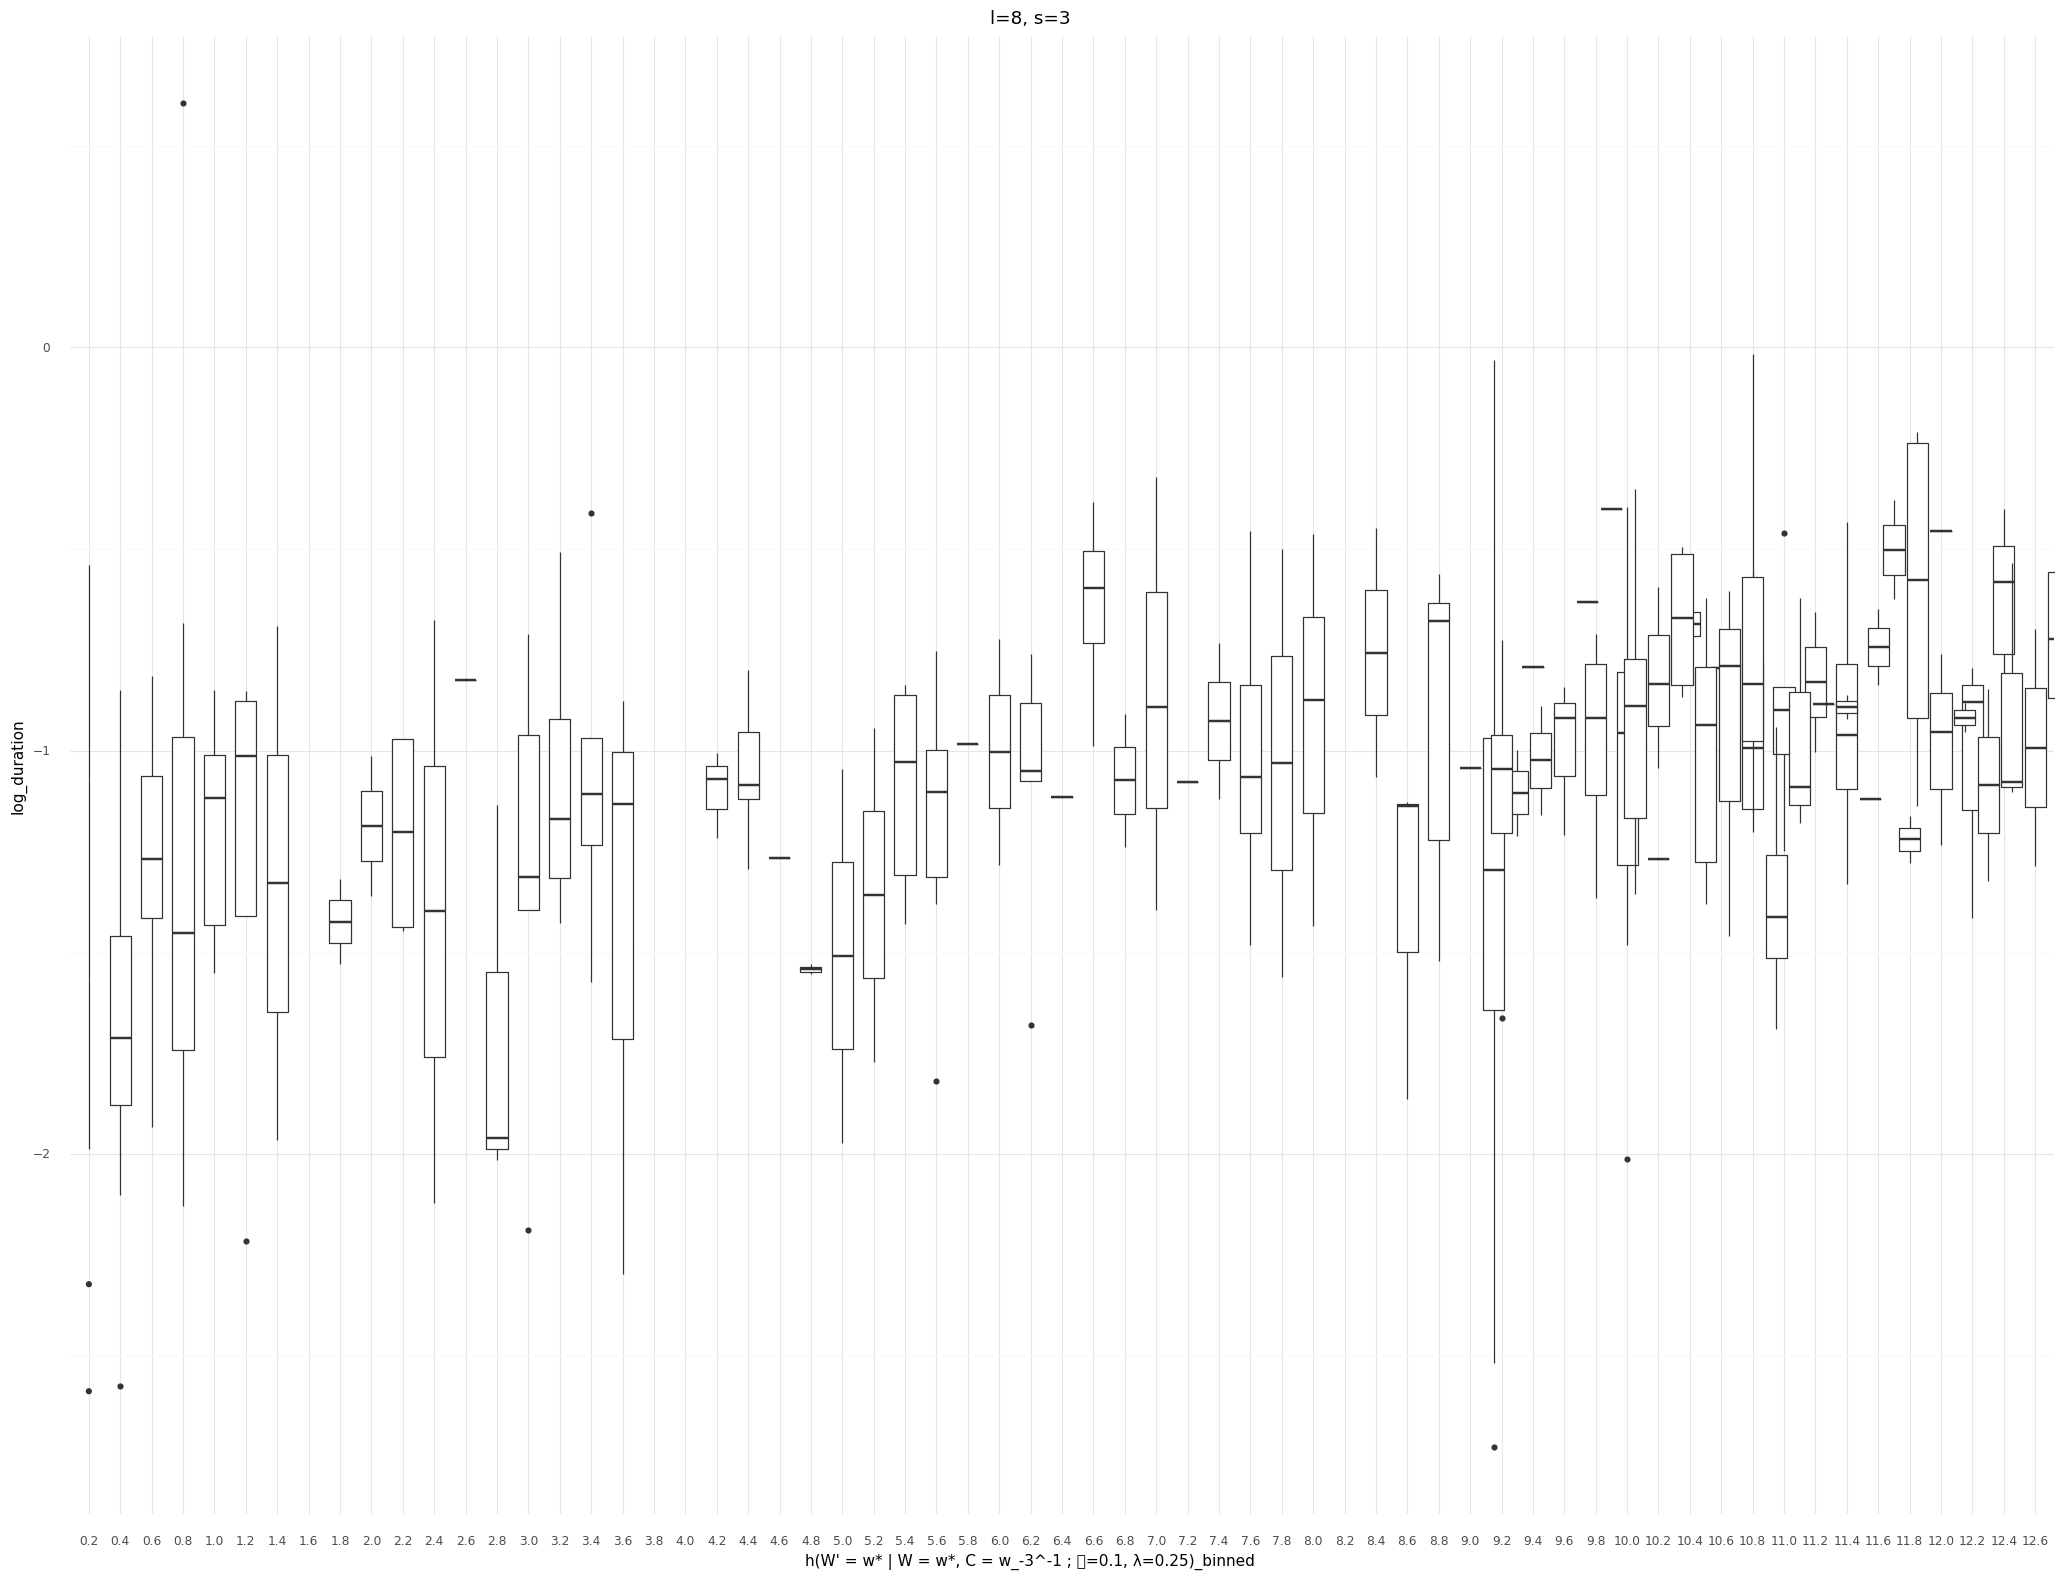

<ggplot: (8779402939797)>

................................................................................
--------------------------------------------------------------------------------
	s=3, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=3, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=3, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


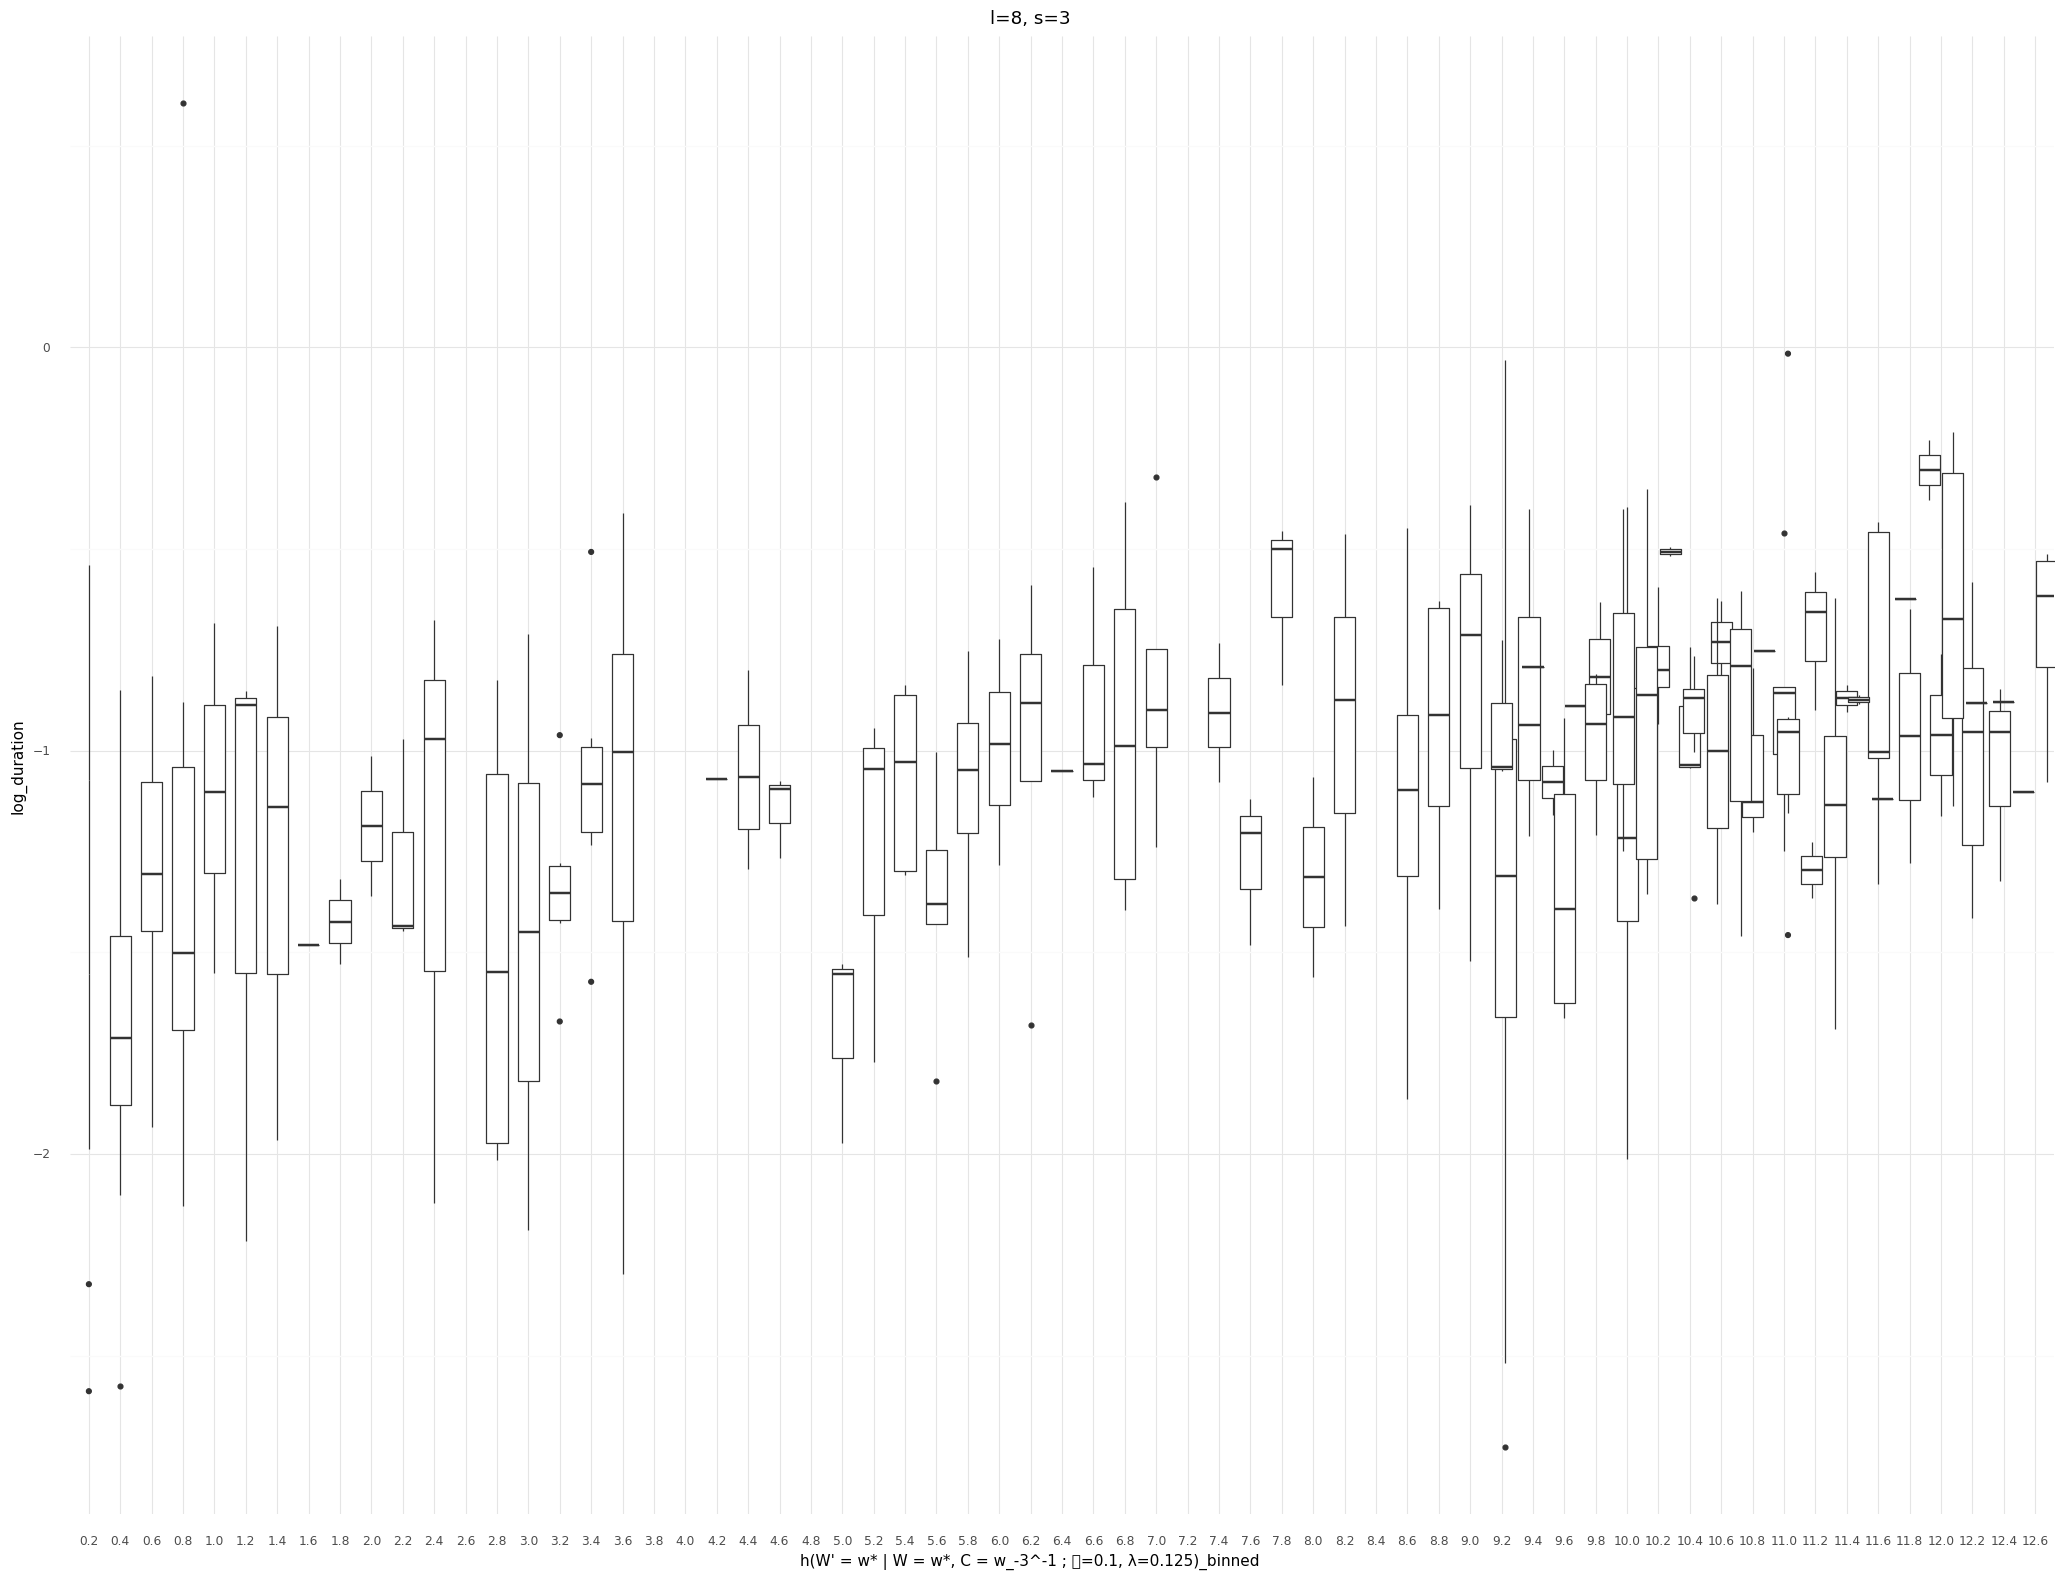

<ggplot: (8779409603429)>

................................................................................
--------------------------------------------------------------------------------


s=4, l=8
	s=4, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=4, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=4, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


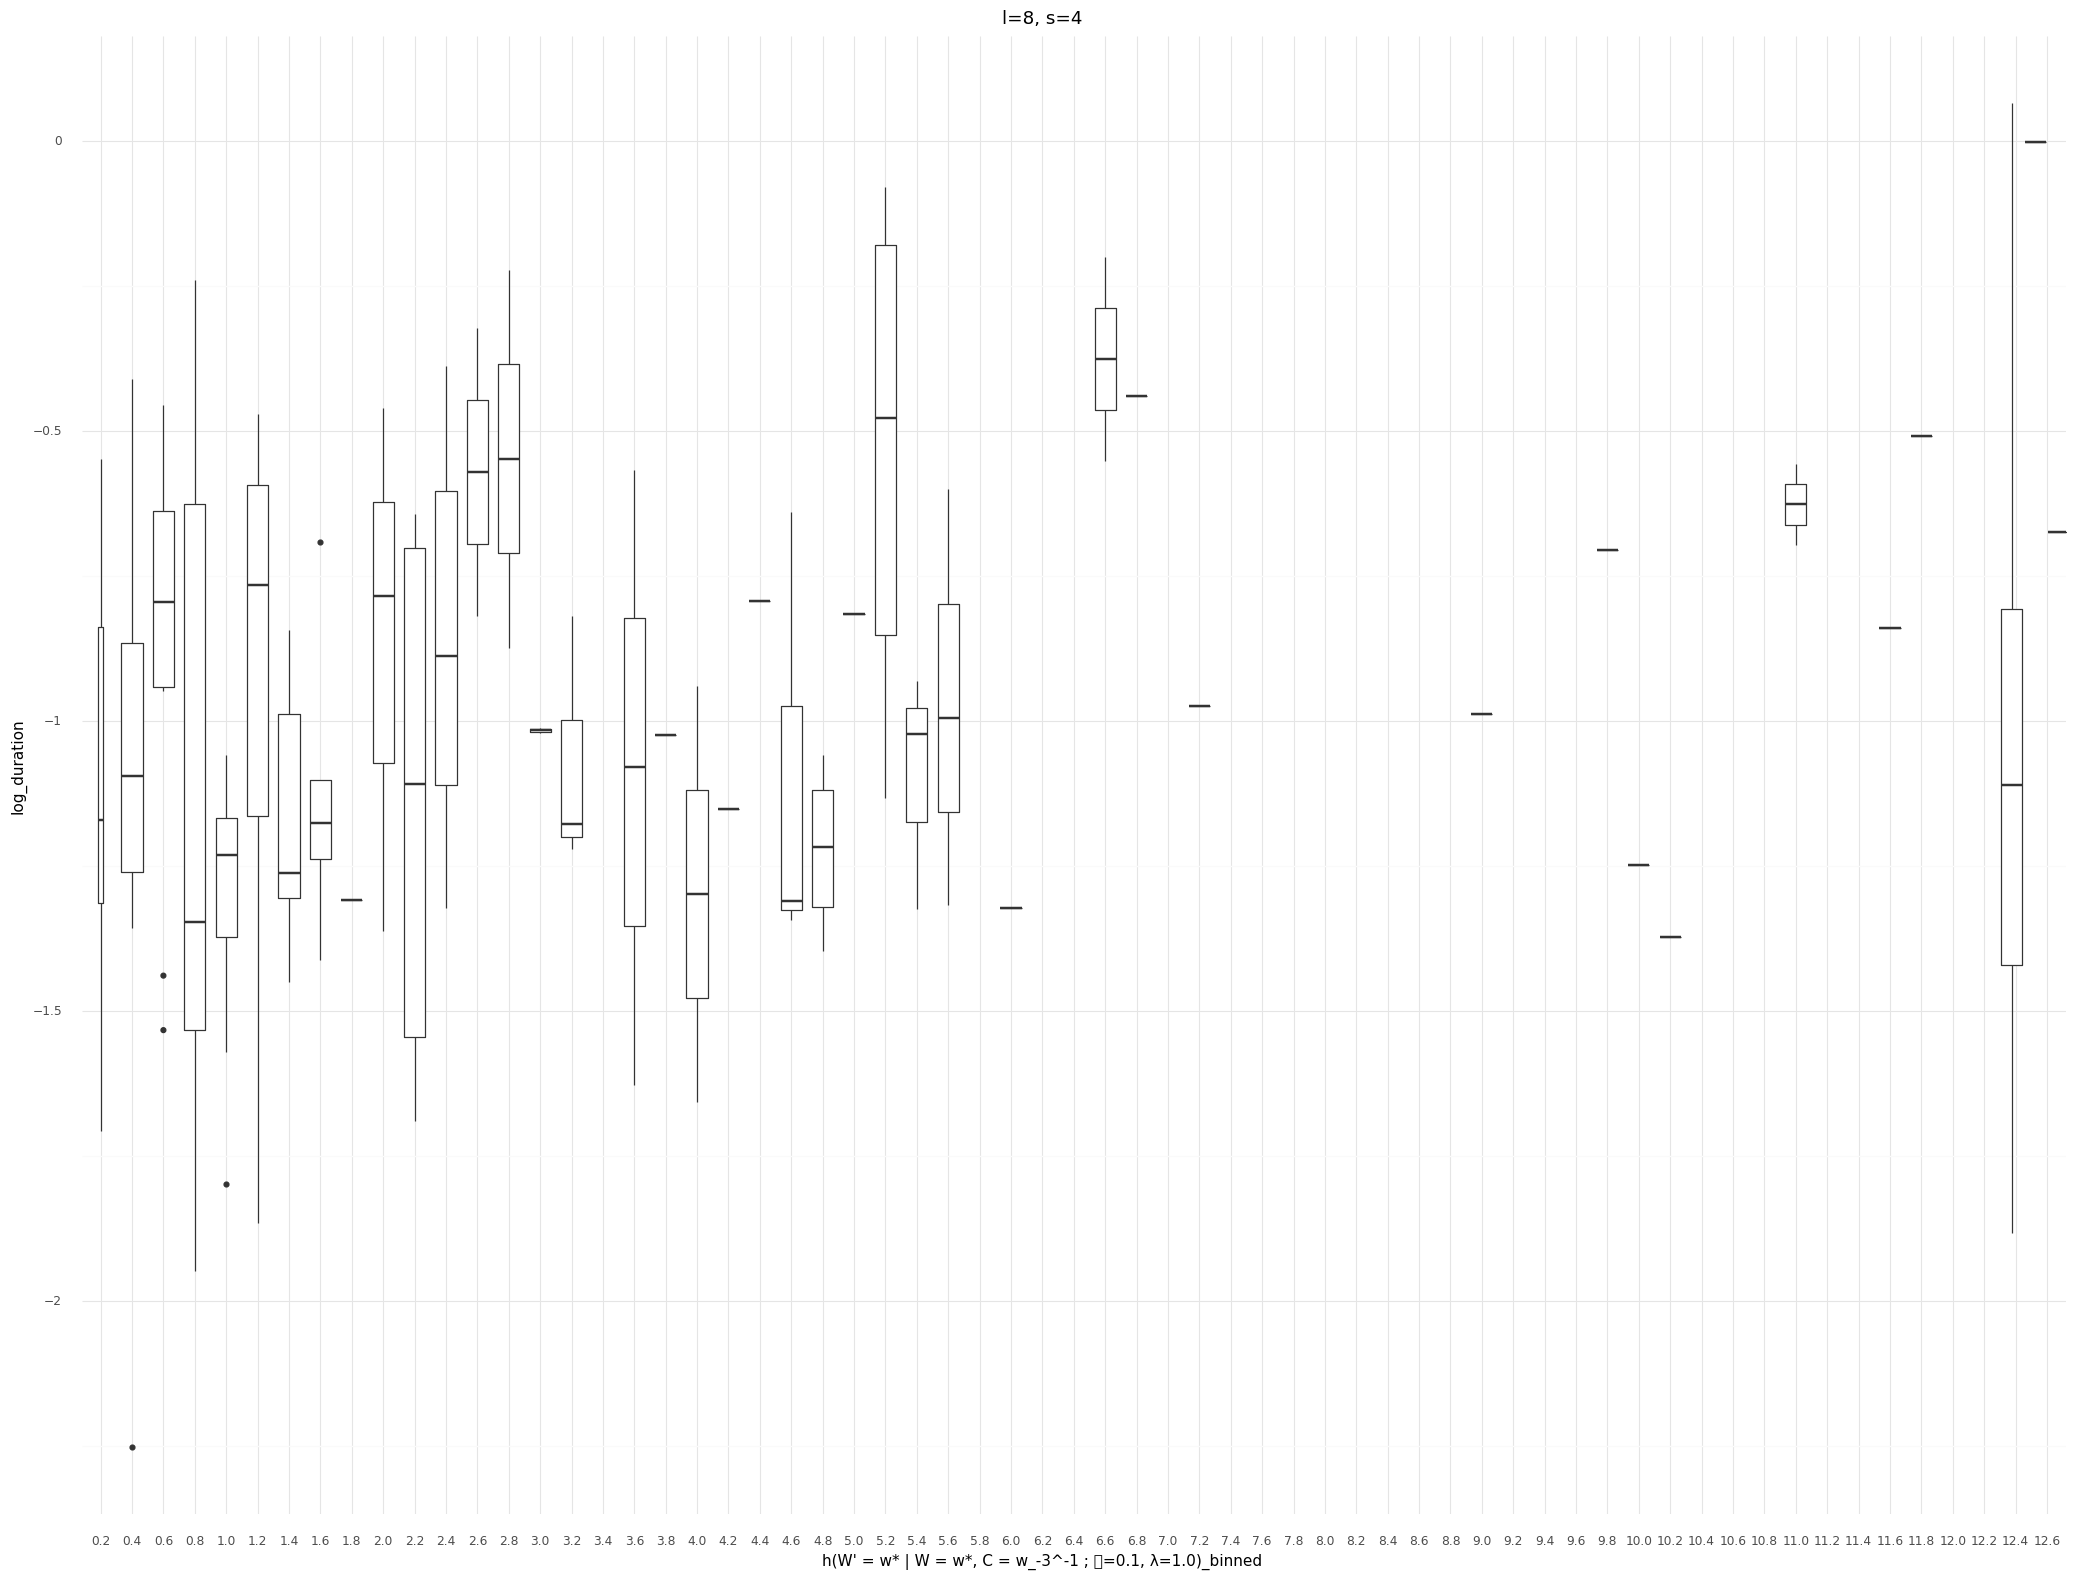

<ggplot: (8779446136601)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=4, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=4, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


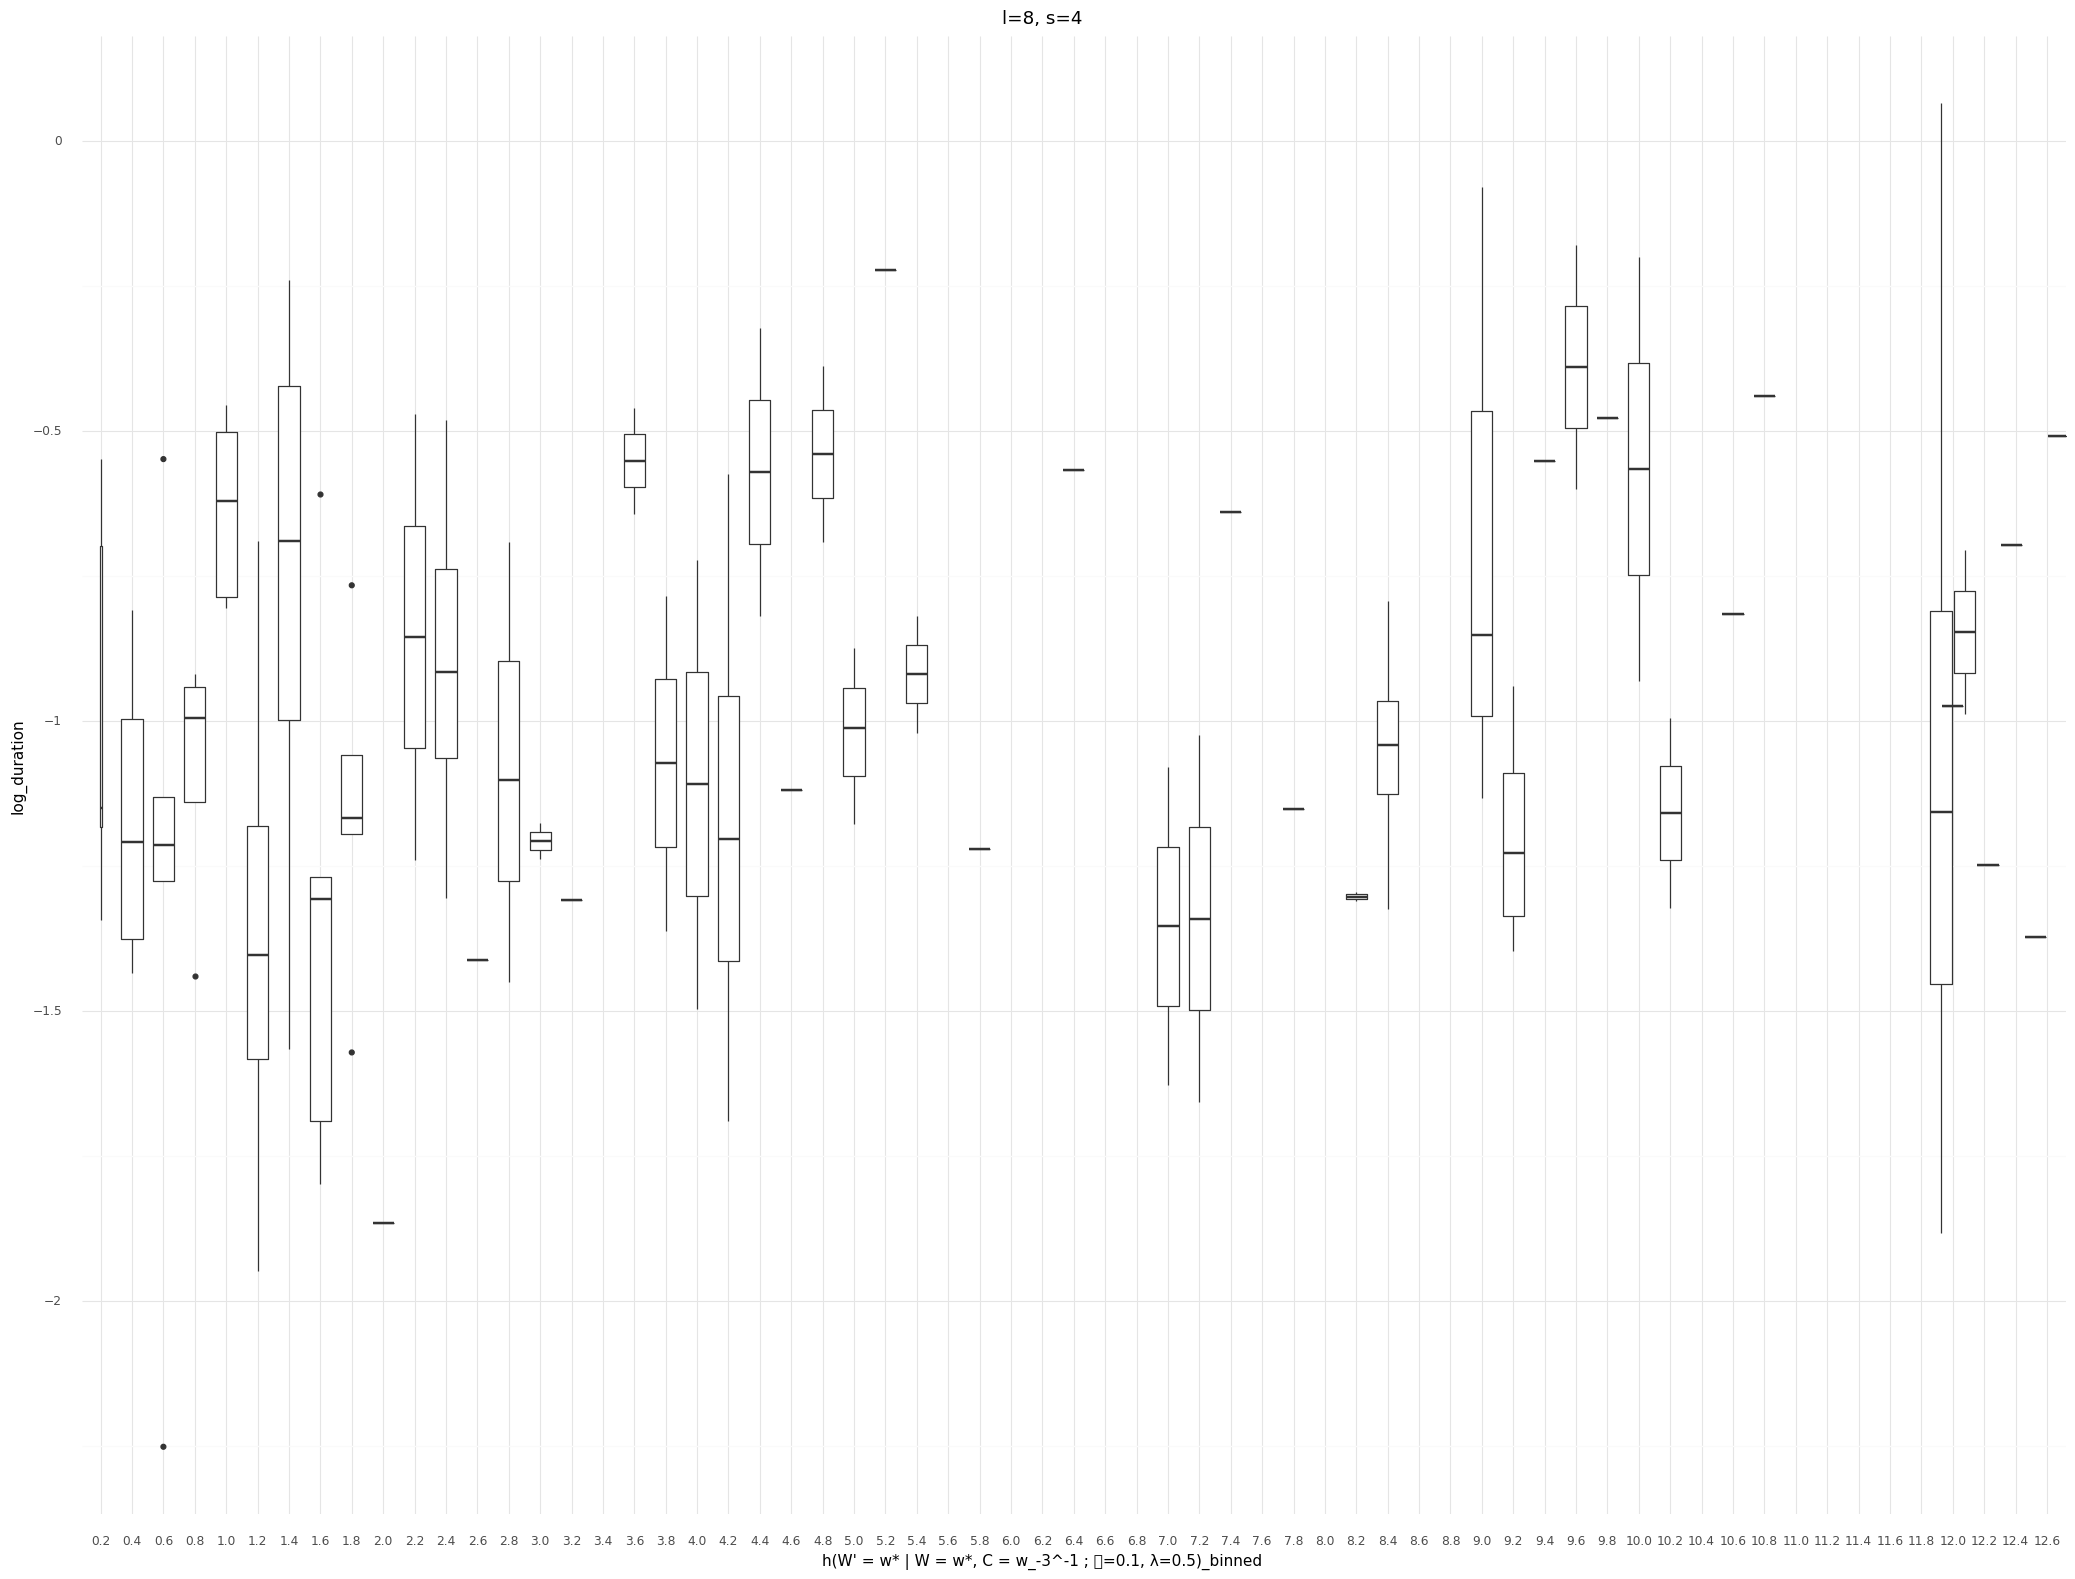

<ggplot: (8779276235601)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=4, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=4, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


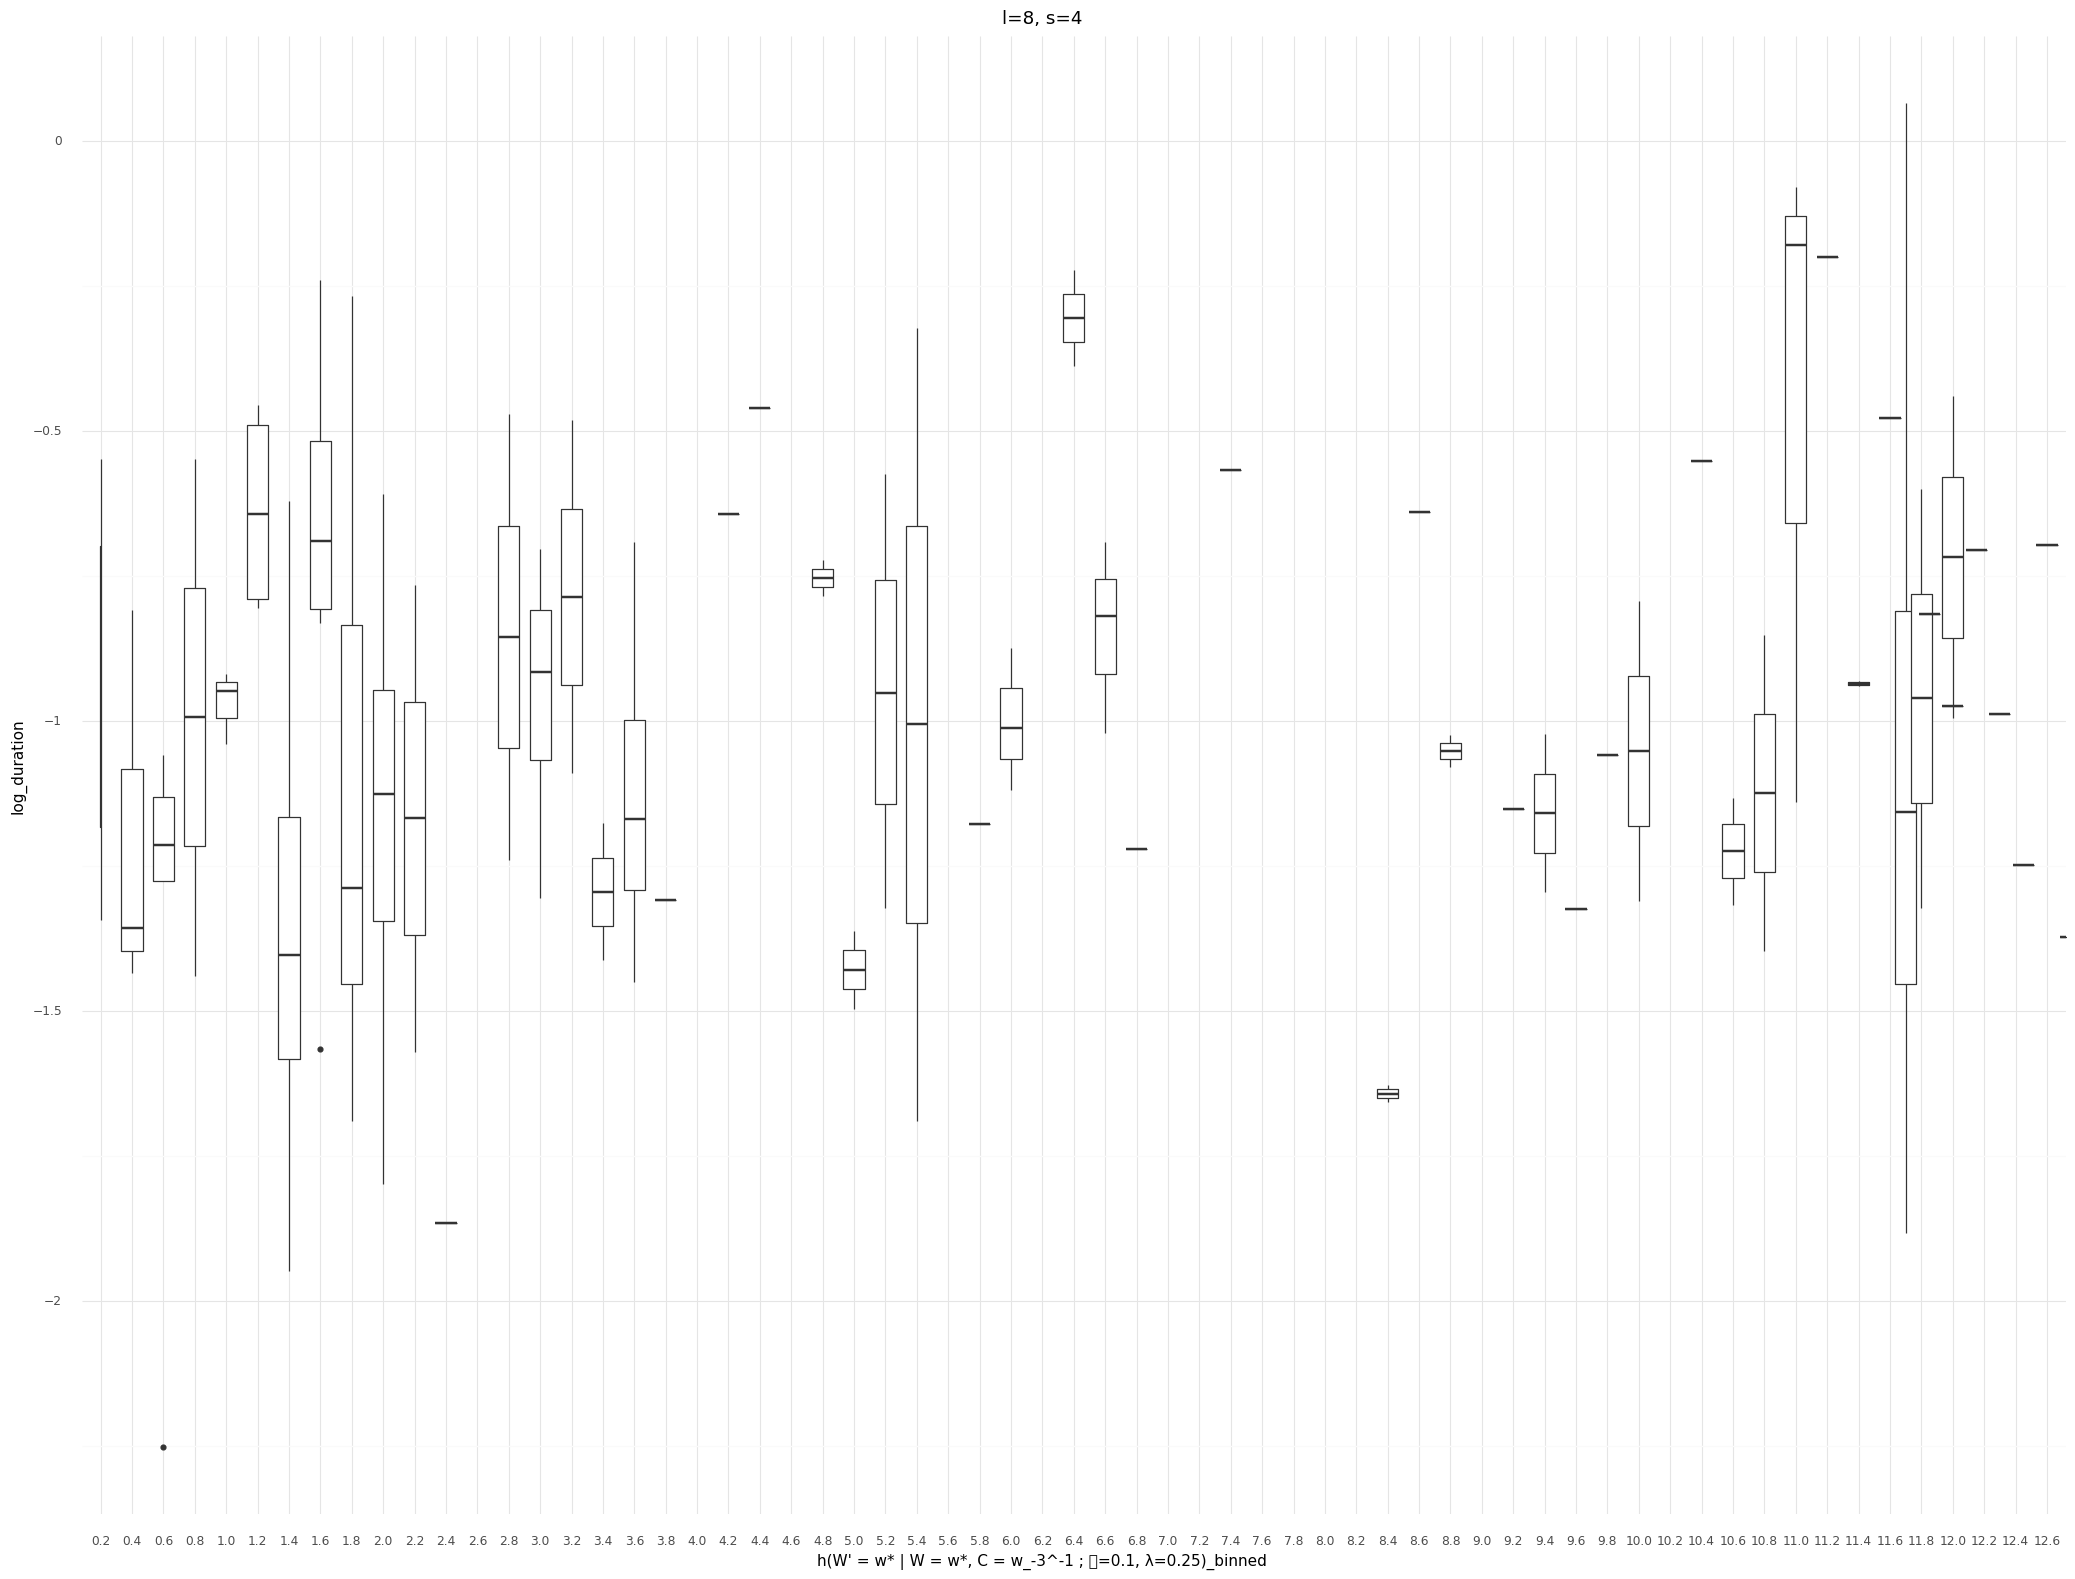

<ggplot: (8779398622181)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=8
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=4, l=8
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=4, l=8, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


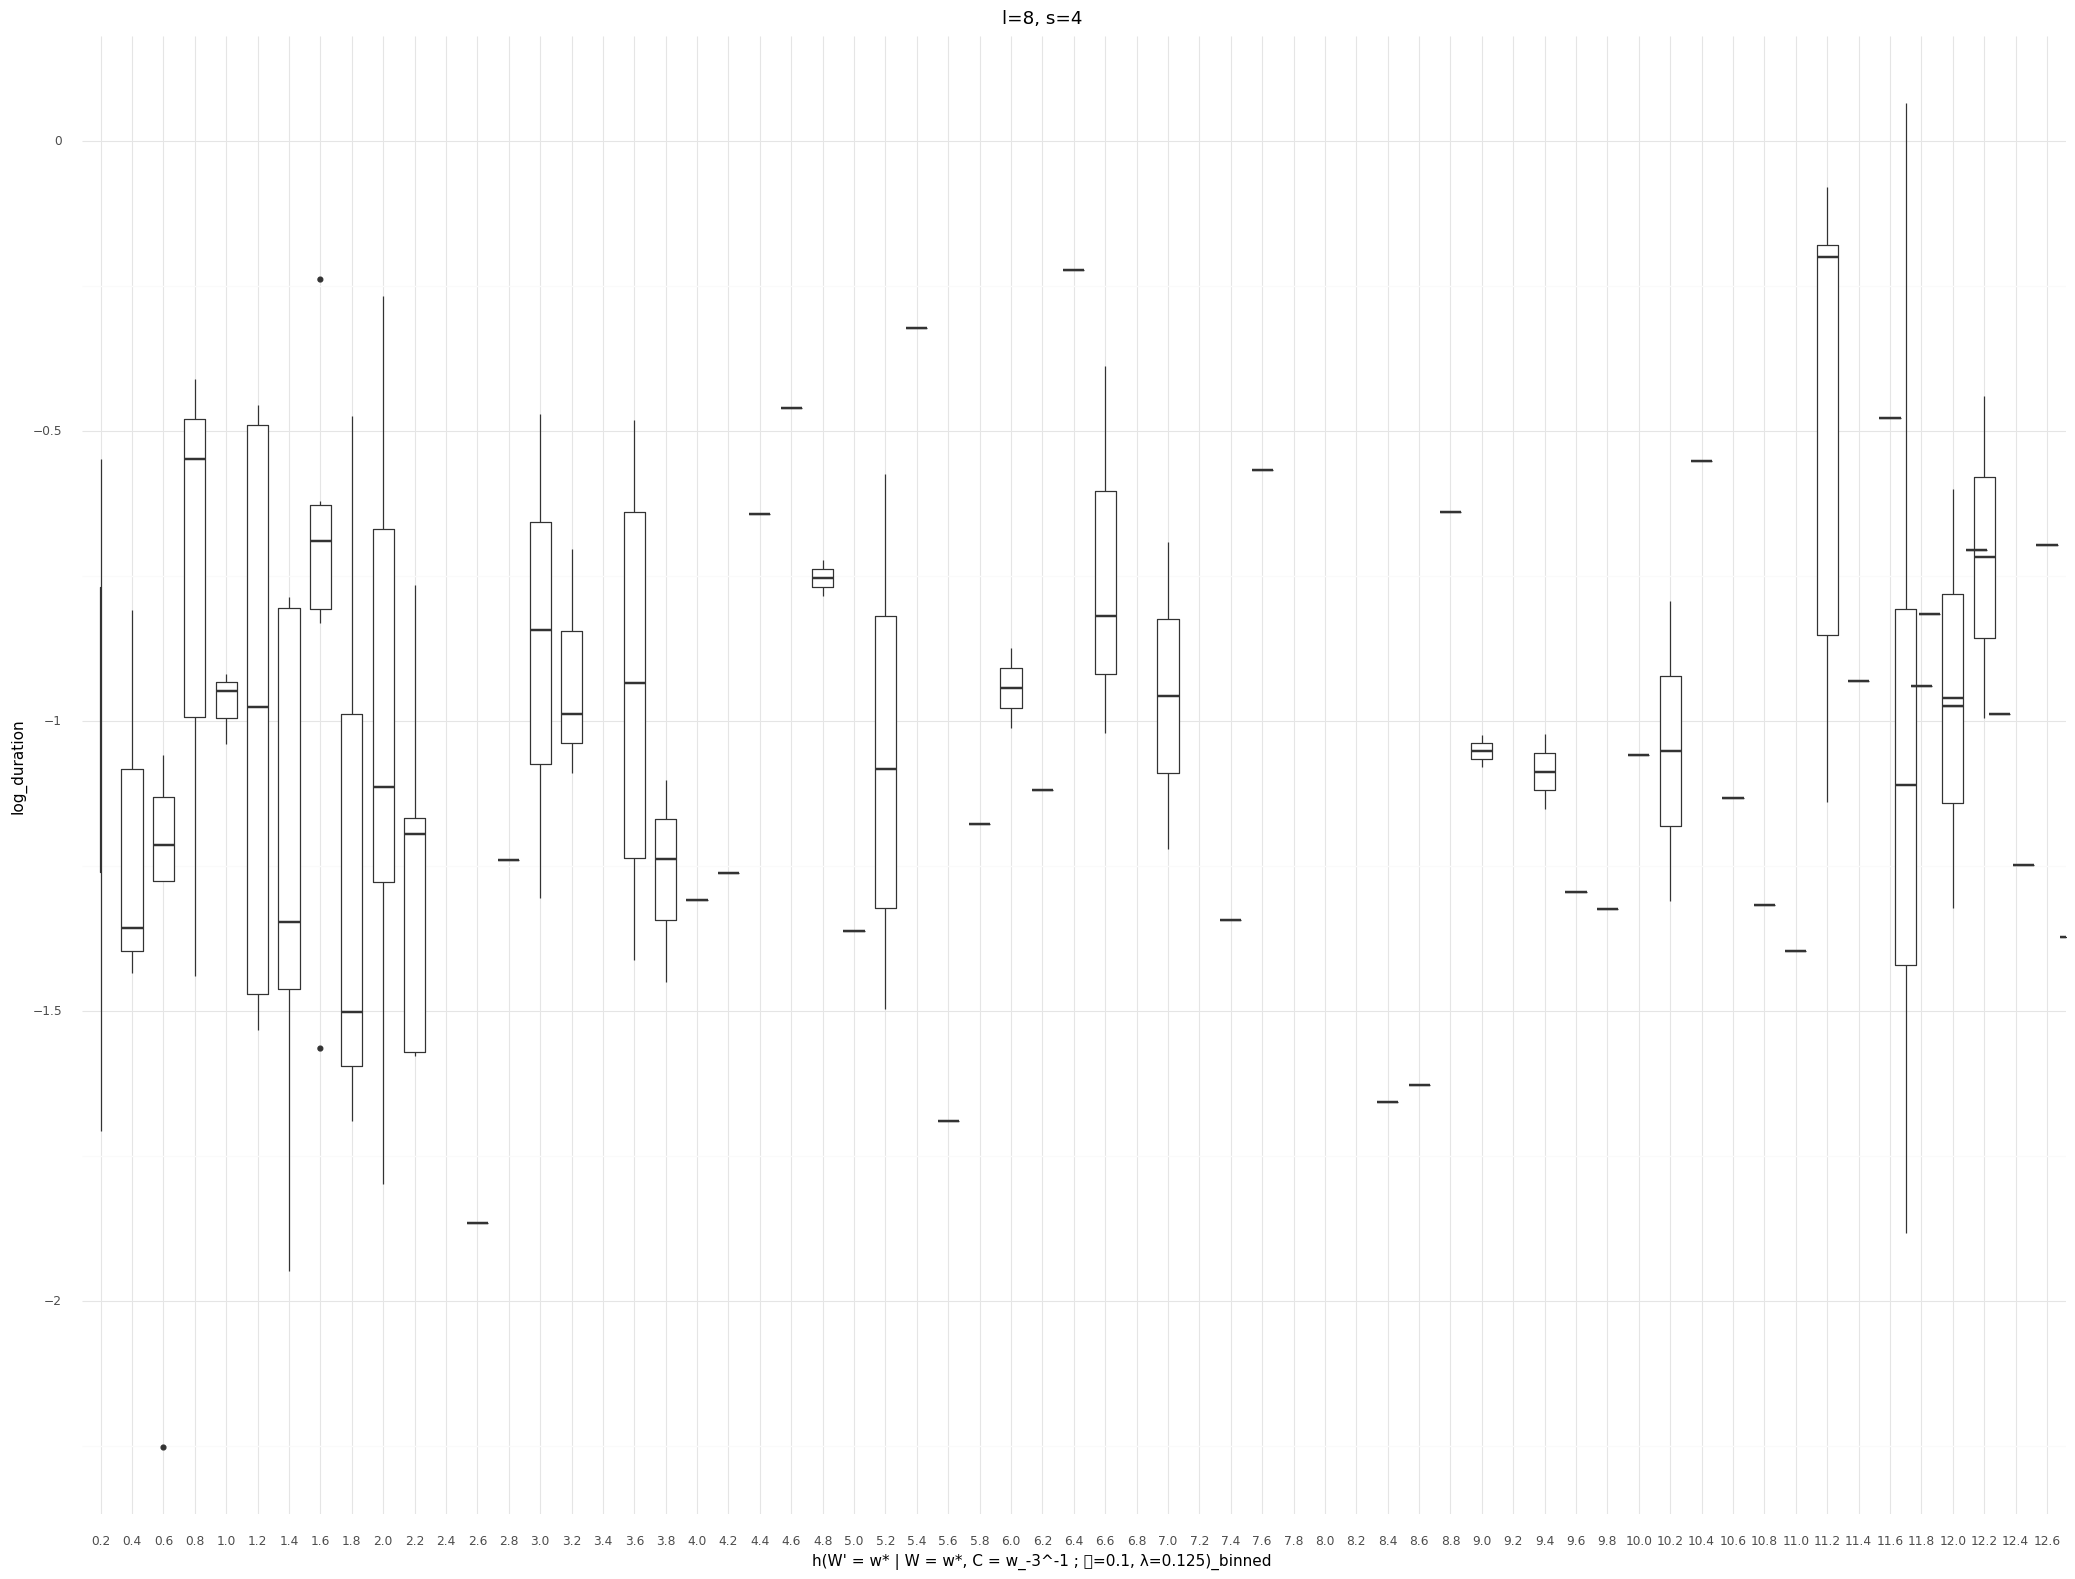

<ggplot: (8779374693217)>

................................................................................
--------------------------------------------------------------------------------


s=4, l=9
	s=4, l=9
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=4, l=9
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=4, l=9, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


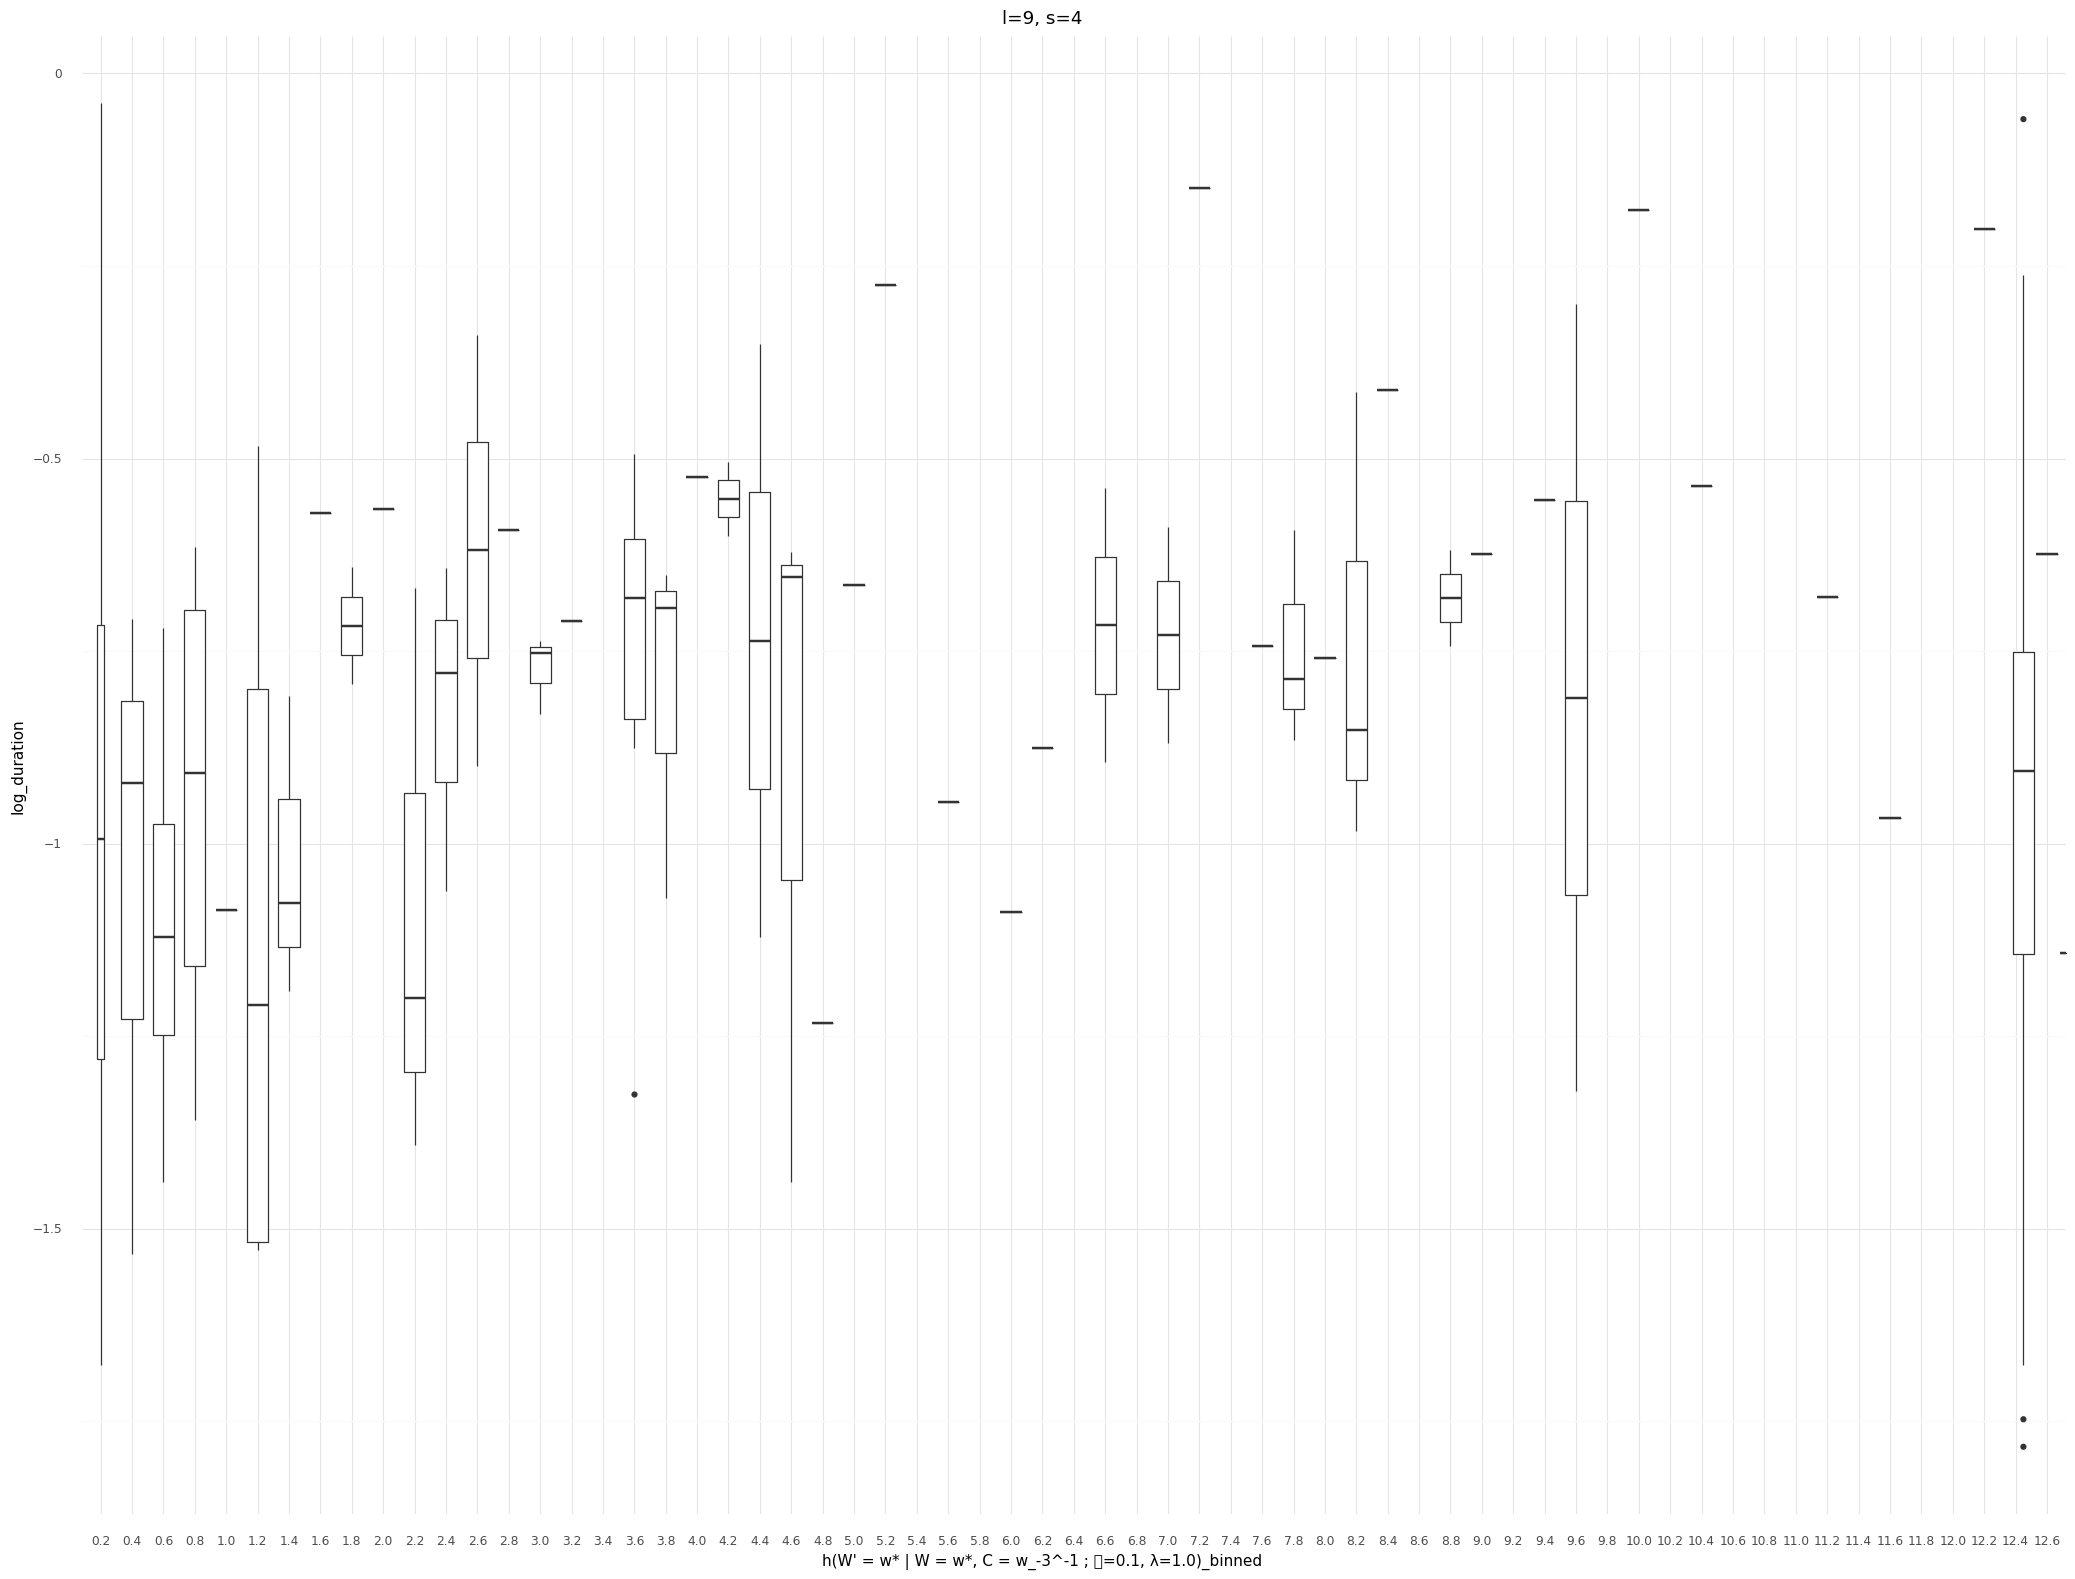

<ggplot: (8779399882977)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=9
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=4, l=9
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=4, l=9, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


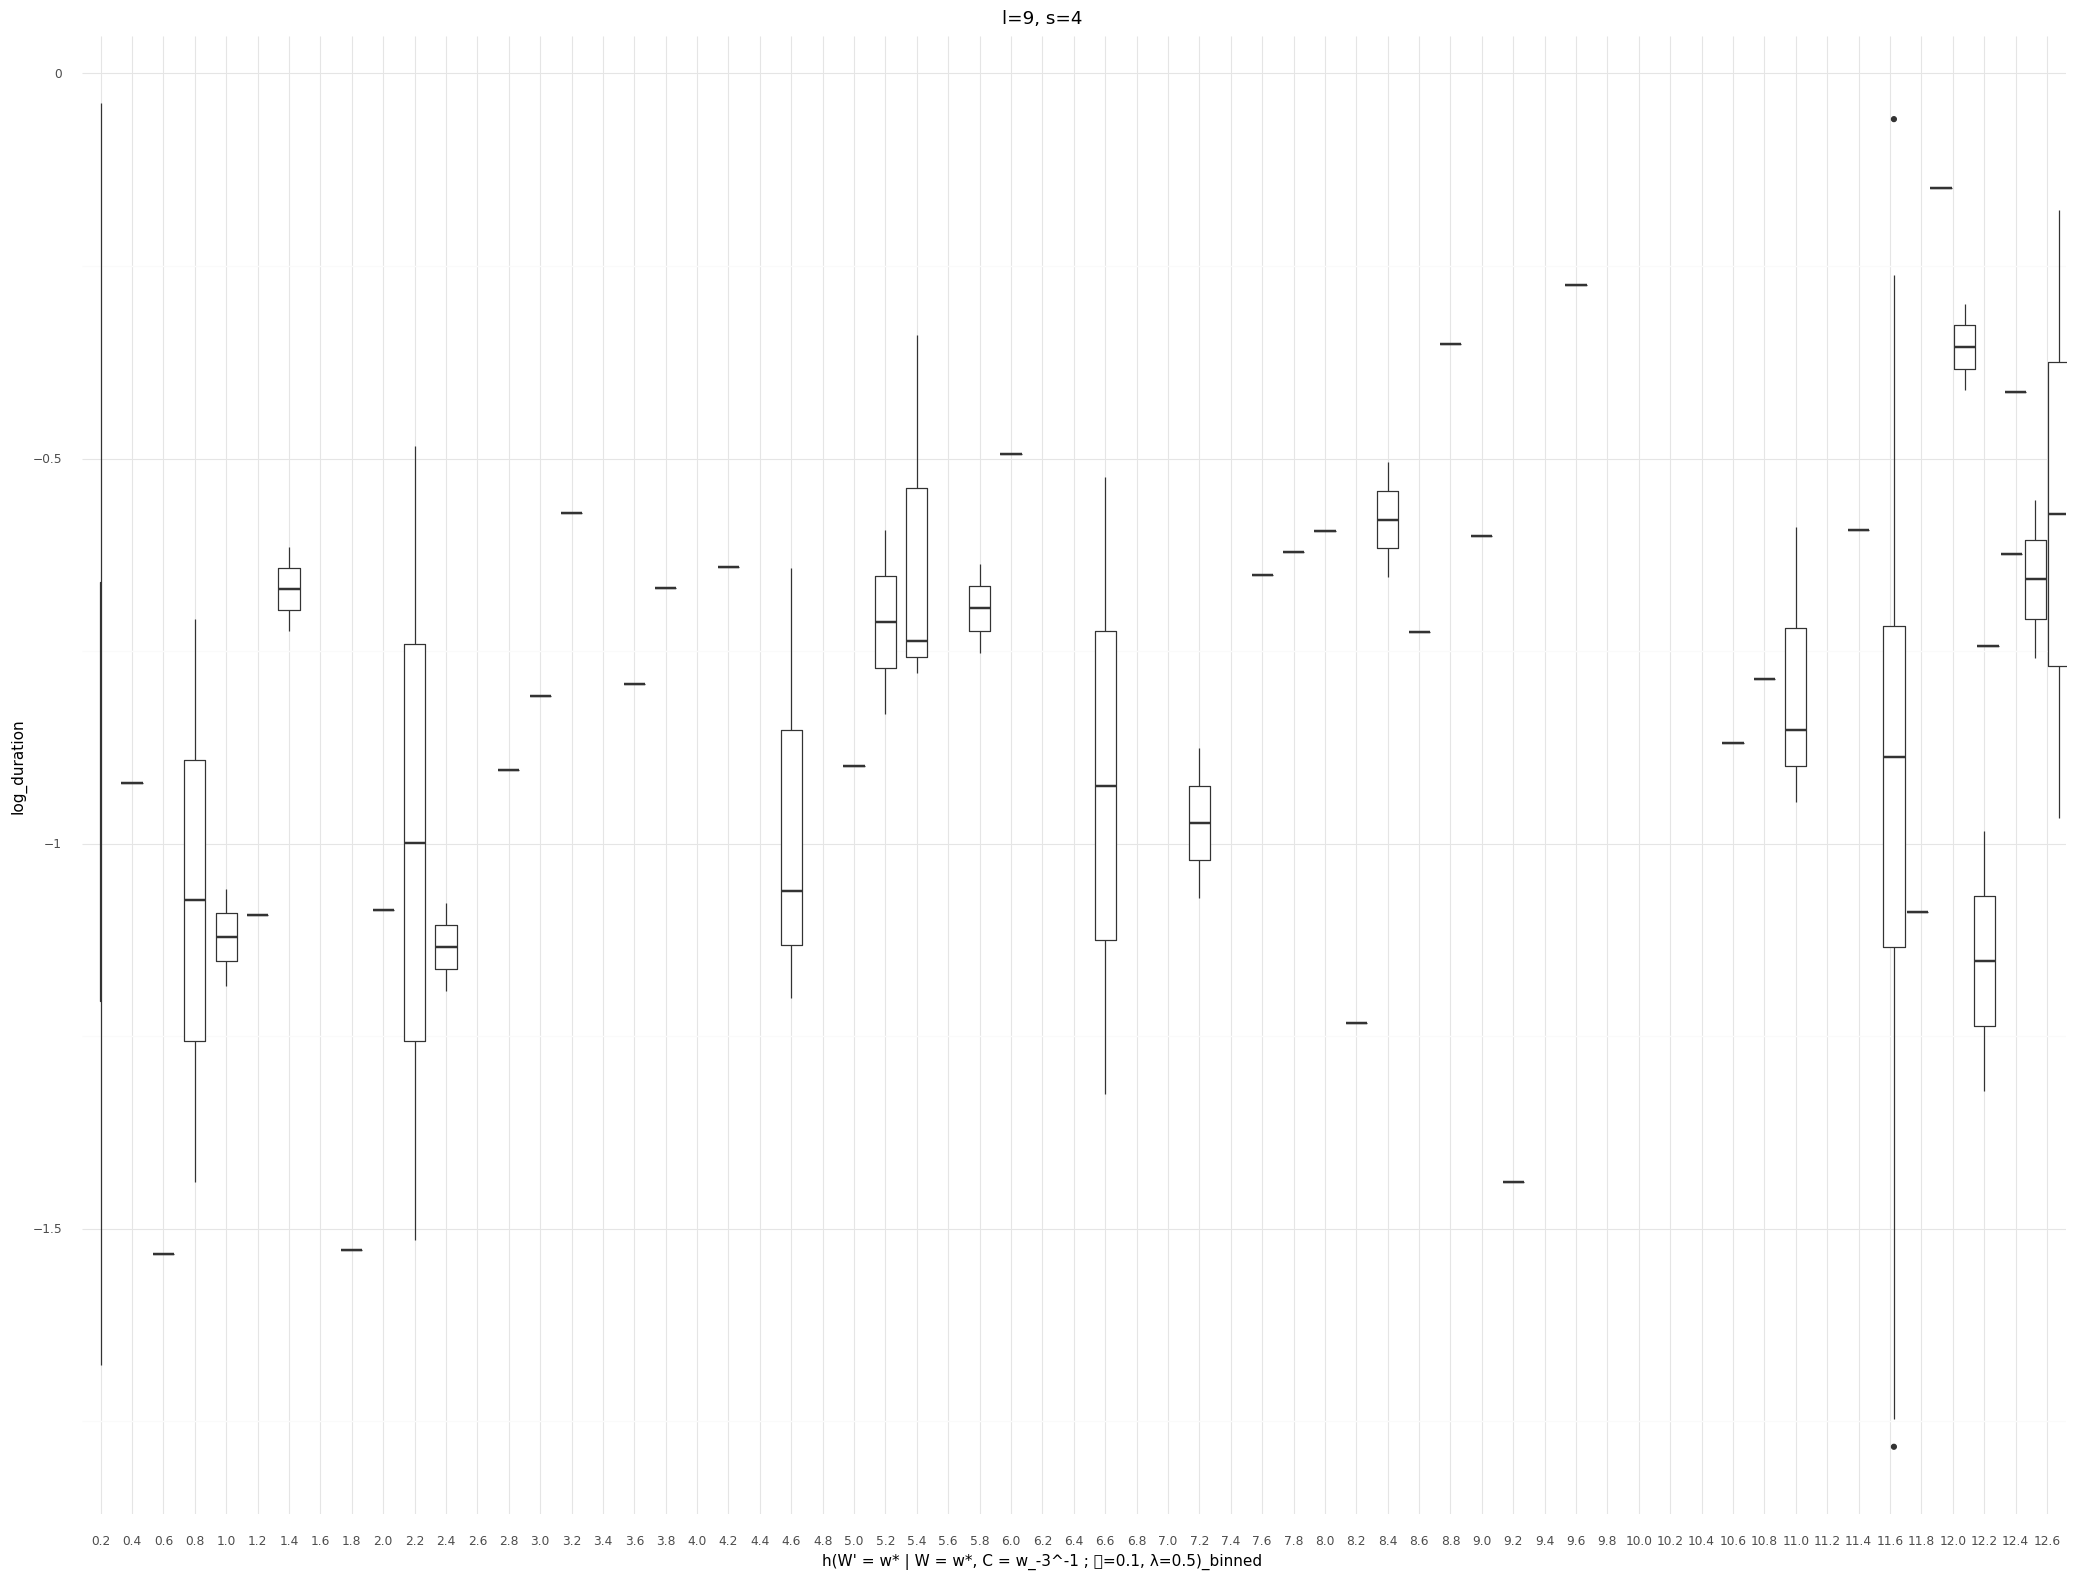

<ggplot: (8779395858893)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=9
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=4, l=9
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=4, l=9, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


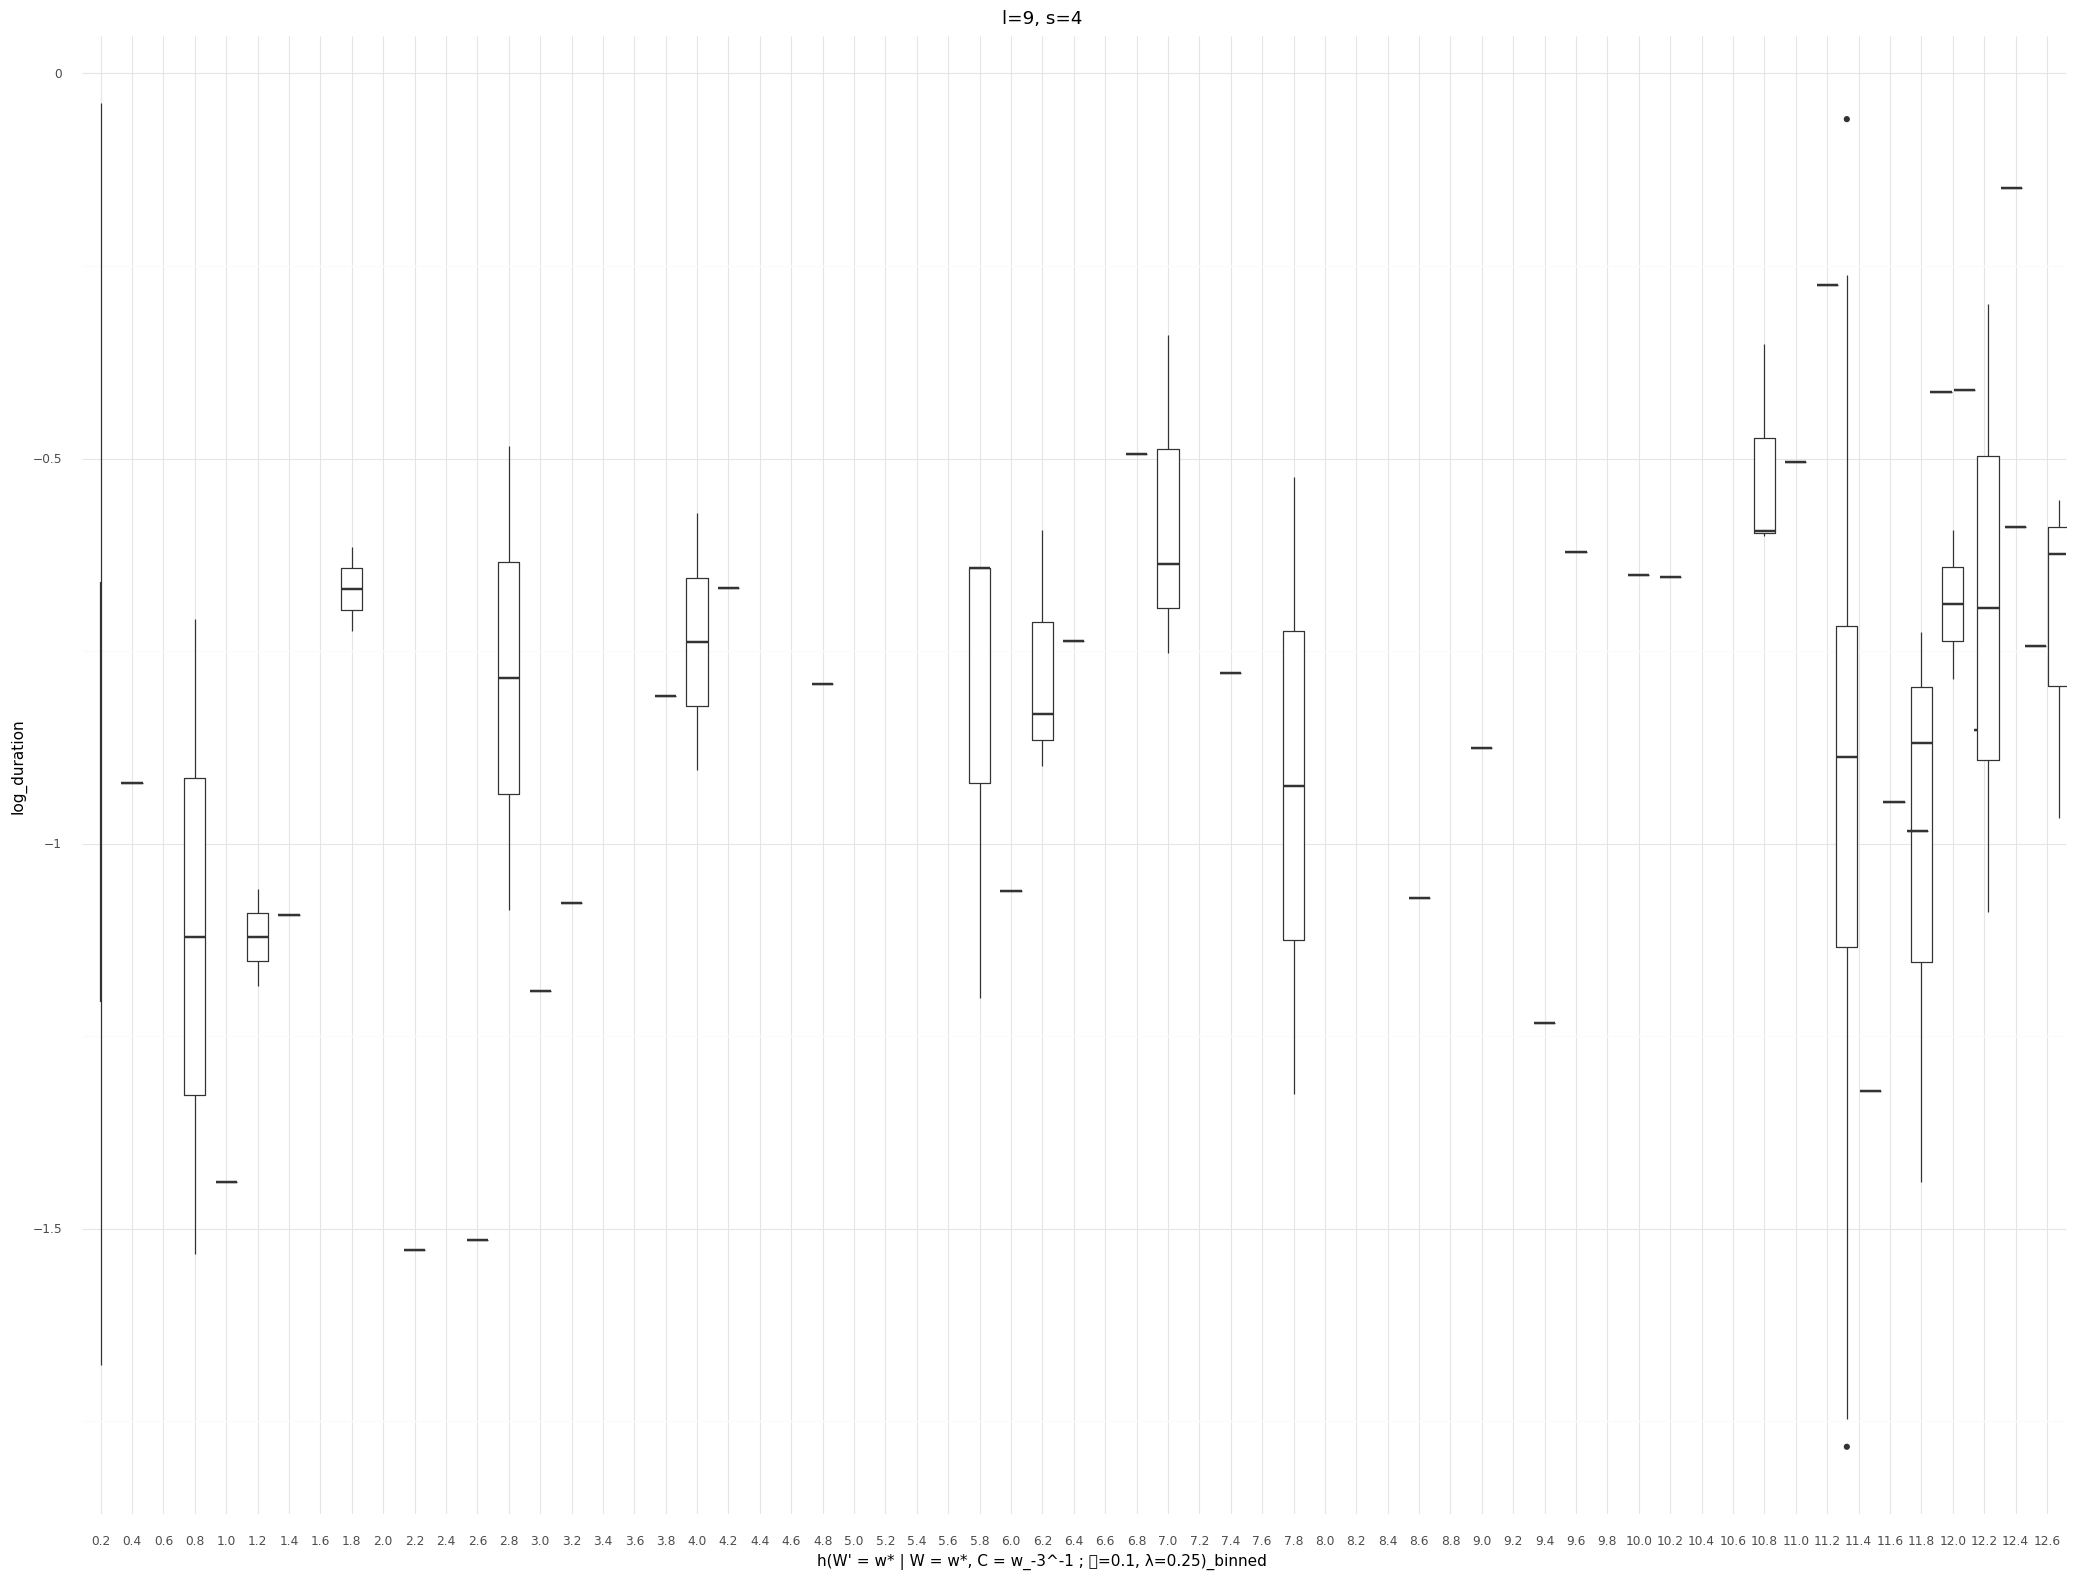

<ggplot: (8779366581621)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=9
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=4, l=9
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=4, l=9, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


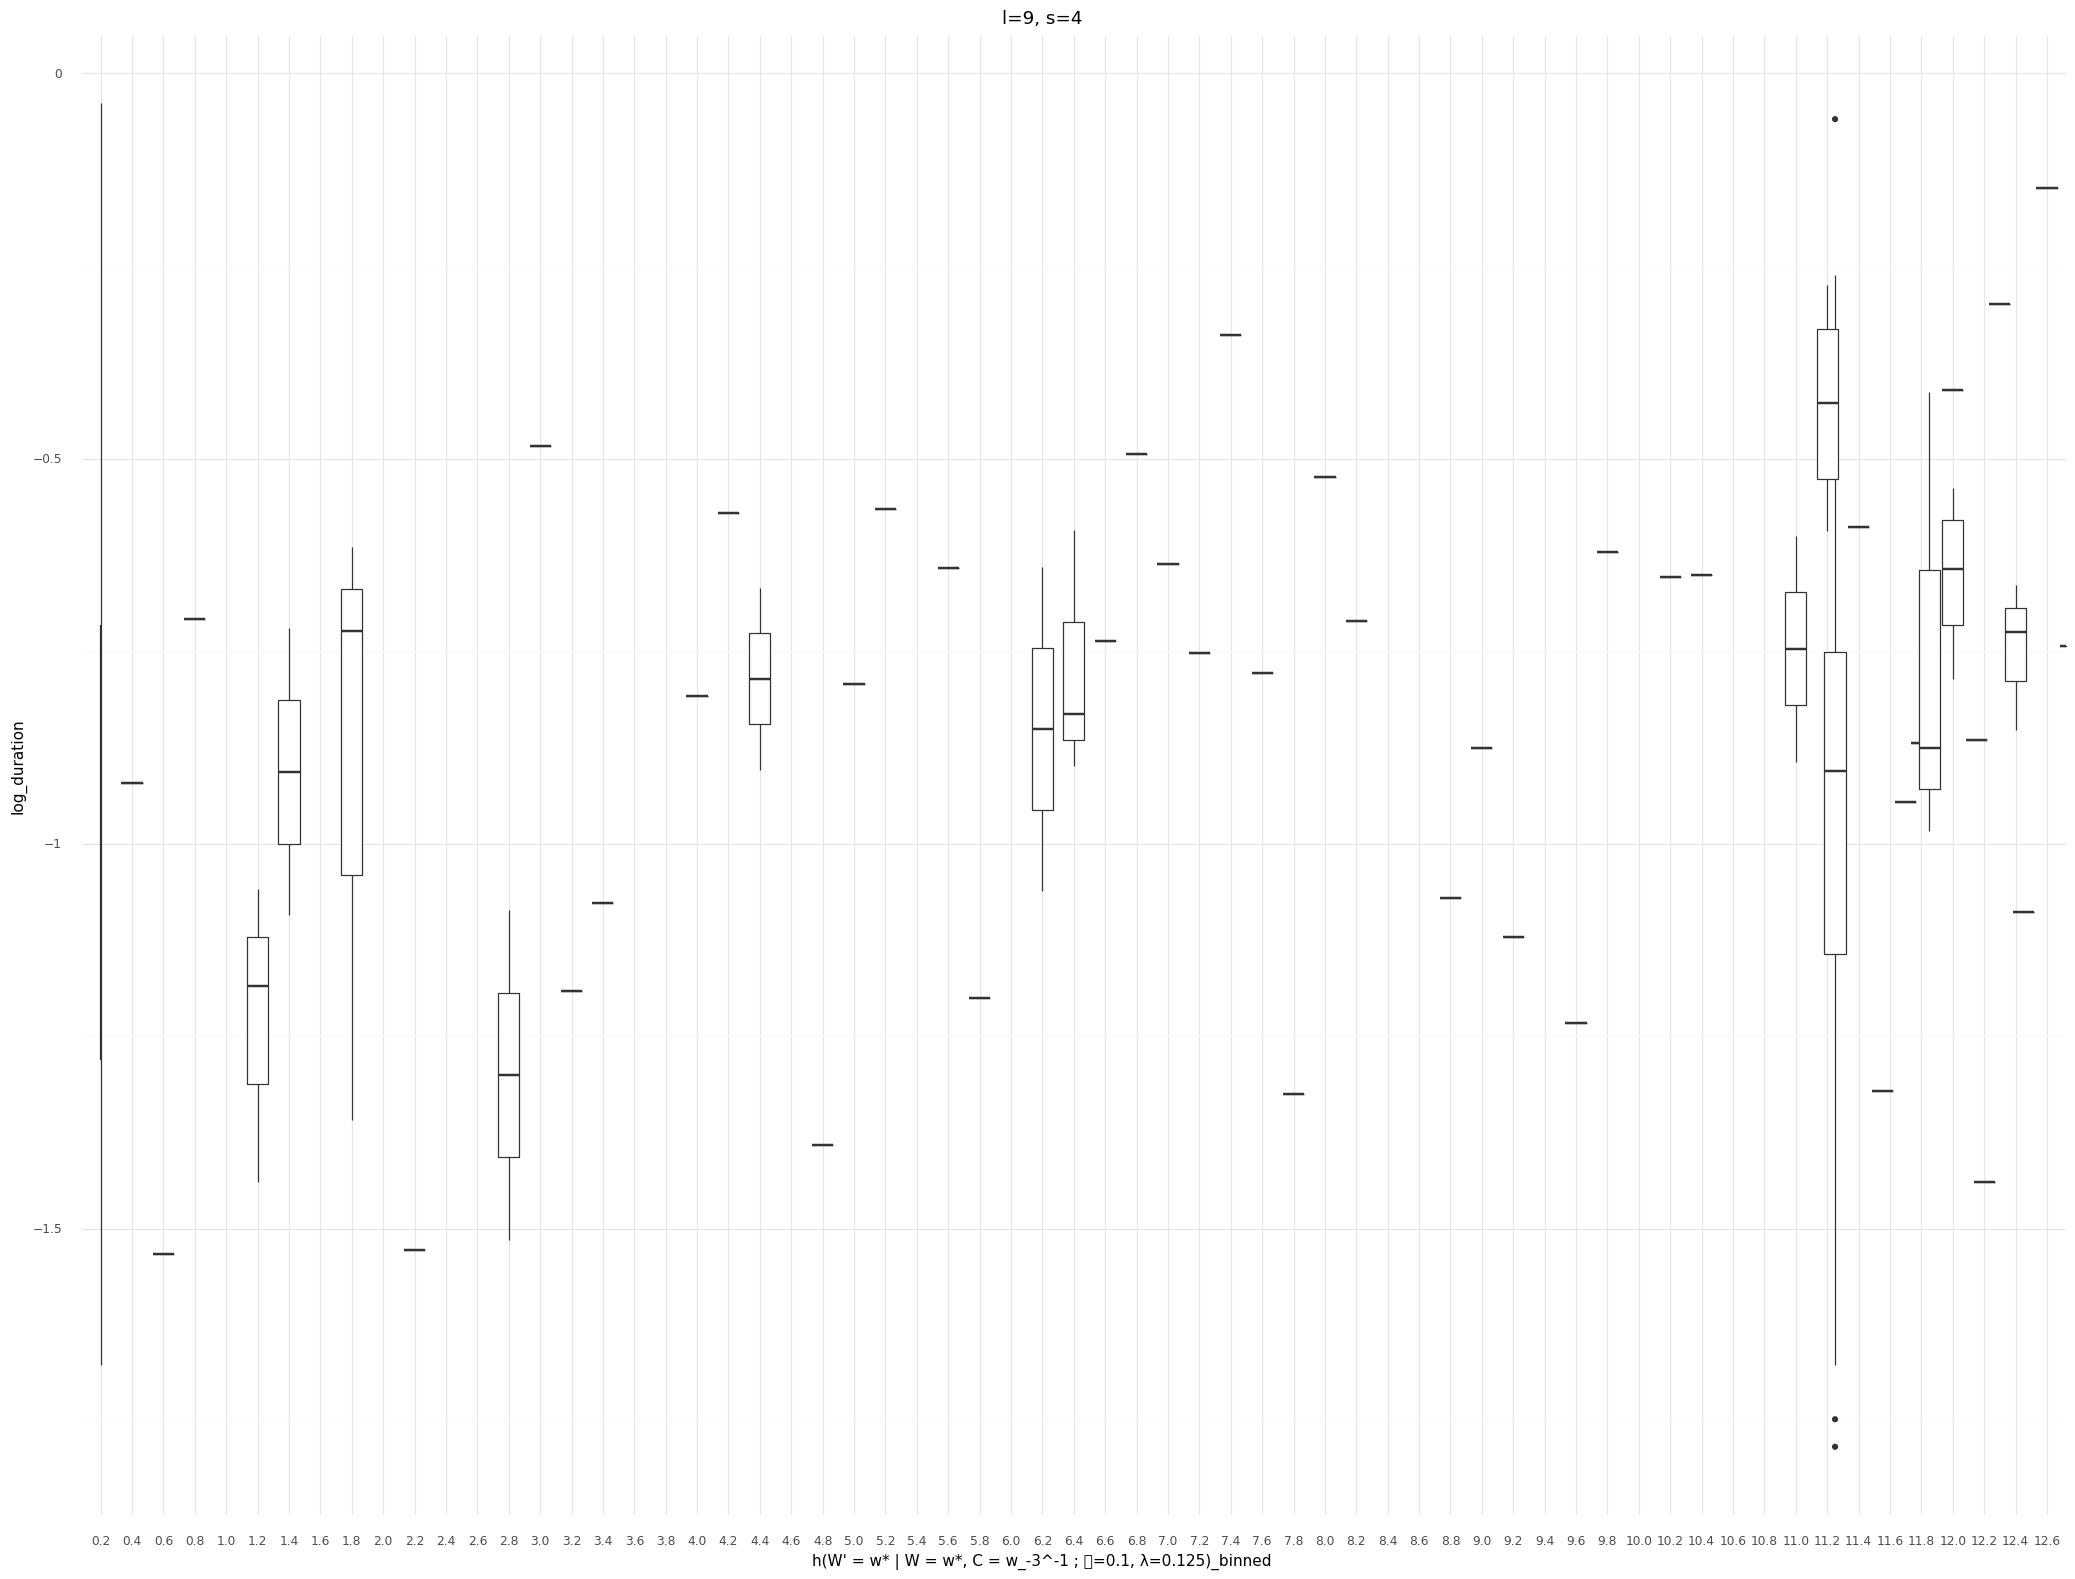

<ggplot: (8779447882921)>

................................................................................
--------------------------------------------------------------------------------


s=4, l=10
	s=4, l=10
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		s=4, l=10
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=1.0)_binned
		Duration Field = log_duration
s=4, l=10, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


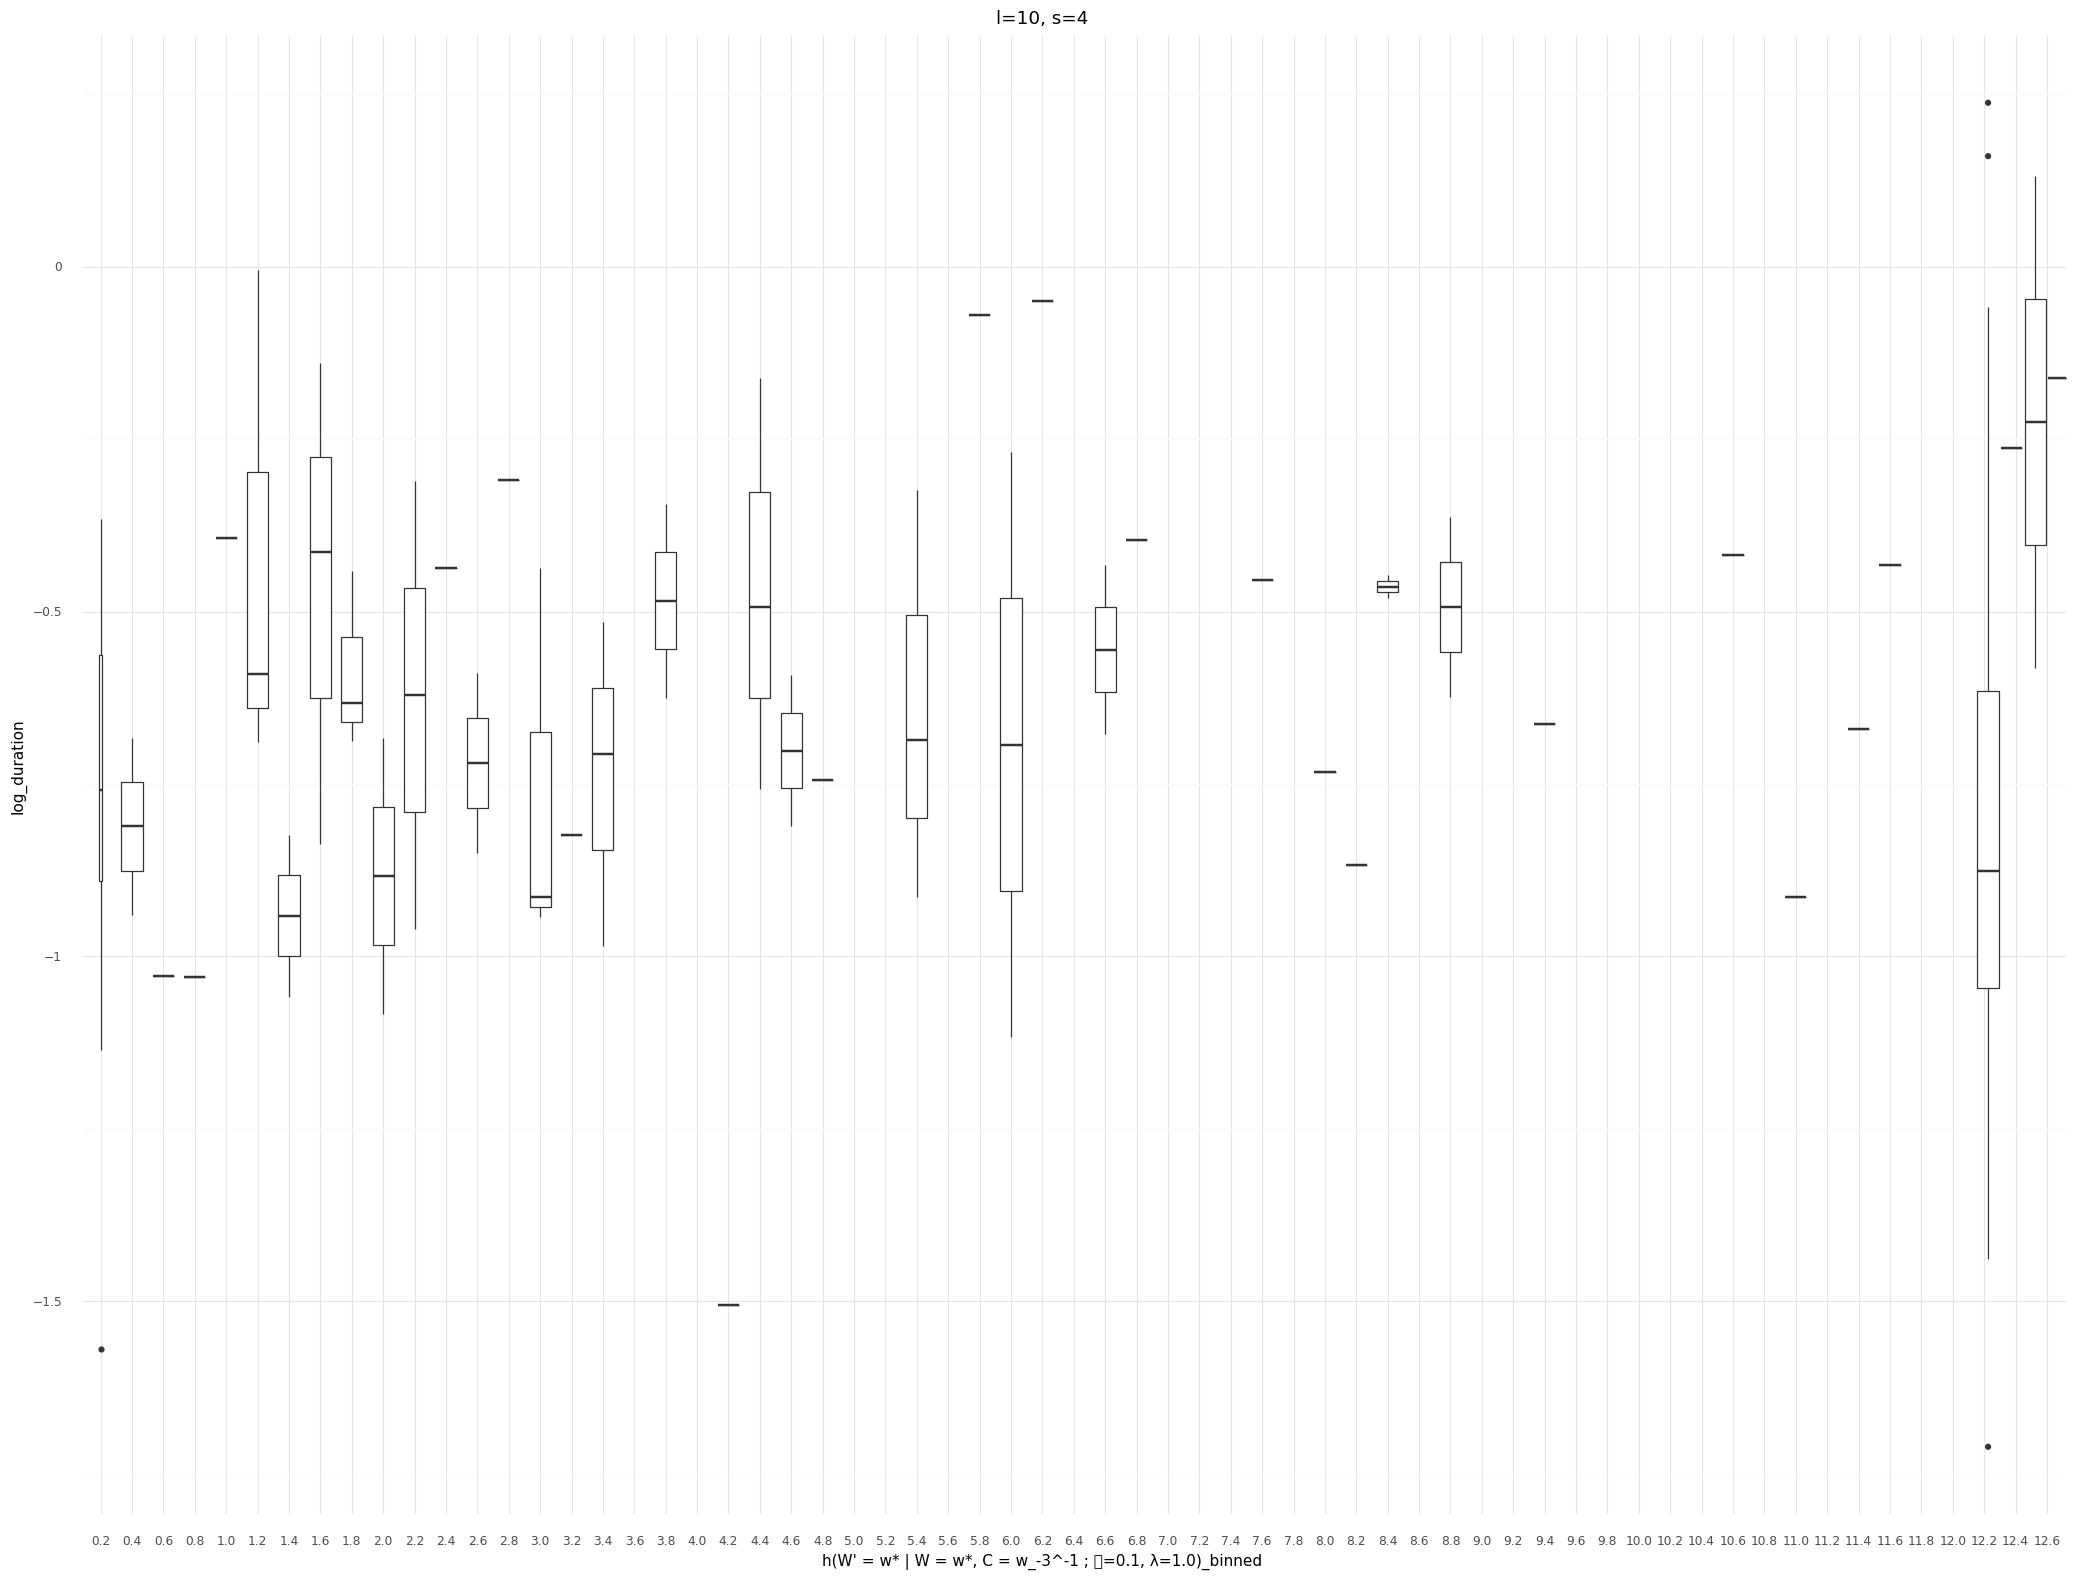

<ggplot: (8779399873869)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=10
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		s=4, l=10
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.5)_binned
		Duration Field = log_duration
s=4, l=10, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


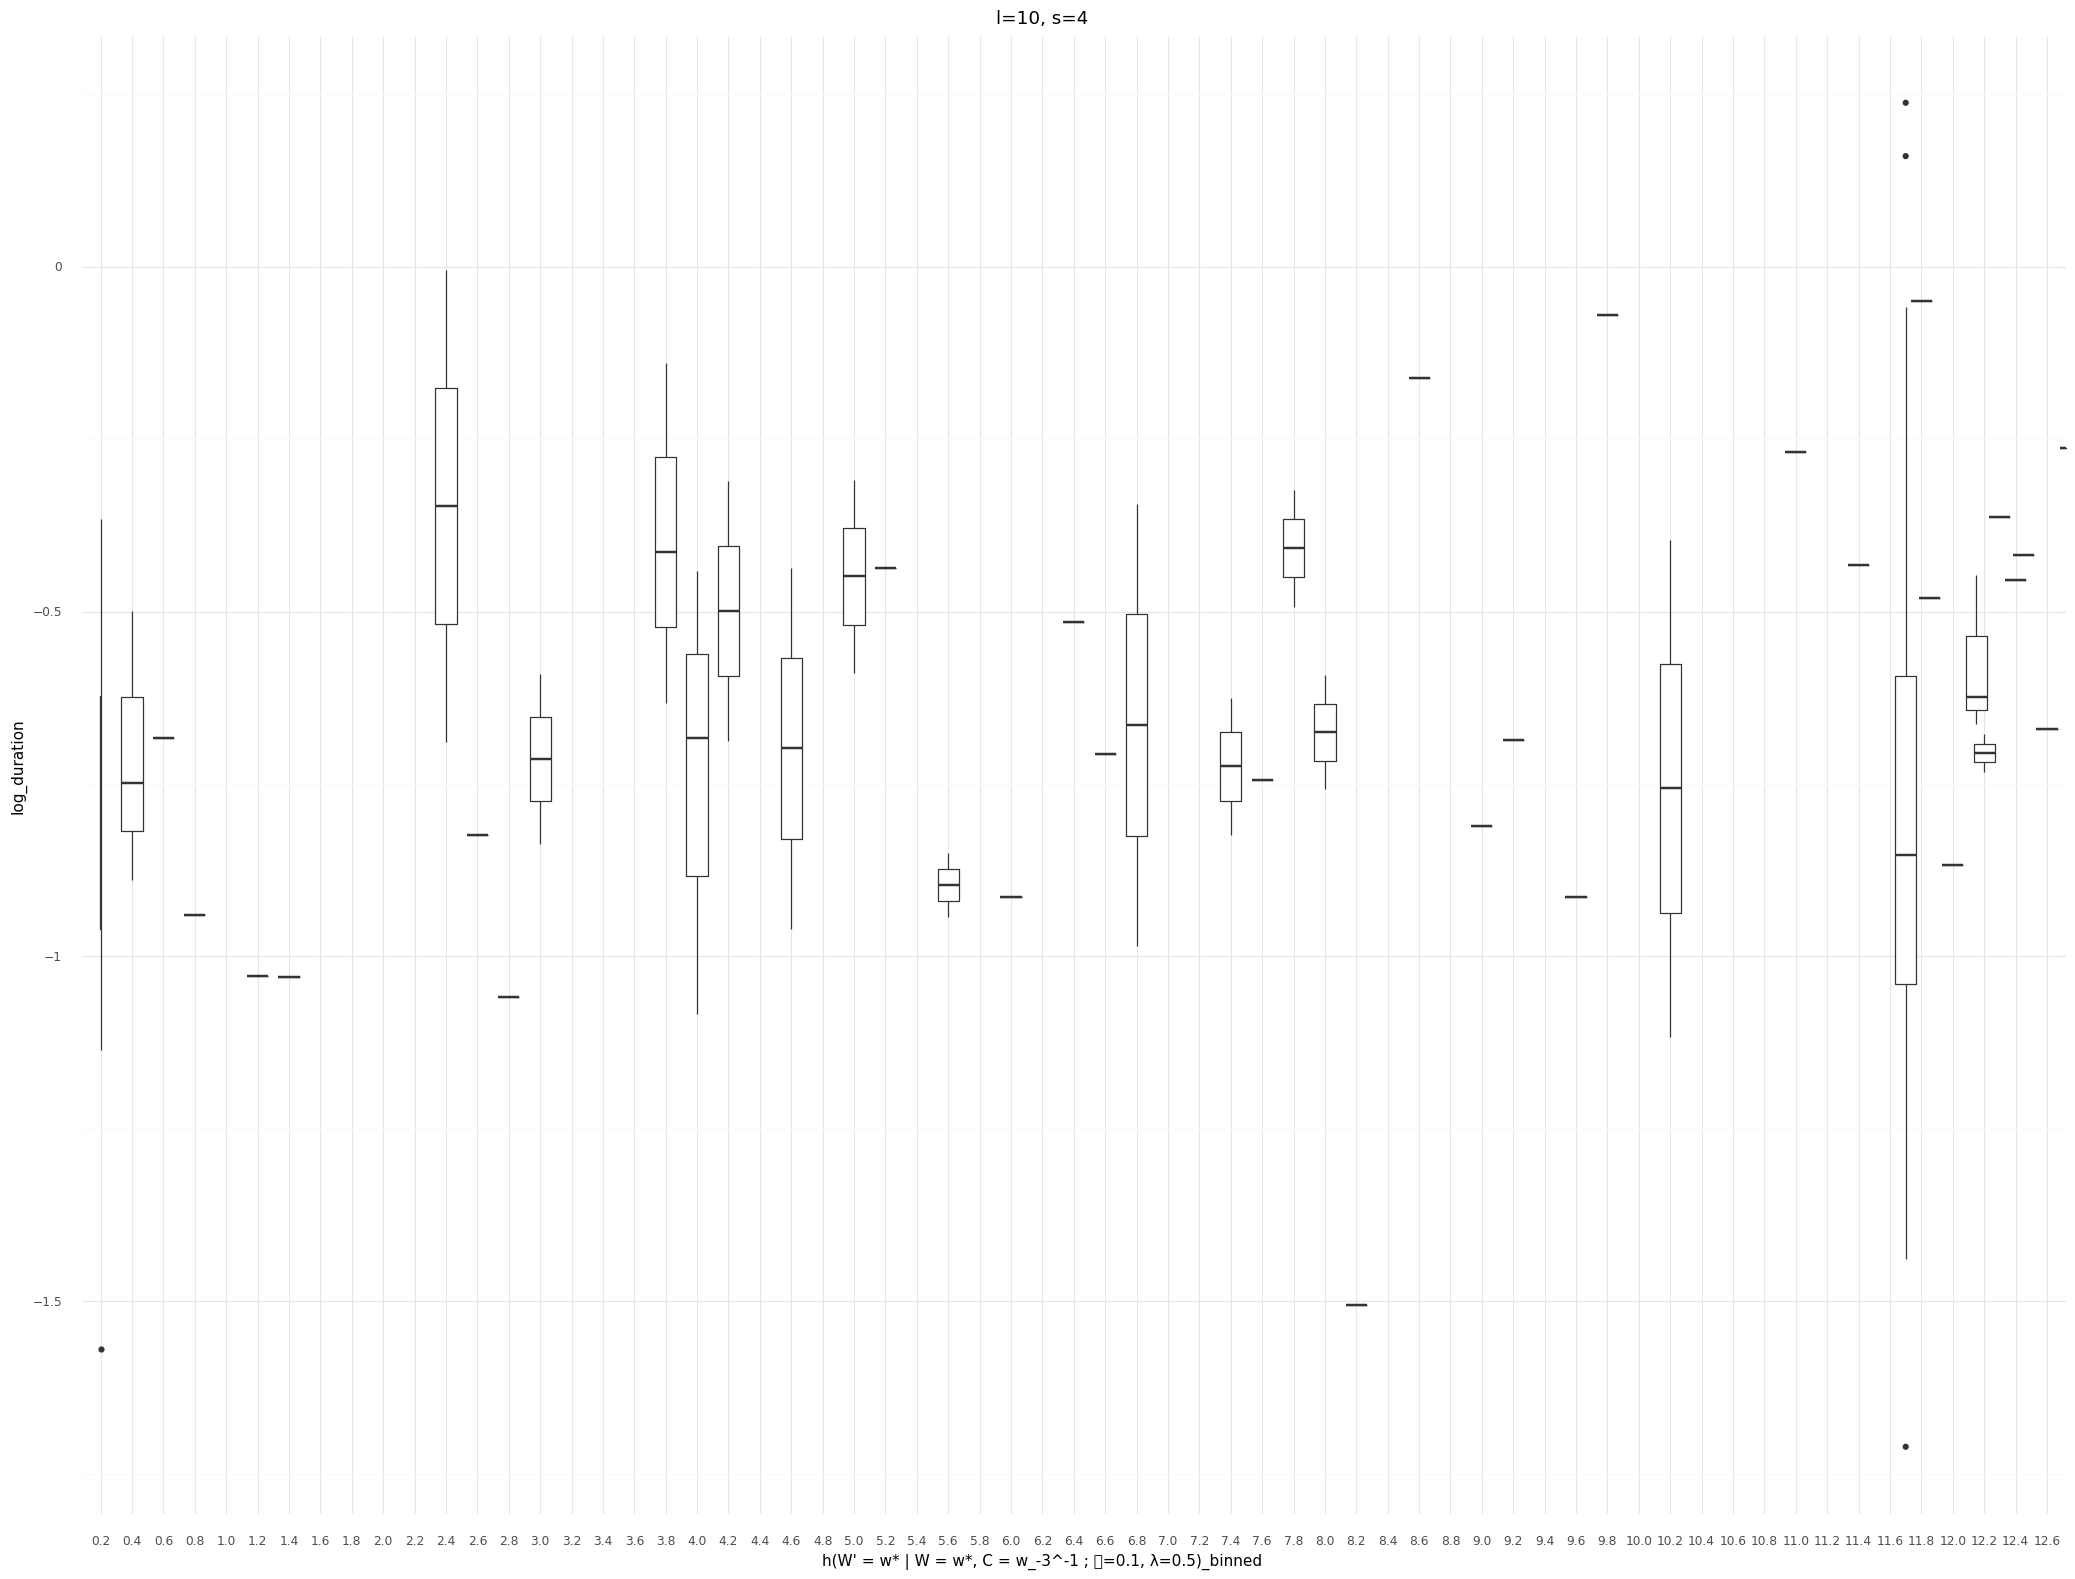

<ggplot: (8779354917713)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=10
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		s=4, l=10
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.25)_binned
		Duration Field = log_duration
s=4, l=10, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


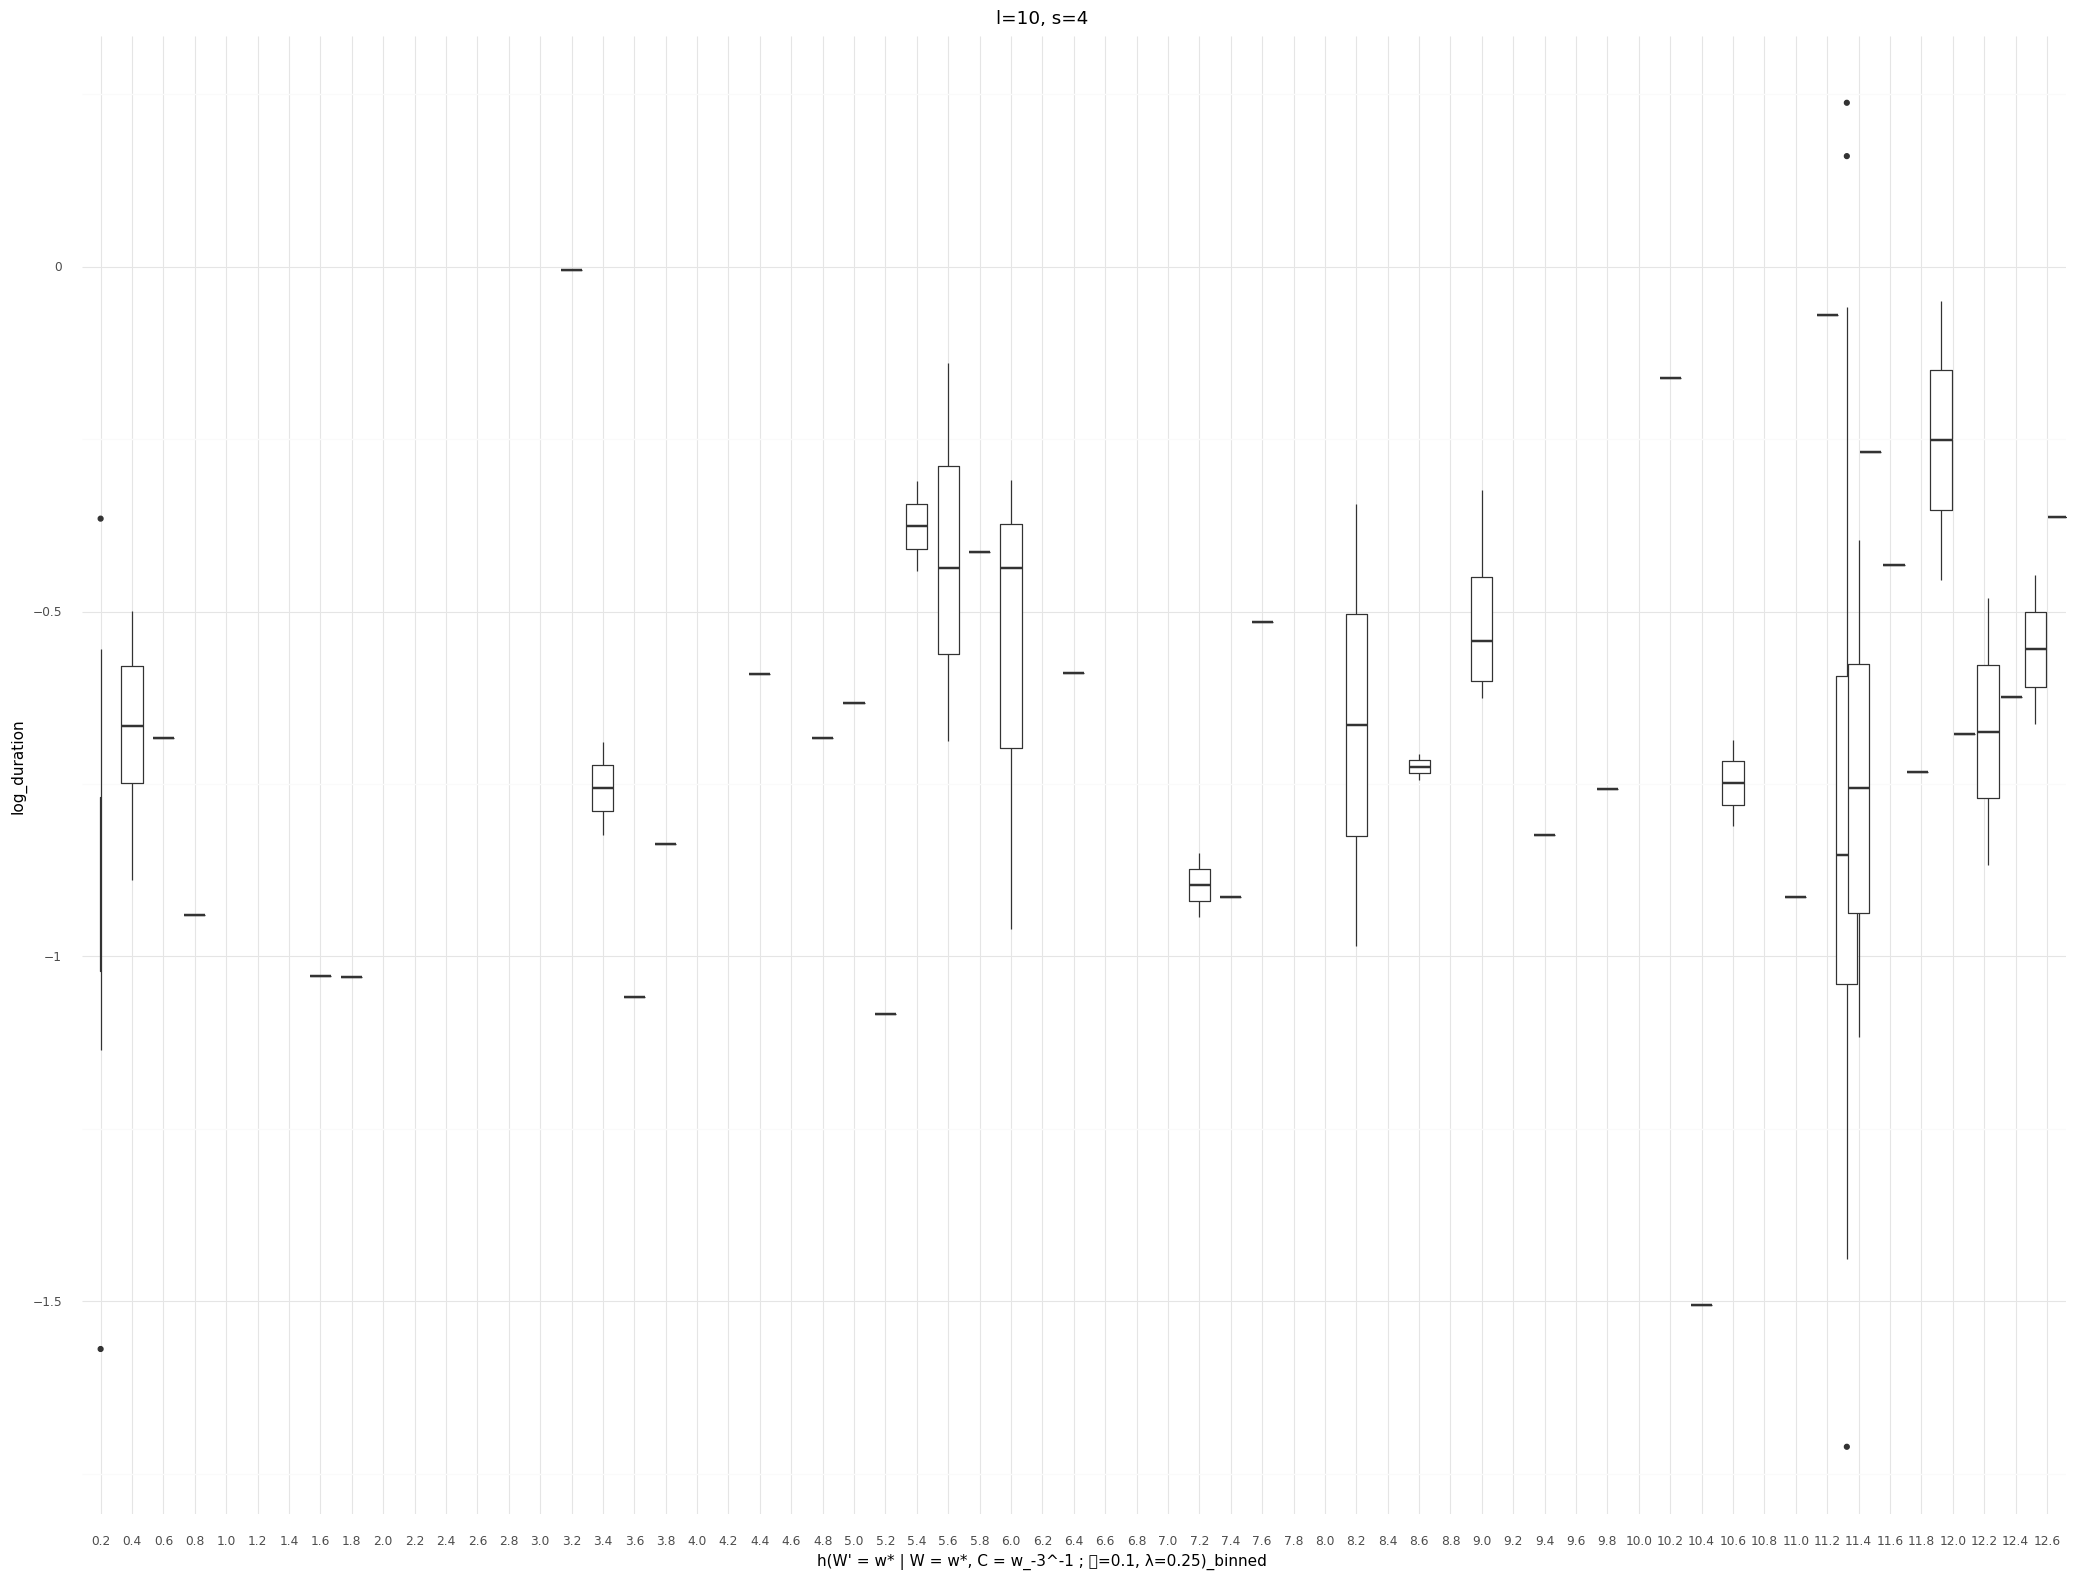

<ggplot: (8779367942849)>

................................................................................
--------------------------------------------------------------------------------
	s=4, l=10
	Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		s=4, l=10
		Surprisal Field = h(W' = w* | W = w*, C = w_-3^-1 ; 𝛼=0.1, λ=0.125)_binned
		Duration Field = log_duration
s=4, l=10, log_duration ~ forwards  posterior:


/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/AD/emeinhar/anaconda3/envs/jax-gpu2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 120572 missing from current font.
  font.set_text(s, 0, flags=flags)


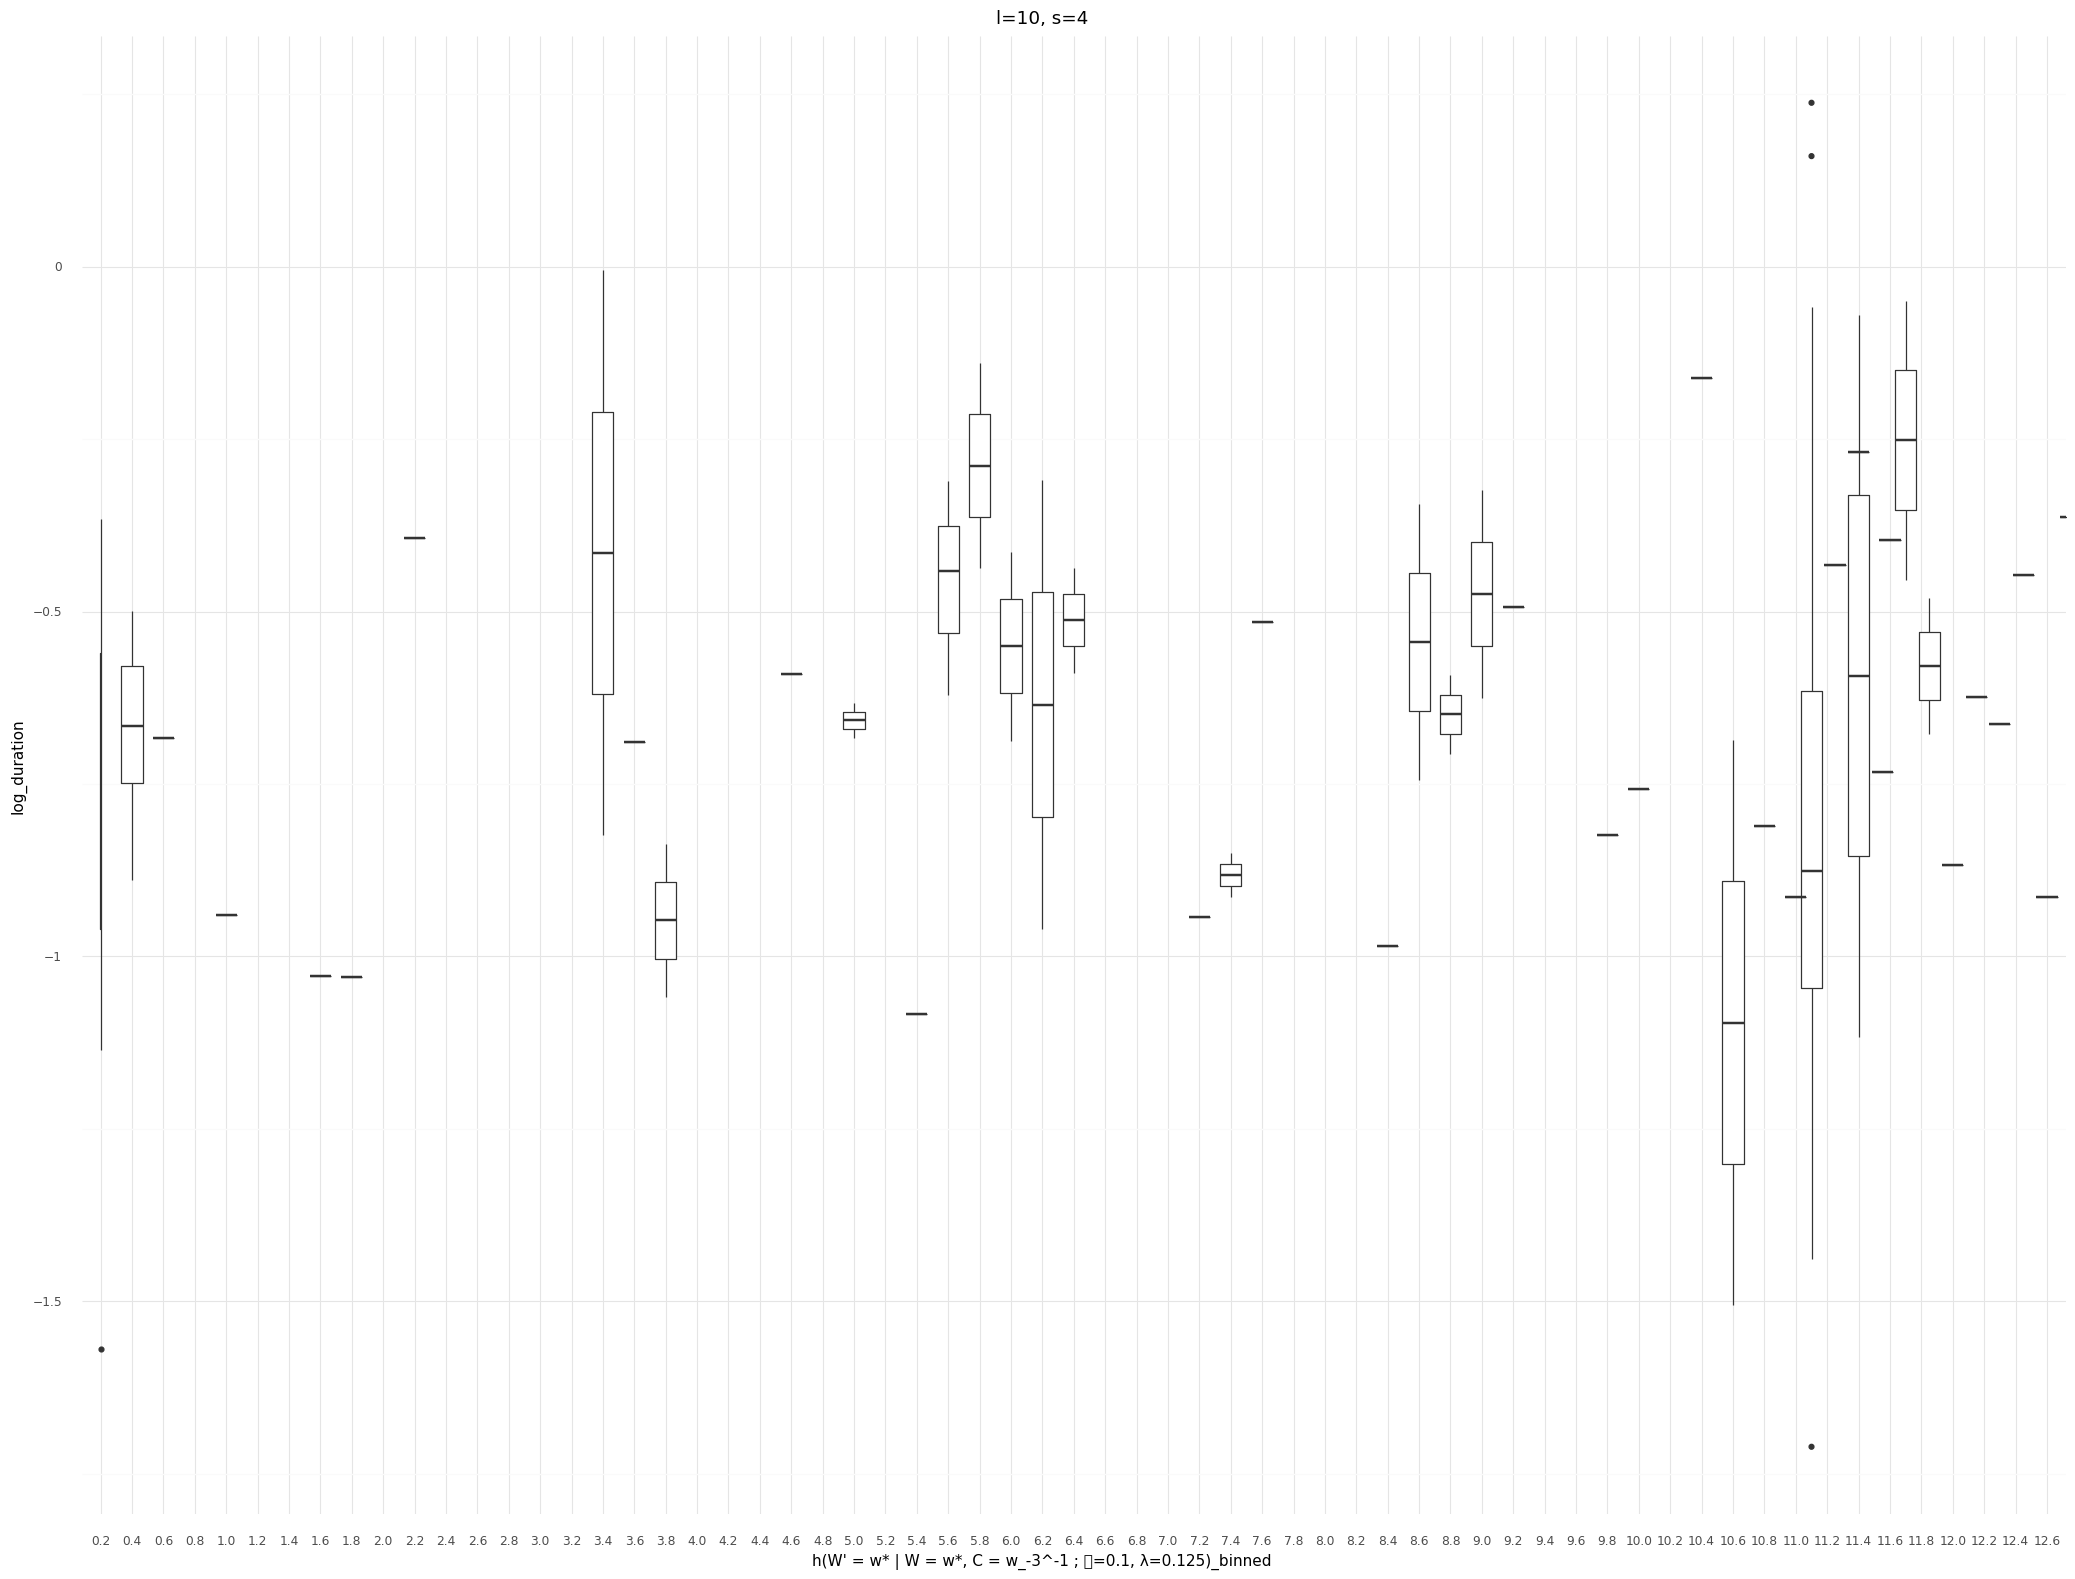

<ggplot: (8779355210009)>

................................................................................
--------------------------------------------------------------------------------




In [171]:
#truncated x-axis, bin width 0.2

#rescaling the x axis

for each_s, each_l in syll_seg_combos:
    print(f"s={each_s}, l={each_l}")
    for surp_field in lmap(lambda field_name: field_name + '_binned',
                       four_gram_bwds_post_fields_pc01):
#     for surp_field in lmap(lambda field_name: field_name + '_binned', (post_field_backward_h,
#                                                                        post_field_backward_h_bar,
#                                                                        post_field_forward_h,
#                                                                        post_field_forward_h_bar)):
#     for surp_field in lmap(lambda field_name: field_name + '_binned', (lm_field_backward_h, post_field_backward_h,
#                                                                        lm_field_forward_h, post_field_forward_h)):
        print(f"\ts={each_s}, l={each_l}")
        print(f"\tSurprisal Field = {surp_field}")
        for dur_field in ('log_duration',):
#         for dur_field in ('duration', 'log_duration'):
            print(f"\t\ts={each_s}, l={each_l}")
            print(f"\t\tSurprisal Field = {surp_field}")
            print(f"\t\tDuration Field = {dur_field}")
            my_dir = 'backwards' if '+' in surp_field else 'forwards'
            is_avg_str = 'avg in-context' if 'bar' in surp_field else ''
            print(f"s={each_s}, l={each_l}, {dur_field} ~ {my_dir} {is_avg_str} posterior:")
#             x_scale_limits = surprisal_bins_generic_edges_cat
            x_scale_limits = surprisal_bins_generic_edges_cat_trimmed
#             x_scale_limits = surprisal_bins_edges_cat if "W'" in surp_field else surprisal_bins_lm_edges_cat
            make_plot(dev_words_df[(dev_words_df[num_segs_field] == each_l) & (dev_words_df[num_syll_field] == each_s)], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"l={each_l}, s={each_s}")
#             make_plot(dev_words_df[dev_words_df['syllables'] == each_s], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"s={each_s}")
#             make_plot(dev_words_df[dev_words_df[num_segs_field] == each_l], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"l={each_l}")
#             make_plot(dev_words_df[dev_words_df['syllables'] == each_s], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"s={each_s}")
            print('.' * 80)
        print('-' * 80)
    print('=' * 80)
    print('\n')

In [ ]:
#truncated x-axis, bin width 0.2

#rescaling the x axis

for each_s, each_l in syll_seg_combos:
    print(f"s={each_s}, l={each_l}")
    for surp_field in lmap(lambda field_name: field_name + '_binned',
                       four_gram_bwds_post_fields_pc001):
#     for surp_field in lmap(lambda field_name: field_name + '_binned', (post_field_backward_h,
#                                                                        post_field_backward_h_bar,
#                                                                        post_field_forward_h,
#                                                                        post_field_forward_h_bar)):
#     for surp_field in lmap(lambda field_name: field_name + '_binned', (lm_field_backward_h, post_field_backward_h,
#                                                                        lm_field_forward_h, post_field_forward_h)):
        print(f"\ts={each_s}, l={each_l}")
        print(f"\tSurprisal Field = {surp_field}")
        for dur_field in ('log_duration',):
#         for dur_field in ('duration', 'log_duration'):
            print(f"\t\ts={each_s}, l={each_l}")
            print(f"\t\tSurprisal Field = {surp_field}")
            print(f"\t\tDuration Field = {dur_field}")
            my_dir = 'backwards' if '+' in surp_field else 'forwards'
            is_avg_str = 'avg in-context' if 'bar' in surp_field else ''
            print(f"s={each_s}, l={each_l}, {dur_field} ~ {my_dir} {is_avg_str} posterior:")
#             x_scale_limits = surprisal_bins_generic_edges_cat
            x_scale_limits = surprisal_bins_generic_edges_cat_trimmed
#             x_scale_limits = surprisal_bins_edges_cat if "W'" in surp_field else surprisal_bins_lm_edges_cat
            make_plot(dev_words_df[(dev_words_df[num_segs_field] == each_l) & (dev_words_df[num_syll_field] == each_s)], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"l={each_l}, s={each_s}")
#             make_plot(dev_words_df[dev_words_df['syllables'] == each_s], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"s={each_s}")
#             make_plot(dev_words_df[dev_words_df[num_segs_field] == each_l], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"l={each_l}")
#             make_plot(dev_words_df[dev_words_df['syllables'] == each_s], surp_field, dur_field, x_scale_limits=x_scale_limits, title=f"s={each_s}")
            print('.' * 80)
        print('-' * 80)
    print('=' * 80)
    print('\n')

In [ ]:
syll_seg_combos

In [ ]:
my_alpha
my_lambda

# sylls = (1,2,3,4)
# segs = (2,3,4,5,6,7,8,9,10)

def n_gram_bwd_post_custom_length_plot(n_syll, n_seg):
    surp_field = mk_field('post', 
                          order=4, direction='bwd',
                          pc=my_alpha,
                          scale_factor = my_lambda)
    my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
    my_boxwhisker.opts(show_legend=False, width=2400, height=800, cmap='Set3')
    return my_boxwhisker

custom_length_dmap = hv.DynamicMap(n_gram_bwd_post_custom_length_plot, kdims=['n_syll', 'n_seg'])
custom_length_dmap

alphas
lambdas
custom_length_dmap.redim.values(n_syll=sylls, n_seg=segs)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# dev_words_df[fourgram_bwd_post_01_10].head()
# dev_words_df[fourgram_bwd_post_01_10 + '_binned'].head()
# pd.to_numeric(dev_words_df[fourgram_bwd_post_01_10 + '_binned']).head()

In [ ]:
fourgram_bwd_post_01_10 = mk_field('post', 
                                   order=4, direction='bwd',# if order > 1 else 'uni',
                                   pc=0.01, scale_factor = 1.0)
fourgram_bwd_post_01_10

In [ ]:
my_alpha
my_lambda

# sylls = (1,2,3,4)
# segs = (2,3,4,5,6,7,8,9,10)
# orders = (2,3,4)
# alphas = (0.001, 0.01, 0.1)
lambdas

def xtick_formatter(xtick_label):
    return "{:02.1f}".format(float(xtick_label))

def bwd_post_custom_plot(n_syll, n_seg, order, my_alpha, my_lambda):
    surp_field = mk_field('post', 
                          order=order, direction='bwd',# if order > 1 else 'uni',
                          pc=my_alpha,
                          scale_factor = my_lambda)
    my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df[num_syll_field] == n_syll)])
#     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
#     my_data = dev_words_df
#     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
#     x_range=surprisal_bins_generic_edges_cat_trimmed
    my_boxwhisker = hv.BoxWhisker(my_data, surp_field+'_binned', 'log_duration', label=f'log(duration) ~ post prob').sort()
#     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
#     my_boxwhisker.redim
#     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
    my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3')
#     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
#     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
#     my_xticks = every_fourth_xtick
#     my_xticks = surprisal_bins_generic_edges_cat
#     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
    return my_boxwhisker

custom_bwd_dmap = hv.DynamicMap(bwd_post_custom_plot, kdims=['n_syll', 'n_seg', 'order', 'my_alpha', 'my_lambda'])
custom_bwd_dmap

# alphas
# lambdas
# custom_bwd_dmap.redim(x=hv.Dimension())
custom_bwd_dmap.redim.values(n_syll=sylls, n_seg=segs, order=orders, my_alpha=alphas, my_lambda=lambdas)

In [ ]:
def custom_plot(n_syll=1, n_seg=2, order=4, my_alpha=0.1, my_lambda=1.0, type_str='post', avg=False, direction='bwd'):
    if order == 1:
        direction = 'uni'
    surp_field = mk_field(type_str=type_str, 
                          order=order, direction=direction,# if order > 1 else 'uni',
                          avg=avg,
                          pc=my_alpha,
                          scale_factor = my_lambda)
    
    dist_type_str = 'posterior' if type_str == 'post' else 'prior'
    if direction == 'bwd':
        dir_str = 'bwd'
    elif direction == 'fwd':
        dir_str = 'fwd'
    else:
        dir_str = ''
    param_str = '(' + f'𝛼={my_alpha}' + ', ' + f'λ={my_lambda}' + ')' if type_str == 'post' else ''
    
    selection_str = f' for words w/ {n_syll} syll ∧ {n_seg} seg'
    
    plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str + selection_str
        
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')'
    
    
    my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df[num_syll_field] == n_syll)])
#     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
#     my_data = dev_words_df
#     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
#     x_range=surprisal_bins_generic_edges_cat_trimmed
    my_boxwhisker = hv.BoxWhisker(my_data, surp_field+'_binned', 'log_duration', label=f'log(duration) ~ {plot_type_str}').sort()
#     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
#     my_boxwhisker.redim
#     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
    my_boxwhisker.opts(show_legend=False, width=1800, height=600, cmap='Set3')#, hooks=[my_hook])
#     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
#     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
#     my_xticks = every_fourth_xtick
#     my_xticks = surprisal_bins_generic_edges_cat
#     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
    return my_boxwhisker

In [ ]:
a_plot = custom_plot(); a_plot

In [ ]:
from bokeh.models import FactorRange

In [ ]:
surprisal_bins_generic_edges_cat[0]
surprisal_bins_generic_edges_cat[-1]

In [ ]:
# print(surprisal_bins_generic_edges_cat)
# print(rev(surprisal_bins_generic_edges_cat))
# print(surprisal_bins_generic_edges_cat)

In [ ]:
# from bokeh.models.tickers import FixedTicker

In [ ]:
# surprisal_bins_generic_edges_cat

In [ ]:
# lmap(float, surprisal_bins_generic_edges_cat)

In [ ]:
def my_hook(plot, element):
    print('plot.state:   ', plot.state)
    print('plot.handles: ', sorted(plot.handles.keys()))
#     print(plot.handles['x_range'])
#     print(type(plot.handles['x_range']))
#     plot.handles['x_range'] = FactorRange(factors=rev(surprisal_bins_generic_edges_cat))
#     print(plot.handles['x_range'])
    print(plot.handles['xaxis'])
    print(dir(plot.handles['xaxis'].ticker))
#     print(plot.handles['xaxis'].ticker.select())
#     plot.handles['xaxis'].minor_label_text_font_size = '0pt' 
#     my_labels = 
#     plot.handles['xaxis'].major_label_overrides = {edge:str(float(edge)) if i % 4 == 0 else ''
#                                                    for i, edge in enumerate(surprisal_bins_generic_edges_cat)}
#     plot.handles['xaxis'].ticker = FixedTicker(ticks = [t
#                                                         for i,t in enumerate(surprisal_bins_generic_edges_cat_trimmed) 
#                                                         if i % 4 == 0])

In [ ]:
# class Dist(param.Parameterized):

#     n_syll_p    = param.ObjectSelector(default=sylls[0], objects=list(sylls))
#     n_seg_p     = param.ObjectSelector(default=segs[0], objects=list(segs))
#     order_p     = param.ObjectSelector(default=orders[0], objects=list(orders))
#     alpha_p     = param.ObjectSelector(default=lambdas[0], objects=list(lambdas))
#     lambda_p    = param.ObjectSelector(default=alphas[0], objects=list(alphas))
#     type_str_p  = param.ObjectSelector(default="post", objects=["post", "lm"])
#     avg_p       = param.Boolean(False)
#     direction_p = param.ObjectSelector(default="bwd", objects=["bwd", "fwd", "uni"])

# d = Dist()

# pn.Row(d.param)

In [ ]:
n_syll_p = pn.widgets.DiscreteSlider(name='# Syllables', options=list(sylls), value=sylls[0])
n_seg_p = pn.widgets.DiscreteSlider(name='# Segments', options=list(segs), value=segs[0])
order_p = widgets.IntSlider(name='N-gram Order', start=1,end=4,step=1,value=4)
direction_p = pn.widgets.Select(name='LM direction', options=['bwd', 'fwd', 'uni'])
alpha_p = pn.widgets.DiscreteSlider(name='Pseudocount', options=list(alphas), value=alphas[0])
lambda_p = pn.widgets.DiscreteSlider(name='Scale factor', options=list(lambdas), value=lambdas[0])
type_str_p = pn.widgets.Select(name='Dist type', options=['post', 'lm'])
avg_p = pn.widgets.Checkbox(name='Avg over contexts?')

dist_control = pn.Column(
    pn.Row(n_syll_p, n_seg_p, order_p, direction_p),
    pn.Row(alpha_p, lambda_p, type_str_p, avg_p))

In [ ]:
from panel.interact import interact

In [ ]:
custom_plot_interact_obj = interact(
         custom_plot, 
         n_syll = n_syll_p,
         n_seg = n_seg_p,
         order = order_p,
         direction = direction_p,
         my_alpha = alpha_p,
         my_lambda = lambda_p,
         type_str = type_str_p,
         avg = avg_p)
linked_surp_hist_interact_obj = pn.interact(
         make_surp_hist,
         #  n_syll = n_syll_p,
         # n_seg = n_seg_p,
         order = order_p,
         direction = direction_p,
         pc = alpha_p,
         scale_factor = lambda_p,
         type_str = type_str_p,
         avg = avg_p
                                            )
# len(custom_plot_interact_obj)
# dist_control
# custom_plot_interact_obj[1]
# linked_surp_hist_interact_obj[1]
pn.Column(custom_plot_interact_obj[1],
          pn.Row(linked_surp_hist_interact_obj[1],
                 dist_control))

In [ ]:
bad_avg_field = mk_field('post', True, 4, 'bwd', pc=0.001, scale_factor = 0.015625)
bad_avg_field

In [ ]:
len(dev_words)
has_bad_avg_field = lfilter(lambda rel: bad_avg_field in rel, 
                            dev_words)
len(has_bad_avg_field)

In [ ]:
garbage = lpluck(bad_avg_field, has_bad_avg_field)

In [ ]:
all(np.isnan, garbage)

In [ ]:
print(syll_seg_combos)

print(f"sylls = {sylls}")
print(f"segs = {segs}")
print(f"orders = {orders}")
print(f"alphas = {alphas}")
print(f"lambdas = {lambdas}")

# custom_dmap.select(n_syll=3, n_seg=4, order=4, my_alpha=0.1, my_lambda=1.0)

## Statistical analysis

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# mk_field?

In [ ]:
transcription_length_field
'syllables'
num_segs_field
num_syll_field

In [ ]:
lfilter(lambda f: 'eighborhood' in f,
        dev_words[0].keys())

dev_words[0]['Neighborhood size']
dev_words[0]['log_Weighted neighborhood density_binned']

In [ ]:
set(lmap(type,
         lpluck('Neighborhood size',
                lfilter(lambda rel: 'Neighborhood size' in rel,
                        dev_words))))

lpluck('Neighborhood size',
       lfilter(lambda rel: 'Neighborhood size' in rel and type(rel['Neighborhood size']) == float and not np.isnan(rel['Neighborhood size']),
               dev_words))

In [ ]:
for rel in tqdm(dev_words):
    if 'Neighborhood size' + '_rank' in rel:
        rel['neighborhood_size_rank'] = rel['Neighborhood size' + '_rank']
    if 'log_Neighborhood size' + '_rank' in rel:
        rel['log_neighborhood_size_rank'] = rel['log_Neighborhood size' + '_rank']
    if 'Weighted neighborhood density' + '_rank' in rel:
        rel['weighted_neighborhood_density_rank'] = rel['Weighted neighborhood density' + '_rank']
    if 'log_Weighted neighborhood density' + '_rank' in rel:
        rel['log_weighted_neighborhood_density_rank'] = rel['log_Weighted neighborhood density' + '_rank']
        
dev_words_df['neighborhood_size_rank'] = dev_words_df['Neighborhood size' + '_rank']
dev_words_df['log_neighborhood_size_rank'] = dev_words_df['log_Neighborhood size' + '_rank']
dev_words_df['weighted_neighborhood_density_rank'] = dev_words_df['Weighted neighborhood density' + '_rank']
dev_words_df['log_weighted_neighborhood_density_rank'] = dev_words_df['log_Weighted neighborhood density' + '_rank']
    
#     for rankable_field in fields_to_rank:
#         ranked_fieldname = rankable_field + '_rank'
#         if ranked_fieldname in rel:

In [ ]:
for rel in tqdm(dev_words):
    if num_segs_field in rel:
        rel[num_segs_field + '_cat'] = str(rel[num_segs_field])
    if num_syll_field in rel:
        rel[num_syll_field + '_cat'] = str(rel[num_syll_field])
#     if transcription_length_field in rel:
#         rel[transcription_length_field + '_cat'] = str(rel[transcription_length_field])
#     if 'syllables' in rel:
#         rel['syllables_cat'] = str(rel['syllables'])
    if 'Neighborhood size' in rel:
        rel['Neighborhood size_cat'] = str(rel['Neighborhood size'])
        rel['neighborhood_size_cat'] = str(rel['Neighborhood size'])
        rel['neighborhood_size'] = rel['Neighborhood size']
    if 'Weighted neighborhood density' in rel:
        rel['weighted_neighborhood_density'] = rel['Weighted neighborhood density']
#     if 'log_Weighted neighborhood density_binned' in rel:
#         rel['log_Weighted neighborhood density_binned_cat'] = str(rel['log_Weighted neighborhood density_binned'])

dev_words_df[num_segs_field + '_cat'] = dev_words_df[num_segs_field].apply(str)
# dev_words_df[transcription_length_field + '_cat'] = dev_words_df[transcription_length_field].apply(str)
dev_words_df[num_syll_field + '_cat'] = dev_words_df[num_syll_field].apply(str)
# dev_words_df['syllables_cat'] = dev_words_df['syllables'].apply(str)
dev_words_df['Neighborhood size_cat'] = dev_words_df['Neighborhood size'].apply(str)
dev_words_df['neighborhood size_cat'] = dev_words_df['Neighborhood size'].apply(str)
dev_words_df['neighborhood_size'] = dev_words_df['Neighborhood size']
dev_words_df['weighted_neighborhood_density'] = dev_words_df['Weighted neighborhood density']

In [ ]:
# PARAMETER OPTIONS - DON'T REDEFINE THESE HERE
# alphas = (0.1, 0.01, 0.001)
# lambdas = (1.0, 0.5, 0.25, 0.125)
# all_orders = (1,2,3,4)
# directions = ('bwd', 'fwd', 'uni')
# orders = (4,3,2)
# sylls = (1,2,3,4)
# segs = (2,3,4,5,6,7,8,9,10)


# FIELD LISTS
# lm_fields
# post_fields
# surprisal_fields
# avg_fields
# fwd_fields
# bwd_fields
# alpha_fields
# lambda_fields
# uniphone_fields


# FIELD PREDICATES
# is_n_gram_field = lambda n: lambda f: (f'-{n}' in f or f'+{n}' in f) if n > 1 else 'C = ' not in f

# is_surprisal_field = lambda f: 'h(' in f or 'h-bar(' in f

# is_fwd_field = lambda f: 'C = w_-' in f
# is_bwd_field = lambda f: 'C = w_+' in f

# is_avg_field = lambda f: '-bar' in f

# is_lm_field = lambda f: "W'" not in f
# is_post_field = lambda f: "W'" in f

# is_lambda_field = lambda l: lambda f: f"λ={str(l)}" in f
# is_alpha_field = lambda pc: lambda f: f"𝛼={str(pc)}" in f

In [ ]:
# mk_field?

In [ ]:
def make_field_pairs():
    field_pairs = []
    for ts in ('lm', 'post'):
        for av in (False, True):
            for an_ord in all_orders:
                for a_dir in directions:
                    for an_alpha in alphas:
                        for a_lambda in lambdas:
                            try:
                                old_field = mk_field(ts, av, an_ord, a_dir, True, an_alpha, a_lambda, False)
                                new_field = mk_field(ts, av, an_ord, a_dir, True, an_alpha, a_lambda, True)
                                field_pairs.append((old_field, new_field))
                            except:
                                continue
    return field_pairs

In [ ]:
my_field_pairs = make_field_pairs()
len(my_field_pairs)
len(set(my_field_pairs))
my_field_pairs = set(my_field_pairs)

# lfilter(lambda f: any(f in rel for rel in dev_words),
#         lmap(first, my_field_pairs))
len(lfilter(lambda f: any(f in rel for rel in dev_words),
        lmap(first, my_field_pairs)))

In [ ]:
old_f_to_matching_new_fs = dict()
for old_f in lmap(first, my_field_pairs):
    right_matches = [new_f for (_, new_f) in my_field_pairs if _ == old_f]
    if old_f in old_f_to_matching_new_fs:
        for each_new_f in right_matches:
            old_f_to_matching_new_fs[old_f].add(each_new_f)
    else:
        old_f_to_matching_new_fs[old_f] = {each_new_f for each_new_f in right_matches}


In [ ]:
set(walk_values(len, old_f_to_matching_new_fs).values())
old_f_to_matching_new_fs

In [ ]:
field_pair_dict = dict(my_field_pairs)

def to_stat_field(old_field):
    return field_pair_dict.get(old_field, None)

In [ ]:
lmap(second, my_field_pairs)

In [ ]:
# stat_words = deepcopy(dev_words)

In [ ]:
# stat_words[0]

In [ ]:
stat_words = []
for rel in tqdm(dev_words):
    new_rel = deepcopy(rel)
#     for f_pair in my_field_pairs:
#         old_f = first(f_pair)
#         new_f = second(f_pair)
#         if old_f in rel:
#             rel[new_f] = rel[old_f]
    for f in rel:
        if f in old_f_to_matching_new_fs:
            new_f = list(old_f_to_matching_new_fs[f])[0]
            new_rel[new_f] = new_rel[f]
        if f[-5:] == '_rank' and f[:-5] in old_f_to_matching_new_fs:
            new_f = list(old_f_to_matching_new_fs[f[:-5]])[0] + '_rank'
            new_rel[new_f] = new_rel[f]
                
    stat_words.append(new_rel)
    
print('Convert to DF...')
stat_words_df = pd.DataFrame(stat_words)

In [ ]:
sorted(lfilter(lambda f: not ('-bar' in f or 'p(' in f or 'h(' in f),
        dev_words[0].keys()))

In [ ]:
dev_words[0]['segWord']
dev_words[0][syll_seg_field]
dev_words[0][syll_seg_field_cat]

dev_words[1]['segWord']
dev_words[1][syll_seg_field]
dev_words[1][syll_seg_field_cat]

In [ ]:
stat_words_columns = join(lmap(lambda rel: set(rel.keys()),
                               stat_words))

In [ ]:
# 'utt_id' in stat_words_df.columns
stat_words_df.columns

In [ ]:
for col in stat_words_columns:
    if col not in stat_words_df.columns:
        print(f"{col} missing from stat_words_df")

In [ ]:
stat_words[0]

In [ ]:
for old_f in old_f_to_matching_new_fs:
    new_f = list(old_f_to_matching_new_fs[old_f])[0]
    
    if old_f not in stat_words_df.columns:
        print(f"OLD field {old_f} not in stat_words_df...")
        print(' ')
    if new_f not in stat_words_df.columns:
        print(f"{new_f} not in stat_words_df...")
        print('====')

In [ ]:
stat_words[1]

In [ ]:
my_pc = 0.01
my_lambda = 0.125
my_stat_fields_pre_unigram = lfilter(lambda f: f is not None and ('pc' not in f or (str(my_pc).replace('.', 'dot') + '_' in f and str(my_lambda).replace('.', 'dot') in f)),
                                     lmap(to_stat_field,
                                          set(unigram_fields) & (set(post_fields) | set(lm_fields))))
my_stat_fields_pre = lfilter(lambda f: f is not None and '3' in f and ('pc' not in f or (str(my_pc).replace('.', 'dot') + '_' in f and str(my_lambda).replace('.', 'dot') in f)),
                             lmap(to_stat_field,
                                  set(fwd_fields) & (set(post_fields) | set(lm_fields))))
# my_stat_fields_pre = my_stat_fields_pre_unigram

# 0.1
# 0.125
# bwd
# 4-gram

In [ ]:
lmap(to_stat_field, set(fwd_fields))

In [ ]:
lmap(to_stat_field, post_fields)

In [ ]:
my_stat_fields_pre

In [ ]:
# fwd_fourgram_post_prior_fields = deepcopy(my_stat_fields_pre)
# fwd_fourgram_post_prior_fields

In [ ]:
# bwd_fourgram_post_prior_fields = deepcopy(my_stat_fields_pre)
# bwd_fourgram_post_prior_fields

In [ ]:
# unigram_post_prior_fields = deepcopy(my_stat_fields_pre)
# unigram_post_prior_fields

In [ ]:
# my_stat_fields = my_stat_fields_pre
# my_stat_fields = []

my_stat_fields = ['h_w_given_w_pc0dot01_sf0dot125_',
                  'avg_h_w_given_bwd3_',
                  'h_w_given_bwd3_']

# my_stat_fields = ['h_w_given_w_pc0dot01_sf0dot125_',
#                   'avg_h_w_given_fwd3_',
#                   'h_w_given_fwd3_']

In [ ]:
transcription_length_field
stat_words_df_nonan = stat_words_df[['log_duration', 
                                     'seg_length',
                                     'log_seg_length',
                                     'seg_length_cat',
                                     'syll_length',
                                     'syll_length_cat',
                                     'log_syll_length',
#                                      transcription_length_field, transcription_length_field + '_cat', 
#                                      'syllables', 'syllables' + '_cat',
                                     'speaker_id' if not 'buckeye' in a else 'speaker_name',
                                     'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate'
                                    ]
                                    + my_stat_fields].dropna()

In [ ]:
stat_words_df_nonan.info()
stat_words_df_nonan.head()

In [ ]:
mk_field?

In [ ]:
mk_field(type_str = 'post', avg=False, order=1, direction='uni', pc=0.01, scale_factor = 0.125, ascii=False)
mk_field(type_str = 'post', avg=False, order=1, direction='uni', pc=0.01, scale_factor = 0.125, ascii=True)
'h_w_given_w_pc0dot01_sf0dot125_'

In [ ]:
lfilter(lambda f: 'eighborhood_' in f,
        dev_words[0].keys())

In [ ]:
collect_fields = lambda rel: set(rel.keys())
all_fields = join(lmap(collect_fields, dev_words))
len(all_fields)

In [ ]:
all_fields

In [ ]:
set(dev_words[0].keys())

In [ ]:
# fields_to_rank = lm_fields + post_fields + [
# 'orthography_length' if 'buckeye' not in a else 'orthographic_wordform_length',
# 'speech_rate',
# 'log_speech_rate',
# 'seg_length',
# 'log_seg_length',
# 'syll_length',
# 'log_syll_length',
# 'Neighborhood size',
# 'log_Neighborhood size',
# 'Weighted neighborhood density',
# 'log_Weighted neighborhood density',
# 'duration',
# 'log_duration']
# len(fields_to_rank)

In [ ]:
not_a_prob_field = lambda f: '-bar' not in f and 'p(' not in f and 'h(' not in f and 'pc0' not in f and 'avg' not in f and 'given' not in f and 'h_' not in f

In [ ]:
lfilter(not_a_prob_field,
        set(stat_words[0].keys()))

In [ ]:
dev_words_df[annotated_fields[0]].isnull().sum()


In [ ]:
def duration_analysis(avg_post=True, include_main_post=True, order=4, direction='bwd', pc=0.01, scale_factor=1.0, 
                      avg_lm=True, include_lm=True, include_unigram_post=True, include_unigram_lm=True,
                      include_other_post_dir=True, include_other_lm_dir=True,
                      include_NS=True, include_NS_cat=True, include_lWND=True, 
                      include_phones_length = True, include_syll_length = True, include_seg_syll_length=True,
                      include_phones_length_cat=True, include_syll_length_cat=True, include_seg_syll_length_cat=True,
                      include_phones_syll_interaction=True,
                      include_speaker_id=True, include_POS=True, include_speech_rate=True,
                      include_segBag_features=False,
                      include_classBag_features=False,
                      include_main_post_as_rank=False,
                      include_main_lm_as_rank=False, include_unigram_post_as_rank=False, include_unigram_lm_as_rank=False,
                      include_other_post_dir_as_rank=False, include_other_lm_dir_as_rank=False,
                      include_NS_as_rank=False, include_lWND_as_rank=False,
                      include_phones_length_as_rank=False, include_syll_length_as_rank=False,
                      include_speech_rate_as_rank=False,
                      include_log_duration_as_rank=False):
    if order == 1:
        avg = False
    
    main_post_field = mk_field(type_str = 'post', avg=avg_post, order=order, direction=direction, pc=pc, scale_factor=scale_factor, ascii=True)
    if include_main_post:
        interesting_fields = [main_post_field]
    else:
        interesting_fields = []
    if include_main_post_as_rank:
        interesting_fields.append(main_post_field + '_rank')
    
    prior_field = mk_field(type_str = 'lm', avg=avg_lm, order=order, direction=direction, pc=pc, scale_factor=scale_factor, ascii=True)
    if include_lm:
        interesting_fields.append(prior_field)
    if include_main_lm_as_rank:
        interesting_fields.append(prior_field + '_rank')
    
    if include_other_post_dir:
        if direction == 'fwd':
            other_dir = 'bwd'
        elif direction == 'bwd':
            other_dir = 'fwd'
        else:
            raise Exception('No reverse for a unigram model!')
        other_post_field = mk_field(type_str = 'post', avg=avg_post, order=order, direction=other_dir, pc=pc, scale_factor=scale_factor, ascii=True)
        interesting_fields.append(other_post_field)
    if include_other_post_dir_as_rank:
        if direction == 'fwd':
            other_dir = 'bwd'
        elif direction == 'bwd':
            other_dir = 'fwd'
        else:
            raise Exception('No reverse for a unigram model!')
        other_post_field = mk_field(type_str = 'post', avg=avg_post, order=order, direction=other_dir, pc=pc, scale_factor=scale_factor, ascii=True)
        interesting_fields.append(other_post_field + '_rank')
    
    if include_other_lm_dir:
        if direction == 'fwd':
            other_dir = 'bwd'
        elif direction == 'bwd':
            other_dir = 'fwd'
        else:
            raise Exception('No reverse for a unigram model!')
        other_lm_field = mk_field(type_str = 'lm', avg=avg_lm, order=order, direction=other_dir, pc=pc, scale_factor=scale_factor, ascii=True)
        interesting_fields.append(other_lm_field)
    if include_other_lm_dir_as_rank:
        if direction == 'fwd':
            other_dir = 'bwd'
        elif direction == 'bwd':
            other_dir = 'fwd'
        else:
            raise Exception('No reverse for a unigram model!')
        other_lm_field = mk_field(type_str = 'lm', avg=avg_lm, order=order, direction=other_dir, pc=pc, scale_factor=scale_factor, ascii=True)
        interesting_fields.append(other_lm_field + '_rank')
    
    unigram_post_field = mk_field(type_str = 'post', avg=False, order=1, direction='uni', pc=pc, scale_factor=scale_factor, ascii=True)
    if include_unigram_post:
        interesting_fields.append(unigram_post_field)
    if include_unigram_post_as_rank:
        interesting_fields.append(unigram_post_field + '_rank')
        
    unigram_lm_field = mk_field(type_str = 'lm', avg=False, order=1, direction='uni', pc=pc, scale_factor=scale_factor, ascii=True)
    if include_unigram_lm:
        interesting_fields.append(unigram_lm_field)
    if include_unigram_lm_as_rank:
        interesting_fields.append(unigram_lm_field + '_rank')
    
    neighborhood_size_field = 'neighborhood_size'
    if include_NS:
        interesting_fields.append(neighborhood_size_field)
    if include_NS_as_rank:
        interesting_fields.append(neighborhood_size_field + '_rank')
    
    neighborhood_size_cat_field = 'neighborhood_size_cat'
    if include_NS_cat:
        interesting_fields.append(neighborhood_size_cat_field)
    
    lwnd_field = 'weighted_neighborhood_density'
    if include_lWND:
        interesting_fields.append(lwnd_field)
    if include_lWND_as_rank:
        interesting_fields.append(lwnd_field + '_rank')
        
    interesting_formula_part = str_join(' + ', interesting_fields)
    
    boring_fields = []
    if include_phones_length:
        boring_fields.append('seg_length')
    if include_phones_length_as_rank:
        boring_fields.append('seg_length' + '_rank')
#         if 'buckeye' in a:
#             boring_fields.append('phonemes_length')
#         else:
#             boring_fields.append('phones_length')
    
    if include_phones_length_cat:
        boring_fields.append('seg_length_cat')
#         if 'buckeye' in a:
#             boring_fields.append('phonemes_length_cat')
#         else:
#             boring_fields.append('phones_length_cat')
    
    if include_syll_length:
        boring_fields.append('syll_length')
    if include_syll_length_as_rank:
        boring_fields.append('syll_length' + '_rank')
#         boring_fields.append('syllables')
        
    if include_syll_length_cat:
        boring_fields.append('syll_length_cat')
#         boring_fields.append('syllables_cat')
        
    if include_seg_syll_length:
        boring_fields.append(syll_seg_field)
        
    if include_seg_syll_length_cat:
        boring_fields.append(syll_seg_field_cat)
        
    if include_phones_syll_interaction:
        boring_fields.append('seg_length * syll_length')
#         if 'buckeye' in a:
#             boring_fields.append('phonemes_length * syllables')
#         else:
#             boring_fields.append('phones_length * syllables')
        
    if include_segBag_features:
        for seg in inventory_no_boundaries:
            boring_fields.append(seg)
    
    if include_classBag_features:
        for each_class in empty_classBag:
            boring_fields.append(each_class)
    
    if include_speaker_id:
        if 'buckeye' in a:
            boring_fields.append('speaker_name')
        else:
            boring_fields.append('speaker_id')
    if include_POS:
        boring_fields.extend(['isAdj', 'isAdv', 'isV', 'isN'])
    if include_speech_rate:
        boring_fields.append('speech_rate')
    if include_speech_rate_as_rank:
        boring_fields.append('speech_rate' + '_rank')
#     boring_fields.extend(['speaker_id', 'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate'])
    
    boring_formula_part = str_join(' + ', boring_fields)
    
#     RHS = str_join(' + ', [interesting_formula_part + boring_formula_part])
    RHS = boring_formula_part if len(interesting_formula_part) == 0 else interesting_formula_part + ' + ' + boring_formula_part
    
    if not include_log_duration_as_rank:
        formula = f"log_duration ~ {RHS}"
    else:
        formula = f"log_duration_rank ~ {RHS}"
    print(f"Formula:\n{formula}\n")
    
    if not include_log_duration_as_rank:
        my_fields = ['log_duration'] + interesting_fields + boring_fields
    else:
        my_fields = ['log_duration' + '_rank'] + interesting_fields + boring_fields
    
    for f in my_fields:
#         print('....')
#         if f not in dev_words_df.columns:
#             print(f"{f} not in dev_words_df columns...")
#             print(' ')
#         if f not in all_fields:
#             print(f"{f} not in any rel of dev_words...")
#             print('----')
        if f not in stat_words_df.columns:
            print(f"{f} not in stat_words_df columns...")
            print(' ')
        if f not in stat_words_columns:
            print(f"{f} not in any rel of stat_words...")
            print('====')
    
    print(f"Getting relevant subset of dataframe and dropping rows with nans in remaining columns...")
#     print(f"Fields of interest:\n\t{my_fields}")
    print(f"|observations| *before* dropping nan rows = {len(stat_words_df)}")
#     my_df = dev_words_df[[my_fields]].dropna()

    my_df = stat_words_df[lfilter(lambda f: f != 'seg_length * syll_length', my_fields)].dropna()
#     if 'buckeye' in a:
#         my_df = stat_words_df[lfilter(lambda f: f != 'phonemes_length * syllables', my_fields)].dropna()
#     else:
#         my_df = stat_words_df[lfilter(lambda f: f != 'phones_length * syllables', my_fields)].dropna()
#     my_df = stat_words_df[['log_duration', 'h_w_given_w_bwd3_pc0dot01_sf1dot0_', 'h_w_given_bwd3_', 'h_w_given_w_fwd3_pc0dot01_sf1dot0_', 'h_w_given_fwd3_', 'h_w_given_w_pc0dot01_sf1dot0_', 'neighborhood_size', 'neighborhood_size_cat', 'weighted_neighborhood_density', 'phones_length', 'phones_length_cat', 'syllables', 'syllables_cat', 'speaker_id', 'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate']]
#     my_df = my_df.dropna()
    print(f"|observations| *after* dropping nan rows = {len(my_df)}")
    print(f"proportion of original rows remaining: {len(my_df) / (1.0 * len(stat_words_df))}\n")
    
    if include_seg_syll_length:
        print(f"|observations| *before* dropping (nan,nan) rows = {len(my_df)}")
        indices_to_drop = my_df[ my_df[syll_seg_field] == (np.nan, np.nan) ].index
        my_df.drop(indices_to_drop, inplace=True)
        print(f"|observations| *after* dropping (nan,nan) rows = {len(my_df)}")
    if include_seg_syll_length_cat:
        print(f"|observations| *before* dropping '(nan,nan)' rows = {len(my_df)}")
        indices_to_drop = my_df[ my_df[syll_seg_field_cat] == '(nan, nan)' ].index
        my_df.drop(indices_to_drop, inplace=True)
        print(f"|observations| *after* dropping '(nan,nan)' rows = {len(my_df)}")
    
    for f in my_fields:
        if 'rank' in f:
            num_nans = my_df[f].isnull().sum()
            print(f'Casting rank field {f} w/ {num_nans} nans...')
            print(f"Data type before: {my_df[f].dtype}")
            my_df[f] = my_df[f].apply(float)
            print(f"Data type after: {my_df[f].dtype}")
#     my_df['Neighborhood size_cat'] = dev_words_df['Neighborhood size'].apply(str)
    
    print('- '* 40)
    model = smf.ols(formula=formula,
                  data=my_df,
                  missing='drop')
    result = model.fit()
    print(result.summary())
    return {'formula':formula,
            'fields':my_fields,
            'df':my_df,
            'model':model,
            'result':result}

In [ ]:
#K''
k_double_prime_fieldnames_nxt_swbd = ['log_duration', 'h_w_given_w_bwd1_pc0dot01_sf0dot015625_', 'h_w_given_bwd1_', 'h_w_given_fwd1_', 'h_w_given_w_pc0dot01_sf0dot015625_', 'h_w_', 'neighborhood_size', 'weighted_neighborhood_density', 'syll_seg_cat', 'z', 'tʃ', 'n', 'i', 'ʒ', 'ʌ', 'ʊ', 'ð', 'ʃ', 'd', 'eɪ', 'ɔɪ', 'ə', 'h', 'dʒ', 'æ', 'l', 'g', 't', 'ɛ', 'j', 'ɹ', 'p', 's', 'k', 'ɚ', 'w', 'b', 'm', 'θ', 'aʊ', 'f', 'ɑ', 'ɪ', 'u', 'oʊ', 'ŋ', 'v', 'aɪ', 'speaker_id', 'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate']
k_double_prime_fieldnames_buckeye = ['log_duration', 'h_w_given_w_bwd1_pc0dot01_sf0dot015625_', 'h_w_given_bwd1_', 'h_w_given_fwd1_', 'h_w_given_w_pc0dot01_sf0dot015625_', 'h_w_', 'neighborhood_size', 'weighted_neighborhood_density', 'syll_seg_cat', 'u', 'j', 'h', 'ɑ', 'ʌ', 'æ', 'ʊ', 't', 'd', 'v', 'aʊ', 'm', 'z', 'eɪ', 'θ', 'ɛ', 'g', 'n', 'ʒ', 's', 'dʒ', 'ɪ', 'ŋ', 'b', 'aɪ', 'tʃ', 'w', 'oʊ', 'ʃ', 'ð', 'p', 'f', 'i', 'ɚ', 'ɹ', 'l', 'k', 'ɔɪ', 'speaker_name', 'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate']

#L''
l_double_prime_fieldnames_nxt_swbd = ['log_duration_rank', 'h_w_given_w_bwd1_pc0dot01_sf0dot015625__rank', 'h_w_given_bwd1__rank', 'h_w_given_fwd1__rank', 'h_w_given_w_pc0dot01_sf0dot015625__rank', 'h_w__rank', 'neighborhood_size_rank', 'weighted_neighborhood_density_rank', 'syll_seg_cat', 'z', 'tʃ', 'n', 'i', 'ʒ', 'ʌ', 'ʊ', 'ð', 'ʃ', 'd', 'eɪ', 'ɔɪ', 'ə', 'h', 'dʒ', 'æ', 'l', 'g', 't', 'ɛ', 'j', 'ɹ', 'p', 's', 'k', 'ɚ', 'w', 'b', 'm', 'θ', 'aʊ', 'f', 'ɑ', 'ɪ', 'u', 'oʊ', 'ŋ', 'v', 'aɪ', 'speaker_id' if 'buckeye' not in a else 'speaker_name', 'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate']
l_double_prime_fieldnames_buckeye = ['log_duration_rank', 'h_w_given_w_bwd1_pc0dot01_sf0dot015625__rank', 'h_w_given_bwd1__rank', 'h_w_given_fwd1__rank', 'h_w_given_w_pc0dot01_sf0dot015625__rank', 'h_w__rank', 'neighborhood_size_rank', 'weighted_neighborhood_density_rank', 'syll_seg_cat', 'u', 'j', 'h', 'ɑ', 'ʌ', 'æ', 'ʊ', 't', 'd', 'v', 'aʊ', 'm', 'z', 'eɪ', 'θ', 'ɛ', 'g', 'n', 'ʒ', 's', 'dʒ', 'ɪ', 'ŋ', 'b', 'aɪ', 'tʃ', 'w', 'oʊ', 'ʃ', 'ð', 'p', 'f', 'i', 'ɚ', 'ɹ', 'l', 'k', 'ɔɪ', 'speaker_name', 'isAdj', 'isAdv', 'isV', 'isN', 'speech_rate']

length_fieldnames = ['seg_length', 'seg_length_cat', 'seg_length_rank', 'syll_length', 'syll_length_cat', 'syll_length_rank', 'syll_seg_cat']

# unique_fieldnames = sorted(join(map(set, [k_double_prime_fieldnames_buckeye,
#                                           l_double_prime_fieldnames_buckeye,
#                                           length_fieldnames])))

unique_fieldnames_for_export = [
 'log_duration',
 'log_duration_rank',
 'h_w_',
 'h_w__rank',
 'h_w_given_bwd1_',
 'h_w_given_bwd1__rank',
 'h_w_given_fwd1_',
 'h_w_given_fwd1__rank',
 'h_w_given_w_bwd1_pc0dot01_sf0dot015625_',
 'h_w_given_w_bwd1_pc0dot01_sf0dot015625__rank',
 'h_w_given_w_pc0dot01_sf0dot015625_',
 'h_w_given_w_pc0dot01_sf0dot015625__rank',
 'neighborhood_size',
 'neighborhood_size_rank',
 'weighted_neighborhood_density',
 'weighted_neighborhood_density_rank',
 'seg_length',
 'seg_length_cat',
 'seg_length_rank',
 'syll_length',
 'syll_length_cat',
 'syll_length_rank',
 'syll_seg_cat',
 'speaker_id' if 'buckeye' not in a else 'speaker_name',
 'speech_rate',
 'isAdj',
 'isAdv',
 'isN',
 'isV',
 'aɪ',
 'aʊ',
 'b',
 'd',
 'dʒ',
 'eɪ',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'oʊ',
 'p',
 's',
 't',
 'tʃ',
 'u',
 'v',
 'w',
 'z',
 'æ',
 'ð',
 'ŋ',
 'ɑ',
 'ɔɪ',
 'ə',
 'ɚ',
 'ɛ',
 'ɪ',
 'ɹ',
 'ʃ',
 'ʊ',
 'ʌ',
 'ʒ',
 'θ']

if 'buckeye' in a:
    unique_fieldnames_for_export.remove('ə')

stat_words_df_for_export = stat_words_df[unique_fieldnames_for_export]

In [ ]:
%pwd
stat_words_df_for_export.to_pickle('kdp_ldp_length_fields_buckeye.pickle')

In [ ]:
mk_field('post', avg=False,
         order=4, direction='bwd',
         pc=0.01, scale_factor=1.0,
         ascii=True)
mk_field('post', avg=False,
         order=4, direction='bwd',
         pc=0.01, scale_factor=1.0,
         ascii=False)
"h(W' = w* | W = w*, C = w_+1^+3 ; 𝛼=0.01, λ=1.0)"

In [ ]:
sorted(lfilter(lambda f: "h(W' = w* | W = w*, C = w_+1^+3" in f,
               all_fields))

In [ ]:
'h_w_given_w_bwd3_pc0dot01_sf1dot0_'
'h_w_given_w_bwd3_pc0dot01_sf1dot0_'

In [ ]:
len(lfilter(lambda rel: "h(W' = w* | W = w*, C = w_+1^+3 ; 𝛼=0.01, λ=1.0)" in rel,
        dev_words))
len(lfilter(lambda rel: 'h_w_given_w_bwd3_pc0dot01_sf1dot0_' in rel,
        dev_words))
len(lfilter(lambda rel: 'h_w_given_w_bwd3_pc0dot01_sf1dot0_' in rel,
        stat_words))
'h_w_given_w_bwd3_pc0dot01_sf1dot0_' in stat_words_df.columns

In [ ]:
my_field = mk_field(type_str='post', avg=True,
                    order=3, direction='bwd', surprisal=True,
                    pc=0.01, scale_factor=0.125,
                    ascii=False)
my_field
my_field in all_fields

In [ ]:
[(i, 2**-i) for i in range(10)]

In [ ]:
mk_field('post', avg=True, order=4, direction='bwd')

In [ ]:
lfilter(lambda ref: '_' in ref,
        dir())

In [ ]:
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm  = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = True, 
                                include_NS     = False,
                                include_NS_cat = False, #never true
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = True,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = True, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = True, include_other_lm_dir_as_rank = True, 
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = True, include_syll_length_as_rank = True,
                                include_speech_rate_as_rank = True,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = True, 
                                include_NS     = False,
                                include_NS_cat = False, #never true
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = True, 
                                include_NS     = False,
                                include_NS_cat = False, #never true
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = True, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = True, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = True, 
                                include_NS     = False,
                                include_NS_cat = False, #never true
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = True, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = True, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = True, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = True, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = True, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

### Parallel analyses performed on Buckeye and NXT_swbd

In [ ]:
#A 
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#unigram posterior; all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()

In [ ]:
#B
# **TO BE INCLUDED IN FINALIZED ANALYSES*
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
#C
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#unigram posterior; all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_unigram_lm = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()

In [ ]:
#D
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#unigram posterior; all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = True, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
#A'
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#unigram posterior; all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()
# Formula:

In [ ]:
# B'
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
#C'
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#unigram posterior; all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_unigram_lm = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()

In [ ]:
# D'
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#unigram posterior; all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = True, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
#C''
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()

In [ ]:
# D''
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
#E''
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()

In [ ]:
# F''
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = True,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()
# Formula:
# 

In [ ]:
#G''
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()
# Formula:

In [ ]:
# H''
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()

In [ ]:
#I''
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'fwd', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()
# Formula:
# 

In [ ]:
# J''
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'fwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()
# Formula:

In [ ]:
#K''
# **TO BE INCLUDED IN FINALIZED ANALYSES*
#all continuous variables
# 
# 
# 
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_unigram_lm = True,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()
# Formula:
# 

In [ ]:
# L''
my_analysis = duration_analysis(avg_post   = False, order = 2, direction = 'bwd', pc = 0.01, scale_factor = 0.015625, include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = True, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = True,
                                include_main_lm_as_rank      = True, 
                                include_unigram_post_as_rank = True, include_unigram_lm_as_rank = True,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = True,
                                include_NS_as_rank = True, include_lWND_as_rank = True,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = True)
my_analysis.keys()
# Formula:
# 

In [ ]:

my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 0.015625, include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = True, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True,
                                include_segBag_features = False, #new features start here
                                include_classBag_features = False,
                                include_main_post_as_rank    = False,
                                include_main_lm_as_rank      = False, 
                                include_unigram_post_as_rank = False, include_unigram_lm_as_rank = False,
                                include_other_post_dir_as_rank = False, include_other_lm_dir_as_rank = False,
                                include_NS_as_rank = False, include_lWND_as_rank = False,
                                include_phones_length_as_rank = False, include_syll_length_as_rank = False,
                                include_speech_rate_as_rank = False,
                                include_log_duration_as_rank = False)
my_analysis.keys()

In [ ]:
# How well does (categorical) length in segments and syllables predict log duration (where duration is in seconds)?
# Baseline
# log_duration ~ phones_length_cat + syllables_cat
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_unigram_lm = False,
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = False, include_POS = False, include_speech_rate = False)
my_analysis.keys()

In [ ]:
# How well does (categorical) length in segments and syllables predict log duration (where duration is in seconds)?
# Baseline / seg_syll_cat
# log_duration ~ phones_length_cat + syllables_cat
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = False,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = False, include_POS = False, include_speech_rate = False)
my_analysis.keys()

In [ ]:
# What happens when we add in the unigram posterior?
# Clear effect of the unigram posterior; slope is a little lower than with NXT_swbd
# Baseline + /unigram posterior/
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + phones_length_cat + syllables_cat
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = False, include_POS = False, include_speech_rate = False)
my_analysis.keys()

In [ ]:
# What happens when we add in the unigram posterior?
# Clear effect of the unigram posterior
# Baseline + /unigram posterior/
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + phones_length_cat + syllables_cat
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = False, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = False, include_POS = False, include_speech_rate = False)
my_analysis.keys()

In [ ]:
# What happens when we add in log weighted neighborhood density?
# Almost no change...
# Baseline + unigram posterior + /lWND/
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + weighted_neighborhood_density + phones_length_cat + syllables_cat
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = False, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = False, include_POS = False, include_speech_rate = False)
my_analysis.keys()

In [ ]:
# What happens when we add in unigram prior?
# slope of unigram posterior is about 4-5x smaller but stll clearly there.
# Baseline + unigram posterior + lWND + /unigram prior/
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + h_w_ + weighted_neighborhood_density + phones_length_cat + syllables_cat
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = False, include_POS = False, include_speech_rate = False)
my_analysis.keys()

In [ ]:
# What happens when we add in the laundry list of other factors?
# slope of unigram posterior is smaller but stll clearly there.
# Baseline + unigram posterior + lWND + unigram prior + /laundry list/
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + h_w_ + weighted_neighborhood_density + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False, #added after the fact
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we change the baseline length measures to be continuous variables and add an interaction term?
# slope of unigram posterior is almost unchanged; goes up slightly.
# /Continuous/ baseline + /interaction term/ + unigram posterior + lWND + unigram prior + laundry list
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + h_w_ + weighted_neighborhood_density + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_NS     = False, include_lWND = True, 
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()


In [ ]:
# What happens when swap out log weighted neighborhood density for neighborhood size?
# slope of unigram posterior goes up a small amount.
# Continuous baseline + interaction term + unigram posterior + /neighborhood size instead of lWND/ + unigram prior + laundry list
# log_duration ~ h_w_given_w_pc0dot01_sf0dot015625_ + h_w_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we swap out the unigram posterior for a bwd 4gram one *and* swap out the unigram prior for a bwd 4gram one?
# slope of posterior goes up a small amount and slope of language model prior goes down by the same amount.
# Continuous baseline + interaction term + /bwd 4-gram posterior/ + neighborhood size + /bwd 4-gram lm/ + laundry list
# log_duration ~ h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + h_w_given_bwd3_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we add in a unigram posterior term?
# slope of lm prior goes up by a small amount, slope of unigram posterior is much larger than bwd 4gram posterior was before, slope of bwd 4gram posterior is about the same magnitude as before but in the opposite direction from before.
# Continuous baseline + interaction term + bwd 4-gram posterior + /unigram posterior/ + neighborhood size + bwd 4-gram lm + laundry list
# log_duration ~ h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + h_w_given_bwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we remove the bwd 4gram posterior term?
# Unigram posterior slope gets somewhat smaller; language model prior slope gets smaller by about the same amount and is now half as large as it was before.
# Continuous baseline + interaction term + /removing bwd 4-gram posterior/ + unigram posterior + neighborhood size + bwd 4-gram lm + laundry list
# log_duration ~ h_w_given_bwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = False,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we add in a fwd 4-gram lm term?
# Posterior slope shrinks by about the same amount again, bwd prior slope remains about the same, fwd prior slope is about the same size as bwd one
# Continuous baseline + interaction term + unigram posterior + neighborhood size + bwd 4-gram lm + /fwd 4-gram lm/ + laundry list
# log_duration ~ h_w_given_bwd3_ + h_w_given_fwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = False,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()


In [ ]:
# What happens when we remove the unigram posterior?
# Bwd prior slope ≈ triples; fwd prior slope ≈ doubles
# Continuous baseline + interaction term + (/removing unigram posterior/) + neighborhood size + bwd 4-gram lm + fwd 4-gram lm + laundry list
# log_duration ~ h_w_given_bwd3_ + h_w_given_fwd3_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = False,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we add in a bwd 4gram posterior term?
# Fwd slope remains about the same, backward slope about halves, posterior slope is about the same magnitude as the fwd prior slope.
# Continuous baseline + interaction term + /bwd 4-gram posterior/ + neighborhood size + bwd 4-gram lm + fwd 4-gram lm + laundry list
# log_duration ~ h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + h_w_given_bwd3_ + h_w_given_fwd3_ + neighborhood_size + phones_length + syllables + phones_length * syllables + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, 
                                include_phones_length     = True,
                                include_phones_length_cat = False,
                                include_syll_length       = True,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = True,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we change the baseline back to categorical and remove the interaction term?
# Basically nothing.
# /Baseline/ + (/removing interaction term/) + bwd 4-gram posterior + neighborhood size + bwd 4-gram lm + fwd 4-gram lm + laundry list
# log_duration ~ h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + h_w_given_bwd3_ + h_w_given_fwd3_ + neighborhood_size + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = False, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we add in a unigram posterior term?
# Bwd prior slope doubles, fwd prior slope halves, the unigram posterior slope is about half of the old bwd 4gram posterior slope, and the new bwd 4gram posterior slope is about 7-8x smaller and in the opposite direction
# Baseline + bwd 4-gram posterior + /unigram posterior/ + neighborhood size + bwd 4-gram lm + fwd 4-gram lm + laundry list
# log_duration ~ h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + h_w_given_bwd3_ + h_w_given_fwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# What happens when we swap out the bwd 4-gram posterior term for an avg one?
# Bwd prior slope gets not quite halved, fwd prior slope gets a bit smaller, avg bwd 4gram posterior slope has about twice the magnitude as it did before.
# Baseline + /avg/ bwd 4-gram posterior + unigram posterior + neighborhood size + bwd 4-gram lm + fwd 4-gram lm + laundry list
# log_duration ~ avg_h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + h_w_given_bwd3_ + h_w_given_fwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = True, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()


In [ ]:
# What happens when we swap out the lm priors for avg ones?
# Slope of the avg bwd prior is triple what it was non-avg, slope of the avg fwd prior is the same as non-avg, magnitude of the bwd 4gram posterior slope nearly doubles, and slope of the unigram posterior increases slightly.
# Baseline + avg bwd 4-gram posterior + unigram posterior + neighborhood size + /avg/ bwd 4-gram lm + /avg/ fwd 4-gram lm + laundry list
# log_duration ~ avg_h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + avg_h_w_given_bwd3_ + avg_h_w_given_fwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = True, order = 4, direction = 'bwd', pc = 0.01, scale_factor = 2**(-6), include_main_post = True,
                                avg_lm     = True, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = True, 
                                include_lWND   = False, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = True,
                                include_syll_length       = False,
                                include_syll_length_cat   = True,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = False,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

In [ ]:
# 
# 
# Baseline + avg bwd 4-gram posterior + unigram posterior + neighborhood size + /avg/ bwd 4-gram lm + /avg/ fwd 4-gram lm + laundry list
# log_duration ~ avg_h_w_given_w_bwd3_pc0dot01_sf0dot015625_ + avg_h_w_given_bwd3_ + avg_h_w_given_fwd3_ + h_w_given_w_pc0dot01_sf0dot015625_ + neighborhood_size + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
my_analysis = duration_analysis(avg_post   = False, order = 1, direction = 'uni', pc = 0.01, scale_factor = 2**(-6), include_main_post = False,
                                avg_lm     = False, include_lm = True, 
                                include_unigram_post   = True, 
                                include_other_post_dir = False, 
                                include_other_lm_dir   = False, 
                                include_lWND   = True, 
                                include_NS     = True,
                                include_NS_cat = False, #never true
                                include_phones_length     = False,
                                include_phones_length_cat = False,
                                include_syll_length       = False,
                                include_syll_length_cat   = False,
                                include_seg_syll_length   = False,
                                include_seg_syll_length_cat = True,
                                include_phones_syll_interaction = False,
                                include_speaker_id = True, include_POS = True, include_speech_rate = True)
my_analysis.keys()

### older analysis code

In [ ]:
# mod = smf.ols(formula = "log_duration ~ h_w_given_w_pc0dot01_sf0dot125_ + h_w_given_bwd3_ + avg_h_w_given_bwd3_ + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate", 
#               data=stat_words_df_nonan, 
#               missing='drop')
# mod

In [ ]:
# res = mod.fit()

In [ ]:
# print(res.summary())

In [184]:
#nxt_swbd results for 
# "log_duration ~ h_w_given_w_fwd3_pc0dot1_sf0dot125_ + h_w_given_fwd3_ + avg_h_w_given_fwd3_ + phones_length_cat + syllables_cat + speaker_id + isAdj + isAdv + isV + isN + speech_rate
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     141.6
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:31:19   Log-Likelihood:                -23493.
No. Observations:               44897   AIC:                         4.776e+04
Df Residuals:                   44511   BIC:                         5.112e+04
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [199]:
#nxt_swbd results; same as above, but bwd
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     130.1
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:38:37   Log-Likelihood:                -21995.
No. Observations:               41501   AIC:                         4.476e+04
Df Residuals:                   41115   BIC:                         4.809e+04
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

## Predictability/confusability ~ unigram confusability (by length)

In [ ]:
def custom_confus_vs_predict_plot(n_syll=1, n_seg=2, order=4, my_alpha=0.1, my_lambda=1.0, type_str='post', avg=False, direction='bwd'):
    if order == 1:
        direction = 'uni'
    surp_field = mk_field(type_str=type_str, 
                          order=order, direction=direction,# if order > 1 else 'uni',
                          avg=avg,
                          pc=my_alpha,
                          scale_factor = my_lambda)
    
    uniphone_field = mk_field(type_str='post',
                              order=1, direction='uni',
                              avg=False,
                              pc=my_alpha,
                              scale_factor = my_lambda)
    
    dist_type_str = 'posterior' if type_str == 'post' else 'prior'
    if direction == 'bwd':
        dir_str = 'bwd'
    elif direction == 'fwd':
        dir_str = 'fwd'
    else:
        dir_str = ''
    param_str = '(' + f'𝛼={my_alpha}' + ', ' + f'λ={my_lambda}' + ')' if type_str == 'post' else ''
    
    selection_str = f' for words w/ {n_syll} syll ∧ {n_seg} seg'
    
    plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str + selection_str
        
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')'
    
    
    my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df['syll_length'] == n_syll)])
#     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
#     my_data = dev_words_df
#     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
#     x_range=surprisal_bins_generic_edges_cat_trimmed
    my_boxwhisker = hv.BoxWhisker(my_data, uniphone_field + '_binned', surp_field, label=f'{plot_type_str} ~ uniphone confusability (matched parameters)').sort()
#     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
#     my_boxwhisker.redim
#     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
    my_boxwhisker.opts(show_legend=False, width=2600, height=600, cmap='Set3')#, hooks=[my_hook])
#     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
#     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
#     my_xticks = every_fourth_xtick
#     my_xticks = surprisal_bins_generic_edges_cat
#     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
    return my_boxwhisker

In [ ]:
custom_confus_vs_predict_plot()

In [ ]:
confus_x_predict_interact_obj = interact(
    custom_confus_vs_predict_plot,
    n_syll = n_syll_p,
    n_seg = n_seg_p,
    order = order_p,
    direction = direction_p,
    my_alpha = alpha_p,
    my_lambda = lambda_p,
    type_str = type_str_p,
    avg = avg_p
)
linked_confus_hist_interact_obj = pn.interact(
         make_surp_hist,
         #  n_syll = n_syll_p,
         # n_seg = n_seg_p,
         order = 1,
         direction = 'uni',
         pc = alpha_p,
         scale_factor = lambda_p,
         type_str = 'post',
         avg = avg_p
)

In [ ]:
# dist_control
# confus_x_predict_interact_obj[1]
# linked_confus_hist_interact_obj[1]
pn.Column(
    confus_x_predict_interact_obj[1],
    pn.Row(linked_confus_hist_interact_obj[1],
           dist_control)
)

## Neighborhood plots

### Neighborhood size vs. density

In [ ]:
#to compare neighborhood size vs. density, we need to get rid of 
# word *token* information

In [ ]:
lfilter(lambda f: '(' not in f and 'syllables' in f,
        set(dev_words[0].keys()))

lfilter(lambda f: '(' not in f and 'syll' in f,
        set(dev_words[0].keys()))

In [ ]:
word_type_fields = [
    'segWord',
    'speech ',
    'seg_length',
    'log_seg_length',
    'seg_length_cat',
#     'phones_length',
#     'phones_length_cat',
#     'log_phones_length',
    'syll_length',
    'log_syll_length',
    'syll_length_cat',
#     'syllables',
#     'syllables_cat',
#     'log_syllables',
    # 'log_duration',
    # 'duration',
    'orthography_length',
    'log_orthography_length',
    # 'orth',
    'Neighborhood size',
    'Weighted neighborhood density'
]


In [ ]:
dev_words_just_type_info = lmap(partial(project, keys=word_type_fields),
                                dev_words)

In [ ]:
len(dev_words_just_type_info)

In [ ]:
dev_words_just_type_info[0]
tuple(dev_words_just_type_info[0].items())
dict(tuple(dev_words_just_type_info[0].items()))

In [ ]:
dict_to_tupledDict = lambda d: tuple(d.items())
tupledDict_to_dict = lambda td: dict(td)

len(dev_words_just_type_info)
dev_word_types = lmap(tupledDict_to_dict,
                      set(lmap(dict_to_tupledDict,
                               dev_words_just_type_info)))
len(dev_word_types)



In [ ]:
len([r for r in dev_word_types if 'Weighted neighborhood density' not in r])

In [ ]:
dev_word_types_no_wnd_nans_no_infs = []
for row in dev_word_types:
    if 'Weighted neighborhood density' in row:
        try:
            row['h(wnd)'] = -1.0 * np.log2(row['Weighted neighborhood density'])
            if not np.isinf( row['h(wnd)'] ):
                dev_word_types_no_wnd_nans_no_infs.append(row)
        except:
            print(row['Weighted neighborhood density'])
            print(type(row['Weighted neighborhood density']))
            raise
            
dev_word_types_no_wnd_nans_no_infs = sorted(dev_word_types_no_wnd_nans_no_infs, key = lambda d: d['Neighborhood size'])

In [ ]:
lpluck('a', [{'a':1}])

In [ ]:
set(lmap(type,
         lpluck('Weighted neighborhood density',
                dev_word_types)))

In [ ]:
dev_word_types_df = pd.DataFrame(dev_word_types)
dev_word_types_no_wnd_nans_no_infs_df = pd.DataFrame(dev_word_types_no_wnd_nans_no_infs)

In [ ]:
dev_word_types_table = hv.Table(dev_word_types_df)
dev_word_types_no_wnd_nans_no_infs_table = hv.Table(dev_word_types_no_wnd_nans_no_infs_df)

In [ ]:
dev_word_types_table.columns()

In [ ]:
size_by_density = hv.Scatter(dev_word_types_table, kdims=['Neighborhood size'], vdims=['Weighted neighborhood density'])
size_by_density.opts(width = 600, height = 600)

In [ ]:
size_by_density_no_nans_no_infs = hv.Scatter(dev_word_types_no_wnd_nans_no_infs_table, kdims=['Neighborhood size'], vdims=['h(wnd)'])
size_by_density_no_nans_no_infs.opts(width = 600, height = 600)

In [ ]:
# size_by_density_bw = hv.BoxWhisker(dev_word_types_table, 'Neighborhood size', 'Weighted neighborhood density')
# size_by_density_bw.opts(width = 800, height = 800)

In [ ]:
size_by_density_no_nans_no_infs_bw = hv.BoxWhisker(dev_word_types_no_wnd_nans_no_infs_table, 'Neighborhood size', 'h(wnd)')
size_by_density_no_nans_no_infs_bw.opts(width = 800, height = 800)

In [ ]:
ht = hv.HexTiles(dev_word_types_no_wnd_nans_no_infs_table, kdims=['Neighborhood size', 'h(wnd)'])
ht.opts(height=600, width=600, colorbar=True)

### Neighborhood measures and length

In [ ]:
size_by_length_phones_bw = hv.BoxWhisker(dev_word_types_table, 'seg_length', 'Neighborhood size').sort()
size_by_length_phones_bw.opts(width = 800, height = 800)

In [ ]:
size_by_length_phones_ht = hv.HexTiles(dev_word_types_table, kdims=['seg_length', 'Neighborhood size'])
size_by_length_phones_ht.opts(height=600, width=600, colorbar=True)

In [ ]:
density_by_length_phones_bw = hv.BoxWhisker(dev_word_types_table, 'seg_length', 'Weighted neighborhood density').sort()
density_by_length_phones_bw.opts(width = 800, height = 800)

In [ ]:
size_by_length_syllables_bw = hv.BoxWhisker(dev_word_types_table, 'syll_length', 'Neighborhood size').sort()
size_by_length_syllables_bw.opts(width = 800, height = 800)

In [ ]:
density_by_length_syllables_bw = hv.BoxWhisker(dev_word_types_table, 'syll_length', 'Weighted neighborhood density').sort()
density_by_length_syllables_bw.opts(width = 800, height = 800)

In [ ]:
dev_word_types[0]

In [ ]:
# size_by_length_orthography_bw = hv.BoxWhisker(dev_word_types_table, 'orthography_length', 'Neighborhood size').sort()
# size_by_length_orthography_bw.opts(width = 800, height = 800)

In [ ]:
# density_by_length_orthography_bw = hv.BoxWhisker(dev_word_types_table, 'orthography_length', 'Weighted neighborhood density').sort()
# density_by_length_orthography_bw.opts(width = 800, height = 800)

### Predictability/confusability ~ neighborhood size, weighted neighborhood density (all word lengths)

In [ ]:
def surp_and_neighborhood_plot(order=4, my_alpha=0.1, my_lambda=1.0, type_str='post', avg=False, direction='bwd', weighted_neighborhood_size=False, hexbin=False):
    if order == 1:
        direction = 'uni'
    surp_field = mk_field(type_str=type_str, 
                          order=order, direction=direction,# if order > 1 else 'uni',
                          avg=avg,
                          pc=my_alpha,
                          scale_factor = my_lambda)
    
    if not weighted_neighborhood_size:
        neighborhood_field = 'Neighborhood size'
    else:
        neighborhood_field = 'log_Weighted neighborhood density_binned'
    
#     uniphone_field = mk_field(type_str='post',
#                               order=1, direction='uni',
#                               avg=avg,
#                               pc=my_alpha,
#                               scale_factor = my_lambda)
    
    dist_type_str = 'posterior' if type_str == 'post' else 'prior'
    if direction == 'bwd':
        dir_str = 'bwd'
    elif direction == 'fwd':
        dir_str = 'fwd'
    else:
        dir_str = ''
    param_str = '(' + f'𝛼={my_alpha}' + ', ' + f'λ={my_lambda}' + ')' if type_str == 'post' else ''
    
#     selection_str = f' for words w/ {n_syll} syll ∧ {n_seg} seg'
    selection_str = f' for all words'
    
    plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str + selection_str
        
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')'
    
    neighborhood_type_str = 'neighborhood size' if not weighted_neighborhood_size else 'weighted neighborhood density'
    
#     my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df['syllables'] == n_syll)])
    my_data = deepcopy(dev_words_df)
    if not weighted_neighborhood_size:
        my_data = my_data[np.isfinite(my_data[neighborhood_field])]
        my_data = my_data.sort_values(neighborhood_field)
    else:
        try:
            my_data = my_data[np.isfinite(my_data[neighborhood_field].apply(float))]
            my_data[neighborhood_field + '_float'] = my_data[neighborhood_field].apply(float)
            my_data = my_data.sort_values(neighborhood_field + '_float')
    #         my_data = my_data[type(my_data[neighborhood_field]) != str and np.isfinite(my_data[neighborhood_field])]
        except:
            print(len(lfilter(lambda rel: neighborhood_field in rel and type(rel[neighborhood_field]) == type(''), 
                    dev_words)))
            raise
    if len(my_data) == 0:
        raise Exception(f"Warning: Filtering by finiteness of '{neighborhood_field}' has filtered out all rows!")
#         print(f"Warning: Filtering by finiteness of '{neighborhood_field}' has filtered out all rows!")
    
#     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
#     my_data = dev_words_df
#     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
#     x_range=surprisal_bins_generic_edges_cat_trimmed
    
    if not hexbin:
        my_boxwhisker = hv.BoxWhisker(my_data, neighborhood_field, surp_field, label=f'{plot_type_str} ~ {neighborhood_type_str}')#.sort()
    #     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
    #     my_boxwhisker.redim
    #     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
        my_boxwhisker.opts(show_legend=False, width=1200, height=600, cmap='Set3')#, hooks=[my_hook])
#     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
#     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
#     my_xticks = every_fourth_xtick
#     my_xticks = surprisal_bins_generic_edges_cat
#     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
#     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
        return my_boxwhisker
    else:
        my_table = hv.Table(my_data)
        my_hexbin = hv.HexTiles(my_table, kdims=[neighborhood_field, surp_field])
        my_hexbin.opts(height=600, width=600, colorbar=True)
        return my_hexbin

In [ ]:
surp_and_neighborhood_plot(weighted_neighborhood_size=False, hexbin=False)

In [ ]:
surp_and_neighborhood_plot(weighted_neighborhood_size=False, hexbin=True)

In [ ]:
neighborhood_p = pn.widgets.Checkbox(name='Weighted neighborhood density?')
hexbin_p = pn.widgets.Checkbox(name='Hexbin plot?')

dist_control_n_all_words = pn.Column(
    pn.Row(order_p, direction_p),
    pn.Row(alpha_p, lambda_p, type_str_p),
    pn.Row(avg_p, neighborhood_p, hexbin_p))

In [ ]:
surp_x_neighbors_interact_obj_all_words = interact(
    surp_and_neighborhood_plot,
#     n_syll = n_syll_p,
#     n_seg = n_seg_p,
    order = order_p,
    direction = direction_p,
    my_alpha = alpha_p,
    my_lambda = lambda_p,
    type_str = type_str_p,
    avg = avg_p,
    weighted_neighborhood_size = neighborhood_p,
    hexbin=hexbin_p
)
linked_confus_hist_interact_obj = pn.interact(
         make_surp_hist,
         #  n_syll = n_syll_p,
         # n_seg = n_seg_p,
         order = 1,
         direction = 'uni',
         pc = alpha_p,
         scale_factor = lambda_p,
         type_str = 'post',
         avg = avg_p
)

In [ ]:
pn.Column(
    surp_x_neighbors_interact_obj_all_words[1],
    pn.Row(linked_confus_hist_interact_obj[1],
           dist_control_n_all_words)
)

### ...for particular lengths

In [ ]:
def custom_surp_and_neighborhood_plot(n_syll=1, n_seg=2, order=4, my_alpha=0.1, my_lambda=1.0, type_str='post', avg=False, direction='bwd', weighted_neighborhood_size=False, hexbin=False):
    if order == 1:
        direction = 'uni'
    surp_field = mk_field(type_str=type_str, 
                          order=order, direction=direction,# if order > 1 else 'uni',
                          avg=avg,
                          pc=my_alpha,
                          scale_factor = my_lambda)
    
    if not weighted_neighborhood_size:
        neighborhood_field = 'Neighborhood size'
    else:
        neighborhood_field = 'log_Weighted neighborhood density_binned'#'Weighted neighborhood density'
    
#     uniphone_field = mk_field(type_str='post',
#                               order=1, direction='uni',
#                               avg=avg,
#                               pc=my_alpha,
#                               scale_factor = my_lambda)
    
    dist_type_str = 'posterior' if type_str == 'post' else 'prior'
    if direction == 'bwd':
        dir_str = 'bwd'
    elif direction == 'fwd':
        dir_str = 'fwd'
    else:
        dir_str = ''
    param_str = '(' + f'𝛼={my_alpha}' + ', ' + f'λ={my_lambda}' + ')' if type_str == 'post' else ''
    
    selection_str = f' for words w/ {n_syll} syll ∧ {n_seg} seg'
    
    plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str + selection_str
        
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')'
    
    neighborhood_type_str = 'neighborhood size' if not weighted_neighborhood_size else 'weighted neighborhood density'
    
    my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df['syll_length'] == n_syll)])
#     my_data = my_data[np.isfinite(my_data[neighborhood_field])]
    if not weighted_neighborhood_size:
        my_data = my_data[np.isfinite(my_data[neighborhood_field])]
        my_data = my_data.sort_values(neighborhood_field)
    else:
        try:
            my_data = my_data[np.isfinite(my_data[neighborhood_field].apply(float))]
            my_data[neighborhood_field + '_float'] = my_data[neighborhood_field].apply(float)
            my_data = my_data.sort_values(neighborhood_field + '_float')
    #         my_data = my_data[type(my_data[neighborhood_field]) != str and np.isfinite(my_data[neighborhood_field])]
        except:
            print(len(lfilter(lambda rel: neighborhood_field in rel and type(rel[neighborhood_field]) == type(''), 
                    dev_words)))
            raise
    if len(my_data) == 0:
        raise Exception(f"Warning: Filtering by finiteness of '{neighborhood_field}' has filtered out all rows!")
#         print(f"Warning: Filtering by finiteness of '{neighborhood_field}' has filtered out all rows!")
    
#     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
#     my_data = dev_words_df
#     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
#     x_range=surprisal_bins_generic_edges_cat_trimmed
    
    if not hexbin:
        my_boxwhisker = hv.BoxWhisker(my_data, neighborhood_field, surp_field, label=f'{plot_type_str} ~ {neighborhood_type_str}')#.sort()
    #     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
    #     my_boxwhisker.redim
    #     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
        my_boxwhisker.opts(show_legend=False, width=1200, height=600, cmap='Set3')#, hooks=[my_hook])
    #     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
    #     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
    #     my_xticks = every_fourth_xtick
    #     my_xticks = surprisal_bins_generic_edges_cat
    #     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
    #     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
    #     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
        return my_boxwhisker
    else:
        my_table = hv.Table(my_data)
        my_hexbin = hv.HexTiles(my_table, kdims=[neighborhood_field, surp_field])#, label=f'{plot_type_str} ~ {neighborhood_type_str}')
        my_hexbin.opts(height=600, width=600, colorbar=True)
        return my_hexbin

In [ ]:
custom_surp_and_neighborhood_plot(weighted_neighborhood_size=True, hexbin=False)

In [ ]:
custom_surp_and_neighborhood_plot(weighted_neighborhood_size=False, hexbin=True)

In [ ]:
neighborhood_p = pn.widgets.Checkbox(name='Weighted neighborhood density?')
hexbin_p = pn.widgets.Checkbox(name='Hexbin plot?')

dist_control_n = pn.Column(
#     pn.Row(order_p, direction_p),
    pn.Row(n_syll_p, n_seg_p, order_p, direction_p),
    pn.Row(alpha_p, lambda_p, type_str_p),
    pn.Row(avg_p, neighborhood_p, hexbin_p))

In [ ]:
surp_x_neighbors_interact_obj = interact(
    custom_surp_and_neighborhood_plot,
    n_syll = n_syll_p,
    n_seg = n_seg_p,
    order = order_p,
    direction = direction_p,
    my_alpha = alpha_p,
    my_lambda = lambda_p,
    type_str = type_str_p,
    avg = avg_p,
    weighted_neighborhood_size = neighborhood_p,
    hexbin = hexbin_p
)
linked_confus_hist_interact_obj = pn.interact(
         make_surp_hist,
         #  n_syll = n_syll_p,
         # n_seg = n_seg_p,
         order = 1,
         direction = 'uni',
         pc = alpha_p,
         scale_factor = lambda_p,
         type_str = 'post',
         avg = avg_p
)

In [ ]:
# dist_control
# confus_x_predict_interact_obj[1]
# linked_confus_hist_interact_obj[1]
pn.Column(
    surp_x_neighbors_interact_obj[1],
    pn.Row(linked_confus_hist_interact_obj[1],
           dist_control_n)
)

### Duration ~ neighborhood size, weighted neighborhood density (all word lengths)

In [ ]:
def duration_vs_neighborhood_plot(weighted_neighborhood_size=False, hexbin=False):
#     if order == 1:
#         direction = 'uni'
#     surp_field = mk_field(type_str=type_str, 
#                           order=order, direction=direction,# if order > 1 else 'uni',
#                           avg=avg,
#                           pc=my_alpha,
#                           scale_factor = my_lambda)
    
    if not weighted_neighborhood_size:
        neighborhood_field = 'Neighborhood size'
    else:
        neighborhood_field = 'log_Weighted neighborhood density_binned'#'Weighted neighborhood density'
    
#     uniphone_field = mk_field(type_str='post',
#                               order=1, direction='uni',
#                               avg=False,
#                               pc=my_alpha,
#                               scale_factor = my_lambda)
    
#     dist_type_str = 'posterior' if type_str == 'post' else 'prior'
#     if direction == 'bwd':
#         dir_str = 'bwd'
#     elif direction == 'fwd':
#         dir_str = 'fwd'
#     else:
#         dir_str = ''
#     param_str = '(' + f'𝛼={my_alpha}' + ', ' + f'λ={my_lambda}' + ')' if type_str == 'post' else ''
    
    selection_str = f' for all words'
    
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str + selection_str
        
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')'
    
    neighborhood_type_str = 'neighborhood size' if not weighted_neighborhood_size else 'weighted neighborhood density'
    
#     my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df['syllables'] == n_syll)])
    my_data = deepcopy(dev_words_df)
#     my_data = my_data[np.isfinite(my_data[neighborhood_field])]
    if not weighted_neighborhood_size:
        my_data = my_data[np.isfinite(my_data[neighborhood_field])]
        my_data = my_data.sort_values(neighborhood_field)
    else:
        try:
            my_data = my_data[np.isfinite(my_data[neighborhood_field].apply(float))]
            my_data[neighborhood_field + '_float'] = my_data[neighborhood_field].apply(float)
            my_data = my_data.sort_values(neighborhood_field + '_float')
    #         my_data = my_data[type(my_data[neighborhood_field]) != str and np.isfinite(my_data[neighborhood_field])]
        except:
            print(len(lfilter(lambda rel: neighborhood_field in rel and type(rel[neighborhood_field]) == type(''), 
                    dev_words)))
            raise
    if len(my_data) == 0:
        raise Exception(f"Warning: Filtering by finiteness of '{neighborhood_field}' has filtered out all rows!")
        
    if not hexbin:
    #     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
    #     my_data = dev_words_df
    #     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
    #     x_range=surprisal_bins_generic_edges_cat_trimmed
        my_boxwhisker = hv.BoxWhisker(my_data, neighborhood_field, 'log_duration', label=f'log(duration) ~ {neighborhood_type_str}')#.sort()
    #     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
    #     my_boxwhisker.redim
    #     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
        my_boxwhisker.opts(show_legend=False, width=1200, height=600, cmap='Set3')#, hooks=[my_hook])
    #     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
    #     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
    #     my_xticks = every_fourth_xtick
    #     my_xticks = surprisal_bins_generic_edges_cat
    #     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
    #     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
    #     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
        return my_boxwhisker
    else:
        my_table = hv.Table(my_data)
        my_hexbin = hv.HexTiles(my_table, kdims=[neighborhood_field, 'log_duration'])#, label=f'{plot_type_str} ~ {neighborhood_type_str}')
        my_hexbin.opts(height=600, width=600, colorbar=True)
        return my_hexbin

In [ ]:
duration_vs_neighborhood_plot(weighted_neighborhood_size=False)

In [ ]:
duration_vs_neighborhood_plot(weighted_neighborhood_size=False, hexbin=True)

In [ ]:
duration_vs_neighborhood_plot(weighted_neighborhood_size=True)

### ...for particular lengths

In [ ]:
def custom_duration_vs_neighborhood_plot(n_syll=1, n_seg=2, weighted_neighborhood_size=False, hexbin=False):
#     if order == 1:
#         direction = 'uni'
#     surp_field = mk_field(type_str=type_str, 
#                           order=order, direction=direction,# if order > 1 else 'uni',
#                           avg=avg,
#                           pc=my_alpha,
#                           scale_factor = my_lambda)
    
    if not weighted_neighborhood_size:
        neighborhood_field = 'Neighborhood size'
    else:
        neighborhood_field = 'log_Weighted neighborhood density_binned'#'Weighted neighborhood density'
    
#     uniphone_field = mk_field(type_str='post',
#                               order=1, direction='uni',
#                               avg=False,
#                               pc=my_alpha,
#                               scale_factor = my_lambda)
    
#     dist_type_str = 'posterior' if type_str == 'post' else 'prior'
#     if direction == 'bwd':
#         dir_str = 'bwd'
#     elif direction == 'fwd':
#         dir_str = 'fwd'
#     else:
#         dir_str = ''
#     param_str = '(' + f'𝛼={my_alpha}' + ', ' + f'λ={my_lambda}' + ')' if type_str == 'post' else ''
    
    selection_str = f' for words w/ {n_syll} syll ∧ {n_seg} seg'
    
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + param_str + selection_str
        
#     plot_type_str = dir_str + ' ' +  str(order) + '-gram' + ' ' + dist_type_str + ' ' + '(' + f'𝛼={pc}' + ', ' + f'λ={scale_factor}' + ')'
    
    neighborhood_type_str = 'neighborhood size' if not weighted_neighborhood_size else 'weighted neighborhood density'
    
    my_data = deepcopy(dev_words_df[(dev_words_df[num_segs_field] == n_seg) & (dev_words_df['syll_length'] == n_syll)])
#     my_data = my_data[np.isfinite(my_data[neighborhood_field])]
    if not weighted_neighborhood_size:
        my_data = my_data[np.isfinite(my_data[neighborhood_field])]
        my_data = my_data.sort_values(neighborhood_field)
    else:
        try:
            my_data = my_data[np.isfinite(my_data[neighborhood_field].apply(float))]
            my_data[neighborhood_field + '_float'] = my_data[neighborhood_field].apply(float)
            my_data = my_data.sort_values(neighborhood_field + '_float')
    #         my_data = my_data[type(my_data[neighborhood_field]) != str and np.isfinite(my_data[neighborhood_field])]
        except:
            print(len(lfilter(lambda rel: neighborhood_field in rel and type(rel[neighborhood_field]) == type(''), 
                    dev_words)))
            raise
    if len(my_data) == 0:
        raise Exception(f"Warning: Filtering by finiteness of '{neighborhood_field}' has filtered out all rows!")
        
    if not hexbin:
    #     my_data[surp_field+'_binned'] = pd.to_numeric(my_data[surp_field+'_binned'])
    #     my_data = dev_words_df
    #     my_boxwhisker = hv.BoxWhisker(my_data, surp_field, 'log_duration', label=f'log(duration) ~ post prob')
    #     x_range=surprisal_bins_generic_edges_cat_trimmed
        my_boxwhisker = hv.BoxWhisker(my_data, neighborhood_field, 'log_duration', label=f'log(duration) ~ {neighborhood_type_str} {selection_str}').sort()
    #     my_boxwhisker = hv.BoxWhisker(dev_words_df, surp_field+'_binned', 'log_duration', label=f'{n_syll} syll + {n_seg} seg')
    #     my_boxwhisker.redim
    #     my_boxwhisker.redim({surp_field+'_binned':hv.Dimension(surp_field+'_binned', surprisal_bins_generic_edges_cat_trimmed)})
        my_boxwhisker.opts(show_legend=False, width=1200, height=600, cmap='Set3')#, hooks=[my_hook])
    #     all_xticks = make_bin_spread(0.0, max_surprisal[surp_field], as_categorical=True)
    #     every_fourth_xtick = [(i, each) for i, each in enumerate(all_xticks) if i % 4 == 0]
    #     my_xticks = every_fourth_xtick
    #     my_xticks = surprisal_bins_generic_edges_cat
    #     my_xlim = (surprisal_bins_generic_edges_cat[0], surprisal_bins_generic_edges_cat[-1])
    #     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xlim=my_xlim) #FIXME
    #     my_boxwhisker.opts(show_legend=False, width=1400, height=600, cmap='Set3', xticks=my_xticks) #FIXME
        return my_boxwhisker
    else:
        my_table = hv.Table(my_data)
        my_hexbin = hv.HexTiles(my_table, kdims=[neighborhood_field, 'log_duration'])#, label=f'{plot_type_str} ~ {neighborhood_type_str}')
        my_hexbin.opts(height=600, width=600, colorbar=True)
        return my_hexbin

In [ ]:
custom_duration_vs_neighborhood_plot(weighted_neighborhood_size=False)

In [ ]:
custom_duration_vs_neighborhood_plot(weighted_neighborhood_size=False, hexbin=True)

In [ ]:
custom_duration_vs_neighborhood_plot(weighted_neighborhood_size=True)

In [ ]:
duration_x_neighbors_interact_obj = interact(
    custom_duration_vs_neighborhood_plot,
    n_syll = n_syll_p,
    n_seg = n_seg_p,
#     order = order_p,
#     direction = direction_p,
#     my_alpha = alpha_p,
#     my_lambda = lambda_p,
#     type_str = type_str_p,
#     avg = avg_p,
    weighted_neighborhood_size = neighborhood_p,
    hexbin = hexbin_p
)
linked_confus_hist_interact_obj = pn.interact(
         make_surp_hist,
         #  n_syll = n_syll_p,
         # n_seg = n_seg_p,
         order = 1,
         direction = 'uni',
         pc = alpha_p,
         scale_factor = lambda_p,
         type_str = 'post',
         avg = avg_p
)

In [ ]:
pn.Column(duration_x_neighbors_interact_obj[1],
          duration_x_neighbors_interact_obj[0])